In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads oci oci-cli

<font color=gray>Oracle Data Science service sample notebook.

Copyright (c) 2022, 2023 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Train, Register, and Deploy a PyTorch Model</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Service Team </font></p>

***

## Overview:

The `PyTorchModel` class in Accelerated Data Science (ADS) is designed to allow you to rapidly get a model into production. The `.prepare()` method creates the model artifacts that are needed to deploy a functioning model without you having to configure it or write code. However, it allows you to customize the `score.py` file as needed. Simulate a call to a deployed model with the `.verify()` method. This method calls the `load_model()` and `predict()` functions in the `score.py` file. Using `.verify()`, you can debug your `score.py` file without having to deploy a model. The `.save()` method pushes your `PyTorchModel` and the model artifacts to the model catalog. The `.deploy()` method deploys the model to a REST endpoint for you. Finally, the `.predict()` method allows you to call the endpoint to perform model inference.

Compatible conda pack: [PyTorch 1.10](https://docs.oracle.com/en-us/iaas/data-science/using/conda-pytorch-fam.htm) for CPU on Python 3.8 (version 1.0)

### Prerequisites

* This notebook requires internet egress to download the sample dataset
* This notebook requires authorization to work with the OCI Data Science Service. Details can be found [here](https://accelerated-data-science.readthedocs.io/en/latest/user_guide/cli/authentication.html#). For the purposes of this notebook what is important to to know is that resource principals will be used absent api_key authentication.

---

## Contents:

* <a href='#intro'>Introduction</a>
    * <a href="#intro_dataset">Dataset</a>
* <a href='#create'>Create a PyTorch Model</a>
* <a href='#serialize'>PyTorch Framework Serialization</a>
    * <a href='#serialize_pytorchmodel'>Create A PyTorchModel</a>
    * <a href='#serialize_prepare'>Prepare</a>
        * <a href='#serialize_prepare_scorepy'>score.py</a>
    * <a href='#serialize_verify'>Verify</a>
    * <a href='#serialize_save'>Save</a>
    * <a href='#serialize_deploy'>Deploy</a>
    * <a href='#serialize_predict'>Predict</a>
* <a href='#clean_up'>Clean Up</a>
* <a href='#ref'>References</a>    

---

Datasets are provided as a convenience. Datasets are considered third-party content and are not considered materials under your agreement with Oracle.

---


In [ ]:
import ads
import base64
import io
import logging
import os
import tempfile
import warnings
import urllib

from ads.catalog.model import ModelCatalog
from ads.model.model_metadata import UseCaseType
from ads.model.framework.pytorch_model import PyTorchModel
from PIL import Image
from shutil import rmtree
from torch.nn import Softmax
from torchvision import transforms
from torchvision.models import resnet18

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)
warnings.filterwarnings("ignore")

### Authenticate

Authentication to the OCI Data Science service is required. Here we default to resource principals.

In [ ]:
ads.set_auth(auth="resource_principal")

<a id='intro'></a>
# Introduction

In this notebook, you use an image classification model to create a `PyTorchModel` object. Using that object you create model artifacts. The `score.py` file is updated to pre and post-process the inference results. The model is then stored in the model catalog and deployed. The `PyTorchModel` object is then used to make calls to the endpoint to perform inference operations.

<a id="intro_dataset"></a>
## Dataset

This notebook uses a pre-trained model so there is no training data. The model was trained on over fourteen million images with the goal of classifying an object in the image. This notebook uses the following image to test the classification.

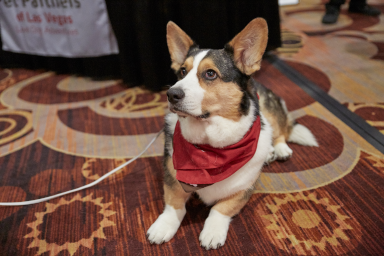

The next cell converts the `image_base64` variable into a PIL `Image` object. The `image_base64` variable is a base64 encoded version of the input image.

In [ ]:
image_base64 = "iVBORw0KGgoAAAANSUhEUgAAAYAAAAEACAIAAAA1FTYwAAAxy3pUWHRSYXcgcHJvZmlsZSB0eXBlIGV4aWYAAHjarZxnjmU5coX/cxWzBHoGl0MLaAdavr7Dl1mua4ARpC50VeYz1zAijiGD153//q/r/vWvf4WQU3S5NKu9Vs9/ueceBz+Y//x339/B5/f3+8++fwq/v+5+/Bj5N/Fv+ryx4o+DBa+f69frXycJ/vN6+HrdrfP1xveBvs7w/W8Y/FR+/n7y1+vz99fdWZ8fov1xoK8rSuHrivbXBX4dKMWvK8rftxY/X03z643vK6mf17tZ/PX1d0Ldabf22xil8fkxFrNf35j2Ga01vkbNfv6fUw311FvPz59dPdHnkm/hWlPJmd92DS3WGV8Uc+fD9vu4/eP3lrvLu3DlKcaTQvLv7/wZg6T/Yxr8m/g7JOLB3/W9Et4r+V2RcdruWmq58pGSq/KptMTfp7ZPCoyeoz6mV/Q3n7051vLzM5zP92HR/RHaF6u+GeBfX1+f12M0+1uKxGbmfn2DCL+zJP/HF75TIf4ekO/Pc2rCrx+/c0OjkjhC6v7XHLlfV+rz76/7r8j60Lm18UsWr683Yv/t1mL+ep1S/PXz8fvztf8+Run7C40v/HprX/Xn+++vf7/tx58H+jpD9/1l8/cBuN13Mz38m9ejDvSXN1Spf4uOF8b8mv3jq/YpD/frG7F+IdAZv41R/r7l+8frX3cQ/Ijub2HmptOL5p9jFP54/ce/I/9+IP/jFvJfby39m9frvzlQ4gy/YlD5urWkE5SfeVfj1+tZB4qfMXz59f1G+TrQ/LrR9ePmfruStn/k38Ns78d3Cby67j8qnt9fxevn8pAgvMT/y+fc3z4YLI/6Ig08EcdTS4775+9/Xtk3i/ya8r99YFj288XpG8nyne3n75w2fuFWdsm/y6RO0wt++BP96j/P/rf/3PcPoGwALWO+GfAt6YObiVtKLfm66wZ6a7wPS4lKzlWVXSFZX0pJ7qF0422fwxu6+ODkH39+T8CfKeC/Iv3jir5u+zca9v+Gnsf4cZAf7Oy+KiB/lcLvJFl//PvX10P5+br7vZY4xy9nTvXrBPH31+uK9ttImw70RXr3brv3fO5u5Aqj1a+b+r7F9xOfmyKh963Kn8b/xZswW3/AMt4YfoHH2y+KY/JzD5EI3JDDDiPccN6/KyBVYo4HpoJZ4oopLMeLlhoQt14+Zf0JNzbyaicjARbhBvBS/HEt4Z22v9Mt8m77HcwR+MDBPjn6f/jj/pMP3avaQY/YC334xDeqErgKRS4E5wMfIyLhW+aVN8Dff/78L7wEFCppmI0bHH7qCIR/lvAzudILdOKDRcX++TK4E74yOHMFhYtBUuTga0gl1OBbjK49TWoEaHDpKq5JWEIpcXORMadUCQ7Fxbn5Tgvvo7HEz8uIVwJRUnWUpAmiCFZGJ1W0jpFDg7LNFCPypFjpZdRUMyqkokqkWoZUTCutttas9TacJctWDJFjZt3gzJ5QV6XX3rr13sfgpIMjg3Vt8IExZpxp5llmnW3a7HOs6FZaeZVVV1u2+hob3NjgCbjRtu2+xwmHVDr5lINAOnb6GZdUu+ki9G697drt7o4fUfsK6z/+/C+iFr6iFl+k9MH2I2q82tr3IYLgpChmRCzmQMCbIhCSi1Ex8xZAOEVOMUMVUBUlcpFFwdlBESOC+YRYbvgRu5+RKw5x+f8SN0cg4v9H5JxC9x9E7p9x+1vUtjB4vYh9ylCD6hPVB0pAdmXlHtYMZ2+4nBKZAFfhPBO27y3UtYprNd29b127lOkZh51uj3f7G7mPU0cJa8cF8nQCseHi7uPMpwvDJvZg2qZEt+OMxBL7V04hYiiUtjoDe3u7aUbuhqjbPRcx1aD2mC2EYL2uRJTztbVu2jZdaAj8bOuAi4XRDGXNXU+pL5yRZJlEeM8M0I7Ya9iJPMDrGCG818ptbZD7bpAVqbUQG0LOT/Rm2HEsokF8+2KcxpW+ToQAzXgnSTD9Hmv7cnt/JoIjEjUi0E4vDUtISm/lQSh37NI6gUzhzNJm6N24yW6Hcdkhnp5DZBRtL6W2jeviLkSjEBBGn9tErJVF9oy0Vi+Zj4QySa+VuGplK5dL2nL5RjZB+jfyWx247MPIkmVcYvenDPIo2Umb099dO6dPa6L5WhidLI4BIXhOvhJQZN3tQ/9PEnIcjm3HNhS1oZyUyyQ1B6Rl6ZoNiockaHyXArc0SzJuOe9RVlHeHSrGu6aigplSaaPIrww+WUwE2a9Sr1ACrey12oDqQuafQWLfA3gbd0lOjdCns7MtK2lWBYkLpLl3b56j9zP5WpicpQE51hJjT2U2q0QVv96oaayzVdztcMR2jtka5Uex7lMCpbtVlzfP6+ci8UcCJS2S0zhhsoY3J7aykFJYTE5Zene7UQWHF845ROBgmEci6I07fILskDnEmHI+ixIu5VrKdZImmTLaLR1KaXs3wajcCFkgS1ucl2ur57RSem5EO1wCMeJtHVavlbtRxfQ61yVKeSaOf24MLh5/EvdR+lUNjXXzBql2DhqTTF4LdpqNyoF7BeIIeeYYQNQaXDgpUs7qDq+UF6mI3ARG9zpnAzlbhnOP2alUAHMBPJTs2kI1hp0wkQ1+VCqejOdjx4HMCbQBc2YmaoD3XrABXzikUq5Uj9lFINV68BxI+RxXJ4TgOtVXOXljeJvj9HldxiVRQOT3TT28S08rAWMZbCgKTru5prxBVfK5tgCEpVH5Ne07apmunJxbq+QFEFS41LR6KrPvCZKdmff1jEHK86h88+wFHJyjbgqcS8MA2UbSXUcA8gUsGmPMQK7eCS5psME7ThWJwVxGHti1DdTiIU8Ktm4kP2KZHHnamdu1KTwEL4E/Pv2YD8BB7BUo81A18Ab8NnAmgG5OzR+QBEpalWqrOB4+Dx3hwMEihpR7hBZLEt6uzgv55LrISpwM0D35pQjnWiBZyLcA5MxI4deCEMiOQiP7IJgOEEN3u8V0wFfsI9W9VgCbyiTTQENpTa4PWUXYxsaVJfBLPH23I9mJz6DUg99Wt+57HRg+lH5uIYuSjkSuENeeDN81aj4trEqKEoJKoq9s7lJ69foN8udeizA9Fos1LKtnYNCNahP4nQjRbQqDv7omJTjpuqQQgHqsuX00cuRznpvhWiQD2HmRA2vXCPCAwKCwYGWujGygssEsKNiTs0EKIOxSl2sNYI59X1gAx0atzgkG1nMnFoHytk7JWyuDeqR6NHazjAYItwQuQ3uTCE40JHXXH+6BcfBNOmVzrMq1xDYp2oK0T3hQgjxhQLDfWg7AK9w0E5hHpcThNtcc0CmEt7fJASVKoHZgeneDjns7pIPswaR27hDMjIlc6BUbQs1BkYQU7gcgF7euSoYyj98FMgDbNkDRqNBGbcd+ABcK52Jr4LO0rC3u1uaJHADB4jyQ0cjVXCsXej3jABgAWfZsXTDGFv8VOBjiB+UwhxLlUASoisvwcP+rXadCbwudfikyhm17eYwNV11EOnyB5tgpQ7GGcIJWKHHUEkIOIx2gTcn40htRG8dDyXkhAIgS4M05Augnj099kzAErfJtyhqkpjAnPBy5XjIoTF6BZqKbO5+JZkQfGcUjwAVKYt0BO47wOVJ9dg71SVaC8PAZEg2u4soYf6uaG0jBAWL9nrUDqgVY2+IHEGkjJhcRIyoIhkVd6YpQtYzJQC8UJGWcba1JZjLyx80CPvH1yu10KgNVwMU2hutySdDIBgeQmwSOjDp8cImyVw0TGAEaA5+6DXncwRoJOZktOysAWw9DBKYlJJtclOcqZl8EEtxrphh4rpPhRoAzgF5ztZEarEgHcrJxZUVCgUqnZPuCCHdQeu8iFDWqHqFtpjSgdFDky7hIbPJ2ROpN6oA1hTFqYFhkzNaE5CEHKn+3RZ5BZ+Q3Ec3FXwYfHOdl9DyQa6kMh17B08wA/EcBmGKKnllU6QkwnxIRzZWRA7YHiQiSgmkHqRrIjolo7onLdeiXfDRJxfetUUqyH1GZbL2hhRF4sMFpG+GLlEXIWr9tw5DSppZ00MplOWCt3iAx3w4Yggs9Kw7qM4AUAC2yhm9eShKSv4zqzQVcgZEXgh/54utC5Sa3DLdwleRtH8A06k0Gj5KMCL4leUeJjlPupCpRY89Xkex4oCbiN9xPOg40AdQ3knEgn1B2/qD4OqdGn5LUcLWR34hAXAOljgQOY9aufDyV+pawJWecmLJNsJNwEZ+6MDn7UsYBKO+KVYT6PTGe4pDD0FYgv2BXej9pdgtKf1w2V875wE/Q0deDQMLnt3jJYQQbuEiCUvSUoV0ESThexA8qkkiHJIuf8XYFtFuHIeRrWBXlfTZgExZAFeeKFcs2NYUHoYWdu85pc5ex0O3xIlat7XgcDD6jINwyo8+5FaSGgAQHCnWM+8CJcPQ+MyWECPLIK3Rgw4dF+PHA6agIx0UQ7PrK+6JrcY4L2UMIatspGQFY8DXWlEqyN9dHSswKM2jMp+RUH6s5mH70EMEMyhrzldAs5BNihivGvVEVhiPIIVG9CEK4KK4q7S5vzRkTdo33XUB6T5Bqg5043oIE5FSwGndFMSNrGReiZJckIWtA7h1wRvjShcjKZ8P4XCGypoS4RhFViK2xQYcrJiUnzrseshct0eRIq2Q/4wNR4W+gowkf8VN86yK38Bb2iCQgQYBC496w/rzckYEonooLl4BrnyzpeGWAiKJCJsk9cnNjb1dWUGAqSPJQAiUwKPV5OzeLh8MHo0YRVQglhFShmFCylL6BjhKLl/wigIiI6sH0ID+AEgGMUhKtl6RVJ6hl49eSr5QYHM35ITwb2GvUe7I3q4mVTcNxwxl9PtP0FynEgMoPwRKgBJ9YQ9qkwr9yxpmEGJQ240ytbGqoQdqI+bodCEaqBAJAwA4eidHbQ8C6dyVCgABsmytGvETMWIzwv7ShUo7swGjVtuZwlXJn7JDagZrx8CgsEXMvIcNw1NQgpTEGCe7lqBtI27C4lsq4fwAUmdAnfq2nOBGwn8ln/EEuF3PPvYySEzmAvYc4KXFIuKy9BnUCxAKoZKpmNqglUHu5iGfwABR0ekXbEz+XCRMnus2wTWQm9409GkhUVDHoVamUJM6BKitchnoyWCTJaVLofaMYqRdk8YV0IHoyhrxIIACmNSKfGGAECgIY+YUXRuKPtmegNruruJSn/PfRMUCCSb3yRXBIUzY54xy5R0gTJdZAOO5jor+DdB9Z5YkORgnKRpdcIBz1OcnSE7jpo4lIkOlovoQiZpj5PBKb16ciRn50pAYOAtG7VFKuymaYnOnEdmeUM8cMi5qIiDpN8lDNVBHmqUZUo4RBgjT9Dak8MYrVxVk4UfnEMkN1TRNMlRsExTghfKH5mxqv5VRQdFha+P8iW/HTMk3S5lBzxlIPB5p1jTwU2M7FtEoDMcTXU+ta1KBEb8FmNAhfE0Xb5KrQ0hw8CkcwntyoC7sr6xFh1ihEEokgrSBNg1459eE9zhJBy1jES2JNoj4GajGQ1ilSWdQPMAIVzSVXBOiSADh1tBSaCE/QpNxCp6656iWEoLQTXAS6B/w4N8Xf0YxbS2gCH1Tn6GdIkVrire5BRX/9PZoUyBtXs0oNcjTwJlwUiLzXJAcBGc3CdIIjEZ4OoylILCCOw2vSBz8gEooojyWPhrZL65k7PDHwX0PKASbceYzhvF+SGsQL0SogTeR5GlBdnOlNsqHxtKY24cdRsSwUN6yR4CCGJwPRDS14HHkQ8ceIWA8AgO24LyEftEVCyf8mAEXLhMqpvCS/o5ZuGCvQi7LZFwbC0/bKcShRfCkgUqgBBijlIy19Meqji20C4h5tr1Hp8k4gJe6eUk95aK4xuQY9U53VxzdrCXZBWyOAAOC8dF1tuj6QkXLDBmpmED2WcVCMXpJpJfC3OYwR30E+BvgdbsAf8/mFltL5Bhqt9hTwNlpVa31pQg1Dh14u6nMguFp2vNUNuDxBUnASEnoDmqehCc8YW1OQlwHUtdbnqFKhxKf82nzYzoFEZGBcdJS8lwxD8CD1IoouIEfm5UI1Q8egYb4QlFr4k+gOQArAiewmVkh43B0ks5JDPgrq1oqIFEjpSkKDOOAIKoYaRffUdTS3ROKuy0f71ExjXUGnQnqTxnC/BaqCmpCP74SYuJOHotTa5cVazxt1Oha6KwSkaTu58h20fehYKQQO9jb1p7NRBZpXQrlChHUlhRvtiIaG5NHwEFNTtSJHM5aAxBS39QCHIpZ2ledwfMbQyVnGOw+cN+OFig1AMcCIT2TAQEuCiZze0j4MBiL1dpA9oJqIErYENQI5NTwfqdZq0QIBCv+ShJDChn4Rawj3NxMcKgTkMSboIvAVOUAIpkA8XkREWpglBJ1dLDEKm6Ek5SjiGyuOJIdeMKvg1aqwO6YHtd4N0tQkOcpLUQHkHQIFMYMGp/aX4J2K1LsoQE4GyaNAkM94aUQHpHSUSbbE4hwiy9zdCrE5EDpVgRiOzBt1gFcS2/RDZuGfK1WD0wGuyRNyX1OWGamc+igkQUDx6WscKLYYGUkotlB/j43EWm+apC/kL8ZqzCdAyEEqG9lL4TPkXC/AsDS/WKfDB+hFjhOknxtAjBZ4iyd4P8S+J/xpGNl49itkPASupB7dCQFPiTwN8BpaDjsszew1b9YHBM+J4zZxaCTcU2daFXEbTespmg+Z6URpUcZia3baOwTXXZviIF6cmXzG1DHEuD8KdT91i7LvF/UUF2aUl/BMKIKkmVUE1OzEGCtKmVoAbsh2NRcBslkiEvTA6mBHV9ECDIJ4HZQjupG8oBgDNo9R6s8RnRHUyAQ6XTI1oSouhYXWpHiJ/xjS1Qg20MUjWO7eup+TlQncgNd0LE4QCVLNQVhv2QkmZYhxXzVplulKRJMGiHduyNpbj9WsIIaNgahk6MU3b5KzgIfLO0BD2RW07EXK46J0BnIIrFRpoc8jOqiYpkUHJULw5UfOzca/JESEPW04XA43oSUVsXCKQb8BPny1wQ9tagqFesHrL9O0xYhWtwEsKhVOm+Rvx3VH5o63Ogoi1VgbGpNs8o2Bq8T3aVlGP4OrYKMsLmHkS1SixKqm7DDo0+HE3wonNzHQ6yQRNNM0McUhR9BUs0cFU+8ofBR71KxeFHVgxEVs+J5NkZPZvaOVoI+utcv06sC4jEvtNlwl538gTLoZiiB7oSNMCiscoFyzaQNOdlrwWVtrAX5qJQNdWIn7QDbBF7Bc64I1ZElOuIumz4Pxmko0oLZMOB/t3R2FcCHJSSKhcnCT5BhBxVPAXUU6zpOuuHV8JG7YNNU0ZSlRCAmZvyKSWVP11FrU/E1eZybRF28P3b3mgilt7lJzJpeKnVzPgl+0npMQuGQVogcgQbt0N4QEWMjmUStybdgppYaAD9X/XMfa4CF63/hLYh26luWXJdMqRNQ6lzvkuZxVxfnC72/WEYTAMWiCmqSBCxsnAHKRzcgaLVGBa+uWkrbmHTlaVrtHmiCE+vUOsVhj20Icbrw7FHdh14uhQq1lCg8Sg59gR9Cd+rm6FnCtIE6SA9zQXFATiLh64KxQOcfI2BWGoGpuNinDGqb+UEQoQG4WuoTVDGIHyFq7F8WmxQWkDwXTChzSgRU5T+JBtaE7SB4EE2nkCSz+CpkK818gbk1B2NPuMG1EcXrNKoGfsilogomej9i6jOmSeYR+pwDWqFRKi6qU9ruFr/Qz8yhIBrcQ5UAZwpNryOiitNBi4HmC6IXIkCTcp5XIRDHpbojaxTUCDAsuxNKCX8t55GPmnIkqyVo951scDGbDDzCOmltGBQJmXWLomf/LSEE5iTrTaUCCWV2XgBAj4Jnx68PnqgUtLVMkUWx9U3m8ACQPGfZMLTCYQkEUzdK62VZvzeAreeCEEPgJpVMknOAHL39DRaAiwCScE2gEg3Nh+AdulnrQcrsm0X3tvTklvoFY8HbXkpEJa7R6dwvVBk/23Qc3Sybif3BhXAQMSqIqV1BOoJEmptzC5QNUUt6IB2KP4gWgsdewJkYDkIEtiBB0iybsYhl5XHgEfav5xUIuaxp6AZdYsK3+oB0lA8lB1BIoUWsha4opUeubSaugAJWHZuaDfG1rXgcemt153rGNdscrBa28PE5DA1X0cmXYwtKsheaGTjBu/oL64Cw1jWqQ/WIE0A3OKCzuMlNpz49OzH/x0ijADpCH+0brT7kv7oj6ZyiCZntQ6xPtPTRZFBrhB4uJtwyfgERtVlr+eZPC/LFHTh3bph4NDjlAPRI1R3VK2FVTCJ+YE8UGSyOKURiDS2xaTKFQ1psQl8cnofRRKg/pSw3CtDd/2JW0XJARmjJsd5tu2Yv4/VafAjRbwhMy50jTBc2allYvI34kbitSERuj7ueAllwkHvLVUcmkNlTKIDStOwbBZdWE3ahAMxzPePNtzAgaiyGI8nM4TdVMheNRUBkLQYUBlhVIUpKU4ckGipx7UucI0VOuqDgjyY7XA+NPOWpswaEgKUikDNIaNqtTLidJ472SFEWUVdX3SeWSR2O0TmFfalo9N3WpUTJSGloALmH4ZvgZV8BRaRZNqlCNDQjDL0W1kGOe/N3gUsFKFQJ3Yqlei4keNYCuGwAOJ8OQxOpyE8/Cz5p5kF0l9lH9DZo1zAcJaoK22RhT8ErrBLNyaW/2NKtRAWuP9nWdNMIbq++AQpXRT8/jVclpdC/lgCwunrqdWj1fCEFZjrfu22QFlZXL3OaoRVZ9SpZ0NYDyDjmOQ+ekDDQ2jnsgnhWzfjU9fLN8kJrfUch5QhMtONktMZ2HM5NSWau5jCl5ufxoS+sWWgM1raGjq6vWYlPJ6hLBnG8+1ixYcrAJ+nRq0UgLbQGlxLUBT/OlNlhaI9yb8G4Rm4xKxBdrZZ1y8eDaijA8FeoaumJmjDSJCN/wztJEVgOgqU/RBAJT3vSqXRar7EU3jPt9DSkbOYVcBCHrkraDfKO6l9AQ3G9784PIn0DponoONXcZUQzz7eCGRW4OG91VqFidlZB+g5NhlhBQxYAg9b/wLRj1xHp9U03a0PaEu5+/B7fKWwjKxwgjHhOpb2c78V6hYNUprOqQ3pwiQc1tIyRVyfiOg7tjpFePMtKGsgS0GncVMMjSze4tXDYtZSDY2pGGEVvhXJGmIL20IqYySQG0BAINzdmrG4Rb0nKC4IdcgGmlqhgLeFSWmRpGjamDQ8NLhBBAQxPhXBxpETv3MbS8vaJmKtBiVXBYcJAZNSKVPiUOQDEPC2v9PTHgVz4L1ychCMZr9fysLGPCuFHHmobqDA0uGwm4t0zORzUsxGjDPFXVSjc+o+kM9NWFYlNMVy1OYA7khM5DuRHzQLU2h6aKIBfUpO65UXHMFQ0r/EJlE6VMOWu9dXQMf4JmYW50qalsGCTjWtfoy6EATrVzatJi5lBqkopCGqksWGnJJ2p5Xt2nlbyoaPBrK2odzmsNh5hfaq1SdE3tgZqk1eS5ZiOPdM9Vjw4EdYQWmvNNiKeZ3t6Rq16KC9JcLGKceTq17En3VnXmwi6IS1ytzygizNAyZI5ptkfrrHCEAh5xDh2dXcCqN5+Ap5Ma0fo/gB80RTPQ3O3iDZtWFlAXDe9flfmkI5zI+6gHbYvR8AH9KnaseBXUdi2Pb40VdTCAjNKl4GARwsh9gtpS3NylEd88wV3OY+SVEszgRNw/3E8lAwVR3LwoWCQ69/r2PdSqDq2BztN0TtH0KeWBFyiIiSiIAkwIodbPEaM3gqeUnjoxNT8TRFDIIJmHMSgB0xTkIRjiIvVfRbUKinw64uNIjiFI3QQy6zkYxoF2AbxLDw15Mrvn5jVxQWryPUod3W86T4e6kFCoaobfoGXs6nLkNOPAnUEeOG/l6qm8ctCkpv7QincyLikDwxuEJ6epqTk4CSWOwFSrgRKSekYLwNkYNBIRx560hhFw41tbsYpWHS5DiRdBhR6GbfN/hYKb5jOSec0/uTeNAg8BG8TF4/JK96PDjxk/rnlt5HFrWnOVVQp7aIW8VUoTtF5vsTykuFziLmYjY9AQr5WNmk8PoTNWxmM4U6fcuGEDUObAy2UtfqAEOatXt2ZVpxJ0xCVBFLLSsTM8wLKF9RbkennUvUkjYKtpkZUjQ3BbzQcwKYe/KGhwL7jiMfsHqg5Q2MDwyWHW0hiBE143F0iYe3gTtkHJQ8ESIHyRZpF10RmFm5xcoW/q8lzo1Q1xdPXEorwR7+mNFFxNkjOs1F7Vji4YFUSAGtGY5GAcBNVxIZsDxaOVARLq9ScgfRncxGiRNUX9MW1zEhJ74ngDGkfDpu4whrN428lcJu6IL3Q2EqrsHrQACY9z8WVKgFO6oiVyXGkxvfV2ihqMiBklgtngd82NBBye5jiQlLDUAc0zSlJT4uri1HoKIZRRIH9wZF3GChnymHeMqGUn+HU4ykmLm/GGXd79lhDV26WWijy1D2yrFwb0QylvLSK/hjDIHBDEfGmVcaPGHP5TMIpmAIlkuCDOpkpo601NEpW+gjqSyWNTHOVMn+alutVFlbnqmpwaTdX7mtQYgjiULEIyqrmraFlxaKkZ5CUlJqkCSqjJ40pzgp3g/alq6UT6qc0gCic4YYzDA66aPZXlUWRyUNOGen9wygCp5rcT3xWV9hY5ayIJjmzWIQ/wc2RStLebjvt4/EMtmeYQm3/WpSEfkzY/ogI9kksNyer5TZdbmm5qYSeLVEV7jEpY6r+88vJqF9ZqRRZ7Qk5IBs322lsOYHA1wR1TpQibd2nKeFHZdoqa3s2AMcRZQG1oq1Upx782wfMIDxWlNiRJPkr3UMYdHUQtuCq7EJWQOfl5NQ8eKHKtf1z8LpZpVS22vrXO/eYABoWkXlgq4apVE2nLgfiF6k8FjQEueehvVuwLpKQMpX6QeFSdOhRwDbdqTbJqjjxQqehYNTKgdqrTelGX/9lhIsI4vZ3XoR+6WgaGWiGr4BsK1tR2QygjPtUETSIMTYiAd7XB/fGSucjux72zZ7SWFgrxRgOIAeMXgazoW3JvU9qZb3oJTFhLLVJSzN0kIjaCjmplnMKN8xRZMO2nETl1gmGbPCWd9gUvsGQhdp9f/zxaDyAIiEwomwIJU3PSmjS3KFYnN1vDBSGlohaCoS/YUq3COCbtPiUkiIELXVa4+xD15SSMtBuA8aJ2QPSjBqlzuUicKxKU+pKr5FJxbuqv0CTh7tKKVAE2T93S5t15/Rroby3IM3o46SPe6Q3PiHJDXJDs5CCgfaN6SaiX3M5Tt2puQ2SKv51aBLVlZwzb831d9n0EP6h1kocLwzNpRuqC5GqQ1OT4WeryQalg+tQgYtftrTaIuOZr58WUyY6rUxbN3P2b5j1Bk7nbHkuT9GjfogVJSfrIn3NPJY9sPofKrXMpXG0qfE+dgmboZiCX2lcPeNB6pFZ7GGPADHZS5y7+NTYtezlOlqR+O7q5afVLwHk0LZLfzDZ6QAfkKIQdgYZGQYSNaauojqP6g9QgDvdX07IeIMawDq0wJlIJLUKdce+AHrYKEiEgDUdbvdIAwuxqQH7/ZQA8Oq0XIgXVbYXkLmDoQG6shsHgToPWFEw7MNAM0OQU1HvK4MI2r4tTHYWR/HT7zRGXSqKRoF5NWojkT6cWgsHU9HcrzmdrHgH32QjD6lqsW49JGBUwE7+m2d6FgYlaXoMAjVgR9BgagI36khCAyPkZQ0sEUOCnqZUbDVcRm9pfDDwIIZE6VoV6pAnYjAi52sVXUcnVZ2XR0CQYNSxdoCY39Go8/Je1YYTxq8U70PtqeR2di4HSjYI4OYytjrHT9wBCSPrK4TFN8IEdNVaiMkioxnERYmBJ034R9aNNqIzMpBDI14xQxdwQ7EIcB5Wo9hT8YEaweyi+YhQ4nvYBdXixYWYd93k0OY7KhUugJHA4He3TE2IC0kDSkRdFIoOXBfVEeap167zeMlDCurYLYSiBZFImawPNVu82ZAnFkaLgm/xt0pQfYncpDB06fGuFIhRYhLtBI7+WmHIR/vCtFjJIwKMV3hzVwTvHotrhbNAub9xpV1Zw2qR2Jm5lIz05D/XX3NRkM3y69YwCaJkcCZfz6G0/NWOSq2ZUTFM0cBHxzmjwdLI2dRy1QeF5Ige6ipJfajoUemuvTtQamJAHE4L9mBzw6Xus/Dgf7Va0kYULZ0AwuFsaEkCAtRkUbCZQovVErbZUWABAkHhWx0rVeq1WMCJmVdvFAKQS1PxTTZB0nEmlq8mRYOrzk3pr2peCxCja5+M5Wg9eKz1QEhy7NZ2RGtKfYuwTE8WnjpM8hJqvmrTfPrCiZcqAYwsIeC1+9KqJykTSF9IfplAPcEEDEgztWrIs8sdBMmhA4sBmcfkJBHnFhQW4mlkq/koyBmVt0t4vLUiSsFpJhWLsbQJBarqsPQ44IPKDu5kkP8JYzfOvd94niUESBCd5uT7t0NF2O88Yhs/WbDRFVCsD6axNwg0xjPO4WQtmhoq8mijPBZhfXhpvwuVFtoLTazKCix8COM5o2o7gQIwt7kOlafsbRq5on8ONIaMJEclg5dXK2Ayt8R1IM3DpKweMLkVYq+ZDoGyySBysra8W9YSOdbUPS2IlE7hcH11CQ4TAujYIds1oFVw8ny1qoROyTgdaRDzmgPzyktgJ6oTe6TXObzS2PWubsMYwpFQVej/LbPV9i9rU8WG7ZPwaUhaEzRNwAEfC24+jlcdyVy7vERPwHTmEwpdr9B0k1H6jSiVhzVtP2lnlAFp8tioVOXaSl4yA7ZEhDC4hQm8O62R+z6alzgd3nTgjOrLax2RocekO/6YOPy6ySGFKTPE20rRqWgQv6bOa6uoH6tUqCiKqxoeWDA+pitSnJJ3m045dTcWig3ARRT0IYBoZ7TPnrrDp0IgFAJI7VQsrLJOPlBQ049FOQJWL8s0UEDGNWvkCNw6eg9ifKqmr2Wo13Mi7cRmKcehchRYmidlVsqh71mltRg2GiFe19L8Nl6J1ii4Scs6NdzlvAVm7/gIQZ1MLBXK4XMQyYnjngSA1l1K1Uc2jFfRYDy1Y6/PrubJKsav2QtmeBAW/q9aer7ahkLjben8twwhYskVThuozQ8cR1kU+oFw42ZvpUsflZog5lql3MhbtNBlazAdQE5WIknfwiTaWoUFCghIQaHFSkpdxIZdBM/XE4KxBN8oQ5K+a0kbxdQ6sM0FThhRwCH+KgagxCktNHtqldrfA577ZyfzaCTNgX7STkYvAZTfL2kgTqvaHXq88ul1dBkvgRNpiw7Y2d3T17VWp8RNG4K7BIO3wOKiQhCYDMzWbIe2OHtceS3e18lU0a5IGp1jzKKUPQH1CDF67FNTnND6LLOEKqBCd8oeQYGhckLa8HIcSiNKtep6BfGvBqib1Cy0witJUzy7ZU+5bcEJW3reHS7O56GjNwXGBIABjhIvCmCFXiyT8jGqyDVDcQQ1R+fY6ELSjJr4JGN87BLNQmOuIahtnifU42GXgFirSDghHwSIfGVsuUmtVqKnPBJZafNWz1yHQlyI4tyfEutasEc5OU1haQw3q6IOKUcMdyMQade1zFHQgx9Wx5gMSqE2kViWEyCZ0bFQHNzWBp9UkTVYrl+bWQoJXOVB8DRCMyCQw1O++aQ5NsmrPZESt7q2dnAwEac+xyHe31WT/trwHNdhrDwqsQlJUdd0Eqdmm61HXUtHCkRZDV4W/o1akGTsr70DBOq6kaz0oaPqGPFOTeYEOxnydUYzd8ZNhhivRogXNOBtXHko4WI6MaMgof/yUj14P0hjqLwZn1dWmFR6u0ZAKr3/eiGwgP+Wh+EyaevKD5pkZq6DuCQhyykQsvLv8nXqgD55azzFqE1sWtV681pgoFsT/mJjlt2GHpJVy3a9jK1xzmHdtOjrqLUTxaqMeSsJr95j2BWU9VEfzDZow0wy9ut0xNFoRhCPgIDJc8+94EQDvXEPbBi0UMPIwIvnOvRABbTIr7XXlGy5d7QxbIjE931sp1KK2L9ksDLgeOwS4UhaD0VLzH1KjaLuiujm4MTJOCV91cR6oXUCa5DVXn9GjaDyqf2hvJtghvcGH0Rr8lPH1DH9/qaWuMK+lbnUetbcqtK+1qr0uXr+R8tNxYO0FL0D5hqdAEz2DBam91eupFWd8c2FEgTSrIauXfU5YAIzO0moEARW6HZ9sJHmUwRscPpPC6y3oo5a0V0QmIQpAKdCiddK3B4hxtDWgZ1mM5oe2L0bNWQGyS702sAKjSHWUbuoWKdyhTAnnuR/dQcDUtn0I5NJjCXKscqmA/9GmX68lA69tygmZd8/rRMxvD7VWy+86b7NxzDLC/Dy1LVrbz9XcUU8bjkLWTNIMSCM1jpzXhpTUOq2uyqq9zWoHQD0iPfAvW9ul5AxPqNpRBEZqy7ejUpL2aOohSRChWqdgHFR5V+tbVYMd35HZJoPIqG2JCDCYW0WT7pwiYf/8GqVAuDWVjhvUrBejARJhvTRtUDR5pyYRkCqqtiLoadKm9npQtb6iGfZw+bYm2I0hkE5tpOnQZqa3TK5FcBtqgznqTvFa/U/at60nIWniPL1O/OOd+jINg4PoYMypB+1BQKOjlsrTgdnrk9pUU8jSM7VJUGkAD1IyWTuC4fnr0uuMS5qAKwyzpnk/86knZNHhMxpoQ90aAynOaG8jsChHS/Pt4PgTRTtblnJANGw1yqrnTQtJqAosInovZ/UG5qypdQSydhM2TqYq4V6r1OT0bTkSRk8xQq2CBTJEDHNOa2kTP6qzH/xv1AMkkLb+NcRp+QArUAkRDK1109rmdlptU08pXzmMUwb3EZhgpvbqvmuXQvGXe2+a5JUiny/UXrtJNoo0arnGHXIaEt1agIrqNQ/ScOr3Ru6GucmEt7lHPTnkGi5KvLv0DAftTEid1NWjcBw8iP4kTaqirrWepL2E6o/BOnKrIctp+0JpQHymZzRcTPHQOgxQEggqore4yiAsYb62XNSO3SoZM5L1ObCfSvOacNJOKLS4ZJfaWDSFKgPa1eNzizae6LEWb91uSr0AKepovK3L1FBvSICg68M6a/5oBnU/q+vwVejV5o+gh0pcZ2CrRFGF+RYoAL5BX0sdE4OPkx3hKexmZOFR990p2vQ3u1wA/nNqVa/I04LXfr5nQZkqpPtn/+ckl/XQBZDrpSyfH+qcQv4V7QVucLrWmYpVPbXFQVxFM/V6yt3gNe1zprT2gjWWnpMwiqDwGLpQkq69/v6tNsails6lNeRYo6uRMwOV51x1tgCt4bVxGyYOWKNWsqyeNstw5UstyUEnClNSAu0UsDJlGyJCCJs0RQ0oGuKOukLlaPqYgMNaqypqWzh201ErFbKaxLOqZyRUiKBoZ2Yn93U/XYxzjx5FosViBlXT8/CMpmW7tiM0ClFPSkIRa3MUlmYBMMPggzpwkG0clbm2NYSsx2KBzGruuKiT1t6IJXISlQa6r7dZqdXVs6fK+Za6kVHJyU2uGRjgu5VqOZE70gKAuo6UULXoiUKT+6NWg7YOaAJGzRMTMRLEk0PNvNlhCwB2wF0oDgSqH2xpvW6WlkzdsZrX4GBrUUiY7ddp30HVKrMyMCpX8ytO7VNFGwsLVMhgkppv+56to40BTSkPPB0oHJVDXWz1rZjSaWnGZtQOz8Xj+nmzGAXTJxLBJZA6BliCi1uQWSRmuEAwVW6m6Jk+iMqthkZQNmhKwn/2ZWvfNieRoOFKw1v1mVpHWbhlCUis6MAaYzSX+iKLSgcJiGDYtqK2iKeBiIiXilaFoTbC69DCO1SGUw86tNdkqfm1pdYK0FDWOgNdgqisBw9o+q6ZIzfba1pST/PbGlyv9sS2eSUgtV1maC5D0wraeqL9CiV2yo2DQsn4DEsjVT1MYfecV9DEDG4vm2bkgX+icvrQVhjGAy0ktwyDNFIszasNdkCXdkwt9XwGpyc1jvbWHO4J2mY6NW37ZPJbrY0cQ+sdQavTGL+NEJtjUs6hAlM4bHXpZ1de10h+M9QX1BkEbR1tW+woxPj2oeIJvJ4Tp6fkYBhV7Ixq0GaU+FmvvdSaJnlMayxqe1V7L3wMkWoituspWTITCz08oDYPJcG+kKxmWZO2d05t92FIHKJWC2wobPU84Wr1lJfVkO0ktNZvSaah3aGmnfIUqSAlqFeUA9h7aFkAYqJD9yKoh3YB5mWazkEypvNamxLHw03c04u4Vhlxzy0ZzwQQvzX8ra0G6kd1esYA16fE6abSzXbqe/7H1Z42bUyo6ljRrrrmYRk9zE2LKEnydhMPKVbbDnkn99GuvqoJtaQleLUIzm1a1QMiKD8tQnO3agLVUu043JGeBvXCZtyWU1vd0GRm89LIMCeSAMz3l4ScmhwAXGHljM7f+A/1oi4ISo8lQxkm/9qrsFnKcbSvdLE2Bow0qXPZNE18UaRn6mEPkMvJ6mkGTbuWWcJbbn8LTtpV0htFy5XjFDUNjHBRT5GmXbRFVo26I2hhUI9FiU3NntpeLCgd7+EyK+hpeLgh6EjPFNLDEtTQdNUlJFOi3qJ9cMBgHwONGsQMTU0DREpZW921v6hIVevBMyehRoq0nJ6RgzfWako1ZfFST5y2brb4nrx3YZ8kpMKnmBpFNxWm9R0GRe4j4de00Z74qVmDWwQvNWs0HkXqUTX4PGBJ8whU7NEeHbCh6zkcCCrkx7xBjYBYiKslx4vwUCJiDqR4NOOtraJ5qnMfOB3aeYFEkzgPaqzTjKB2opH6XntMstOOxq0nMi0pOS1RE33sUgvahrTQGKMzujvr4VrBtM8Zy0AEuhaGYujabJPO1e5VdCJ4ZuKOaWrvnFJqmMYV10xxq3scaDtea5hG7mvVF3+tLnZpHcwOis3P8BZGP9s73jrL3BtaeU/fAUe610Mn7tIOcE5xk3aS6hFDIAS4rIV2Ej66KVmIl0kyh8uQg28xnEvQYyfVkY6Wh/BEjiShWlRk+yE0cE7fnJorXOa021N7KfkVDCNODGPW6tGbARra/G/I+6YOCpwcosZrRSroCbKfxyV9cNTpH9R9zKih0d8ePyFiqu+pGKY9YPfe3d3/AJMp228YKYNoAAABUnpUWHRSYXcgcHJvZmlsZSB0eXBlIGlwdGMAAHjapVNJbsMwDLzzFX2CuMp6jiNbQG499P/oUE5rIMjFiQPHJGfxAg7dv386feXhLKSLiTXbiuH3d/Aw7oV9Ra18E7eKXjyhYhpLlWhVqwVLcYslGoVXjRZ7HNSUNuvBVUGJ8KhZJ1YtbbqszSSNUpP/sBsmMDptIm+p7q7G2WtNWxUtOEU2VZysB7YDWyfG2mQjFAljMOEBeAekuqpjumYtN7AK6nKwooEVNvBcHBo9nDsVYYzZ0jdN01KKDdtMfDnuNjs9ujR6paDrktcKui55raB3X+VZQe++yrOCPvvEp4I++8Sngq5KCpaW5V+Bq4/kUEomXW076T7myu0IUGDpkKlpMnOoNhkd5W4b0D1xisxVw3PI46oxkJ9MWaaoZTenR+9VZgL6IwEx9511zT2ymaDHiH4BzzXpttICDxYAAAGFaUNDUElDQyBwcm9maWxlAAB4nH2RPUjDQBzFX1OlohUHC4o4ZKhOFkRFBRetQhEqhFqhVQeTS7+gSUOS4uIouBYc/FisOrg46+rgKgiCHyCOTk6KLlLi/5pCixgPjvvx7t7j7h0gVItMs9pGAU23zUQsKqbSq2LgFX50oQ8zmJKZZcxJUhye4+sePr7eRXiW97k/R7easRjgE4lnmWHaxBvEk5u2wXmfOMTyskp8Tjxi0gWJH7muuPzGOVdngWeGzGRinjhELOZaWGlhljc14gnisKrplC+kXFY5b3HWimXWuCd/YTCjryxzneYgYljEEiSIUFBGAUXYiNCqk2IhQftRD/9A3S+RSyFXAYwcCyhBg1z3g//B726t7PiYmxSMAu0vjvMxBAR2gVrFcb6PHad2AvifgSu96S9VgelP0itNLXwE9GwDF9dNTdkDLneA/idDNuW65KcpZLPA+xl9UxrovQU619zeGvs4fQCS1FX8Bjg4BIZzlL3u8e6O1t7+PdPo7wfoFHLWuMN5LQAAF6FpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzVNME1wQ2VoaUh6cmVTek5UY3prYzlkIj8+Cjx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDQuNC4wLUV4aXYyIj4KIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgIHhtbG5zOmlwdGNFeHQ9Imh0dHA6Ly9pcHRjLm9yZy9zdGQvSXB0YzR4bXBFeHQvMjAwOC0wMi0yOS8iCiAgICB4bWxuczp4bXBNTT0iaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wL21tLyIKICAgIHhtbG5zOnN0RXZ0PSJodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvc1R5cGUvUmVzb3VyY2VFdmVudCMiCiAgICB4bWxuczpwbHVzPSJodHRwOi8vbnMudXNlcGx1cy5vcmcvbGRmL3htcC8xLjAvIgogICAgeG1sbnM6R0lNUD0iaHR0cDovL3d3dy5naW1wLm9yZy94bXAvIgogICAgeG1sbnM6YXV4PSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wL2F1eC8iCiAgICB4bWxuczpkYz0iaHR0cDovL3B1cmwub3JnL2RjL2VsZW1lbnRzLzEuMS8iCiAgICB4bWxuczpJcHRjNHhtcENvcmU9Imh0dHA6Ly9pcHRjLm9yZy9zdGQvSXB0YzR4bXBDb3JlLzEuMC94bWxucy8iCiAgICB4bWxuczpwaG90b3Nob3A9Imh0dHA6Ly9ucy5hZG9iZS5jb20vcGhvdG9zaG9wLzEuMC8iCiAgICB4bWxuczp4bXA9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8iCiAgICB4bWxuczp4bXBSaWdodHM9Imh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC9yaWdodHMvIgogICB4bXBNTTpEb2N1bWVudElEPSJDNjk2RUVERDk3MTY5RUI3RjQ2MTUwOEI5MTc5N0IyOCIKICAgeG1wTU06SW5zdGFuY2VJRD0ieG1wLmlpZDoxNDZiYjNkOC0wZjZmLTQxZWItYTRkZC1lNzM1YjI1NDQwODgiCiAgIHhtcE1NOk9yaWdpbmFsRG9jdW1lbnRJRD0iQzY5NkVFREQ5NzE2OUVCN0Y0NjE1MDhCOTE3OTdCMjgiCiAgIEdJTVA6QVBJPSIyLjAiCiAgIEdJTVA6UGxhdGZvcm09Ik1hYyBPUyIKICAgR0lNUDpUaW1lU3RhbXA9IjE2NDcwNDMyNzgwNDA0ODciCiAgIEdJTVA6VmVyc2lvbj0iMi4xMC4xNCIKICAgYXV4OkFwcHJveGltYXRlRm9jdXNEaXN0YW5jZT0iMC8xIgogICBhdXg6RmlybXdhcmU9IkZpcm13YXJlIFZlcnNpb24gMS4zLjUiCiAgIGF1eDpGbGFzaENvbXBlbnNhdGlvbj0iMC8xIgogICBhdXg6TGVucz0iVEFNUk9OIFNQIDI0LTcwbW0gRi8yLjggRGkgVkMgVVNEIEcyIEEwMzIiCiAgIGF1eDpMZW5zSW5mbz0iMjQvMSA3MC8xIDAvMCAwLzAiCiAgIGF1eDpMZW5zU2VyaWFsTnVtYmVyPSIwMDAwMDAwMDAwIgogICBhdXg6U2VyaWFsTnVtYmVyPSIxMjIwMjQwMDEwOTIiCiAgIGRjOkZvcm1hdD0iaW1hZ2UvcG5nIgogICBJcHRjNHhtcENvcmU6TG9jYXRpb249Ik1hbmRhbGF5IEJheSBDb252ZW50aW9uIENlbnRlciIKICAgcGhvdG9zaG9wOkNpdHk9IkxhcyBWZWdhcyIKICAgcGhvdG9zaG9wOkNvdW50cnk9IlVTQSIKICAgcGhvdG9zaG9wOkRhdGVDcmVhdGVkPSIyMDE5LTAzLTIwVDEzOjUyOjEzLjM0IgogICBwaG90b3Nob3A6SGVhZGxpbmU9Ik9yYWNsZSIKICAgcGhvdG9zaG9wOlN0YXRlPSJOZXZhZGEiCiAgIHhtcDpDcmVhdGVEYXRlPSIyMDE5LTAzLTIwVDEzOjUyOjEzLjM0IgogICB4bXA6Q3JlYXRvclRvb2w9IkdJTVAgMi4xMCIKICAgeG1wOk1ldGFkYXRhRGF0ZT0iMjAxOS0wMy0yMFQyMjo0ODozOC0wNzowMCIKICAgeG1wOk1vZGlmeURhdGU9IjIwMTktMDMtMjBUMTM6NTI6MTMuMzQiCiAgIHhtcFJpZ2h0czpNYXJrZWQ9IlRydWUiPgogICA8aXB0Y0V4dDpMb2NhdGlvbkNyZWF0ZWQ+CiAgICA8cmRmOkJhZy8+CiAgIDwvaXB0Y0V4dDpMb2NhdGlvbkNyZWF0ZWQ+CiAgIDxpcHRjRXh0OkxvY2F0aW9uU2hvd24+CiAgICA8cmRmOkJhZy8+CiAgIDwvaXB0Y0V4dDpMb2NhdGlvblNob3duPgogICA8aXB0Y0V4dDpBcnR3b3JrT3JPYmplY3Q+CiAgICA8cmRmOkJhZy8+CiAgIDwvaXB0Y0V4dDpBcnR3b3JrT3JPYmplY3Q+CiAgIDxpcHRjRXh0OlJlZ2lzdHJ5SWQ+CiAgICA8cmRmOkJhZy8+CiAgIDwvaXB0Y0V4dDpSZWdpc3RyeUlkPgogICA8eG1wTU06SGlzdG9yeT4KICAgIDxyZGY6U2VxPgogICAgIDxyZGY6bGkKICAgICAgc3RFdnQ6YWN0aW9uPSJzYXZlZCIKICAgICAgc3RFdnQ6Y2hhbmdlZD0iL21ldGFkYXRhIgogICAgICBzdEV2dDppbnN0YW5jZUlEPSJ4bXAuaWlkOjAwZDRhZDZkLWU5NTEtNGExNS05NGU1LWZjMWIyMDdjMzViNCIKICAgICAgc3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgUGhvdG9zaG9wIENhbWVyYSBSYXcgMTEuMCIKICAgICAgc3RFdnQ6d2hlbj0iMjAxOS0wMy0yMFQyMjo0ODozOC0wNzowMCIvPgogICAgIDxyZGY6bGkKICAgICAgc3RFdnQ6YWN0aW9uPSJzYXZlZCIKICAgICAgc3RFdnQ6Y2hhbmdlZD0iL21ldGFkYXRhIgogICAgICBzdEV2dDppbnN0YW5jZUlEPSJ4bXAuaWlkOmExMmEzMWI0LWJjZjItNGMzYi1hMjNiLThkYjllZDJlMWY0MiIKICAgICAgc3RFdnQ6c29mdHdhcmVBZ2VudD0iQWRvYmUgUGhvdG9zaG9wIENhbWVyYSBSYXcgMTEuMCAoTWFjaW50b3NoKSIKICAgICAgc3RFdnQ6d2hlbj0iMjAxOS0wMy0yMFQyMjo0ODozOC0wNzowMCIvPgogICAgIDxyZGY6bGkKICAgICAgc3RFdnQ6YWN0aW9uPSJzYXZlZCIKICAgICAgc3RFdnQ6Y2hhbmdlZD0iLyIKICAgICAgc3RFdnQ6aW5zdGFuY2VJRD0ieG1wLmlpZDozODEwNzVmOS0yODNjLTRmZmQtOWI4YS1kMjkwNGU0YjMyNTciCiAgICAgIHN0RXZ0OnNvZnR3YXJlQWdlbnQ9IkdpbXAgMi4xMCAoTWFjIE9TKSIKICAgICAgc3RFdnQ6d2hlbj0iMjAyMi0wMy0xMVQxNjowMToxOC0wODowMCIvPgogICAgPC9yZGY6U2VxPgogICA8L3htcE1NOkhpc3Rvcnk+CiAgIDxwbHVzOkltYWdlU3VwcGxpZXI+CiAgICA8cmRmOlNlcS8+CiAgIDwvcGx1czpJbWFnZVN1cHBsaWVyPgogICA8cGx1czpJbWFnZUNyZWF0b3I+CiAgICA8cmRmOlNlcS8+CiAgIDwvcGx1czpJbWFnZUNyZWF0b3I+CiAgIDxwbHVzOkNvcHlyaWdodE93bmVyPgogICAgPHJkZjpTZXEvPgogICA8L3BsdXM6Q29weXJpZ2h0T3duZXI+CiAgIDxwbHVzOkxpY2Vuc29yPgogICAgPHJkZjpTZXEvPgogICA8L3BsdXM6TGljZW5zb3I+CiAgIDxkYzpjcmVhdG9yPgogICAgPHJkZjpTZXE+CiAgICAgPHJkZjpsaT5DaHJpc3RhIFRoaWVzaW5nPC9yZGY6bGk+CiAgICA8L3JkZjpTZXE+CiAgIDwvZGM6Y3JlYXRvcj4KICAgPGRjOnJpZ2h0cz4KICAgIDxyZGY6QWx0PgogICAgIDxyZGY6bGkgeG1sOmxhbmc9IngtZGVmYXVsdCI+wqlCcmluZ2ludG9CZWluZzwvcmRmOmxpPgogICAgPC9yZGY6QWx0PgogICA8L2RjOnJpZ2h0cz4KICAgPGRjOnN1YmplY3Q+CiAgICA8cmRmOkJhZz4KICAgICA8cmRmOmxpPjE5MDMyMCBPTUJYMTktT01DWDE5LCBNb2Rlcm4gQ3VzdG9tZXIgRXhwZXJpZW5jZSwgTW9kZXJuIEJ1c2luZXNzIEV4cGVyaWVuY2UsIE1hbmRhbGF5IEJheSwgTGFzIFZlZ2FzLCBOViwgTWFyY2ggMTktMjEsIDIwMTksIENvbGxlY3RpdmUgTGVhcm5pbmcsIFRoZXJhcHkgRG9ncywgSW5zcGlyZSBMb3VuZ2U8L3JkZjpsaT4KICAgIDwvcmRmOkJhZz4KICAgPC9kYzpzdWJqZWN0PgogICA8ZGM6dGl0bGU+CiAgICA8cmRmOkFsdD4KICAgICA8cmRmOmxpIHhtbDpsYW5nPSJ4LWRlZmF1bHQiPjE5MDMxOV9PTUJYLU9DTVgxOTwvcmRmOmxpPgogICAgPC9yZGY6QWx0PgogICA8L2RjOnRpdGxlPgogICA8SXB0YzR4bXBDb3JlOkNyZWF0b3JDb250YWN0SW5mbwogICAgSXB0YzR4bXBDb3JlOkNpQWRyQ2l0eT0iTGFzIFZlZ2FzIgogICAgSXB0YzR4bXBDb3JlOkNpQWRyQ3RyeT0iVVNBIgogICAgSXB0YzR4bXBDb3JlOkNpQWRyUmVnaW9uPSJOZXZhZGEiLz4KICA8L3JkZjpEZXNjcmlwdGlvbj4KIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAKPD94cGFja2V0IGVuZD0idyI/PpKp0mcAAAAJcEhZcwAACxMAAAsTAQCanBgAAAAHdElNRQfmAwwAARFyFIbkAAAgAElEQVR42lS9S68sSZIeZi/3iMjMc+6jHlPTnG5OkwQFgVoI0iwEghQECJBWWnGl/6qlQEALQpREApQIUUL3NLumu+q+zsnMiHA3+7Qwj7yl2tS9p04+IsLd/LPvYcX/7G/+6fd/7zfzfGr7/fXlp9PTm8vlmYAPH/50W1+m6fT2+Tszu91e1/X6/v0Pb5+/FVExU9Xe+4effvz40x8+ff7TNM3zsuxtbdHevvnu2/e/vpzfIPD68unPP//+ev/MzN9+98M33/ym1unnn/7085//tk7z+29/9fz8zcvrp59++sP15cPz8zc//PDb8/PTy6cvP3/4cd/XN09vv/nm+9v9+uHjn5nlfL4wy/X6AsLb5/cEvL78+Xb7dDq/W87vgfjw09+69+9++M3T8/v1fv/57/52XW/z6fLm+ZvL05vz+a2aujsIEWFqREJEACKCiIgoIghBBBESMbXCLGAKD3fft/1+Wz98/OlPf/z9v/43//L1ekMgiJmZmQAS5nwTESEiZkSQMKlpRDBRBEQoQAQEiIiYCEQIlGIIFCFmYmEnsBgRiUg4IoKYVAQEJkT3ADzgICIiEACAmFlFPZwAUc6LAiDCxYQJTNQDAWJiYvYAgQJAIN9JVQhgJiYWJhABUBMCCOhBzMQsROQeRCTMygwQCYuwhweYmSMgwkwRASLkT1SFCERsRfa9mymBEGCW7s7MIIqAKoswAxHoHiJKoB5BRHmjRSSQNxnCRCDQcR/Gv4m/3hgiImbBuK78HRBIhCPAwvmDvF5VQRDGWzEwLjMQzJTvQMyT2d//y3f//b/4H//ZP//v/vo3vz6dz0TI20Wcb8mSd5kZ+RiIELGt+5fPX/70pz/88d//L9c//rvnN8/9/qICFRY5vj+QF4GAiBApQEQmqk5ExB6xX7ft5eXLz9fbp+u2tQioWgRt7j+93v/4ev3dy+uH652EVFWUmTQcLBIOImbm3nuE18JT4e9Oyz/89u3TspjIzy/rf/jw6d//8UP+3ri1AWYmwvH8iZlFmJn/8vtv/pPf/vof/fovvnv79Hy5VKsRwQC6A7StW++t99bbThGM8LYDRBH27XffP10uzOJdiOh+fWGEWolwODGxiJiWUqp7670BVGtVs7xN0zRbqcxMoFrOz8/fi9n58rScLkT0+vL50+c/bduNicNj31fvTefzPC3ztHg4vBPRVOdpWu73EhStNwKLsLIifN/XiJjqbGb7vrd9Z+He9/V+5WjMvN1fbrdXljotb5jFbGpt29b75YnVSp1Ot9vrpw9/vt9fntdv3rX2/Oa9Wcnq4B7MHD62cN5QZs7qQKQsAlCEe3jvbb2vEQCFqU3T/M37b2+333ciziISUJV8B9Wxsc0KIjwCASYWZjYKd2b2gArH2H5sRXt3Mw0mJjColNK6iyoCEcHM7q6qRS3cPYsYESIeS4RAogKAidWUBREBkAgLM4FENcJVFT1EZd+dmVWFekB41E0QEwmLu4sK5wYickBYhH95t0hEmDj/nKtTeNReAlTFe5hJFiPiOBYweXcVoVEL6Hgr8oCZAAAQAWZWkbxUZo4IYWZREYaDABE25e6hLO7BwgyKgJlGBAhMAgQRZxUeFR9g5qxMpjIOAqZA5PUFIKJ5RGRBB+VLgohZOE+C7k4kzKSqwgQWiiCRPA4IcMq1RBGRVxQR6/1+vb/c17V7Z2bv7kEE8u4iWawAQj5VJnGPCDAL2Cm/OTEciGjdmcmBAHb3vfV7i+bxubWP29Z6z3sYedZRMIn3UFXkahGhPLlA1TQCiLju7eP1+uHlVUSOU4nyICQmISEmJvKIvIdWzMxMDaCp1gj03gEoMRHnenPvRCyqe++MiKDwUGF79+2vpqlGxLZtBH75/HPft3fvv39+evf09G45PV3Ob3MVb+u9txYBsyqay41LrdN8mufLNC3n53fv3/2lmJZaRGVb71trr9cPEchy03fv3ph4ns/TfLpdv7S2ebhqmedLKZ9ba953BEqtqhrubd/u673WWdii3XZazSx6u19f+n4/n86iOk/np8vb03J29zqdX2+f1/XWWy9lOp/fee/X2+f7du0ffmSSeVrkpFm7mQWIgV2Yc3EAJCwgiAiziIiH9+7ruq/rFuGlVDOtdVnOT0yURUSYwZybKSJEJYsCgoSN2ANRTCnIASLJnRNB43wUjggWdg82zUPYARYREQBFrbeuplk3lcVYO8Lh+UGq0ruzcJYzkdzoX+GVKCszBdyJGCLiTiraPVcvsmzlDg8CIqppbtpw0DiHiTj3MLuHmRJRBLq7qQXCVLIeM3PWoFz9TESgYoZAEBJD9e4mkvuA8k7mF3EipggIMxOTEEeCAVIRZhYhIEZNBfIYzoqYO60US7CDoMQvuZnzhxEDHuWrRKR7MIGYhDkLjQiBEghLeGRVBQVh7EkAEeSI7m1f93VdzQxAIMI9MXXeVY/o7oiAh3u4+7bdP3/6/OXTz/u2M3Nbb5I1BQQPIgCeP8iayyQAEwU4iIRIENy2tq/3+3W93tbXvW1bb92vzV/29rK31ePTfX+5N2YR4nBCUOLLBGf73lSYGMwA8OZ0/v756c1lYaKX6/XP99dbC1WGP+rPV5zPxECUonGsCo9Y797ufHu9ESAkypIwKV/SenePcA9w+HFDOuwBB2qty+lyu33OA//pzfs6TSJqZsxS217rsm/b/fpyWs7TacpzwMokampVrZwvl+W0qFURBqFJA6KUhQjzdAKh9937DqJSJytVhHrbvPs0LaalWPHetvXmvZUyzfPl5cvHbdu2271KYXBvDRHCk4qKKEC1ns9Pb+s0zct5mS/bvrXu5eVDeLR1neq8nJ9EZV7O99vLfb3u6/p6e5mWc56HAJhynQ2sFxFC5ACzggSgIETAPdregDCz03mu1ba9zcubotbcgWys1EyZKBABMDFxHp6hVji8NTczIbBS612FQ0hYurtQnnoophjNQnZAgiCRPMMhIggEXK1EAgQS4YEWfrlKmOHuppboBU7CbGZ776IKUHfQ/x8IZIeS9Q4gZnLQaAeFAhQOVQFCWABS1e6eBU5U80ByhxXp7lmIPIIAIg6CMLuHJs4BIVBLISb3ECZiCQ9mUhFhCYSoDKjy6JmImchM3IMH7pIIH4+SOSKIRUUiwMRMwuQsnM1U1uWsxYkLmIiFu4dk5QLlnu89EoeoaX4rIniWUSIVIc7LonXbPn788OPf/d3lct73BsC9R4R7c+8Aeu8R4d1b293dWwvvbVtfv3zaP/zt+ud/pxJPlzdsSmBmZRaPlp2c986iESwkyHsWjRCtRd+xb+1+X7fbentdt72/7n5tfu3+59v2ZV098Lru2c/mVyVwUKha7x3OEc5EIizE01TfXJZ3by5Pl1PvHa/X5uSgB7CNX6BsPqp2lmlVUZH7/f7p5cuPRY2eijIPIKx5GCEiQAze9m3ve/fm7gC5u0UEQc1smuZ+urx7/33vTc2O3p3RtmJ1muZSa1vvLy8/W5Unfj+fLiAW0Wle6jz38H3fgDBTZg5AWEqt03Lxtmez4N63/d56q3Uu0wyivW29bZfL8zyfi03ksd2vnz78fL48g6iUaV1ft/0+t5OKEVPrrUY1rc9vvtm3tZTpzZv3asbMVoqardvdbOpta20FYCY0zyKMiNY29972vXdXLQdRME5jYNzl3GAkPHamR++dgFLKPC1lqlYK831Z5sv5+Xx6+vj5E43VSL17diOikniqoRExE1hEVAJBRN1dWbs7ETl6fpBH8EC8DMDUsi9B9h4sxKM0EHELBzOxECE8Ei8MRgMhJCCYaZ7VyuyCAFrruRoDlJyPMGNwJMw00EFCBgQHURACpMI4ABoRdw+V0WOyMBODKAAmMlN3z/3c3UUkQKpMoK+vIhCxqiVGy0WdFdwTOxAAEjAGk4NB5RAB6B1MHICKABCWGJwLE8so6CyA5/ZJVJslY7BBo+0Fs7ADRCwCeO60YuoIAkzzrTi/RARYRJg9QoUDoB73W/vw4+//4x/+n1r4m/ffuHfve2trRPd9BTz67m2Hx75d4Y3a3dve29ZfP8f2Zapap0mUhKgDLEJEIhZJf7DmTu8d4dRa5D9t3/dtb3trW7/ftr27mpZK6P7n2/1Pr/dIxAECSFXCAyAWAmjfd1Xde68mIvSr7755cz5f5vrdm/ntZVmWeVvvMlkQA+QeLJL0KDAOwkSlzPnEOYvsttHf/fSnaNfry/xmnozVVIuqMgikqgFxcId7RI/eWku4Z4gIhxWdpsW9u7d933rvnz9/KqWA+Pn53el04e61Lq3ctu1+u32ZlnOdT6JsxcxKqZXa3tre9q1OJyKwcCllns/7fr+F327XiB7h27Ym0TBNJyvF3ZNXmqflfHr7pe0vr18CtLdV1MwKMe/71ryzqLB4NBa1OpEKiHbvnz5/nKap1EmsmBXTYlbadvPeAA/otm2328v99nq7X6c6A6PhGCgaIaOxH8QaBmYEiLJyJckyz4uVqU4TM4voNL1OdZpPF//4MQjCAiJTjQiP5BFYskBEqCgQEYMQqKVEQAZQIjyIh1FgRFXcQ9XcA+THyieAunueOa2Pkz9pFxJxhwOaXcvB3ASyqub6JlFxhzD7wcMykweEOQZOOEjHBFdBIAqCJ/QXSYY46bPkSrL1ZCJRDY+sGyJ5zSAgn7gwhIWYRMR7RESCkdFnUTxYj4QnAJLp9Cy2+Ep+B0JVPKIU6T2UmImaOxN39yxMg7giyj+OrtY972QM6BcsoiyJLj1cWNyzrUiAydnzJnmUdDoxtR6qoirr5n/43e++/fbtoq/XD3NsK7eVfEO7Rd85GtwZCI/eI+83goiCRZZpnuZaipkaq3AQsbAyws0IcCgIHEFs0pk8cjUEWMRUHVB6viiBQJg2fwWXtcl9UxESmZjcve291krMvTsBqprAv7v/1fu3P3zz5ru3787LtCx2madi1nqr02RmWbcxEFSy9X5gC47A6FVZCPmM+PPr/X67fyo212IsxpxNnorkwkK2tQQQvLWIsLbvpZTW+jTP03wW0ZfXjxFdhHv3aaq12lTrVNn7HvtNmKdpIQQDTFxLPZ2ewvfo/fz0Rs2IQtQAqNo0Lct8pojofdtcSz2fn+dlKaXUaT5f3jPzMp+IUGqdl8u+3RG0b+tyflZVq3Wh56LFzAKxnC7V52k+WanSrfX99fb5ev9S63S5PLPqcrposWmeCa5mSYAFYtvX19vLtt5LmfKkfHQfzEnHjJYHRKKS/5mJwh0IIZBwKWa1DjaOBYGp1NNySrKamCOiczCxKnmEiAlzRJhJwFUsmyUmansrVoKSFuaUn5jZTHoPU2Jm78EcZpZUn4dH91x4APZtF5XsD7NYuI/ePgBCiOpgP1kcCKJaVFVS8fGIgT4YCCjLV4Y1ywBGSUpIBXAx9YgU7gAqRZPxDUcAIpKcXaIVD7CHqgRChR81BhRCKfOwsLBywrjeO2UFJBAnrQYW8XAzoUOQYuJEMPm8VMU7VDmfXdawBx0/HjCRiBIRInp3YZaB42gA3kBICMn49UErDSI8i7LqQAFJpSc5lX2qqtxfbh9//7s3/XU/K8OVYUw2OkAoMQtDaSqVRZMWE5Z8lKqHWMrMKkGcLBWRUIQ7CIge3vvW3Dtte/TWW2u993AgyFhEIMSEfpnKVIyFPVyECWSl1Lq4RwAspuHM3NoO4qXq82l+mufnZbo8nWqxYipZs7qve+OxmEYrkPcnSzNznlzjxDwty2VZiggRrtu1IzZAmZdSlbkI931XFgIQZCKAt9aI4OHm0XpvVY2I5/k01Tm5GI9ep2lazpfLc63z2DzAtt5LneblzLl4VJblLIzuvZRqpSYj2COIaV5O4V1ERUu4T/P09v37ZV5KqcATAoiodTYzZj6dLuGtFHP3eZrrdN5tn+eLmRarNDhNlFJqmbp3URGVve2qpmrMlKrTu3d/ca1fTqezmKha6/uynDjispxP56d5mnM5EqcsIhH9OA9HLxIRjKHnAkEpqwDRWzYD7k2Ii1ippZgF0N1FUxViBCRhiMqo+EQR3ruPM5xpUCOpARNna0aAalLXIULEEdE4Tw4PHTUFzKyq+94P7Qa5Aw8IhQRiKSaKkLCwOyKcIMLRI/XmQWQQibAnWcujRA6VFWBhZSHOUxbZMglTeIhI78FE2a0nHqJBEAw6OUVlBkVEbuPUzgMuoFElKZU7CsKDtjTKTkeY2ES21ok4XwsktU/hQcIiuu/NUmcmOCJLXQo9SQmL6sBD46FzGibC06nAA9rQo3qNm8nEkaIdMRGGmDj+zkTsQSJcDCqyLEs1ZoKJFBETKJMwhNnUiJH1O8BE5j1AgEfrO2Ko7t09u9EA9x4M6q1TOLx399vm3em+Zm8FHfeaqnL3zhSEMAomEEK1sKSEaKKIiL13pkjynoiWWpL9LarKHN236Nu6Xm9tXdt9a70HcVL4B5IkIqAU6955PHhWU0eAmUQJITZt3qCoanCai3XArDpAAWJ3IBePMImwrX3nXcs0AxBRraXUQhTMJFZKnedpzgU9TSd64jqdQKRqib5EWOe5lBLR6UDIQAhTgEspl6c387ycz0/ufZrnZTlN8yKqiyiTtN5ywQEotT69+WZezomTa51not47ELVWM53nufWmompWwsXU6iTMalpKneaTmikIy9mssEip1dQYXLSc50tEFNZ6OpkNKwpAEXFIKCTCROweYx9HCgSUhXLfbszq3YmptQ5AmFnZim77LjJKw4MBEUbvPd9hHMs8jm5mBvkhmjEoDikBzCzK4aGm4S6myYpkmfPuRAmUPDfCQWsEmGSIx5x9JTObSiAQUCYChIiJpiLN4YGU5x99HLMEgg/3TGC4AYioqLbunKamZNYdvXtuQ2GGUJJEqvJ4Qx+dVFYWAiJpYSIUFfCwuvTuKpJAL/E+iCPJxCH1HyL5qJjZp3JyQq315GX4cALRwfgEIqs8IkTEEUzknugmK8jRezIhgFHgoMJI382oWkPk9FGowDLwkTITczFZJr2cz7WWdCUYUxFCdEYQnMAEuHf3LC69twDIe/Pevfe87Hwm3RGgCPTucBeMV+6OvbkHgdgRHWQiLWIXMibvzhFGNKkgwlRiHFdSijT3ItwdFMIUQRyIwqoBCb9/uYLQvW/79uHz64ePL735aMRFvooVqc95qFqEMxMbE7hoBTFETMwpKGR3YpHeAYEKO4upijg6C0FZo3uEs7DB3aPv+1ZKjXAlERHVIqZErHl0JPYyFVUWJURqAToEDTK1UKEBodNhFMwCIlU1O0/zgnAzLdNkpQCkStM8a1MPz4ojoqWIWUmSppTi7rXWB/YrpUxDt0JEgKnUomIiWkoVNVHN/nKeTxGRasU8WylTRHhv6XkRVSaOBJd8wJ5xjA8tLICE54jo3oHovXfv27oOUSEIEZfldFrq3nZmTuXee5dqoGCCqPbebTQ+eOgIw6ozMOWgOQkglgChR4IpVgahmjKbuxNIWA9SQ0TIfTDWwyb3oE6ORt09VNndVZgJpizKBPZIfwqNzotIk2vE8PIc5RgEBNB7evPyylM2EstNeDgM+eHAZPYYalrqtsmhiEp4eITQgbEEiS88ohTd966q3kOECYKDBiaQiqZ2DoIMkwHxIUWNWoJBi8ZoAz3JvPQiuQcxm6pn05i1lkf7NgDR4QE0LWn7zAqVh00aLR+YM18rqhHEICZS0Uf5dg/fHdEYHeHhPdwB6s1bRzj3xq1H904R4c27AyBw7wBRc3hEOBAQQrh7hAN7T0tZ5H0WSZE0u6VYm1PEZarNo7UuZirq7r01rSVAZha921T7vgvz7Xbfir4giDlr63XfXq6319s9gLQ1HQrpsJUGIAEamieZFWYh5qGoqHQPIlaxHmxmnRgsxMIiHiTKjqBAKRIhCFhRi+ZevfeuIt7YikWEN6hqb12IU8GNCFEj3tJh1faNrCatyCK5jEQovNPAQUO+SThBjwY7ICJBLCID2A8fMj/2DwFZlUCUKyB/Q0TSqRGBPIdVTUWz2RARAk919ugmSoNsICIjcjYk1ygsHnEo8aEi+AXw/mqJxui8ELHtW+/tdrtFuHevdT4vC87L8uV0Oi2fvrxm8eotRCQ6iIiVvfvBZyPRSgy3G5KCzToeY5PkhkkygyDZKSSMkoggHqYbE03ZPWtlFq/s/sKzCRquwACiRzUJjyBoQFVA3HsMOZXZfXDyD98wD4zBcYhcLOI98veHpiSDzR+9OTOQIv1hqE44jMPtGegeAIoKxbi94d1U1aS7p4Do3XM1p9Cyw4XZEQAnkBlOpeF0HA7IMiAhZ5XJFmN4LAZ5QUQsyn7wPo/DIGtWVkke5ym31tVEsmFIbDgoejooJJgyM3X31jyCugc6PLz33tqeJmAKwDvcvTeOiI5wdI/ucMe6NUS4R+ueXq3mPiq+RzIwSagzPSiCAJEKi1heXSqMdBg6iybkFlFOyYJZurfYQUxWzKbZ2ybwWU0o2rZeD0PK3vy2b7dtX9dNjs76YfPRIdEiKUgzIeZwZ8a2be62Ikopw9swCauByAH36BG7e1VNuacwF2aOEGFjcBD1fY+puw8PxaEFHbZXTvuDJvsQ3gGnoO3+OXpXK/V04ZRm7lcAWiuGrikYogYFghqJhBkh4O7hTkDve3QnERE7rjBUkhKNBwIkoghiClIdluJjrTFLLVOiAoDS3BF+eECzhCfvyeMUzRODOZMJCR9CUnU6tlMk8Gm9976tW2t7HuBqNk+Tmlkpl8vzvJzNfmot9/8QUEadVQl3VtH8Bo5kltLvEULhw8nTWk/nrrAwkSgjIKYE9O7Rm6jCPSFFa41FwIM5YhpmsIghFKV0yjH6o0gTUZCwRMAjiokTtXawXiIMxGB40pQwwgdfuzxmYjARZ1DjoLoiQlUpoI+daZrBi96DmUQoAqYcgGXndbj7plo8Yt/7oLGYmdkf1m15MLLMzN07Hvss68tBiKbe3z2+Wjo5j6R0Kgyw5D4cTMNdGePS0y+KX8iCLGlcpqIaGAyXsAayXUt2j/LpwL1tkUoLiba9365rW3ffe+oY3h3u3j0cx5pvHnAPgDyYGCxCLKpq6VEWYTUWLqbpKFVJEomGoyWGE35YMYk9iG/7p08vJKoG70HESXX+whBI5F7NGLVk/wje3SkQiB7kgQivqnN4LXrfPUtzEQagQkwccGXu3U2lRZgqnFS4hx+9kqYTuvcuOpI6xLyrGVFVdnITUSYFW3gPoDGt6xUUQFRmM8s+B8EeHgEIiGBm3rQTkUfbtrhffV+n0yVKmcql7Rute+wbLYueTyByHz7K3h1AMKnqzptZodF0A83b7RWE6fREIn6/wp1qKctJ1Lp7UpU8HC8y/iqiakNMYVZRUU3nGwAVYSgCkWoxPyhIoYN2yfY4rSz5Jb27qLpH9oBE5O7de2979upMVNSmaZmX8zRPJDLdlsv5UlRac8RgN1U1wj0iy2HbO+W35PSbpHmX0/z7SxPdCNqwMDGreHc1sSI9u3FlCh6GyQffQaCvTsIjyyZDDkuuq3Ukr7E1T/HYwwcGYFKVoTENYiVxIuNISGXZ0uEBSR6XvPvITz2ImSNx1nsMuW1EtKCSnc5AGRFIOqz1kW+I4SCHCKtoJtAOXzplT/fAqOODxvHL6ZbIrvB4vGlkdu9peR6ksRAP4zuPU2fE3EQivT5gZjyCGsW0d3+4O4EID9VUPKFfQwxBgbZ737diJVqL5ut1e31ZfSyg7uGZFFHhalJNJxNilGIiwkpqFsQsyqJWKkjAApJSNAgsGSp0FYG37Ae8RxpKsoNfty5kuna6bx2edZZZIwIIEzWxeZoIYRzVlur9VEwGqQ4hcW/CXNUWcxA6UZksEGTqabXNvJ5wgCwpPGFmqIj3Bgrm4hku8RbhHl3TI5ZbD+jhXXgpWqZisLY123tjFt+3UqzUGojsfczscX/zTVM1ZCJf76012vd4/ehtKxQ4XSIcvft+i9aZAsvMIkSBwL63sVRV9m3j4ecQAOHh+4a+t21VIis11lu4s5ewknGJcCfiQLJi6K1p9oOiALFo0kbMlpg88IvteSwmURmHeMKf8IcDONKtyxxJyXjPZ5aUJNNwA2cAaZrmeZqfnp7n02mZz/u2npal1nq9N4DMlInDPZ2MNMj1kgcCEYV7FpMghP/iW44cbKbJSJi9u9hoYWgIyiTKALt3SS6HGQTj0YgdnAs/nE6HaZX33YmEVRKaOZJk5q8axxHO5NGZDjkvUvqRtFCOJSciLKPBzEYvWy5VyW4xi6wwOZAZqUgxP3tMkcOt8wAog87JkuU9TFUyEsPJ+TIIHpFnyCGBayCIWESIkZGSEfvMlinjYwdHdmTBftF88VjiAJmOjMXhzUgvRWpSA2Uk75OLKqOzJrS1np0XZfyy9Wh9va2vr7e9NQCiUlREdV7mUso0WTGxIiJipixkyiwQUWIWNRINVgexFBbJkq3Ggc4ERAjR3gLg1joQlMg8di6AlbVHBNQsHGaltXZIeCTKJub7qiqTledlViJyULAH5lqu22aqk7DV0tOIzJqmIWHpARB7OIg7QMwd3AMqBASJwJuKCEdKMYB7cBAYKFq2fVNVqcVKXZZlsdK23RIQiGrvre2bipaKQxWSrO5DB8qzYb3j9Uts99i22O5AbC8f9fSk0wyGt+ZtJwpuzZYFEfu2xv3eezMrOi8c2HtDnbkUZlZTJqJw8t6uX7hMfb2Gd4pZ5pnDPYLSeYgAsLfOwohCzCKW5JB7L6XwoG+yY3jYFsaRniVPRSI8GQX6pWiSkc6DXwCQeCfchSWYi1URE9NpPl2en5+e35ZagS+l1tNymueJv9yYH06tYB+8XTFJvvDI74FAfthJ6XDKJ6eRAbIkoeyIrqsKBRzIWOwgWUYsAI994h6m6h5p7cmGxvOjkRl0RmbSRrnIw19jpFwOyNAAACAASURBVCYPJPXLkjT2ZzwY5Ude7Mh6CyKOLDoiWCVExN1V0vU3qli1tIan2gMRQR4G+OoxSdoI2ZOAh9/kiFPluZW4NfUBHpE6GuZPEpaviPIRGhihPPplPG3kdbPh6pH53yM5zxmbIgSxMgkreMRcmY+O79ATmAN+X3d3b61NVszUVErRZZ6IRJSXebGipVqpxYpaNasqynmeC7MwiqloGqagoh5gMQeTaGZyHCEyRbiwIMLA4V7co3d33+57SF97bE6lLgsbZwNNPE+TeyeQVQt3Ei21mNJfPM/vT6VKoYi2+7a3+7qJTvdtNzlFoLknV5De/Z47BwE2R6ytEROL7uGkzGIdwSxb65IRy8w6AhSeZtRaJxF9e7m8uyzLeX46Fe/FrGjvHUER3NsedTq8j8Aw0SLSP6pK3bHvcX/xvZG79yapPxOSpxAr3nZ317bLvHT3WFe/vfZ9DVVqa2cWVpomPT/ZfFKzerr4/dWYozcSJndy933vLy8gtH3VUnB6KnXp+9a2GyK6mdXpSBjTfLrshFDr2z3aTtk610WEjxZwdBNjC2TeMo9c4V+oP6mEBlPo4N5YRFQtfXF1rufL5XS+zMtJRMo85TCAeZ7lYQvOrFDGoGgkx0ch+Hp+kql4JKr4SrsEwMGWkhUQX9uEGB5fUyamUYXGHjCVyHBAigB4dCqkqul4eoBBDyTuzk93irQRjq81jFGHRk3H6AlCupbTEklEghTOkBrfYa552KgpAFEZ9kGivYUc/myPA3UcFrzU7FQER0w0myyPsNGlchwTQsakAuH0Xo+QRLI54CAoDe0mNSwPHOGB7HrFM1mOo+c9CFcV8RS8AkkPYjigBt+f59mYATLyrwTEvfXr6te1z9VFuFR5ep602LyHqE3LmYXrVLSqlapqVtKmCiKY5MQBYkaefcqkRAQ2YhJtjmBYWu3F8myhgIqyAFpeX9uXrV87rjtdd1KbFp3cPZsYBiIsAqUaEIiuqpeTvXk6f/Nk1UiJe4++l22v1+t+fdVPt21tITx82T2imomHVCHi5q31Pi1GRA6eYWLaIpqHmhRSEoiW3lpQBEGElE1YzrVent68ffP0/nk5L9NpqUQwUVWiiGitEYtu9+xL0/ammhmChO5BALmjtXZ9KaUmX2igaHsKTmAJEEeEh3vAkXea2oad7q+fa6lqOpUfRlCN2eZ5Wi7bfkePtq4CChB679cXQqC3MPXWqdwIwHbvbYMqSqVkuAncd+5riPp6i7bLvPDTU7CoVf7F9BfmIwp0eMyyX8hdESM1kJEjYlbAR4SCWUW12Hy+LKfzspzUNPcqMdd6WqalVNu39sjpPZDU8dH8cAOpCjO6ByOVewXCfRh80oKcXy4QpoUJe3cQTLjlCAt+ZNI5ejRPIe9wC9M4e5g5PJITz93rPorCyD+pjElIaX07rK1EYJJ4uITSN8KkiXqGg5qESYZTHwAl6zmSnxkfA3IsBkbuUbwHyRADfmkwsTQiHvpj4gtR8d4zjTWUwSPzxUetZyD9IQEKwMMJGRPjQ4Kgg2+moFBWz/wN5Vil4ZZS09Z6DiHJSUwikvOW+OCtTa17p8c0ErCHq8m693X3rVOHtEgsY/NpEW1nMLFpqWVaRNUySJj2Z2HlTOckSZJR9axrGAo8M4VLKj/jIQ4lRYzBZGHrugbR7vTTtX28u6jlpJxSDm9964cyiVKMYFPlt09lmkqd57mq5coIX7e1mM5aROhljdvWHvOeiFmFipXmzUSlyMgDEPdwYp6KwpSIocZEpdRebO+9edoLyLSc63Sa5vdvLu/fXOZlrrV4hJVShLn1TkQI721vbTebHsHoYUtzJ1EClTIvy2W/vopIKRXEUiZ4B4Io2IyY3L1vd1vOVkqsm9/v8fo6WkN3LaV9/tnmM0/L2KvTrHWK3n1vve1pcwpmuO8vn2ya6zm260stpW1rX++Y5mhdSiXmfbtb9329KTG8+X6fvv2BU8HJ+qKSD5i+WuwGskNkhmvEL8cULpbe/DHfKlsWK6VM0zwt8zybmaqkIz6AUudaTtXsft9ExCMwPn1MjeK0DmcGVSQ8iNhUw2EsmdqlRzokx+6AHF5rydqUnWSP9JDFMWaMMx/4UEeG42F4LIE0sqYf+sglApkXk6BUYWCm3vvIMpAMl90QkuzIr0GZ4eFZAohVFcfMm6KydwdRpteT6Imv/pFQSt4chypHko5N0QhYkXS2ZAIOlGwxovVDpCIT9eg8fBIQOWoAi4yS95VdzpYwcUWKdICnTyeTaembKapE/JsfvvntD2/maUrK++PL9T9++PTzl2trrr9whxJxj5aia35Wdy85ckh57x7gvaF1iJLVGh6qRZhZtVixUsQKi7Iqq/mh+WUidwjtkjqNEMcYBwIMJ85w5TwcrcwkLNyJmHnvftvabW3r3hwwsyyjuX6tWNprmSl8Z+Kl6GQiQlpUragwF3NvszIgwtxo0Rp11ZfrtnePiO5dVXrf099XWAJgkIiwUE6JoWME0lRqEESrq/WjlFqxUvRsNpfy9HyqdSLiQmTCLKWkbdS7u8e+78V2r5Nqymc8rCgeoqrTpOfn+vplX2/z6dy6a50AgndUE1NhIQH2Hb2LVQbNqmyFskKBzCp65+s1rPDloiI+VS6T6BbUYt9t1iFlmDHRfnslZbHSey9Wt/5FrHBVEEfv7X7dAs1ssoLovm785XNZLmzzaCHjq8clnZLCiiNCSUwIp0OEQmAY3iIGMDkiJ6VM0zyXWnO2YfdOARURYmE9zafPLzciKmZH1eYHeTwG8R075Mh1fh3DMypjUC3J49A0FXdXlZzExkyZsFfl9B8+rBkJJP14mwN1JQYZY2uOjmcYnX1s15y1GMeIrrwbBzWS4X7OsRVMICfoI9UZcVRB6p6zk/iXs6+E2MOnUvbe05/nubqF4KObAkIGmT0G64lwRPQeZsrC3oMGZHMV6R5jkN+jXstDs8v9GpmNlAcZRNy7H+bSSNuXCs+m/+ivfvgv/+FvLufpt99e2r4FwmoJ8T9++PKv/++f/o//98fruu9t4C8PmGiE59QAHLKdCQO8t77ue3cEVKSoMBQZwEzHpjAZg8kJkY6PYCHRhD2P0W4euwoTXIZOG78wxxFSDiMOAHTYRxG99733l9vOSoXt4Uc9DO65tkEIQhSTynQuulTuvXXlAKuwqnpEmQuCTk5inQs6e3tBa3t276JimXAOn6xmXH4yI2ZQpNILoKoQ02RazLYWHWgBIq5WCkey+laUSVRS2jIjpr71XCZ976220tphg05eILp7MeOplsvzdH+73l49kLYxLdS9K4JUpBa6777u7ecfo9ZoLUUpRNQ6pcJEjn5/KcV8qjbNVmo/Xfq6sezou+8i85KakZiJWrWq0wxQtK6spmbTRACzmSoQIurM83LeSZg4Xl9QJoiJWgq9h2cWeEzNBIgpR9IhfLC/4JzDkhmuFG9EtE5TrTV9GkHDi+rh7l1IlulU1KZqxBw5246/bgCRxEGcx6lqrmAMelgk4EMhIhxx62FNUVYPL6Xs+55NXDJXSZmzMPkIr2UsgB8cyS/41zFVa1gLIEnGAzqGXY38KQ1X+MNAKkNtOhwkCTjSXsBHgsHHlNUsBznPLCOXEJa995IaSXoDmA+vdeZHUJQjiIUQpMLuYGE7ujMzedy67v6YpZEUdVbYIMgxiTVHczxM7Xmfj6dPGbCI8N98++6//Zt//J//+rvZ+Prlc79+mKcaQF+3t+/O9d3y9p/8vV//8N3/9L/+nx8+v257S23DAR00f94tBiEnJt33bW3buq3XbSqlnGZliTQiqUhRfZQhJgI7MQWDREksROKANWYlwge1MHyxrgOQHpIABUeQiIP2fV/Xfdv76/267ncCqxZAhrbLR1aZ0s/fhKHMp1pmk6VIrUbCI+EmPCnvzACfmLXKHGqFjfVjUPcuRMzIoWtixpkkLjkBhYko5yuEu3AahkWIT7UEkQel+Vy87/dr3878dM62yuo8Zemi2BBo3sll31ezktPnitkhZwYz61R5n/T8XN99K5lEVtXTeewiM1IjYnjf7zfZ1pRRWK3drrVOOQ+pr3fq+2U5aQQIYqZ11mnu9ysQ6/11nhdWUyvord1etvvtPJ+ZKSRYtbfGrbFw5LDCbZsuz6VOrCat9303ekWdUCuZfR3/O+Z2BR8bCw8N9jGHl5DcVcZNiGmaqlq1UqZlLtXyVfu+7fvetr3tTZlL0dMyFdX73nItRXfNME6EmsFHRoEIGXEGcccxfkiYHvY2fJ0FATrq4xGXG8Y5B4l6ZJ96OPfSRkA0VCo6LMs8FGgahZizfKrI23dvvnn3/KefPnz+/NJ7ZP15wLS8M3JMJkk+25HkSE4gehSdMV/6UMFH2p2Z4DjI+JF1VRFKfjow4mBHtNVjXLWZZFMZRMrSI0TEVNthE82gQD4LdyIlJyAoE/nDo5jxt8Pc/ACB/9lf/+W/+Kf/+O9//w7ut5cvfVuZOTpH+G29EzszX1T+5q+fbutf/c//9vd//vCZmNLGfVS0kcKzw/ntEeu2rfvWPba9V+NaRJiLiKqYSDGTIy7M6bwXytEawhas6SZIrwcffvSc5BUUqgXhCWSYmER6js7pvm/ttq7X+9raSiS9d2aTzAZknGiwdB3RITTpVNRKLVLKiDipaLFiQuHJ9NVqJ58DtJRN49o33NZxKJoIhsySo3KDeHT8OSiW8iryMA2qRXN6m4n0cHLX/ErhqpojMXWe57a3BJZ9Cw9vvbW211KlZSlTACTU4WYm06TLeXr77ddRnrWyqmhhZp1m7k1MEa5qLOK90zzTNFmtiOEr11KkGKumG1BKkVq11nK+WITWSad5UA9ELPKYchqA73fZKomoainTun7qvck8i0rvrb984cule7MIjkjxYgg5eYKkv/ZIeyQJm1J9eM8KlRZKNS3zPM+nOs21llJK+uV76+vtvq03b621Jkq1lqfLefv4mYabLacUK6U9mtWz0UtfDHIi9RgJlhqcB0oyJQALRZYkUYAR7PE1jSnMLbmSISdnVDKDCJSzy7LpzIwSCIcgyMRUivbe/8E/+P5/+G/+q7/+1Q+/+/HTv/rf/69/+a/+t/vWHnnxRyZGRj3KKMkIZmDY/wAMi2BWzwfj3h3pUqacHKZMx4B8T4N4jBhH5NAlUJLQCWGSvZbh0B5DiHKmRPZ6CdJGr6cjp/0YQxHBadF+aI7pQzTRf/5Pfvtf/6e/ejfrx58+mBAjhLl393a7rtuyTNTb3lFq8dv9v/jN+//w48efP73szZO/6v4YyjEGuWZWAARVy8nlqipqWXdESJmrWQ4hUhVvnWmkcYQAh1AIa6iNGcqUpCRFgiRWj5zGz4DgGClFYIDDEcGt+fV6j74DHMF5iKgaEQEuRz4cCGV+mpen05POWpeqKipkRYmi1ELuxdSt7S0oJIL2NU5TvSwTAzlP7hgzxcW0t06q/HWKPjmoiPYexzQFbq0Ts4qwMCBqUmtVkXBPR6mVUss0EUuulZ4dZWu73lNbEVWbjAjufZjlarHL02S273uOKYIQmwWRitbLk5eCfY3ex+C7CISX+ZxJVUTIfNI6YXlitTwAmdlOZ9/XIuzdZVpsXrz3HiFv3wuL1AkR/vqFVQQa0VXq3vYyz8Zvg2XkcS8XbrsUYzNCntljolUyzY9JvTx0sUhXC5NEeE6cwzHVvJgVNbNiaplzCcBb39a17fu2tm3fUtiqtc7DGUCqDMBERXIshhBiJNVi2HgyM6ma//uKkZzqkfP9CB6sFIB6eOSkQxkR3EypE9kwbf9/VL3Zr2RZdt63pr3POTHcHGquavZQzUlNi0OLpATDktUCJAo2DEEQ9AfoX9OD/WBA9ov9oMEwDNggPAoEBRkibZKi2d2srq7KvPdGxDl7r8EPa5/IUqGqcJFAZsaNe2LvNXzf7xsaF89iZN9t3ymCAMDD+7aDVt3Pp/kf/ehv/M6v/aKpfvzw8Q9+4dWvfueD/+5//oM/+bO/eLdM+4adL/bDekyaEAtT75pc/Wz3zBz3XQ4PMJslu2PIahIiwTTQF6OXHE1e+CCiBYDa0BOaRZHi4R6Wgo9vKDZ5Xx4NuclOIxilG+REKUXtCIXob//qd/7mr3xI3i9P23Gu622liGbGSF29sLRVTa3U2ltHRAb4/MOHP/jjnzKRqgHBvrjEd5ZdhIhY5rrUKiy1CEviUzFpP8JEY5QKA/8SFsOXr5TFGxi6AaqTOFIiTgazKQ3LY7CH7kMpunvKMIKYuDC79XXT3i1hQ7lAEWZhYRFhKWV6eT49vDhPy+F4XLgiU0BYvj5AkiLgRsDM1rvfrkqIWbAzobCkMDHrACFGiYDIQj7HcIUwm25zDwRzj9y3hDNwqWU6n+o8cUJT3SNCeuvzshAiMw22YZqJzVtvpUzh1rUVKEgp6w5mJmGuU2EOj/CW1SMgAzKLSK1ux1DbpZSkrfEuFDTtnBXQ4UBFxvoRAFnK+UVI5Xy3i3AphchVwwNLBQDcNprm7fIz1z6/fI/KhPNcl2OZZmQmqUSCUrkI1DnXZHfp874aT4HnPku47008R87DzJEo6HCIQFOFOmVN1HvX3tq2tm0DiCrVaz8cH9Z1fXy6llISvk0j1yXS5a8pVCdioLtE986g2IcvA3uZ6q9uWov4YL+jO6btECVluN6G4itrunEV753akPbkgzuAfjmz8ECAH/21v/JLH7/oz2+39QYRpxcv/tYPP//k/Yd/9i//t//r3/5p4C5KxCFjRaQULo2Ynn3IkgcI7+iy2Es5osBh8oi7bT1iVElE2LtlUSrCtq8cCcjBk2ETe9umqkSUZosBTooQYu3KTNkJDgMjwX73vtswZNk2Cf/oB9/7re++p6phdl6K9k6AxFSQ1PRy60hwmLg1Q9RlmYQFgn75w/den45fPj7tI/b/4B0eEToBhfBc+FjKuXKpVAsVGSqWxOxm6T6yfiAZiQYRgbrfEQQoCEjIOaLOe2eo//YON2d0qfU3R3cQKqfp+MnrV1M5PF0vl9uqbuO8c59KES5F6jxNp8M8T7Is9XScRQoyEQWhE6eE3dPfBwG9+br29brdrmvbergVpm5WigSk4Rm6dkKCXak4rNQANTFMBIiQ3trc2C3HeV7mcjpMyzRNVZjzZyfb2l6+TDQ+iHAttbctPLR3Bmq8EtFM4MwMlCBrCEckEgYzd80R5Y7gcGLGAGFBYjUfGop5HlWgO0rJFoxLwWF9HskQWIogJHrCITBA5sU8BtTOFGolP9TDyVsHYlmOdDwyMbNIqVKniEAzKQJFMD+TuzQYAHQniuFd/T9UM54IcTPfl8vgbtp7bxsRrddLgkGyOXXXCOdSDvzAVcz7Ybmel6eHw+nLN18RAaZdMyI8bJx9eHfAewKJiXZVLuwCX0oKpmFMU03VwrCngWPQ7o93GnKgXE76O4HTNzjzd5D43RTuHiL0+nz4T37jlyncXd308es3z4+PL9578R997/VH//g//af//PA//f6/SZsVDOMFBoS6JZED9lnRgAchJNQd9oHOPnYZzpIY7uyUPiaROtL3kG1XDBo8EhFkp7kPy4f2Y5cC5LYBMYEKA8+WrTlR4ofGIA8h88LIwBHhb/6VT//Or39mvWvb6kSMYR7zNKXTMgJePnB4XNa1d7UARCBVqYf3zsePXz385Zu3RDTek5GDMh4pSYGraYlYEGaC4e4iymN0/5HHGOyZEWafnVCNvCosdHTMkaEXiIHoSAbgSMlpSazdwOTtthhhmcv8+vxSZD0vU9duZgCBBOFahRGxllpLraVMU5nmaTnUUnIq5YQOGKpmEGvr3ruuzVpr1/V6Wy/P2/XSMhFkdMcQiMCIlrqtnYVQePxcMtKuqyULnEVOx0NdDtOhTodal6nOc50kwISrY0hvHZGZkVANHBFrnXXdIm+f3htvLJQwqmGGYeFSMnTDkYhpkDrdDPJUJA/HCLduXSExPCwj/m5IOLJC26+UCDeLPacma/Gc/qSbghgZGZYDC0tZQhVFaJq5TEgMTCASaVcb5i/eN19wX3T7bgSFuOM7Y/zAUmKDAEQOqUYBRMowwrT2AqBp79a7diJOsJG7FqkQUYXnWjjd7epImfzFbo4EHs5IMEJoMK90ptymc4YDQtx5N3vJtpOf0lkDI4aJ00yaFK58JrI6uLOT7iCFnd6Vm+Nwj49ePzxM9c2Pv0CIUhjd3z69mQqdlul7n77+J7/3O9968eK//he/r3tWYc7OkHB85TvKIyAAGDEnVum1S4rbnbWUiWjInMDmvC5p1yWoOvowmuU9cR/zEaOaJqVot8jgnrGTuuadQBTpnqc73eneH+Xr/Ru/9PHf+83vRu/amiCFR3M9HI/TPPfWmQLUzse5bVsbYDC83JoUOYgh9I8+OtGfJmNvwFh9/04JIffy1hTMwHtFK6EIgMFMcl8sujvnCNACMMI67NqlUL0DTNwDSZKOnfMtQgKSIE7LPAaOhRQEuCPALGxzDQwp3JclX6GaIjqiE3q2gSIyTRMRiVTmu+IU1RG6a+vaNm2rNe1r13XTrV2v27bpDgjIhyfDQgKR5K65xyg7E8TJ0xtYCpNwncr5xbnOdT4c6ly4ljJVKRVpzzXBkK2trbXMGjQ3EXE1qrW1zd0Tb9JarsliiHA9iMeAQ7eVc6/LGBHWb8gFhEWk9y3MaZCVzdyQUjhvQORmwYzMY2TbmrUtdwRViqoG+PB2Ye4yHAjK4RC9WJnGUoNplLjjToi7fjKfyAREIOYUdofy7AQJJE6dVA6kEdHvyZoZKQWQ+pHWdSjn3dyCUFikiABi25AI52m+FJmnaapFTQujBeTQLmP5hlwQwM33zIx8tWxqg+mXmW8wMF8ReHeVRrgIqRmPimkwl4CAANQiSet3Ktg7eCuRjTE7JvHj4bS42vXptm1breX8sJyW4/Vx/VK//PBb+Nn753/4t35AgP/N//j7txb3BbYH2MA8v7PQRUQuzgd1LK+iMT5HIokAcgyP1JRDvCMaMpEQ5vIrf1j55tiemHa3myOiCKv5HfCTI+fYSUvJL9/pQHtlCxARf/0XP/qHv/19dl1br8Jta8x8PJ9kro/PVyF092ma3jxdMICZ0LB1NbcDk2s7LC+//fEHUv5o2zriu4sREQlHkTuk0W7ojcEZHcGFMPbkkgws0XDvyojgOU520EA3IAi656DCPZmuAJg6EHu4uwAgcLWIQkJhSKhuEBDoVegYMo3ZE3V15pxnBxN8w/JKqprOHmtmiNbNtffe1/UGqrq2vnVtvffW1sYDLBV3Gr8QBoDkPJmImTTCHAKCcu8JVKZSaylVpsNU57nO0zRP9VBJsimhQZ5kCDcmEC4MxFImAHJ3NytFNICwj0ADU1NW6gKUJn+K8K6RpA8A3bZSGZ0h3LoGNqgTZAybm5nWUiIgunp0S60rQogQIhFLkXAHN7x3ux6hPV3voU6l+vAHAAKV5eBVk9djagm4QxJ0M1cRJkJi2Rc4mPjrgXVEGCC03P66RaTWPo3vFG4IhAxhjncXPJKHW+p/svCWkgJ5253WCFDLfDoc5zo9Pfd3plJMOurweA5sWD5knNAMf0f5C6DMMRmTlOFIICR3M4vCRbvG8D0NJUEySQIiMUBD77sfxGlVxRG7GAjQWtsuF+1tqmym29rmw+zuZv6zH3/x8r0Xr1+9+kc/+rXTVP6r/+F/eXxeIzAwUpOcTPvMZUhZYwJkRztIaSQfGUF78jRKIe1ahJPN6ACMqBb4DY2R73T9fS0IHnl7MyDm+gl29c1Imxom01TQcADkbTLOIIRf+PDFf/E7v3ys9Ph0RcBayrr2UiqKPD/fwkNYDICZl8PR3bQ1SWevc5nkcFqY8OVhSYQJImloCrsC8tjFMGeh7t4sR8teGYEidEUUDwLiHXICyOJDzcSEBBiRiK64K/WH7izAAahQJnRDgBuQhwly5LY7rCbEyUzQg0CIASkAl4mHQByCCHdYUl/blk6HsAgL9wCDvjVVbX1rt5u23ns3VTcHACN2gBTjZMlHROBeRdT2fTwCCk+lEEmt03yc68x1Ei5SailVuJRyWDhjOcZ0NekyDoTuLpfrM4ssh4NqN+iI0VdEj5hq167WvTkjOYnR2ESkkI8SPNlbX68YNd0P1hqwKNzbLGQWZrau1ntmVGnfzExKMSSRgsJuHmp6uwZEXRZbe1h3baYNmTgMgBNkEcjWexbAbtrbFggWXnAiJgJIZsqgUoyhqWfXkIRzhjCzsdzZ0/Ji7GrzjnYE8sikgYhwNYW9pk/sMRGKyNDVZAKbcKkTiRARAOZ6igl1JO/AvXZN/DDm05PaOQhzv++50k6VxquBM+DRPqUWGRA8wGGYG4btEzBDtXK6TvcqF+7JXyP4fCnS2wapkRPe1rWbpsLw9evzdluZ3y6l/OiHnyL91n/5z//Py61lW2N7wGmeiYGUZ3Km9wGCai597xoro7EgAyTQZHFZEJO671hlIGbVIUYXQosY4/k0gmKK1xGQ1PrO8Ym0p2cUduYduu+Sbg8i+vSD0z/47e++Pta2bhB+Pr+43G7zMs/HI3Ih8SqCTGTGzEigrYf7w1nWrbHg8TzXedq2KzkVFmXTfQaUdiweAihMP71hDras980MVJW5UpmQBUk8TX8AwOQWwzlcaO/FAiAVUoCUBCUaUGA3ZjH3wdzHZJJAbjHMrKTUAUIDYMgayCO21mHseF1VVbX3jh7tulGAmUJqqLu2bW29J+8it8M59d/VXTQGdAg+wsSDKMlFtFRZljIfljJNMlUgJOH5UMvEgCjTjFyAJad8wtx6BxzR5OEWEGJuvXdiLkwHOK+IYe7u0PsOtUIzdTUj5VI9LRsNMcBbc9PWrrsYIiCwmwKClCkgWJiZYe8Ico2cEFwNL2UybV4ZMTDcrQVEu7maMTOYRbgbfm5VDwAAIABJREFUxsDlZix1ImBARNy6tjXFe4rIxGqBtQKSmia0pveubcuFgtRlpyhgmOaa4B6blU8uE9vujE8uGES46a7/dwDCRAOPEAhgFhj2TACAhxcP13VtTYUxANCVkdQtjZrZEtIu3ssOYg/9zBUPJOXXM0JpB9klZ56YIRu3nMURqGd80B7ygSMFdGhndxJFwjEy0bzQ+IaZMABqLataIVq3/vZ5e0lUtk17W2b5+//xryPWf/av/vefPV0TKW0WCACOGQmdg5ukdtEO6qHc1qUyIL1gI49w7Iwo9Un7qX9/n/NSTaHAvm6/s0MoINM+hkwgZUXDd2oDUq5myRj57PX5H//297/93vL8/JT7sqfnJ5bK07x1O9TpcDht29rWVgpLkTDrbqfzgRDmpZr16/PF1EudPnl1fHk+PF4vg9CW3Xpm2DMxkZmrwdt1/eJ65SeZNx5QdH2eap3mWqdDmQ6JNPAAJAZkRDPtOSvOM8i0j/UOU1dlZjNDAuvdgdw8gdEOFAAW5q7hal2t69o0ULqDITpy6zaCIbS7mntsTU0N1FwVPUw7AmC4qibxihlLYUtVCtLae0kTmUOAM4CnlxCim9KQFgQisAghlBQ/CnMtyU0mpjA1Mw0E5EAkYvCcpe7TCDVBQClSp5lYWEoC69WUCoFjWHTrgNi1pU8XEyKpZlvb6eWcu1IcrAMLAHMFQHNDHHHXuywlmEgDrDWrLfPFvPcwlVJyza/awsV8FFzWt2y8TRWBSqmAtLUtIcEDSuqu6xbMhdDWGHGdSL6tufMGQTNNmuIeLJvSFbwX/3f+tpkTSkCoB+8AiQzP4FxmRyQVbB+jj/e3CrPQ4Ti3/rR1EyZESjkMEmSsaLaCWXnlHjsftXxAAzyl7XkGCZGaZfkWEKoGmOfeCDjdvVe4B4TlYioR4rQHLuJuKQL3+Orx1ntX7c+mUykwQmOo1ql3e/N2dfcqJEWXE/zd3/4Odv8Xf/BHf/Ljn3kEErBIbypczDVdV3emEiJnAeKjBLMkYGTry0xuWbLtmMpMNPP06qAO8ukAJCYVjDPNIkPFdj373VpMiLhz4HKdCoi/9Ol7/9lvfO/7H5+v1+fwmKZKxA5U6gIs83y83m5dN/dYDgdmFOFu9vLlg/UO4GoZ4e6ttQBqotNUxr3lw7ewbwDHiiMCNx0mYxAZ/CYiDS8R7q59kzJRJs9B5CQAmc20dbWttd66djdLyTSxIHG6Psa2LACANACQu3mP6O4IoVsHszBXC0daARSoWagqQURXN7NuWW6gG0RQwFREiGqR42FiYUKoBYlQhJtZBAJyFvKAuKMtIhy8q6qGW4R3t5sCrOQE1BjduUi0hkilcPKUuzkQAnHSgtKybOGBEWEQIFtr1rsH1lqRCcNVD6op8FVyCw+1jsaYUKD0/+WEPpyE63xIjWKttWsnLrl6DAj06NbdhmJFSultS7iiJf8zc+p7G2q7ZIx7hQADy1QKG9sxIOJBBSHYg713ZjqAa8dwXdGwlSrr2jIszAG6K8PEpd4ztBK0yCS7TRQSjJDrk50omi1LjPpCFZmCSFVlGLEo9polwrWvzDgVWebyyBg9YqS+oIeTw11ebLlHH0ZEeCdjx4BAs5y7Jww4coadSp8cjSc7IuW9pn7njNxxpQPg840iyIeU1gHAA6ZpCW2tNSRkqUAUSMiSIbDrZnMVVW23dVrkd3/to+Uw/8t//X//u3//har13onIXN2HjpyJPbsG3/VHbkzklJoGaE13PgYgkrmLcFfNCLPsmFLmk+eICH9TLEqBPkJWh6H3Dl2EXWqU2u/C+O0Pzv/gh9/++KFcnp/cfapFatm6zqczIBOXrXdAqlK33gHIHVq3eZ6lJMxbpXD3fpd3swgLISBLjrrvJhWMyCsKu1kA37o+r9tmel11646Ac6WpaZWtlpqawKnWKhUBmZgimEAQHcAsnq/25nJzNyYUESIOZPNkUpsIm6WfFDc1DdQIC/SuaMoQGWuxuTcPC2+qydJkQAI8zHWuZZ6OU+WpSimSMjsRRoxEsJdCAZ4clUhFkkNO9Byim7tjV9eu2juGa1sZQs2uXS/tCZAciID2+Ri4pzA7kCBFR5SDqqTfQQSCqKqZmVsin2E+HMysuWtAgPWePYJ6J0eHQgDJWKFS3AzDGdACUChKkVKSRDsgENlEsgixEwPCNB+H3SETHczdDVh4ZvJACNUeQKZKHgBpsCSE6L0XKaraVUutxAwQAnLHAkaEumOdUvCCNMQFBEjAjhjagGjkhZvdo3jiG6ECaZ8artR4B4fOYKkdezyUO26dELU17T1HVIQ0l3mrtzrVph4BzOg2sg04g5n2YzPfBNgztlNihztJ3XamMhMKU3ejxKdBmHlGsKeYpfVu4SnJzdPYd5zzzpbP0GHMaEBz72ZuVoSZeZorIHXzLDQyU7xufJwZka5P66HCr3/3xXn59f8W/uDf/PGP7+EmLGxqiTfJAPJ86/KM2Dk+mMVZaojUg9BxTIt2YAANU+6+xOShWkz4tOfdREiolsYauiNy3YxpGC8OM/7mdz/469977+XiphsTixQSCcDpcFIHIFhKkYLX69rWjZla01KECzW1rk0YhJkF2walyunhYI5PW+u9peTybu7NgjRn8AygHo+X7avLNk2X42EGJBECyLIoHEZkdhHe2u0w10kmkkoQDOEYIphZhoXli+v2vG6Z8QK7SPX+lDKiGpilPBEyM87MiEBViWCwhAOBiEkOU51LeZhkmcqyTNM0l3kutRAzETIiUfLvKSAIHSiIgCHTtDODCyPQ3C3ILfni0LWpqptq2/q2bdtNe9+2Zt1a166WChhmJoJSCwuxECCUUnMaSswp1xbt69Zu7jZihkRE6uF46r1r73WqW9vcs4y0Tl0qUylUSrDItJBbaysKp2mDxviQaFhSDYgAyBEDiUVy0U7aVcM8YwKcpJgZMiJh2hQBUEiIULWDm4ggKzKXOskeWUU4EtcRsGvLnDqLEM4ChS2CkWGEvXBSxYkl0xDgXRgQmGrKFcfcc0A8Imk43wz7dXdkyv4rgxa8N7Vuar11Zp64HOfTabndbpt5BnUmGAwztiEhT8IC9zMIBjJ9MMDSE49BMMCxuZ7Pl+fuwwaVktDQUbjdw+XHAGXfvMDYhoRHWlIy67EUyQSLND2UWipzNw0Ed328rYDlzAQA2i3MvvPB/Hu/9SuXa/vzL37u7onsyfX8HiAWO/XRM08ms5KrkENiqGOEvQRg5sRTunBAs9mINFgZj9N0OB4sAt1EZE+ZHSCBsPF9FaHzYf57v/XJ7/zSZ+v1BuYiLFzVHUmaufaNpsNxOTjg5fGybtvhcGDCrgqIZSpMAGG1EIbremVGd7hd11rr9Xp9fr6OWw13CGQCG9XuwOxpLu8/PHzy8fl0TMYhJ1vcwSOAkYQEPKbCVaSwFCJGDDMmEhYhrIzC4K5d9aePV4Bdep5z9wFVAcn0sQRaugNgdwUIRlCLuRZmPhyO0zIL88S4MM4MIsgiKMnndo2YRDo4WgACtLyxAtGZgjL+BDT3KymMtACiwgVYClt1CLWubnG9YJ+t99rdu3q3dV1778w0TRMLE7EIEVPgCHEK9/uPWJ4vX15vz5fr0+FwmKaJmeoyO8RireutmbCpasdwRzfzbobsjEQiLOwaxKKuWXU4IJeabtOIQMZBGC4y1GPuAMDTonGJnYLHxAMmAgEcsswo4qoRLoWTvCV1HA357DFzylHRHQFGBl3meO9VGDFxKTmNI+ZgxIFA3tk38Q04aICHD3KZp6CO7qrTHeIzpuUJjc47qGvT3kwtPFBomhZzP8xLLc+tm3kkIBl2VCsQmLmqxljw3wV1se/uBwc+Q9Xv8RK5mCDCgcgKKEVG3Ig7M5vf4yuHTOebNKJ9QASffPjqfFh0tdHbRkgtgdTUtt7VbJ4nYvGQ56sKORMcj4u7f/rAv/eb3/lXf2h/+uOvu/nu7oaU52fVDndO6X4mqsaIchu6pKH3d9jf7QhmEmFVy9n5nSuUufK0H/3jgPM9xB3DPR6W8vGr0+9+/+Pf+f4H7dbQHIk8AEjMdWtKzC8++EimCRGvTxcHPJxOHnF+8fLy/ITgXb2Hn0+1VApTqaX3JoVLkXXTp6selwnfPCX9gziJroNjyISOwTS0y2oAgF0zcwcjvPWOOTKIJkzm1JWEaC4zBWQ6zVRlrrJMMtW61HKayzLJX7xZn24bjaxHSLR/FlSMMEkFdnZq+VciItNc+cXheJrneZq5CjEhOOWjadG9I9DWOgDtUN0c0IaZA5J7/ooyhSAQJhAVaimYUYQsGkiFA5GK5CLseH5wAHcIM23duy7r1voG4Cw8zXWa5jTIa1gplNYhGOHJLkOK1FvrrZSSuah1mswOvT9kYpzYkMH0tiERl2ru6XPNMAQ2abqVMkAwCaIdaYqcoYjDIItEKUwMIAe3CA4H3GPC3ZGYiRzuUoYdmbxf44PvA0OFQRDuXoW1d4hAKVQnBHQ3QLL85NZpxEQlSmJI/caz7juwC4Fo3MkY+/GUU8DMRHNwBPI0LwV4IsFdHTwiCEW4SBEkPm7bMj/f1kfYGZqx9ybfAL4ncwFwP5fhPsUfqRVAI8IYiYcuLPNdc9yTY+w8aMYol/ajE3b0+tDE3Gem8AsfvP/6/Ze3Z9Dee7d7iqS5mwexbN1YRAPMQ7sWAfMNEc8H/s3PP3j54vjf/6//9v/56eP1uvmeW2w7omGP0BprweSoqWoKmvaGNl/wsIwQIGCo6j2KY4TtpMVscFPHnnX/ToZEiwl/5Vvv/dVvv/fDzz+w1ggCRVgKc92aBVAgHF68Xg4H83jz1RvrKtNUREj4+fl5WzcAJ8bzsQJG23pfr6UU5uHjFyEA/9lXXxOiDqvHaHUTG5J23ASE3bb25qmRBAIy0dYSMhVEbjmhaQEQgsSAha6MKIAT86GW0/G4HI9crMxTqUIElcsXj3XLLssNwGXkE7MQC3LyfBVAzZGoFJoqLbU81KWWdCdxRLTezSw8mtl1bRqh6tp7qIJrwia27kjcxoQrReeO4UI0FyaAwkKEXEoQOyKXiiLIWCaZD0ud5zovzOxq6NG2rbcGhMJYKyPFVCWGf5DcBuYlpxZyva6369N2ee4vXqlNHFkywTQd/ADedVubd0/hgIWr6dY3YiEk7SDCuxiOsu0f2Ix3ruzQYTc0QiRIehakQvnuqcEdu8GEqoa4e3T33iIVakCRAO8BiheIcHLPLEpGBGZDYELi4sPEt9cPhEndyNU67Ff0XYxrXRMz4+450bgXS4MXP6bSgQCqtrvnI4f6LIxITDJNclgejsvj0+Vq5sGYfdOeC7vjwWAcdlmu5FAzi+rhFB8f7+H62s9EgH1gn3SL/BZ2gfFIZ89mYWDD4p7/FQBxXZvbdn5Y2kZm0XoE0KYRSIBsEUS89ahTeTgvriuGJu1/vW3zMv3gOw/X9l38w5/80Z//7Lq2CDADYfEIixFIbSN9KBniKcEMH/64XIsRUBLyJeGKuyxhJ659w/juEentHOmBe/zZPMm3Pnj40V/9/Fuvl7Zube2991rkUObWvXXneTkeT6XM2217frq23uZpFpEyVXP/+s2bIiJCtU7H42HbboV9Oszr46OqmdthnhJ56ru0EnZJFxLetWN5ylxv7dY2oFPk/gBRisCQd3lOQyI8LMyju13UwsI1JPBhru8bvXpZpdSJxIM+BC58eW9er1vvBllZWhgSMBNxCSBCCSAPcGSDIAERXIocahUeYc1mLqUYoIEhsaAjAKMWgGCkYLOOgFMpSLIZqJmH996TqWvuz5cGSS72nCzlRFcASaYi0yTzbTmfl8VO58MyFwgTqTZLiugpweXmxEjDUOK7iU/cXR7fXq7X63q5tXVttdZSAQQBihSb6uH40LbNu4a7qgKCmZpZa1ti1AwHzCUCIYCE90CIlKjnkjtBLWQIHqBdTRUDc4qWlkskGkVNblJYBskMhycCCd2MmSMCiZGo7OEErTUyNjQNFyAPJ+Sc2Q2WkFsAYtyNObm+sfvfyCyZITMCxgPu0Jl32v9cO/lwxZj2VA8DEGXGSmEWrvMMgIdDPx9fvH18fPN8YaYkn48l+p7qmfpmxHdnxzeYh5nSw0Rs2i1CKkOgDfQymUUy5zFx9N94jTFKvPEpzXABAvThvqGn58vj25uQzouwCKp5oAiTBRKB2bo1Zi6lzHM9nM623jDUMPDWr5dGwr/x+afoR1T8w3//E40M/zVk2qF9OSoeMnEMSJDGwKSmeCfFCwSJxI4BGEOz2MMjc4yVogQaJd5urE+Dy+efvv7P/9ovfvf9MwGu7Xq99WmSh5evWEq/rMvpQNPMXFRt3fq2KSJfrtv29bOqP7w6Pjy8PByW4/EA4IR+PImQXd9+td3W3pU5323+5PXDey8e/vwvv2Yms+G8GM88Jhw6quB1bSKyLFWmydR7N/fI/4e7hSERhDNmhDyLYJmKbqatb+5fX29Q68OpiNTpQIheStxmvl037VYLu0POs5E4iFBq8v3NAomdMJhYqAhjBCOEKQYxYCBMUiqJI87hGICqYObWwzpGEsIwgINKB+gQgGBq6K7qrh7mah6mbVtVW+vdth7u8QTMPC1Tv97a4ejbmV+fTsfJMHn1oOZ5ZxKC9sxHCGK+p0K5g/TWL7fb1po2tdY0gCYiZkGSWiebl+NpXTdTNdMU4ZqpEffeEqeWuG/g3egkPDwzg8JHI4A0wNNx7vvrigB1VpcSwyCePglLSDBFoHswyz0qawQEEYnIEPVElJK5uOrdPImhcc9scuuNCENtj70LgDC3e/MSOMIwBmg37w73eIdKTk8sZCS0mWeECyAgkZtJqXWaW3gpVUQA8LAcjsvheDhctzUibBxrY4q1S13eRdAkQGe3jDqMsQ9svVXhyCTBb+DTcjaUDqn8A83fGeLv7HJCyrWUuefvRYwff/14vVzBu/ZyenGe5ro2R6DTYYZ1u9y8NWWGx8dba/ph9LlWR0bEOsvlub/9+vbqdf3eh4cvv/vRTx6vb58vvfcYFO0RUZ/m+JxkxQAfjlOSEEpWr7iLmBCYuKvesWfvxv55No0VPjFl1m7Uwt/+4OFv/+C7v/jJw3ZpbW23tQvL6XiY5vlybaUuWCbzaG2VOpFMyC5MoHo4igOYR7vcpqleLpcIW+ZyOla9XU1bUibcIr1vralqpOYLxwo5MmUgZwGlMALM82wRj5c2lapmXd00yS6hPStvS9QlYQgykbiHsMhEtfLhMOGu+RLCUiu6laDjVD3X75DxSqiOQOSY/2Ige1AgOaEBpN3XzFCYIwhppuLEDYhFklFJ4RTupgQBYRlIgjnsJ+4RDgQkd+RLV4+A3tVUmzZrzVS967Zet9Zv19u2bsvxOdrjgT841lfMgoiW2VPmZmEWRcTNEcJcWSQ//cQivbXb9Xpbr+v1Ok+ViXvv5i7MpRTwNGmoac94sxRJO4mxunbP2tgdIFQzIBCB0FX3DJU0CJGHAUBqvAgx6VWAaObaNfkee7bBuCxzUeAwME7umQOFzILMmFIaT8FLNm9jXuBuiOwwaNQRnqbze9LZeMjC3Wzn5sQ9B3ZE7pk5RALlRlYUp+MqGb0U+ySnSGk8qq2sk6TIPJ2Ww0N5fm7aXRVpfN4QMkU70RZw15WMImi3rY1AKoRuChgcUAqbJ6vnnYAoh80+QnnueKM8Oe++0dGjpcyvdw3m81EQXQrMp6U0aw3WzQCi9S7MwrRuLSCeLlxLlWnp2gDoeJy+/ur5y7/8+el8+var6Qff+eDf/Xl88eYRIDxQzQnQdMRD+o6jzH1ZDn12S0qqhYdzPcmziJmwfJeJj1Wu3VN9PN1h+Nn7L//uDz//je++2m7b5XIJDYgUHNY3by7XtSMLSQOkh9ev5+OpzmeWertc3nz19c9+8pfLcTq/fBHhj0/X46EcjwWib7fu25pJq23zaSpCvG7+Zz+7Pt/W5DEycXLmB4ApRhdcmdyjm7duquBOvamquYN5qIWHO+acGgSBEYQgGHoouKv1ZeEXVZjAXbtbuGVs505EAcC8v70IpmdSAXqiE4mGr6qUQHCEXDcLEQQwMwZOxBYgIsAeYRwkyOlSYkCMQIgCkXZT82Cp6hDILaUWgaZh5tf1SohtvYRpW2dTW9fe+tZUu9q6XnWd6zwTkjuoQ3dnlrY1jFRZKyKgdhs7WRJE6K1dr0+XpzfzXJlS30c5lZAi82Hp1m7bRXvrrY8HyyxRLmaKxBCRexAfxPJEiKBZhrQSUtotslVL/Lszc3iG0IS7gUFg3I+JOyA5UzLBADARE0iEzMQsanof7iaZMO2zOIgWnhfyqP9302P2cSPYCNMpFnv08A5GuANx9mwJJARMBDrWWs2UUQixmdq2pcYsW7QIZ6Fap3k+iMi6bTmXHQHnScyJnZ28qxOZclibB3hKYCyTakohvxOev0G9GEPo0bXtvcwuqPkmG2gns0e6xbjU44kBvG1NZq/zbN6wq5kJEQlvmzEhEV6urdCb01Jknl19e16J6Xa9sdCnr8vfP39Qsf8frTXVrY/T3MM5czCQ7tKZ/VuPnabqTMSMKaSMgRYcamkPJ6SB/nPfp/WBCOdjff/V6Qff+uxXP1kE7e31kn/pcRKSsYSbp6lMk8yHaVnq8SBSn54epUzL+VVruixvl8N8u95evf9CCs6zLAcObejKzB2g9VDDc53VIcIeL7etKxGCD0OMh6fuwdwLDzXG0+X69ul6PpzesF5v29b6uvV0hzpEV229E48IQmGcCi2VBWESPM209dWizVxzKxL3eGvCeyjjUEi50z10BVATCAdYmLK8DOIsljIgJEX8BCOpJ2gYfikMQfZed4g63JWJkMFNwYEYCiMjqYMwu4MUadrrMve28ty8ez303nvXrQqZwfPbZ36+mmkAG1AHVEA1zRAYyPwId2LOQDHppm/e/Px6++R6u8zPz4iwII3qOdVKzPO8HE8PYfr49m00A0DVJszETM6FBYUCKKMiYuiBJGWjOEAnHgFMEjk1SUAGormZc++NMqV2N0bgHaK3fy3CeRCJlKyqkmWVyJDYrXQDsA/5EOO7IfYe+5mjlmzj8+EeGJ3cf71zbI08zF33n3bwQUkGBJFibkhUsVidbJr7doPkbEqBiFLr8XBcDqfres3JUnKq3EM1Yjg67rB6ME/m8fh6eM/MpBAhGOB9XGL7b2GhseEaO+6dQ/auFXsXlDgWh4iXrQHuea1E4Q5IUgs1n+cD83S9tQA9Ho7N2m3dKpfzcRIp9HBCoK01IHjz9PTJ4fjiQL/06cu/+Hq9tf4XX7wRGdTkXEEwY+/BeBdbvkMypdEkPHMvBiGIiFQ9st9F3KueTFlAFjpU+fyzV7/1nfd/+bPjROHaMdDVmLBbP01lmnkpM5d63TTAtu329PjUmp9evnILwqeX773+8sf/3+XpUubi1ualEEZvvQoIs3pvN7Omwti7mqmjNE2054gnyuzZoQUZk34AhK3pV29XxMcvv26ErF3dgzP3kwCJVdt2WbPzAvLeGxMVxvNSPnu/fvi6Ijqk4s89fZBuJkw4cNrZeg9vvWcrSoyJ48eIgsFkiMjFERNDnrIFGK88xY3Q+oZDAYq7eQcHwqyDumUYPES0tqmHAwZJAAFSrgI9gqRwIEnIVEV18slNRVgD1pv21tbbtqohk0akQCcg8mRJZEtmtwkCPD+9vVwe1/W69Q0vBIlzQ+SpEpGUMrkvy0l7u62ruZtaQJh1cmF3zwjwGPWFm4Ok04XzQbSdeejuxEyp3BnLxbT4eNr3EnOH42u66//S1kTE3/hEjSJfu5qpdiUkD3QISJ48oo/TD4k5LJktwETp8vSBSR5tVwat7Z+Uke6wZ1SAR5BDYKAkPNuIGAb/O/cCLKW6OwITEDLNC9Kz1FITjqPqSLg1TWzNYHYNZSPfz4u7wzP2SODdcp11YiAxuXsMh2cSeRKnE3uqGTG7Ku3G3bvZLf9buz5d+3vnkVzQe8M61+Uwh6wNWls9NxQQ67ptrRE4Qrz38nCYynKaW5uerte3z5fDxAb4aqbPXj/80Y+/Okzl4iMGORV0HMgECfwfKawpCxibO0xFyP2ojLvTYnDj0kYXgFgKL5N8+6OH3/3+yx9+7wOMuD1fi/DIFEMkAnNt2zbX4uCH49R7vH1aieT0cNbWiOuGt9ba6eWLN19/Pc8TMYW7TMyE2tfACDPAIMbjUplIiZvBn3/1Bna9hLkhclbLKTtILrUDNLO19efbTWRKckWyeHCXO8Je0DmAd80lNBeZp3I8VJGRtwBhvRkEELGUIcdHIkIGwHDLpNJcsak6BxCQuoWhI1aZPGdnEAgUEcxyj+fOUlJYwhWRd5ELwchWCQhy87DuqhBmquZhEYBigQZhGVS/J3wyERCxMCMhTODWel9bv239um3Xy3W99nCQ4TwJT59TjO3nQGqZW9tawhwQcVtvKQwU5uAQEWOZp1mX8226mhpE8/CuSrtLC5HyLu3mvfdSC3ii+dn3azbrGR+JLpFfZDCes5tpKUtOScbE2h0ASin5eDKXGOw7dhhPp6vlVi7X23uTBaNRGypSyuJLzQCTp+uxb0/3p5/AdQxdwP+D5mUP2nIIxt1OCGRuKTgYTKM6iUjbWoZBsRRAOh3Py3RIKGL2trWK+7D3J0mU9mnOPYc2K/wEaeTBwjxKAyYx8yK1aYuxrod3egLEGMI94ASD2DsRNxOnZuDtdf2TLx4/ef0qBWXTsshUpMpJOACuawfiOpXWmhsel0O4fvXVhQL8NAsTIE9FAPDp1oCYhS9bQ6Lj4bC2RuYBwwCjurOQYqTDDG8a3dWSmFlg7p4D9URz4H6fCbO5TrW8OB8/e//lL7x//OhcIaJUuURcb/3psp0P8+lQ9zcUbpcbkARuXYG59K2DX+p0dLOvv/jir8SVAAAgAElEQVT5fD4cTqfji/N6e4TItHtAgOWwQNj1doGwaWIp1LYWgH95ibe3ZmlDo0i++j3reWfqpoqCkbgUnibBIG0W5uomyEWkqYXDNFWIIIJaDqdjOR74OMmLpcwl3GHdNjYkICZwCwAG4VwPuikgcOFwSkIX7iABcjBrCEIeEhimSAJAFpmjRRD3pJOcMwMRBgnutI4UOAaAmqmqm2nTCNfeGcBUB6AYsLsjswUgcb4JHpbq9uEnAsAiBWYNOLEQUNj1+nx73tZ0XA+PNEQAlCIBISM1AElKSaGKmt5uF2RCgDpNCCgiMM+m+uLle+H+pNq1A2FrG7Ewc7q+Uoxvpq01ZmEqdzwoILpptvHZeTGTmrk5Mu1WyYw6iCGtyTswf3EX7KUJIxy6tXDTrqoKI1t5sLIC3Ac+kndpSRAxjqrJclg7wmo9M9N8FDxpwX/XvPDdIo+AZumXycAYAgjiIiIRQNttBO9mJgEhodRSaqmTlG1rw4w+8jnyTLFvKhPfIZzzIwvDt0kIOhyng5bdVYegKF+H272f2iFH2ejt9todUD0yc7p31zovhb133a5XYJK6sJR5gdNDD4Lb5eYWc50i4nK5mWnlG7qdDpM7qLsF/fTrlYUf1/503a7rGh7n4xHxhsSX23bnSav6eAzU0rcRO6W6CLlH/kJX+6YgM69rj5jn6cX5uEyVCR+v7U9/jhXX9x5mC37z9GRu59NUq7SuLJyjj6frFkBEwsEAsN629drOrz5YjsvT4xvVJiKX69NyqJ9+9j6YEbp5995i2O4H+njdrHX88u2VdtXVnh9tSESQ6Jyx75NSzoflWx++/vSj06HW3ly7QWA3cxhuzH0k4FWImWoR68oIXfX52rFHoE5chEVYAu4BkcmW9NY7I+W57A6JRCYI9yCMcAVFRIpYQ6bkX+XDRYi+k/8jQrux8MAjI6UA1dTMLCfn3c3DHCLMCZDH4HHAae5p4ImsJEzmuoMnlwpqrUWkbX2SWstUa708XZ6frjkVQQxVBcTezMwk467neT4/vDydHoRla1vbGsAl1TRj64Q0LUtXPZ1emOnl+dnMQcDMzDQZ97mw8HDtPTxAcKifccC33DXnF0hwh9dAWijjfpPn2nUwesADGN/d74jZdoSNf2LvmHOrbd4zQg8EzUxE9h1QJBMnz+mEe/veEaBnmpUlAyxG38c5XSEmcyeApBIneo14DyLNgHJmIiamyEBeZiGaluV0OCWxVnfNofv4/I2SZ3gsYg8DHGt0DwCPUniw3vEu1wwm7mosFBGmJoTddovsjhN5l8vOnHuA/NMTKPXTn325bp/IQpkILCJIUGsF5KlerkxTFQZqzXrrOTW7rMoC8ywOICwI8OXz+tWtffnYVgPrTSNOx4fzw2szg59/fb1ePEZIkSbonZCJbJxH7GFukaRjcCAMMxcWTIsGjqnZ4TAfj4ft+vzzt369cWvtxTQ/Xral8PPmH744ECMycVCp4sG9xVSLObrCel1JSikVAHtf63IoU9229Xr1hxenjz99Fa5h5qERqrfbdrul8mieKyJa2M+f3kZ4ZUp9toIDRB3LKTBzFgZOEDvOUxrgIOFcYJjZRGNFuU/ochno7q0reKxdtamr9eo047RQlRLhQKQeJJQcDBEu+XDu7tw7mrYk6gwh0N0VidAVKSjkDmPM5WzeCpEoOEuqi2efHpDZa2bh3XXMvAjN0mMzdML37UbuGHBEjyHVkhWGELkbEkxTIQzEhYWAMCCenq42dtqUaUOFmSsXIvr2dz7/7NNvvXr1/rwcw6O3bmoB92Xz8D7kBBuAVHu+EuaU/5Iw56wkvfVp0sW9lxlRxmNFtTf9Wf4CQnrnRxI07hsAz85ux/dQ2nBgD0Ue2p8cb+8ZlffbXhKGRnKPuAIwREiSawSYamappfA89j4LiXDsizEdJIjAdz0cIcsInkXEUkrOLay31tbeW47JpUitk5qt6/X56c3b5+e7q3CcOD4y3YdaajwgMMTWuTtHcvepSs7FmRMAEkWKmibo655KjMAxxih8h8nnTzq3fgHvYkuvm3/+0YuJgRnMjIRZhOvC04xIEYrhffN1beaePT4giFC4EQGS/NkXj3/85eWLt7e1t27OpUopdZqPx+P5fP7JT78YQSAR5s4yhrW7hxZyR5kfm7TI5rdue+4TDNebf/rJB8fj4Xa9EIHk/C76X3z1RCGVeS5yPh+IeZ6nMs2H08vTw0OdZjXYVustrZbQVefTgYR73169elkmefnqhOjuFhClkDBD6O1ycfNSSm6CLzf/13/25f/7k5/fzfrzXAiBebAxk77GhKVILeXlaTkdZuFACDXvqmpu7q13NfUI7d3cW1ft1kyvW3u+rk+P2+PTrTefgF5M06vzIsIjM4pp9yHh0MRn0ob7kPkOdGEw55iIiSlgDGXeRZH7eEpGQcTsETAiC7J1GEo6c4Vh1gIPH3LvDN0DEGHYZTL3z26GfA0DI0KYwigkR4oYIKGIBdzWrXfNPBAapRMI4v9P1Zs+SZplaX1nu+/m7hEZGblWV/UyPdOzaQCJ0WDIMAkZ+gf0l0qfwIQJQ2AgGBskNDTTTS/TVd1VlVm5xebLu9x7ztGHc1/P5GtlhYWHu7/3nuV5fg9GyaSq5t4lGYZBVedpXqaF4OhaTEvbdixMTP1m4+5m5XQ8LEt2NSN1NZc4KOt23NSAcF4mRGLi+FmoPVF9YyuXv2ilkefi7qlaSRGdwgXD62EfIERVRfu4Mq9V5mqdDmYQIqhqSunszAasT2ZkJmmMYazis1ZPJSCeEfcIYFR12PFZWnFP0pqZJAF3EjFwkVTmEhKekB0jETOzSNu2Tdc2bYrFQdxQiNF8VUXvOlCInr4qic/r9uitaqCdOpIjQtElJQ5sFlZAOuaisaeP0X4d8UZkHyDxxxrT3e+Ox5vj9Pyy3Q4JkXTJeZpQJnYioa4bvIAWUfVcFABK0eN4BORh25ec78fpofD9VLjpEm+RhJiH7WY7DMtSSvbUJLUSTSUjhfIUPI6YtStcGy1hdKhTlciQilmVoDDR4Xhq2nZRE5HTNIKnL99m1dJC93zXP7lsJLUiiERFvYwnc3anpmkuLuV0mNSRhAmBmJ5//sXbr/+2beXqyY6Zcp6XZe66BsnB1E0liSOVXERknn0q+IvXHwAhCdeFXdGU2LSQAKA3SR5d9C+fXF5dtEScRDYtNUkcQU3RKbrmqGA1ZgUAgQd3c0FwhIuh4a7ZSLoe2svtkJoWEYihFDW3WrE7gnPo6DkJUkZQV0UHImbhVUcCRIyUDEDdEcwJc8BtAc2NJEVpGcsvJDdXimRQNwJj9GJGbutmDGLkHA+XGqy4C/dYWGPdutYobC1ashCaWjELv5QwtY1sd8M4zdOc1RXBA9UiRJWnM+d8fzzBh7vNYTIryzSN4xER8tINQ8FIX4EWEFJK/bBhIiI+PjxoUcuauQBjSg0xsbObFVVAQwA15Qi7YWLhkkHVRARpDcf2WppqKSRcQSQIoa0yMygFgFkqQIQIbZUTh0E8QPMQEcwWjVUAD0uY986+hLMQsZ79hnV4DZWlXLMWsELRwzdsrglFI8wDahhWPVIBIuUSmZh5cZeUgj6QkrTWNG3b9r0w5WJWfUSACEysq9i68ozXQDKs6uGaRTPPuW0i2wdLKcyEgKUUJqq09jWKHYhs9fd/UqJTkG3P5nhmykVff7j7e7/3nDhF/ZVSy5yAqOm7pfh8HBEhNQKEWZVRZKHTaA7Y9V0zlWMh4rbphpTai6ur7aZ9dLm9vr48HufX393e3N/d3t6IiIiYaWJGpmmadputxYeOfnt7l3MOP12FE8T7ES5TwK7t/u5/88f3+7uvv/k6vtxuWkppmBD89f1hXPLnTzenKTeJJeHu+lnT9WmzUbO86P3bu3m2Zcl5KUV1c7k93d9cXT8hRnDTnLVkaZKDS2qW0x7Au82g05hSO49asv/y1d27m4cILKlqQAAEZXRh3AztZ0+vf/D5k5fX3e6yTZI88P2OxARO1UoEViKEO1iuhMSYGM3M1RumhAyLJYOWedszCZiCqgFi1DmlFCYxcJRoR0hY3DKJa1kIY9TAjGHHcwZnYnA0DLZJrMBRaqdGYVAIALmIaFmirQjIlbtCbIQrsZs0/AWIFrk74VisV3cNuUUAYTItbjYXrXI/qByyRignbocOiPIyC3EBt6JMJg4wzfPbt99w12rWkzTu5lrG6WSmIjJsht18sb14NGx2TWqJqEmJ4owHOO0PqkW1UEEiZmIFZRL1MBY4uC8li1vCVhph6qEG4ySMxFufc87RJ0fhENkda3pENQOHMpCJAZGTxKlhVoQoKkWsS3p1Vapu6Yqtq5RVpsqnhzp7XtW6GvAnYXYAYgwS4xnCgoCqWn3tpiTirggcTKI1L9ibti1aCElERJiYk6S27dtuk5q0lDkOH/NYpkRt7IgU+/+VoXEeuFfwiEg9dpHIw0oMq/5wzWs3D8mBn3XP/qkxo47uI2+aQpT0+uY4Lvli1656v7VBQ95eXhAJpAe639/f34e8u+s3FPI0s1d3S6Ekbd80zeWjy88/f/HZy+s3b98/u340DkvXtJu+m+f5s+ePAXF/GoWbGiiXmmHYdd3w6ruv7+7v53l69+btMo1N0wLAaZ42bfP5Z89MdbfZPLq6NvN////8lTAuc57VTY0RVIEAxnZJi5+m8VK7tNs8+fyLdtgCgqqe7m++++b9m1cP05z7zXD5+OrJo4sQP+Scu9SWRUUgNY0IuWspi9vCSRCUmlSWYgYK9NvbfWR5iYT31IQpMaVG+ra52jXPH+0ebYari8122zZNgjX+mznhGpRXrAAkK3XNYu7qCghkruqJZCup2QBr8WKIGiOSijaonmzXmsiMxBy25MjJZWK3whV7EGNnKmYOiiTxSnTlcNdQrBrV6atN22pRU/mkGlOhWB2YeSlFzzMBQg8Apq4gFXdVZSRmmudc9adBzlONSC5iccK2SX3Xdn2neS6mjSRzBUBhRjN//eqbw/H+3eWTbX/RNg0AuBohCcs4Dqf5eH/a98N2aDYBcjTzkpd5mSzsyupkxGaIlFKjlFtq1JQIWTiEyIGtYmYAZAbieIOE6uIhuipjEUQ0XC2hhKUUrN4icqTqyokIY2HwVeDvZ6jzGsTtblZ8pXNpVnfVUoK+6m55ydXyStQ0jWv0VrDYggjmWrSgo4j4ml4KAchiMHcBVy1YZXJCIsEzadpG2oaTcEr9cTsMu6bpT6eluoPdw10dOOkI8awyn7qGPy/XwwXulflQ+dMV9h7XamB0CLFYHcMHjPk8O4sMznPE0Ko8gNvD6ZhnSVdNSgZkpkvJYKAlAwsJp66VaZJGPCsgN00yLVOBvMw3I9yfctO2jx9fXF3tUsLtdvPNt6/ffbg/HudxXER4t3sqXa9qf/r3/swBu7438+9/73u5lP/4H/7DPJ8udoM82l5dbLq2CXnnOM3Pry8BfLftTO3bV2+Pp9E0D10faw13mJYsTEJ4dxrbqM6IkWjaH5fTmOd5GfO7t++/fvVw9zAR4eWL5/1uW8y3u65pmmCbirQlz6ltANzVyjKVZRbm4I6XXPZH/91t/vnX7+aswohIbUO7zTC0rRCXnLvEm7bm+6maqZdiuSzuCkjEGYBdLQbVaobmlTxac8+LGzbCTZcSScB3zHJsoc0ZCT1qDY2rGmplG9jSVdQT62s0ZQQrS0zciAWIgEiBkTim/GF+CTVRHYpXrLiX4D0Dxgx0KXnNjnBwLzXnDQBJ1YhIF43Q15jDEqGu4XrxLIQQLDYVkQdLyIHbEgr0IsGaIiXxICzzcvPu5sO7GwRsmCUlYU5Jur7bXjzaHh9dbC+atmtSJ5JEErPM81RK1rJoKQ7epLbvNhHXR5GJTUHMp7U1rXrMJA0GVL/asoAQcl5qK2uxsqkbSIsJkVnJhXDJlIVlPZtYAM0KkYTU2VSdQ40dvbYvWpAAI/Is1EcxII/gd3TVrKYNN2pFSLRoLK1yyUVjYOZoQbklUAAF0FUUG90LMjO2bedWLOdYZno1zCYiatsuFENmypTAXe2jXfYc+FM5N/+Vn5RWOUzMkiseBCtikQJFGhq36niwj/1XaKzXUmr1M1RKtL+5G9/dTk83h8fXF812UHMkodQC+Tguod2XtufmlPNJS242W8JunqZXD3ffPZxE6OWTJ33fbrfbw/74y199Nc3l29fvEajthtSkF1988fjx4yfPnv753//zpmlC1fX61et/9k//96++/OU8zYVFRJKkoe+ZZZzm7WZze3+8fnz54fYAqnmZBeGzZ8+YoWn4cDiFnKqUPC55yuXzy+1SSl7yeDiCq7BM03zYL69fP+z347KUn/zZT7qha7pus+mFEdC6to0Kl9uOhJZpTCkVRJZEROPD3tUAcDOkw5siqW3b1LZN33YXm82ma/skfeKW0XXpEzFgnsr796f9/dymylLQOEKSFK0VQkDFIigv50JI5I6AF1037JpiObWsZQXOgINlNyQSMwx4OTIRcSjcKzqC4l5P4ObIgEAkqhqenSCCCkp2rGDtuufAWDImpOwaSbkVEAbALA2Yu03TYmZFrQauQE0KIgAvisgh4nPTkOZXpS4irOGxsTkNAEst6Iot42SlcGBnVM20SY2cVRkxntBskzouOWopv3F6/XrY9Be7y6Zph2HTdh0TD/0QI1XVXBGZSG2za1IrTWIEc2+atklNTa1xJ+Gmabt+A0AiICKxnUlp07TdNJ5Uc1kWd0hNyyIAICkhoeZipajm8TTHscMsAEhMQBgxM4iEAMaChdxM496xoqXACgy1EC56ib4sIFFWsWSGoIZIKGvfB1YjD8nMgBzcihkSkxYk8FIKM4vEhnyZ58Ppbj4ep2kkZhKWrhOW/d1hPI3xMliqFBBruFVFfSSRUso5e/tsHDUzNUxCkQCjdcqMTBT9d4gVPwaV4jmU3YgoJuKmSsxrAYSr1AVP4/Lbb+8+v+hQ9Plu12521PXU9A0yd2U6LJS42bTXafjw3au8zIQkwgvS/WF6f3e32+6YeZ7z/cObJjXuuBm2+/3+8eOri0fXP/rxH/zoR99/+uzZ02dPN5uekHLJb79782//9b/5zS/+9rh/mKZ5u928fPZkt924w/vb+ziOTsdT3PnvP9y8uH729etX07y8ePJsfzhMU1YoTUpN08zzCdwfpikMWcQuwm3bTuNyd3O6uz/NS/n8+581bbvZbi8fPRImZjcw1YxhrRIpqu2wAc2SUrfdHO8+IOHN+2mZ9X72v/z1m/v9Q9M0m81ut7nY9H2f0raVQQAtJ0qJwLTs74/jgYaOt4MkYXNHRnXMZQEiN09MJYedHRKzhI9eDRRE3ZZMXUtOjhHl6YRQab+lwJoOq4DIzpRIpArearBdCADAECxnEgEzy9lVHbILEbI7WuVpRQQ2EBG4Rbo1Ia1qVy8wEUViLedc4vkoZR2SBmMHahZsuFIqAkxSjNgtfGoxgarVfvUY50U1FyuZ4mysnmSUiGGK1VrJFbhjNVkFEKAU2+/H436OokKEHLxJKaWEiCkJM6YkRNKmfjNcIEnTd7Ht69s+pQbCzm6WUtP2fd8OzNK1XUBnUtPE2x2ILzVzc0oiLEhEQMiSzTxns1JKRsCmbYmFTLhpmCMosAKn5xkBfDqdNOQX5iXnNa5O52XENUNizfP1oHO725JnZqvBc25htggZJCJG71aWydwOJ3d3FqlSF5Gcy/3D7f7woSwLuCGypAYBl1zef/jueDrGWiuss/XWqTPimOCslD84z8hrN6mlKqHjJAr/EbOEaZMJdRUT+Uem4nlxZhTDfrBKTVkpa2j+q1fvf/Lyoh0akqbd7A6HUyedB/ueSIuaOhJvL68P9zfgnpdlnkd1Q/RN3x+Po5n1w7DZbEONsdnsXnz2+Weff/7nf/7nT5897ftehIMhtSzLr371X371i7+5u70VwaurbQA2725z27WMsEzzAgsh5XneDs3T60dfffPN+5vb3Xb74fbD5W5z/fjRGlRversg+OPtxgElMSFKomWZtODhftSiSy7dZmjbJrWp71tmKpoJ2cCneUqNEHHbdWh2eLjru54ZEstJYb/Pi/nbw/Lm7r6VxE2ieruhiKj5flw68uKlhLoFgBCbxCnJxa7rmqBsg7pBkGErhAoAkZEJEA3KWBJgAuwaaZhc4wtAAJ6LIdRPLWgNnIQc3dEVCwCnzlaXYixSw3thHHtdAxYz1TA2U0IWDhXYWgUZuJlLSqD0MUyWkBt2jyjjEqHsYDYtSzyXcYeXIBEjOig4CDkS1f1MOIcj04komwmRmxW1POs8Ll6Mibq2jfFLrPHlXGLVcPQ6LwhiPi65AEACioBXd1ilDUq4eI2UrQUUESURZun6joVS03Zt27U9M8dXXyT1w6brt0laJk6pQcKubVtpSs6lLKrFEZOkpukkSXCfEVFLLkVLnrVkd5fUNE3XtX1quqZrU9O0XeemxNI0TVQB0+GY5ynKGVNVy0VzTdBQJQyWtFeYzupvLrbEX6Rq4eULhHspJee5lDwvS87FzGLyEj2amZ3m8eFwfzrt53mOzQcANE3KWk6nk5kzk1nE+oYYC2McHnkza0OPXrOP7QzWIMIg1sYoTc3cjBiIqWRzrVvaqoEKKOpHWAfUAhkgGIkR7+emgPDNu9tfvLp58uRyPh2Gq6ep7fIyyXABgNK3qVies2ZFIuKU5yO4frh/+PK7dwQ4nmYzf/z48WbTD10DxE3ff/HFFz/5oz/+8e//3pPnz9qmFU6V3abl9ubmlz//2X5/M80jF7q6vGxSY2V+/OTZD3/vxa9//e37m4em6ZjRzB5f78AflWKH07g/nvp+c/3o+n5/XPJiDpeXw+PL7uHu0HZNamUxvWx4GiczOBzmFBR09pzz4WH/+MkTcwdTRFbLpSinpr/YOvhyOprmlJphaC2P6D7P2ZGI+f/97Zt5yUgAORfmkqfJTcvkZomwFeyYWqGhSdtNN3S83cjuctgNw6ZNTOC6mAYJ1dU85xLjzk3TtZwaYt86qlo2NKtfovAoxPJX3bIxC0ZBEZ54cBQyFnXj1AJENLZXyk2FiIbAx9EQbXUdWXEkZnFwrciW4AsTceRbreksiG6cpFFTB2tN3XLXp5AILUspOeSvmkthCsgUF3UGMsCiwCTkaObFARznnE1tnpZxzKdxPo6nUtkVkM0koroC/wAAq1fI4qAMXUESCd3f2SsQssMVoFML/1gnazGz7J73x6NUoAcFg8YhwOPSdf1mu02Suq4TSU3Td922SQ0ilJJznkVYUhJpUmpDFRKswnAn5zyblyY1RNw1m74bmr5vmjY1IiJN08YmcZ6nknNeppJnU8vLBADFCiLmUmC1g8XXIlSd1Zca8rlK98ISXTji6bTPyzzPs6rOy7LkZV7GUoqWnEsB99M8q1kuFX8Tb094aJkJAXLWuo1amYg1jtnj8quUInVFq5E6kZ1UzBOjKgRZEdA4iZsjgnDVoZ13XtUyEmh31VUFvmqliGpgKSAiHGd9v88KsOQ5Tydu+jxnzJmkMyj9bsup6DQx+em4Px2PD/f3v/nu9uF4bFJHiN//wbNhaACg60SB/uTv/NlnL1780Z/86dX1tQhXSix4sXLz7u3/8U//t7/6d/8659I2+PR6pyUPl1siubu7+elf37PI0DUGfnV5eXd//7NffJVE7h+OTdsex5kY39zcPn/2vWkZp+nQSnn/9qFLktVT27V9qw5gOh6zWqGExR2ZjocJGVsR0GyOkZPV9F2/26gW1xwav65vAVHnEck3u4tn1P2Lv/7y6w+3wuzoRRXnca+LMDUpMSfitHdklG3fPpHUgjRtxymxbFMaKGInIsrXsBTNasuCgNgToxNH6CR73VtiRFQrC5qBRf0tQct0Fql8KGEgchIAREl1+8nJPTiJuk5dHEXcwSCCSS2WNqFiQyRBKm51x69OzMiJSc1MValSPyNFGlNKrkyQHEy1aKdL0XmZc8kNJNUiqiUXISDmrJZEHNiKEbIWVdcll4eH4zSGtyIvyxJosKVEBWARDCcRlR4Jc2cfQGqTFg0hORFqUeFQYfqnyN6wxgQvUMFWzk5UUqimTJxNmXieyzyXw3F6/+HmvC1OKTWpEZGuaxkdKHAlxCyA1LW9qokkLSXIqmo54oOapm2arm2HrhvatkvSNG0jxEmSqarmOU+mIffQskwGHm8xGhYt6gWoRnTGej6aohJbFTDVrCXHN2XJZV6W03Sal2Ve5mXJRdUdStHIrvMq7UL/aIr1dYzOKwG36tmjHCFCBl6HwuTrEb9qm+sWNuyaoQBAJI9AZAR111xWtaGHPSc+pkjpioWFr4ljuILL6p8MGFldkhISF9U8z6kZiETzjKl1t5ItciPNre0aRDxOiyF0fXOx2/7hD5/9+EefPb6+fP/hHqXbXb38/T/4ycvPXl5cXbAQIgGggy153t/f/et/8c9//v/95a7jvS1Pnu+6Ri52F2qYy2JWzLjv+3k+7k+jMBW1+/3x+dOnwwCqsNlsRPjh4f7iElm5qL99+/bJ5eW2a1sGIlEnNTZVSW0/pNffHZach+3GHbq2m+dT6jjPehpHQ3h6dTFOU9tIZJt3fSPotozLeCKW1JhP9uru6G7LsrBI3KjLkttGcilNY0lAKCl5NjwsLtkvnXZNn5oBuVGgEk9zBlPQAqqwZHdwdp/UuFEjY4y0OAZHRUMCdXMEAzASRDaSmAkyMwubKzObI1EqAM7kQAZojiwNqLplxJUlRUiSiip+ZJqvAtcVEwoQzXggFADcCdDAQllSAyzNidjNCREFhSUlaxs5LlNMkcuSmRlMzSySmh3cSdxR1adpfLg/HR5Ox9NxWWatI0wK1/B6x4LkiEDQEokQkWFAQKoKK4P3rKMPKFcI9sJBqxXeDuMpYfgAACAASURBVFWKsrYJq8glaHhcdzdwTq2qQuYyzdM8h9Ym9N3nTF4AVzVC1GpM/4TsF/8zYd+1bZvaph36TdP0wtL3QzgmpmnUkgmpaF6WGVxzLoiIwEWLW1mz/WxeRmFWt6IWXVIpJTLA3axogRgaroFcH8uNirYFj21jBWzAOTh4zQJFpsqZP/vrA434EaO6sgLNQ/RVk68c3INIUVND0MGqmBireCeI7meOkoOHqQ1W/esZel9td+uLVPXTUqRNLKmU7OOoDoYMy5JE8qLxYsZxjAsgA3Zd8+OL7/3h7//g7/7x9x5fXRrgD7/35JdfvXv28sWzZ88uHj1i4TWux3KZ93d3/+Zf/vO/+r/+RSnjpk8/+PGzYdjkrMWsKLLgzd3+2dMnhLbpu3cfbk/NoemGF89euNuz50+HofM3Zgqbzfb27q6U3Lbdxe5R1/cONrTNkm0pAJNeXV6WXN68fbs/Rdx7EhEiKiUfD6dFdc7L5ZPrXHL4CYrmfugBncByHptho3l2hP1J7/dLUD4QMEkDiIAGRE7ggMVMhJF4UZ1Vp2L72fsJ+56TMCAzYIjHgJlRpUVuenBgABFygNDQVJ8zYlQr8b0yBGZSRyQ2EhJxJBcmNyKAosgEBsUKkIQpPcp4pHOCglfWXYx1ANTrsqtCzCI/0p0lhTsKQgkdIhiiEKWFW9IwltTVXUBAzLhpSV2zZgDUgm7sy0LoQmCmaro/5v1x2u9Px+N0PB2n8XTWKJl7LupAa/QCSDV9rAYtVcVIyAP0mrMIImQWADATFq0cH2ciWzFAcag5ePzreTMTUfG1tnM7Jwiv3OJwpVKMr0IjgF6Z0kk4l4+I9VXNvBL+AKdpZiZwF6YwXoZSEVcWh6nFeKuC5tZMg9jcMaGqeZ3IeA3eWnk0EeNFCGWdjsEnHdRKTa8NZgBpYphDSMEhiXePEdVdhHNWWmmHYTQL+NZZn30OAorqPFxRH2NUP/3NIaaoIPeKJ14tDlVMvH4d6/8Z7bNVYnwgJODLV+9fv3/47OU1OObxVNSBGLAFMgBVLfM8LdN0etjfPBwPS376aPcP/v6f/sFPfnB1dYEA87Kc5uXR46umbXYX2yRcXxVY0fJwd/vX/+Hf/uW/+j+fbPnF9dNH1xcppbZtT8dpzH6cy90p//AHnx+P883tw5PH1z/6/uf7w+n+/h4At9sLNP/x730xdN1vf/e6ax/FDnuaR3Mep/xkN5iDouRCVxcbYP7w3f28+GbT52yUmkWt7buHw0nmzClJalLT5KUMm34+HoWxlNy2kseTdP1ymOc574/5V69uczEhb9oOgAG5eDhCDQkD+5KtkIO678fZAJgSQFbPQ09D54mAERrumDQxAlEb4VVIWBYyg1JMi6sT1eFpMJwqI9TJnQq4CBsyMhMJuKorsqgpEQugojeAsV3DSvsm0OxaAIPWwBZ0q6oRg6qtj2La3TTXTMlqZbeVT+OIzkQReG5u2RwdqyUEkZkZnVgAaAEopZAkVKvkBVV01ZLd3LQIU9c1gfozByFpuClFs2ZmMjc5A6uQ1iElSVFVM2bCaveITA5cCXVUX7bVYPIa4lUFxHR2tocFY326fC0ZPlJsqogAjJgQsKJwV2mmVvbcmWkD57BzWA1g4bvMJbAVqmjnxUM91+qy+hMtIcWBu+pBodJS4smsKr4a3BinCppD3Q+u4VSIKMIhGEVi85px6msuRMyAwmGHULl0oaVIknSVX68x51W7/bE4hDiVrBQXYmIwr7kC8W6rWgzI4hoIPojamlq1hsWHnTjmQIHiF5ZI4zBVR/vpr1892W0eDTe76+fctlrUaA+pDyGApMQp7cfp7nB6fLH7R//wT/7oT/7w4tEj06LLhK7g8Ohy1202YXaPlW4pZRrHr379s5/+3//yh9fpD7//4vLRbthdlpKXXMq2nRZ7mEDf3gOl+9v90Lev3r7fbbfMkkQccMnLOMk8lf3+0LYNE48zOOjLl5+N43h3+w4Bf//lU5JGHaY5f/fuAQrsLnfLombW9b0CnE5L10u32ZKkzeXu9vb2+csXyzwD+P7+YbftJp27VmIusuTy7fsJiR9velsmTo0DO1IBVIyoytrAFlVmJGQkUsf7cXE4FPP2yLuuSQwJfUiYyJghtRHimZKIOBowMQqxW0FQpDrlMTCW2GeJALsTVKE7Bv2KICok8MA1EBuWqE3UK4IOISK91E3NF+LkGF/dqNzDtuTwsScra94quAPG5V1jX9xNRWq3pNHvOAVvxlwdICV0Q8RsKM4GphIT8Ky87XeJ8zaZ+5JtWuqeLxY4ZjqOS84Z3CXW+kgI9UkIrGBNAqp1fNWPYD1EPBbAbOd+agWM4+rB9ZVrY2CMHFTWkBR/WsV84swKWAThuhXAeB1WyZE1yrTKlT4WUGcmpscGWo25Mgyr/xerxWVNAwygMiDH2QVrih9GYKJwpRDgyuDUYmflqVDlyMUHWl9/BRiuZiuiKKjd6q/H1c4Xx2bRHMlSet520UpTXdPHz/t4AjQ3QUbGnDWJEEbwVtW2IkJEP8csz1flamg9KsgEvKgJs5rhWnIiohl0TVpGezfNh+W7q2dPU2rBDPOohhGVyZLMTYRfPrv8/hdPuy7VRaxlm/cttbnZPL5+whRJhGju8zy+e/PVN//53/3gKn324slu1zVdn9okstFSpmmC/UnBB6GvXr8ztdOYTe31m/e77eb+/jAMQ57mTd+fpuknf/h7rnh7d/jyt1/nQnd3923b9v3mcrdru+b9YeoEX72d85J3/QBAxIzo8zSmodNSplGffX5pZpyaJ89eMEueF0ZEoGK42bbS8Ont/ptvDm9uDpuhN31I6I/6gVjU0ZEn09m9AERx4RABJMYCjujEBrxf8nR7z2A9U0+4S9QzJ/amcWYngrZrWERYGhZBSohMlsiZBSVVSnMsO5GRklpltlnJwBKdGjiGXyCGho6ReA0QWz4iDI11PFxB+5UGiAziDqU6AFgb9lXmKtGJxdMQX2/CkOBoQO5YJM5g85iimgM7AHOHKC5WSnYzck9N0zSta1YtOWcHmDIsCkvxCD4JxNUyZ8tlmmYOhfLqYDyvfutWP2jyVeYInzzJKzJ5LRwqzwvpnMpQywpEoqp4xrryrycDnlmcRLyyyoi4urciybT+a7WLV/BK5U9gqLzxk+AHrAz5VZa3qjMrzf4sPI7dnDA52No1xIkJRa0Gfle7RD07zgHKqynGA9ZBGITW6v2oQz5fIaMQKI+PbeQ6GD6/2wB1Lgi46krxE8ghOAQNw81SkphJBZ+8lsVQnZxr0mrNOIRP/mCMa9aMmdw8RLvEEAko/aZ7vBs2u94J1b0UJW6WabZibno4HO9u3jeMf/Fnn/UJJAlzclPXZRkP0+E4PPuDyycvRRoRQcKyzPvb91/95T/j6fb59ebycT8MWyQUSYhgeWGCrmGCzEROKauRpMNpGvrheBpP44lTUivzMpvpi5fX7z/cI9LN7X3R8vLFs3Gcmqb5+s3r2/3x8UaWovvjqeTSd/3l5W4aT0vJZtp3naoR45PPP2uHoes6My3z3DayzHPbdZuLjbl/9+Xvfv7Tn2eDy0e7u/341W+/y+MUpVwrCQFDhl5pwkgORMRt20bCO7OIJACcl6WYTkvOy3Icx+PpMI8nncZlnPM4zYdTmWZdZstlOp3m6TSPY15KXiwrqLo6IjMSszTIEkoZikGf5ljuGGAxKEbFwQDVQc1Ui5uZZtPiHjDJGseAkUKwpjb4CtqI0yeYMoGy8vO2NLg/8JFL9fGfiKK5UXOHNevYIWR4kpKkREIpSdc2bd90fdv2bdOnrm82g2z6Zhjazabb7TZNkq4labkbklRSiEMwQaL1Czwdc5BlVnIYVOq7eYyQAma4ToJW2siKH49Hgyr+A8nchMnCMYy1e4o+rJq1AQzMdaUCfgzLiX+tSHZz+6SVq8/wGgBgZ+dBpGsQUS55jcSicyeItVzScL1/DMkAZ0JTY6osSzNnAnXHT0Z8aoCIwqyVhI9n6hNE9YyOgGd0bCDt3eqnFTgX/yS1vY7qYRWuRfSpQ50xRTY0IKg2RNk0wulUbfW1hpji43aSVmf8uVj01R5ckSMI4GDgx3lRt4vdsNsO0g9qMC+6v/mQ2j5Py1J0//DA5E+f9ITLfLwTUWEmSmbKqRXlzcXFGadppqfT6f23v4Hp5vrxZrPpJUKgLBdTIgYzJnL0NrFAEYhFGKbE0zQ1Teq6zlR3F7vxdDKz717fOlBZ5qHvJPHDw94B5nlBwJzzuJTTtLDZD59ff/9H3x8P+8tHW7P5eMrCWFQ3u62Z9pthOh01L6lhSeLWgduHV2/fv/r21dffXFxsnz6/Tin95uv3Pi8ts5gv6m6akBCgI0CnxX1xa5u+aTtOQsREom7zvHA9mxwQKvUAnMEtawIA05aJCdtGmIlXjUJKLE2SpiVmZG67phuG1FHbc5NqKneIaa1kg4zEDsliZhQ+R3NyMCtuUfiTqwJSNYXVG8pMiwIgpxge1nQNr7IMhzpe8DpQiskmIYFZiWy+qt4NWQwYEGDkEAsjKqGoGaCBM4G7lnB9JmaB1Jpryd44IRd3dZhbLtosuSw5hw4IiCkwyZU7SRjj5MqaQAxHUgFDdEEqxc4j4dW5XccfdO6hYjob8cEEhKv4F2tialBH6RML1Kd9ma+XOa5BKHH0VLg90id+b7AY4OO57KjJh6WUlWtB55qAkepfZ06Ma4QDQYT/1KPTCUHXPydepWmNPF6zK3wd+pwhW1VgHqSRUB2eJYXMqH4+YaGorpHEyGHSqx6LuoKxNUaagC1rkjhALRHlooSUJM5Q7Jo0zUsc6+zrZNo/pb3XbAwCQPZ4Q4qaMF5uN1+8fPT0e9dX19cOMI7L/P7u5u0rIm6kud8v37778DAeX15+dv/hzrYsYqndpnYbZTBxIgnUMQJ4zst0Ohxe/y2jbS42qe3LfPI8z/v70A30uw0igZtl3fTNtj21bN++2282OwffH8aLi4vbu/tpnru+M7cPtzen4zTP+Xia2jZ99vzFpuvfuJRSpvGATZfnedvSxXZQnR8/eTRP3Xbb/ee/+bKoXj251lLACoC1XXt79yHJheZsRa0snqfNIN97eY2Ebdvc3N6pWiIyqtiqWKEkSQwu6MlhmzpsO+k3weFRs5LV3CxbBDkwswFmNUABsAzemjZAEWowzbniXGO3S4hCxEwifb9JSdpmbIYN90PXy6aTxMTBRsMVwecFpUVKam7AjmAGhBxx4sG0dTQHMiBHrqGGMbtUj6hUiqcxiujQauCa0YYQSaOxEYtrJnKufJWPBTTCiUxLdBhI0HDdWSE4pWSlIAAFZp88CZeSkUjAzYGZpgWJKCURYYprPIbSMekVIXMHcyapp1IkcFKN62KhYCQz05l9Z/4Rf8GrSjhAglbv8P/qzKpWqJq3vQK6KnTV68BiBZecZyhufs57iN97pppyVAFBUTKDit1RAjpD5kOnF/XFOQQ48k7DhlqP+iowDn4zhjEv+ucYcxAGfaiC7ONhr/jRmBN/HH57lH5MKEiIkLW++BjxAGC82pVbSObGsA6+EIppYjofyu7VlhHMSULKOcc9EaNC/CRk4mOhWCmUValk5gSw6bvnzy+fXF5c7Pp2aJFEl9wlutgN4zhPp8OH27vfvX373/745a6T/e0hnwjU3Li/uAJAdzJokHi1z3qe52W8z/ff9A0QSZnnMs3j3e10OpopWLl982r36DK13ZJtXPxq0+kTeP3hcDweumHoe5SGWSS0pik1hFTKses6JHr8+KppGyLqh07fK0uactm0shs6JRwuB2lSs2tvX5+6XubxeLn7rB16KEuZRgDQ8biw+yKHw9E17zbp6mr77HFf3G7vx8QoRMK8OKB7QxWzDW4dYoPIKXlK1rTUtk6sSDkXcCg58n7dHN0hEbE06jZ5llhju6GZYey5K5TOzXPRPGoxY+ZTM6UkKUnT71PXSdM2Q9v0zaZrh4Y6DqWXg7vr7ABEyVFA0QkDjH/OXFvFZajgyGJWSi4I4KaAjizqmYED/Km6BFEf3KPmXiUhdJ4qMktE2kYHsFpmUSSt6VZaIxaQ3K2YAtaQNnJFUC2FowE3ZYCGERObcFHj3dCAAzEFBiwlqcWL+QqBh0j+ZaGYIES4FQIyE4CLMFJV38ZUaB3EQA3MwBUgVg+UdU6xoq5XDUDN/IzJ+3nqFF0JrVKa8x6fqnq4PlSIFczKxFblSAqr8OaMmq+DqhUMEq8suATx4uNTZoQSPxrBnkznjLA6gF9Jup/8CRi9abxL5wc+YgCSRJDreTQFNUogIiIAmCt17BxjhjU0fQXTxltJqPZx0H6u/CNc8WzCWL+L6yh9vRjcQVIlfjLzk0e7f/T3/+jPfvzZbtfZMi+HewRFt81m03f9t2/u3t8d/6e/+6MfvLg6nKavXn14OIyN+NBvoJTleJyPD9hetJcv2s0lSwKA8XR487N/P9+9GoaOmcs8lvE4nebbu/3pOM+nSXN21dR2SAzgh4f9/jgjy3bo337Yv3z57O7+OM952AyPH1+8e3fz/PnTP/6jP3r95jtTv394KGrLslxst6dpfvP27eF46IWvL3efvXgCAE0SZBqPh+N+nOepLNNu27vpfHhYplOeRyv69vWr+5u7z7747Or59ebyottt2bxJzf4wlSIPN/euGkorYWEiIepEhib1iTdN2gwdRSIeBT0qwpohILmR2haEEA+4BmJAVLMqABTVeABM/RwwJUyq6qqa8zxO+/uHaTydTuNxmo7z4oa5GIITYYCPY31BQWiAUH2IfYQ/V4yyf0xrQEAyIOZUdf+IVjXGQBEZaoUJQ1sfw9fAY9cShwL4X2G/VfpnVp/JiK4Co5oPzODrHta9lFLZu5VNCKYlaMKEzkNiWBuJqIBqWl4F0NR0wHg0tURomdUB6jn0u95/GC6NeL7Wp8zP9Oxq3UZYb+c65lmPBvio4YsBiPl5hg2rmdPPM45oTT+N01rR9bD6iFdNTSW0x287J44FDKTGG63IriRsdbtQi5Qg7dSIaagGZK/YSoTaRdNZCX1Of7Z17BLyIvCIWIpqC9dMyiqGJqj6sfVopjVquZZ4TGQIESJR1OJ8rl45W4FklfhTp4kfLWbun+gZzqs5ePn0yZ/95Ivnjzr0BVxVi5YiKSFSQX7z7vZqoE3fUGrGRZelzEV3Q7fp0zIv8zSpYVHsH39v+/hFaho1e/jw9vVP/5WVqWlaNxj3+2XKDw8jIlkpKcnpuJSl5CUji6Rms+05JQJeit8cltM4P3/+9O3bm5LL4eH0ox99/8OHm9/97mtiubu9B4CubXaXF2+/e0so++PDOJ5iSHcxNImJhZDgw/tbA5inxV0fP95ePb4sOT/c3roqM03T9Oz588cvng0Xu67vRITQm8TF03/66Ze372/MXYgSc1TiTZIuSddIK9wINfHBEIfaMxoxr8Zn09guYf2WGGJWy4gnAyIKVrRXrVlEdcYtHhk0QEhLyehQcjkdx+kwTqfpNGteypJLKRni4Yr4FqiL8yCtGJA6MKe6TSc01VjYiDCxIEmkLcfX2cyZkdAYjawIBXQoYlfjyQf1NXirSljqyDVY7OCupgGBiwVaiMDNvZgCQlEtWmISrqpF19rbjWpEhUrDkYXiWR05ptxWqeDoRNQwzUthBGJkRFVHwiQcTJ2+FTMrxYOjqRHrB756jmoRhLXyd6qKwbplxHNOaZ2FB2igDlCQMOg58HFUjmvA5sdiYR0DedUXAoB7Ua3hFhj237NB4aNA3d1TkrISJ+MoWGH7FdWMNVYyDGLIRKVCVGogRpwbpl4jeZDisTews6mCV9IrV+/72f+MVewVyUQBv1sDK+vpEmd3Dd6pgaIR1kiIWlzXPrfoGry1tpn4X0u34RzRXN9aeDgcvn3zfsfTVprnLx5dXF0BuZotpbx9/+HVu/vv3t6fpm9O8/Ti6XXfpZdXrICH42no+9NhJi7Jhu7iMUtCYlvKzbdf5+NeEk3j1BoeHuY852VxVX+4GQEc3be7gdNQFlebkeX6yfOnz+W/fPnmm9vJAL99/frFiycINE3L+/c3j64ewe3do0e703F8+/Y9IL17/2F/2C9LPhz27uX2cHAvj7ddnpfdo4tSbH849cMgrcQoE9EuH29ECM36i35eTo+fXzVtRyQihMC0GU75frfbdZvtrAZmQnExxZsMQigIiQEIp5yJnNRaSWaoZkJAiSMTOJqUEpHkwUltWy2FE500L2YJglhoaY1+NbNUY+a9aJEI7wVg9Hmel2U+7g/Tdjtsh7ZPF0O7a6Vrm6bviRk9I7CzqDsyisiqgGHThYXAq7FQXQlT0yT1WhmBqwG6FhYnBrCCYILsXgC5GAJyBAeYqSMJSSmZiGsajZmZIrNr9ig3KsjYAb1YEYwQGQWzMPYTYlYz8JAPaSnCxJ/vegIQgqGVPvH1Zf/86mLbSSJvCYbEA1NC27a8aWRI0glsG+mYtk3aJGkZN0k2jbS17KlXPdUdeWgRQZjDlhl+4sTICIkxESZBcBBCdKDIPVpVQmf7RR1O01q84Ceb5sh4jQlrDRRflz5rHnyVEpy7vHUWHoukT/QAyMIB2qE1Gjok1fHT9WGu7WHw3+rlEA2zn09T/MhFXVds5+uuqqmjgYWP2RufSqLqyXoOeo8fF+HQNxIRWC2yahGJYICqdXMS7jw7ywgQVi5lrbliEWbuh9P0/n7aH5emQUnS9ZtxGd/f3vzs169++stvfvW719++u313d/j23c3FRff5i8teuCUqWadxBmmf//FfPP/x32m6noiXef7tf/r347vfOhgz5ZwPY94fMzX9NOfF4OrlC2g2S+pv92OmNE3L9uJiPNyB+fNnTy+3/d9++yEy73LxtmufPrn+7rs3ecl93yVKh+PhcDgguBYzB2QuOeeyOPA37x8YTCg3IsQojA/702Zo+67dXe42uw0LskBqeLdtm67tLy7QZvBSlnE53B33p+/ePfzVX//6uD+uKi8HgDa4rQhdwxjGo/WMYStGoOBFSwSE+UeOQhAFDZEMsKbZEGUDI4lvQHQ65ibMEP70VWEX/bswE3qOniPn4+GU57Es8zxPWornLG6EyIFURLKw/BCdpx5EQAhgRogS+bEIEdiqNW4XmQjBhJAJCI3A3EqUWFEAxpzRNJupg7pb0aJF52UpqmbF3IqW+O85l6h1AMJZW4sdN4W6dItHqUYyqalshFv0YrgZhs1u2O12wmTg0zgf90cvRSN/1I1Zihk1bTHrUguVpGYhHBrnRZMvZpMpIediWTGr1+E6AjXMiA2LW3EAoTCCezEoCIsCMcQdTkwUnDDAiPKpo2GAcIf5me8XoY/mpjU8w+riDBzOE6JIwiGLhC+1araodjskhJDYE2MpJdW46ZhhIyEUcyIi4OJaWznwj9Gpfo42jf7Wz/P1aKDqppOoaOUKiKyZFoAOxkRFqxTawELWEPVjUA3DjhrpFMzka1trVmdAVa+BCFR7wLMMGuGsJnc/fwnMmCilpKq//u2bh4fT4fpyydPDaD/6IRDht2/Gb97sianvGkPe7C5KjoKAl+KnSfMybzfDy//uf/ni7/zDbrNjFndXLcf7m2nOyR0lu8OcbczeXm6mw3gC+urnv/ubX3z1+nY/5bIb2t///Op/+Hu//6MvnmvO4/7+e08v/uIn3/vLX32r4JywG5rv3rzdbDbjaXz16u3bd+/rrg2D085CabN5tBmavCzH0+E/ffUuMZQpD0M/dN1xWS53m0VRzeZ5AYTUJrAF9VT208P4YXP1JIPfv3+3HHKx9LNfvN3fHRd1RnBCAUgEQiAI6F6KNUIIQOBuJRmY+pCXhoWIFgQEchYEQ6BlXoopEapqSpKYCRFIUDCrGmO4ERNCQ2ilyDprCf4pVWZgYaK+ETMHdCYqY76fdOp4GvOxX+ZxebSd0nbG3SU2G4nlOoCbZgNylLAX1AbKGnKDkt0cU5NIaw8FQARqQkgOqgsTmhUwZGRVJyCN82MNNQPDopHBrmjgxZ0Alesq3AApindwBCHQkokACQJuJhQWE3I1JOHfe7xrm7Zv274fhmHou9S36WLTXV0M11e73aaPbKA2pSTSpTaJdKlpmDuWIaVWZGiaRLxtuyaJIFy07bZJPcOuSZtEu1Y6SW7aM2+FesFBqGVsCBICGHSJ6uNiDoCtYN+lvguIlFJ9C9eh9To3IcKzVurjEHgdoBChEK+756rfiVPs47MKwEzRe9eBVF0kqZlT3c3FzpTMXM2C/l1jDuNwAnAH5rMkEKvHblUS4DrJjy1YYlobTLJ1Uhw2mbgChdNZrODrfOg8mK9KIwMKI2JN3T0b5SpNca2MPuoqarZa7QnDDoRJZMnFHEqx/bzsJx3z7A6v39z9zW++e/3mNufydDtcboc//Qf/5C/+8T/+8mf/Wed8keRufwKnP/mf/9cf//f/Y7+9SCkRYS46nU7f/ebnD+9eGeA8W3Haj1lRPtw8/OZ377769uE//vyb33z37vYwnuZydxi/fH33019+M032eDvoeGq226ur4cuv3/7/TL3Zr21Xdp83ujlXs7tzzm3YitWw5FKVSonsKIgsxZIsR4AT5EVKjJJiG0nspzwmQP6uIMi7k5fEMBABUgyrxCoVi2QVWWxuc5q991prztHkYa59WACfLi5J3HP3XmvOMX6/7yPpm30tAIZxOB2npZQnN09P0ymlZiTFcdw9efLMAl69fnWepnma1fz+tCTCq/2QunR/nEvV7XZnbkjARFbLcnwNpmGVs9Tl/Hcf/Pwv//Kjn3/68t/99c8//PBzqxXXNSt6RBJOxENKLVTlHkJMAGoG4QRAEGTWcSviiDVMJXGr3bQkB66GRW4fDCQOwGAJJFUzD0b0y3hhtdOtcd9gRELMsvayGBEAcbTTQgAAIABJREFUSjU1r+rLoqVYWMFwTH0Qe4BFNHCNuj++rlYaJgJjMxWqaX3ECbmHehuotEReROiaYHRvHj3Vaq7taKhqq7H+0hC5yGQbELqt0tq3DKBZFcLaV4YJL+IsBmSWzN9/8zkEbvohp24Y+67PY58TYxI+7MbdbkM5mXk4MksikbaKAexzYsIhp0SEAClxZsyEh3EQhPaQGrs+iySinnGTpE+cEBijhQZ4rb2vGQoR2vT5+c3+Ztcftv12zLuhH7MMmQmD6BI7xFWq3mbkeLm04dfZ6haAjvY9b0MfiyBY+wdwudmtVXWmJkvCS6JpRehfltl2iREhgbutP+S18rk+d9a6/3r6uNgoLis/5laiIVyfg2vWqR2VL1UMIKIGor7YBh8fr3BRmPL6QIsLuizah2CFgT+iiB6dtLBu99pTjC4RdmSmarZCiDwIMSfZjF03Dh999tVHn724u7t3828/OXxxO/2HH//k1Rcvo57VIovvxv7v/YPf+97v/8n2cJNSYpGWm6/L9Df/9v989dXn7lECkdPtST/+7NXtw/Tl6/MvXx0/ffElptSPG+DUd+Ph6uZ4PH/42cvbh/PzbRe1Drv9YRx/+eo4z6XrB632xZcvl6W0RNU8TV2XU8ptOdFwiMxSq0XAspS74+n2PCGoVjielqXYfuwfTicHzSJlnlrNaZnq+X7+6JNX//dfffzBz1784ov742lxMyKUdWVLzDz2HRE3kzcTVVuXOMLcNEotKpEIoeV6ABpv8DK283Zbbwmei0ZQkNgdLRDWAXabFWK7KDWQLgAQ0CNjFyES8yPwYKlWqmm1Wmyea62NL+BBpO1xodqGpO0obOsoEpqRyK1CGLgiBWIgRjVX86b9cncIR4z1IuZKuLbS1sYVtT8IIgE3GzkC0wUZs4qcV3Vh+1Gk1LzBzeTRbB/EJIjI33l6nZrdvL20W1eIoMvc9/0w9MBcatisBEgtR4nECENKTcMal4QLEXQ5Z2Ym7iQNOfeSElJi7lgSYUeUGBNxTtIWQ13OY9cdDodnz27efH7z7ptPbvbjftttezkM+WrMo3AnVG0Jh6KBl0Jpu6IiAq1WCRAiRkyyDrmpffvw62cNETIhQhtIXR4fl93QYzhp7Um05AEzwddHrYaIbnbjRxz3Y+yiDVxoTSSsJyi6dDRaUtGsLbjQLGj1CLUsOLQB1qVSt/46tjHWZZPlly7MJdDsImTmvwJoWrPOj8nAx4R3ozSsocd2g7P2e9bn7G4zdF03LfbVy4d5mk/nqUvpB2++cZzLZ7enq90usbp7n+J3/uC/+O1//F9dPXs75ywsrehnqi8///Qn//bfMPjtw7TdHx5OyydfHF/ez8dzmYuGjPsnT7/zvR985zd/8Omnn/+L/+FfvXr1SpZpWubTXEvBHnGz22bh16cyjpvbu1P7sYhIn7uXt68akt0jNptNrbXru3me3a0b+gA4nY5LXe6Ok1YbOB/PS5LusO83mxyNxywyL3A62lcvXn3w4Zf/4cO7T7+8m+YZERi5La86kSxJhHJKiOQQbbXcDi9t4bUuXCHMnAkRAs0jYvmawAoAwSTMfNmXY8McIxIEkkg0AiFSEkSkAG/uyI45Eed2qI5LoqKdywDVooVjEVHV5qWW6uep1qpuxa0SEzbOA8bl8IUetn58Xd0VQzGUQAkq41qibmSslk1Z9zCEEcYMiI4Ql9EtMiEQ5MTrtw9BeP1+AQTxY2gE27CS1xNLA3oAYLQnTJtZ8fffesM8mEjNalHXKHMNhcR48+xKEi/V66RRFDwIkZGwIfIRhZvlLPokhMCIiZvykQkxETdefGJmgES06VIW7nImxM0w7na7t996/sbzJ2+8eXNzs3/65HDYDzf7Yb/Jh046IgoCDzWralWr2uXFHkAABCiIiQgRMqEgZEaASEy5k3bwEaEkIokRAMOZUC5am8vzC5mlzUn4Mkd8pJRdMlfxNfV9Pelc3IiXdj5eqI/tbPQ4XWqjnHbYIebGZjULFsZfeVpdAJOXVPSlboIrUQADghH4UlsLAGpIcXzcbYEgMqGvd654FI21efN6Ump9w8dQYkBcervCxEzTVB6Op1JqEhLmtw+7m7H78VcPCfX6sEGM7333O//lP/vvn739zZQyEbXNqarWsvzN//Nvvvz4x3f3D6fFH6b64r787PMH80gpn4/nP/qdP/zJj3/0tz/96d3x/N43vzXdz+ZaXn/1xtXhN77721989YVbvP3WU5Lk7p9+8frly9vzeYKIly9fMvMbbz0xVUQ6n0/u1r64zFRqNdXWZFbTWsvtcbo/nc/Vvrx9cLLvv//u9dUBkedFteonn736qw8+/8Wr4+uH07yU9qRv0aosachJmDtJImzhLZ8FrXgV0R4lfMm1mTlBhAcBCHjGCz++TZgZiRiIWlis1OJrZQmIGQgbEdUAvW2+IgiAAZpT/BJgwXa9bVSDlRHqToiJyT2KadFa5wVU0V0wSISztDcfM2obCUcQeLgBGGOAV2FLbELGaImxJVGSpLXwjtTE6yzExM1AHeHCyIQ5SVsxCbc9Y2PpN0W1IEZKwsxEgsTEApema5tSJpFGJUUE/taTa3drG+L2TUBAVZNMh5sNIi7F6rlEqS0K1bK2mYkZB6ExpUQ4ZBHCMfOQUrsqCxECZOH29EOAXkSIhq7fHbaHw+75s+unT6+ePNnt9uN+P95c73Zjf9huc0odBqjN01KKqbmp1arh4RYCsM+y6/iQZWDYZ+kZD1lGwV0nnWCXaMiSmMYujTntNn2XhMAJoUsC5o3733ZY0p794cL8tbWm5Qsv2esLZA4bZa0V+r92uiP5OtWGJqtodKHVyO7rJSsuz4iLePpyQrnc13Bt4j5ylOJXMszBjwl6CEAwj0uSm9oJ/lJAQTPnhiu/0Eu+vsetESZorCJaG3Nr0JQBp3kpdTG3cJckXUqIUdzfud5XBA+/PuzeeOP6z//V//Rr7/9GyomIiBkATNVUl/Ppp3/97774+O+uduNX9wVTPhV/eTd1XV/VbhJ95+13bdx/+eJL6sZPPv5kFOn68Uncp27zj//hP/zRT/72bLUjvDpsnz29+eLl/ZPr62VZvnrxarvdHI8nVRWhu9s7kVRKk0HBNE+EcJ7O8zylnFU13GvV41zmqvfH01evjmJW5+V8Kq9uTz/62cc/+uiXQdAsB2UpGCAswtz+ySzC3D4b1JhigNECpCvWB1ZBzWVVxit1j2xlirbO4/oeQ2q8sZVMYO7mjowWio1JIALE1SwxMUCXBC+jxMQCAS0Y2DydcHn9t2yHCHGzcptrqU1MmgSlSyTrO7hV9BiDIBAaYCxaHY0QUmZmECYCYJK2RHMI4uQAgAyX7RlAtONeEkGMxCRCGN52ue7WJunClJgbCJSYCRmBIOhCv0EgbPcxYvII8TBmjDbMxnWm1OV0fbUlgDIvepqjLuDWiCSCwERdok5wnyURq1LLXROhuoXxVK0VL9tsNidJiTdjN4w99ykNmYRSFmLsu8zMqUsQoB6mXtTLrPNp8Rpejc3RYiOddLwXd/chd2tPPTy3EyGCuruHBioCphSM/dC3cOV5LhhGEabOCClx1cbQAQ/oJRXzi4AsEIAYzYOgcUuDGFcAS3taecuPkbuLtAA8MpMgShJ3r6WuAyNYT1W/yqh9rLwjUtsk0OPxJ1Yj/SOe5dJlf8xhgjQmOa8p8HX/jlDNIyARMqGaE650p0uK3Vv+u5HPVY0vbIALlzoMXIjOU0WkJ1dXSBhuCDg5fPhQguj582fX19s/+/N//p3v/8e5y5cH2jp9a+6Q52+/98Ff4mdf3t1c7ZeguWhKaS56mo7XT57Icj4M+3evr++m5ctafvbRT759nb/3fJRv/P005MObb3/28w//6oOfH/a7d7rNvpfjsmz6TBT3d7dIdDzCdJ48LGVgSQ4IgNtxOy/TNJ/nZcnuiMScABczO801Ihad/q//76ebv/2YWfabzeuH4/P9NqrVpZoaEwkLIxNTltRJImZh5paZkEuxq810gjQcDQgdfL2yYOOMAnjEVqREZOIFISU+aiy+gsBzzkpmFzLeeTrnlNpp1wGbs+kh3JnMfcToINo5S0SK1ssr5NIihkiMzLSoBUQnFBbgPh0nbqtUhuH6pusHaxV5bAxpZA6CwFAEa5ToFePHgaACpO6LIiIZeCAHglDLTNsasiFwAPB13py7VGq9BBfDzYyoffGTSCC1foRjALBaaw4IMqkpY3CzF7ZbRKtoEnHX5TffuBo3nc61LAXKbPMsGBaB0QbpOCbaCOw6DodRGFatIhRrsD5QcEIMgsOzjWRJfZIud11HwtJl6bp2PkM31+pq03lZpmKqVnQ+l/kc09lcIxQyShBzEkjRWuxMhIAMEGFJSMEBIqUkKVNKzqmiF3CHmJdKJII8TbOzpjEHhIdUBw9EFAMYAAOhmqhqS3L2nVhVBOxyUg+KpqBQJIjALouHCwoAMEWboKsFhGFEn8XMUNAsEl+AR4jM0PZ6bTDkbm62Crss1nRsm4RTI7bErzR0G7YtAkGIi2pKsooWwxsyYg0ZqDGhNiNC88H6GqF65I0QYnv+tqePXc56BoEAS6nqPua+RTokZUV8/uZb19dPf/+P//g/+b0/6ofhkU9iK6ex3XZl9+yN52+9+8GPPrDzjLn3iJvD9uefvxj6zevqX5zmN3fXD2+/8/qXP33Ow6HnXUef2eaP3v/2x19+Wc02272H/fuffHwuFYh/+fmrQMyC+yeHH3/4yWbc3Nw8/fLLr9S8idcR/O72hTAl4lMt1SPCkIAI9QJOWdQ/e3l8cuiXUvj29bfeeJNZrKoWHbvuZMFIRJQ45ZQzSyLKIu7W0OTu3iUp6i1b3qiYugq7g9oxhLhNTBBoQ6hIi8PJFJkiuKzJkCZVptCqbh5RtCISk1gb9RATpZPVAmTgpepWyCMIQVg8vJo2yeC6Gm3OeEQLIEBJZO5mdjyeFJxyYulZOhEBQrca4A7EBO7aViyEEFbdA8lBCwISuIBoUHVEycAEABWAmNwIkQnWbtMl1V1TW+EgEUJpdGbz6ibtKQ7R2lEE6I6I0saoteH90N1MEtPXLYeI7TY/f3q42neJyczYDWvd9VIWy8xL0ZXfF5CFMpMRYEA1b9nsYm4RSDR2ebMbd1cb6YQkNSEGpZQ6IZYIV7UyL74sZV5q0XkuXoouxavNi5o5OQowEFFOxAZI4NE2kdIIqgiIIIzAOI4yjjkNgyEtgYZYIxZ11dDqdZmjlkyWORCiOJwqzjWquzVyE7bjsZ1OcylFzZUxgswhZ2l7iGHozHWNkAE/5taFkQhbnac5sOgCr2zJMm6XpuaVj7a5NwBoocd2yKELOelxugTgZt4OFxdQGVY1ImDmeS6A0PyzWo2FHx0Bj+t7s3ViCpeCmwivjNqIi0s1GvQ+Vvt4VPXT6Xxz2IngdK6397fd0He5+95v/uCP/+SfbLYbfGQYua8hgAgiyv14/eyNJ7/2/tXnn7MIIp2H9Oq4vHG9OReAgA9uX/L97fM33+mun7KZ2RKSf/DeN18t/sUXL158/uk/+HvvDSn/9d/+9LDfz7Vo0ZfH41L17uGWCI6n0zSXnPtazaLuD9f3t69N6zIXrcvQdef5bOrzNDcpY5dTRNRazfzl3XS1ywSuAOP+EGocdwS4yT0giEiSnEUEUYiKaScC4R7QiRBSJkBEdW2jeyZ2s7YVao9zWd/6UNU4PAMIRYLQQCE8qwUEtZt8yg3PABBN0JK7rgUHa1PRQRwdghO5CQKYEQG187W6WnO3AyJ7BAGmVYW8Zr6WYnacUzr23dCNY+62Va3RQhAxMJiF0Rv2gTAgvAldmcC0AmgnQi4a1YItAInUG+uFAwXBGcPN4yKVv7SjIQKKurs5gHuVhM11DAjcoA6ECBIAAWzQ7Dso7uudth+6/a477PvtkDIBQ3Rdt7hv95tpLics3siVak0JVI2OSzULRDiXgoTqUAE319t+u0299APlJHkYKHdAgpIAyMzqNJdSpnMpi+pS6jTP02ylgqrXGhFM0nY3yAToNSIhmgcxZuHwEOZSVRi7RJttt92klLzfZEiDcy7BJcICqrlpqIbplsEHUgElDA2alU7Vz1WnZVm9SwFL1U3Xnc7TaZqXgqpBFIDRZ17X1cjmJgyEFB6MyNxA12gRbQHJK2kFnR5JGGHrHh293TQdWik/AORrRcAa2cS1KBRtN/+YJ2pJoibna9s5dxdmFjIzZqpqSaiqM32tUX2MVrcL1+OQCQkp0C5ysrb5bWgRYdqMuRbo0pYJx2H80x/+8D/7R38wjEO7PDbcIyBYVW5YK6Rg7nf7937zt372wQdffPrx0+v9ezfdgHUcdh+/WF6fyhcvXkhO0OVxsx22IxSe5/NPPvj3n37yYZ3v33/75je+9W4tZTm/ffvy1ZfH89m867u+6xyjnufD4QkhLbVsuuHV69cP93dIdDq+Vqs5d25VAOayqDlEMHNLtLJ0y3kmolpss0l9P5yrHXZX6Ji0lmVh4ggQ5kQSEA6QWACgnSzMPQk22ZcHz9WAWN1F1t8jwoitd9qskOgOCcERRo9AnVCQYgpzDCABi67rtNZWW40ArRa8yszdtX3nT6YGkcN7Yg/PtMpTIDABNypYK3wiYdtPGcDc1DVm08P51L8et70PkoX8ssltF2eHYCIIB1jZLRjgZkQQ6hElURJMxZicA8WAAtCjJeykDdrbB8ZN21vQXQEsEZZqsH62rUXkmlKcL18HCALEAG5TCkEkSXK9Hw/brs/MFB0zhtui9w+nLss4pC5zxzjNtSoi8FwVg87FJkALCwhmlC7lLu+3Yzf2ues3Y08I/cAs5CQWMi82n6dalrrMy1LmY5lPVavWsszznKgxnJARhVAdHLFh3wIQIniFBWDbgg/jsD/0fS+bjfQZUkLJCSQrdQzMTWps4Y7hQGGZIkVJBICgTpNCrzHUcpzPoY4Rbp4WQkCrVoqGQIS5FmZ2sy4l92hMwtarEBGCla7ggCQ5PIbcW12QoJSFVg1YtPAhAFW1U9W7sz6S1Pii2G0XrtbJcP+65ka/EudpEyhpqSUPIQzAS2KbzLw5bdp25jGT+ShKuiSnH0Ob0U6R7arHxC1pmRL1XZ9T98b15ttv7vn6m3/8X/+zX//ud1kYWrU6WvCC2jPo4tuACOj6zbO3v/H0zbc+//mH796MkmQ5z6d52XZYLFW3qZw/+/QjYWraXzeLWp8dum++986bTw6JrB/ku998/pOPY7fb/c0vvyISZD6fp74bii6rDbyWw27Xp/zVqxfMhCCmdej7B9UkiTmd57ltatYceGaAuBrHb33jvUAO5FLt+q1vPLz6rMtC7gnI1ZGgvYwbGqE9YlqOzN2EURBTThoeIWv7F2mtWQSoOYAnIhFo9FtmYIsejBEpZAmoEMQMAUlyK9Cvrap6qVQDIlFxYxIHBnDGkLAannBNdazEG4jwYMKE1C7xANCxVDcPV9XpPE3H282+z2nTdi6XtcmaklslLr7+V12rm0IENrdFVMEETuoJMAFJIDqQqrcMHkHzzVNEMAteKDo5gUVoAKATyeVdtbJf23qkqsIq2CG5ud7dXA1jnwiCARgD3bTUMi2EkEfZbnJEdAnihXaCFoCK1UzNgZAT76+G7WGTuoGFeUh5yGO/6XNCdAKrpSzn+XTWMttyXkopp+O5ljrNNQKXRVu8ppoLIbciZUDrqniEATT8O8IjG4zH3Thshv1V7rq06aXvIMBZcpDMLoDsWglAAt1JKKE7eE0oq5QrcATBoj123ZlUrRY1tWZOTJyz5GkpS1V1bayPC0PfPazLiYgJoEtZCFLmnLIFdLkXyQhmXpbl7KVYtU64pUbmWU9LwWlZ1BcNvcyb3R77Yis3Ey4by4uKAx9DSl8DDxuqsUE5PNRMhFsSOsKJqagRUZNPrSC3S7G2BfTXWMqKWILApg8AtXg4TSTd7/znf/g7v/t733j/u5JzNFX5ij1Zqy7QrAS0wrCJyAlTl99+69mnXaLwsDr2Mrtucw7Rb3zrndmMgO5eP8zn6f50+rV3nnqp7791/eRmt9/vp4cHJuqEnl1vHBG69MnLUyDtdx0QV9P747EWLVwP2+Hp4fD61jf90B6Cx/MkkrS61tK+YJISEVqtw9BhxNOrg2l1sOKR8zDXirk38AyQHFAw3KtahAvR4/owEGq4MLp7EkHkplJ396qOxElY3Ys26S2tuUFamSucSNwTkKjek5wsSjiQAKCZMXNrTQPEvCw55ySi4YQCBGaKgBFOHhKQw1LLuEMIi4Uh+kUliIzgzbLSzBHmZS7z8WE5pnEQIiHiChGhFgEEjEDcLpJsrh6BQeHtTeiEgG5IkRAFY3a3VclFjfIKLXBPiMAeGuYQSJhAgiFSYBBYgIeStGeTXng27TIWKzqNSK53sss4ZkpMFKFV63m6fzgvSx3HjDSoa0tzQgQTTEUXdSbajP3haiObnMeuH3fISbJ0g5BQlzqIWKalTMflvCyLTedSZ12mUpYyTctSLZCs3f6IEMjcEAGJhdnCWGhRt/gVB0ZEm3ftrw+7m30/9ENP40idtItS09gysjSEgrkDkFl75TexMQJYg/tE4GbMVY3GsVTVrBFRZgXHMgx6OMxqao0c1N7UDd5qWQADGImQRBIz5SyNpkQtc0AAXq3OuizT/WTmp7mWql1Os9rXkwLhiwZlzV4/orIdH0kxq6Vj5Qn8SudrbXVhY7JAQ4gwN3FzO+5eSJrQIrLto7o2yC7YIGhpkSaDbv9XFv6Tf/pP/8W//Jfv//r7KaUId7X2bra2KFyxbdhoOBChWiOcWQBQOPd9/+7zPRGKyNtPszzosXoa8tDnm2GTRfp33hLA25dfvrq9f+8bz252o1lFX548vZqnGZEO+9SPw+Eabg67H//y7rz4eVlY4Go7dsLfuLnaDPL6NB2GnFNOLH/3i08JQNVEUtEKgH3fI+Jm3Cznh8yJkXISQqiqnHLRen++2/RdQF/cTZXMMzMFuFsAtsEoMQeYA8xqPVM1GyT1QtVMEVInSzUEYsRE1LpRxCSMAnShoEDH3CP0LKLQI94aTaotnUFIQZGJW5211FJVc0pAuGL7mKpHImE3B1CHhEDgrsYAxHyhnkeso2L3C9H8PJV8y4f9uW6PqR8jUiNWWRiurglvUWdCUg9e8eVgZk1K7laIGAMymoF7uLp4MHFStyB0oPDAkHDFaBx7BwhhcQAAI4Rm2wNqsmhFfBTMGCJAmAjGkHiTGQHm8+y1lmVW1aLaR6paz+cgwlJKNV/Mmen6Zhy243a/6cZEmbkbpdsjcc6EaOD1dLwv50VLnY/TfK7Tebal1qJurlUB2mB1LbXDYyoZwdwV27bI17+f1g5uyV3E6+v9/sl2d9XlvhuHTGCMhuAejsQWfNF5OQQ2tqNpBCCnhEDtgNkeasTMzCJJkmutELHtAAFNm04VHEXNmAFBWVpJwoSA3JPklk6XLA3f1OVOiJtNDMHrciqn49H59cMpolS1qq5a3YwAeiFkWqrmJM1sZC0K0KaL1IqdX7PrY9WQIBG1t7GItNZ1m3Qjol/A0urWqq3tpkbEiNbiTk22iRc3SxPUQUBrUAcECf+v/8v//MN//sMud8RcygLQjp+X7shaC8FHlOUFV/BY5ff99dWTt56ALqq+3204289fPGxyqjbbFA9L2T29yUKbjP3TPbqXWrIguYcu27ELonff+zUPu3a/ufJ33zi8vp+O0zL00iceum6zGVPXf/zzX0DYsvh23IbHB7/4tE/p4XjUWodhQKRSy3kCcAPhnHgYciBatahzVd3zlUGf+q2rLlABioZL6wY2Adwl+AMBQKIAECgOOXFGBAuPGLMUc3DIzMDUUl+X+R21TRk3mDvgM/AHtcTxwHIyLO6AyNQGsGhopRaEKLX2uWtzJUMghhpgiO5IAV1Yj4hEbobujGAAFxwiMJIRqDc0I5xnPT7UzX6W3FV3YkZAfjT4mrZGWyuKaEMMIhFlcG1793BtljfGIGz1Uq9qTBKBQOyAK0ka3UMJkJB8RW45gLcPcDGrpt5yVYTNCsXEqiajIIVZKeDGYcw4AzDGdsi7MWt11cpEp1OZLPIwPLvq03YjQ85jl4YkqSPKxNkdI0BLWc6vfV6m+7LM9fgwHx+m1vHDQGnsJWZVCwQ1H4RxJfshIHh4dTN3A1Bz5gTQXD1hboerw/7msL3qhm1OXRJa777ubu4OvgRpWCC1yIx7mAMzmRqseCHhtgpcgawogoiRJdPa5XUm0qrV2u0CkmCEtXEOuiGBIBGJQzvBsWRpOc92HSLEWmY0DzWtOp/nOs3Hh3NRXaqpamZs5qMhSRCikJo33ZupL6VeGrDNyQMt4ggQTIC4ds3aCKWtOWtd4TIQsC7d8dGSBKvhdnX9rKvDS+oRw5wIHRwxupT+4i/+4k//2z/NuVNTcNNatdace2bOWS7CRYvA1Z72ddERAUBrIZbrb33//ouPHn7xo+tnB8l96mPYDq8f5mmxL1/eIdLLL796frX1eT4cdk+eP6/TCaISRhIe95tabdxtzw93CPHmm/sIOE+LVe36cZknROzG8TQt33v/195/762//cnPnz276nu7PT+8eHXX53SepjLP3TAy8XQ8I0QiPtzsRFjdI6JUHTY9IoikYdycjmdgaE3TWou7CXhuuSYIoha+C3dAxkA6L7UTyizqqmaZuF5So52sLN25Oj5SINq/i9AzI+iGYnR7Id1JxSIqOhJlTlUbetgooNaac8o5XXL4jc1AQjxrcVc1GFhqqUxoZgQhDB0xASRCRi5u1X2pNi22qOfVRgMpc6sjmxoi+MVr3HJM3qoiyBCt+OoBDqCJxaNGOIKiC4JAuKOoOQI7kAUSEAIHGqxPLofVEQSPJcTWpMFVGGEtjiA6wG4IAAAgAElEQVShej4ZZMlCEGFmhMQsiOQOy7S0hzFK2h22Boip436Txz51JJkI2R1UrRbTZdbzQzndl/Nyup/PU5mWuhTLTIyQZYVgq7ld5DgE0fKNWfhcq5sDQmJ2j5ZOBg9gVPPNZthebYfDfrPvcl4hai3QHeHmruDVDCWtNBxkxGDmCACOy+usUVFbXxyYpd1GL8XRYJa1tcwBiIHMaYW+EkRYJXRBRGQDgWBAag2tUhZXt7KU0ykzlmmZz9Px/lymZT7OqO6LMlEmafpYkWThi1mrWpi5lULImRsMxFrFtXmOmaA9hUXQPBob4ZJzBeE1g7vW36NFb3VVIT0+3x8ZAO0vWJKZS5fDDcId4s///If/+l//j13X3d/dBcA8Te27p51ttlszJ1prKBeCZYvaXMqu4cgJ3bt+8/zbP6ivP4kIYh62qQdk5s++uD+M+erqZp4mZtptR2F6eP2CCXLXb3bjeNilfhgwUu422yHqQikBYjf0ZuYO3ZA5sUje7HelVGLebvqXL++e7YZ3n127OiNM81zUw62qWq1ZSGu9uz8lEpZ0s9vdnmdTdVVmrrUiMXcdCSNjiJzv78kCKTbSWpbRwIMerhEUPjB7eCLqiIWopWuqrUjvIYlHJOa5WmPOBTQ+OkRYImSAG/Iu5tdd97oSgTQVEhIyU5iXpQBEKQUQc5cBgYFCHNxVKwFWZ46Y3QIa4CV4LTl4xjVrKogKoNWWGoEJUVoqJ8w8VBgbNuTSnPZwX00MHkG8WnLoke1uhNyubBCKQYii3kWwoSTpwNtWriVIBMA8anh4kKq2zBAyJiaNiMA2T1zB0hnXrYp7bMfO1KclPIyZ1AORpc956CB1mHvnhClLyjkLYLg5kmm16WQ613I6Lw93Vsvx/rQsagFN72ceyLSe1tyrQ/VwAHNfMDomQiy1feUgizxC+1SNmqoZcbfdbLdDN/R9n921zWYgQJDAgbC1ZDgCPJCRVzZaQLgzNgvpGo9fKWUXIjQAxUXRsUb1SJhaWUPwEY4byigEDWdL6HBeVFXDTesyT8uyLFFqneao1dWs6vE8WfWOBZxU0LRSQEfIIsQYIG6mZoIcABYNbdnygciyohxySu0AvOmzmhrQca4GGA6E5LbSEdX8Ub68lJq4NdSDsGEt2hoCt+OwGfKzJ290uVtK/eyLL0tZfuP73/9v/uzP/tEf/oG7Pdzfl1LcrNbaiqYR0XUdIgxD/wjDBfBwI+LVB3tZ7LHktmfZP3mnzrdIxCkxyxUIOH3+RX3+ZHc+0fHh4cn1tbtCRMrSbcZ+MyIRMoOb1YqIIEKpa4e4lDozZ0ZXdS3uAWYBvt2OVnVeyu+Moy3lfD4OXZrmIxEysgECUq2WmcI1nKaqXcqBFBbTaeqHsV1vU065y1rK+Xiupq7u4DddZgghFJZSVaj5bQMRFzMh7JJEhBrkxMUausqzCDMn8bnUVlrWJtsIDwhh1IgdQIdly/kr42ktvhNgMvUkoqq1qqkVrCknFCZgaPwLkTDVCNMqALbMGEhExc3DUaRRIDNLE28A4Fxthy276+BKEKoGAA4m3NDmzb/STscUsQrE194nNCENEIIgBoSFebhAELJCLo7cJLGOiGxhzIyBxaq7R7RRJoAbgAsgEFpEVQdiQJLrbZ+TMIEkCcTbMmmgA1FQN276bYeJMGfqt4ZCqb+ge1wQPcCrne/O03FejvNyOut0rkstqu2F3LoCBsEAET6XJoRel1xtkVfdEakRvXlV+4IwqXsjJquqMAsLEabEvrqRydwI1qZvw78lktpG+M0V0jJbq5HVmtT0ItGCQKCv+R20aiHbpIMFI4DJAkSSN7A3gGn1MA+1qtPsS+XzpFYWW2ZQm8/zMk3gBrbymxIScGrI1gGQiBerLVpipmvCNLCEuq3jQGba5f6w6XJic0Pi0/mUiRlDiKBLk6qaLQqOrVsPAOgWHiHYOAeYiavVRvxU05yYEYiICbwu93U6PTzkfnz25I3f/q3funry5If/3V88f+PZ6fhwPp20FgB4uH94eHjYX10drq6YqZal67uvTYdhhEgsxOzhF4ZDNDEIY96++U3kdP+z/zd12U1NS+74+mabMi3Leb8bD4dtE4gz4bDbjdc3iBhhobUfN0gcbuX8gCQsSTpCxPn4UOe5RbCJaTNuiFNZFkkJQW/vpv/0N98399M0D11yj9zlCFdXYk5MmdFcN/3Q95tzMSABd4joOlEFbtUvhGEzLtOyzAtYiNl1zq2yJ7LKlAPRcYXMIUIn7BwWwMTqGB5JOCfJZplgUTMPwmauwMbd6EXMvSfcYN2S/kK2i2MgAbKJYw/LUua5VK1VtZ3Wm3atgdwx3FSJyBEZAF1rrYnZIBbzIEpITChACNF3nHLnKBbAayEZKeIC4bvgkvEigvIVNXFJ+ny9ArKwRjymiFavZQpBSsSKuKgTk3sIARCauSM4IhADYGuKNSMmmDMAMqibmcrQJTVTA6DwsPOi93Ptu3z9/LrfjXkQTolSHzRooLkhRngVIjdzrae7h9PtdL4/1tN0Pk3RuMUWCLCoqa13Gw9XC2FkprkaArQUFqW2uLE1LwDAgIFgHh6uakit5hfztNRJl6XmBMQYgEQpDCwCGqsZKByRSIgfLYGJKdY6HTcJKhJaOLUF58oPXMkZgegRkrJqZZEmI9Kqqm6qVmYvk1CELlqWMi93x5hPFdzDapOem1or5TMiErc7CEZY2LaXVI0rVtOIqIFLLQPxWXVgRmESGobcj+N+u911ad9zhJdSX9xnrb4ss0cstSYA9ugISwALR4C6tt5/rJjw1Svbwh+JKVFkoSzMGElyyrmqSe6GcfjBf/SD3/3933396qvPP/ukzHNOqZS5LjrNCzNP0/l8PL7x5pub7c5MyxLNBsG8Fh0vwrXHeUdjPGLa7PfdEDqXlx8R53BLfe9+7jthDOm4Lchzzt3Qmfnpxed53HSbrXT9Mp+H7UFyx6lbxfYibprHLedsZba6AJK7k0C/2cb5eLi5CiJ1+N4331bTn/78i+M0G7gwInJmEsCEdL3fIaepGoQnSd0wllJTos2mg/BatdnB09AHUSn1ZdHZ/K1hYAwIZ4K0ptCitQeKOSMIUyYuqoQEDKVWd+8T94kZXQ2mYsJUzQWhfSpaSRsJegBhfRXdQ7ACCjMSSZKUUyl1mmc1W5ZSq253m5afaGpzB1BAROyt5tbcUzWA6t4zZAhEHIY8jNL3CYm0jW2QGEUE3QojmCsQC5OHrE8jQmhi34ZFM1t5C63SAwHMDh4Q6G0t5AKVqWsrIEf0cG1HgnboMgwHEXatgG3CE4BtNg/W3PBaq0MsZqdSS8DhZtw/3Q27gwybceiYJYCLUZgnooBKwYRRJjudzqf783x/Or++r2Vxc1wvTNAAYAGm6kLIQQ1GU6q2c5GZZ+HGYF2FpdRQ8IZIzaTZeH+qFhCn05lfnjYOVLs0drnLGiYkTQPGQuGUWaqzxoqZYLxAod0bdJcIHZAAL3m85qugAAgHcEAkU7Narcy1VDU38/Aoc/VSvExohayWZZkWvT3XedGEaz4bABrMnBF4RZdRBHYiTQjZCzMkk3Reppy6XTeqez/0u93AjJKROuKcur4fsmwzMYBqeeOYb+/1y1d4WopqhfBNlllbBR8NAp0pAogaSYoTubf7rgc0ODdgOBoAgkdZag2Mupyf/eYPJKX//X/7Pw77HQsn4VoXNRORcHCzm92eIurN9enhfj6fCKHr8ma7ldxhynS5fH1tGfGmZPGUB+N08/7fP/djefgld13oDOHMkHcDpzSfTsNmKykDRswT90mypJxqmZhZ6+xWzbyN8MgEEM93r+o8cZJu2GhZdDpCWH/1dJOuSym56xGOpZZB5NAPp6XM0wTIroaE57lsxl7VCHnouv3V5nD97OXru9O5zHMMA7OQMMbkLgwCDmDh5/NpKgEQHdEoPFAg2iP9UpjVzAHVA9G7JO3OlYTU/DRrl7lde/tE6pGFLQIJEJmJPFwABflJ+B7mX2L3EoRFNEKYU+IkzMJLqe3Vdjqd+y4Lc05JAYJXqrMRMUuUwkKNx3xSLwSJeexoc9gO40DCEVEV3CERIaKHITg2mHEgERCLWzsVAImAOwI2HiJzY6oBsxQ1ALpgqpzaPc8WAkYUJzKPAFBHQjYEEnZHjYg2kxWE0DZYByDGkPvjNC3VIiYzyby/OQyHTb+/zuOORZKwNpMIRBZ2MCFigjrP9XRajqfl4XR8fa+lMhILeYS6I3GjgmaQ2bXNmwgwMNaxBURL1KI7r/vddrEDEPEI9dXWuHqHCe+neYmXxeZYumHb9UNHTWLElBOyBxIA2uo0Jb6oNoKIIAzcqLVdkDwipeTubmrqpYQ7ujXhMlStVZdSSniUWTEAatWl6DzXZU7UOr9ePcwa4IIQQYSr2rqcvnSs2lQPCbOIuTtBYkKATSecoO9kt+k3m5Q6FhFgBOFICZCZsCMQAsJ0tR/H3TT26eXru1PHU9FqsFSrAVOps2ogz1UtvBEhwoxby5lgKkoALGgKzkGEiXk7bnNO12+/d7W//uSjj7a7q4fj1JKF87K09VvXZa16d3e6O56KmrmdT8dxs33zzTc8QmTOXd7uriTJyi1f1eEEEMhiWokYs4zv/Lrc7ufbz+bXn0vuzFRyAoBhd2BiM11/BXE5P3BKOk/dZkfElHpOUcuCSEDsqtKNOs/hYGbd9rD6dWuVrn/y1jsenw2b87NDvns9POw3C8RU6zwviUlEApoyhISp3wzbwzULjmM3lQnBBWmzGWvVdukwc2aXnFTzPJ0+e3gthBuRm5yfdizIY0qJSVURUS2Eqb1HhWnRVa1bPaJoWkldQIGXVQD6BRKsAcKhash0E2eidO8dSUbmotH1veSclnqmqZaiWpeISGl1vgcEsSMaEmhNCTpVD5jrgggFfL+RvD1026vUDy00SsJmfFZLBALAUJnWcU+4l6prdxSwWkCgILaUrJvHSoDxAAogt5XiyRjgFhAAiuhMDBHmyIgWQZQCkFBUayMpQiPNRkuSOyHI5y/nqWhAHJ4Mh7eedPvDZrfJ/YZTDndTa9gKQAxYw8phvhzL9LA8vDoeb4+l1F7k0nmkJletFg3gPaZs4dICpAjVAonCTZgYkRHMLTF2SZZaEdHN43FMFZGTtD9rNZumaSlLPefxodtsB0CW3KEQU/QdMiGlzkAMSFfxDBAgI7pVjKbiYovwiDMEg4ZWNV8qFo3wQMBa6qI1TJdFq3qokztqDTdVhVgfIrQmAx0AFCIBq7l6QLgQOYBq+6slZvZVZxhINHSZhYZN3mzSpsO+l9RzzkzMDuTIDjwtdj6fHbzLtNlwHiT3w67jq126vzsd5zJXc8C5+sM030/zXA0AikIpduGyGkS4QSIijC7xk93Yp9R3MnTpsN2PV8/Gq6dTKZy7u7tbFrl5chMR+8PV6XScpnleStf3t7e3p+lcLK6fXO/3u6vrm2G7SynlnN0sog2y5FHd8SvqRwZ3QCDph2ffgDxI6s+vfhFoEJByr8vcdnaSs3R9mc6pG3SZJXdaaxoPkjrTmoddNDewBUs3Hp67LdJllsQ5u5mWCYki/PrJTT/0Fv7hp+cX96evbh/2m+3Yb0o5J5FZ7W5acleejOMw9H2fl6rmKoRJ6HDYjrvN+XQutRBGMKbEZopMDl7K5OYlyXn5/3l6k11bkitNb3Vm5s1uTnObCDKTZJKVVBYklFSAurk0EPQCel4BGggChCqhqjKT1SSZJIMRcZvT7MbdrVlraWD7xB2e0T0He7ubrfX/30dbTX9zPBhhdY8hNDVHUEA319KESfpC06yZL7UxUhIMfQTsqGat2xMQ1SGXRqjmzoyMOLcMUV8Bzbvgl0KQflivQdZ129a11WZmIcTutFO9efuMhQDBNA3Dtq3EzCGm3V0c9vCTFKsvy1iKoiKGzmx1vcW5TDt0zVEACG7eLAbT3ne31gmO0NwM5Y2w6YxgbojUx9Pdk4eGwtAM1BmAiYM5KvZlmaMZOroZoctpa83s3cf9u1/9PMzTME7DOAFCK/UnQacZADqSN1VHa7nmSzk/LeeXJW9NkCILuAWRZm4AdjNl3WgPgSDwjSUo4LUaAhBz6hVa8D5dC8R9H+gO+pMEFRHB9W3lq7WeL75cy/Wc+Y0+KUK7QZiJQtwUnMg7frBfCQE7Cpe7WsdB3dGdoJKbqy5rqwq1qZqCey5FHdSgqJNBIAjYpSU9ZUP9ytbXao5Q1QSs43nUHMCK9vSHBQFXM0RJKcYhjmEYY0xxGtI08mE2RpPInTHGHBzYnNCBVMxa7MlykmFIA8fdoEOM45LP11XVZ7Up8hTkdcmJwyWXRtbM0BERVdXdU5DjPL6737+/241DiIJDSkDxzy+bXS7AcT2fYxrV4HrdEEltC8yENIxTKTmwIPp3f/nu8d3xf/yf/ocYAwLGEGMQCKFXh7oVyHuESqRPhRDREc2aaTUtRERxlBDitLeaWSIAtJJrKUhsrbZS8rKkeaetpXlf1qtqS/OhlaKtOiBScHdta12XvqExrYjopnW7urbl9DXNh3/xm2/vHvbDXfr3v/vT55eTxCGmj58//bDmDQuet3UqE11XjsP5snz6+tpqfbzf7ed4OI5aNgZIgRzcQ0iRm7Ys7CKKxswo+LWWe9OJRLWBWQzBzeDmoNXalBGCSNVi5mZYXaviGPqWFgGcO5VaPVcFpKYN3IU6Ixklr5P7IgnTxEzVXYSYBgnSJ8G1lGVZmXMIod98m7m5N/diHoipNQoxRjl+eLe7P8Zh7LUxQCeCpmYODcici4GhD9wMFKwgorUCzk6EyA5sbu4hCJs39HbrI6oFoqZVARUAkJ3I3RnxBlo1Q0dF7DlKczc3AyIUdwPscH4nJEBVV9ma3X8z3P/ykO4O43hg5qpWSwldVoGkhnabqhgguMK65NPLej5dylbcLAgT3pDbDIY39TEaUNUbMCUKgjkTXUsbU8i14pu6yJyEMBARoDnl7jx+q88hgN7QNn065rmqaZ+4dRC9C2EJIkKKtKh1aj73DTuSuasqA3SiY6eVMiKoCiKCXUoxwI4064Akc28GrXWhUh8X/sTD5268aB3Yae7uVfUmnoabBaHLDBVwmIZhGuMw8DjKlCRJjGGIPCcYQgXbSs6tNUeIo4RIQuzmbFJKQ2/bRYkrGLpaq44OWps1q03NAR0DcUCO6HuJyo4IYBaE1RoATine7/Z3h+mwn/Zzf57Y7z9fvp4anNfD/SMzb+siYXh5eg0pvXv/7vT6gkiX19O8m05bnndjY/rTn/75w7v7f/Xf/fc9JVqrM5FIMFVQgxvstQtY+gYAzNRVTbWcvuj6anWlOEZwk61uaxjmON+3WpFwef3CIRKXul7H40Ne1zgycSzXs/8kQWF0dZ6mOI2uleOgdTXvQyJv2jiEspzjNO8S/c//6lffHNJ/+C+f/t//9Kc1Z0ljqfm8LiJ8V/dH4U4vCogtl1jau+NumoflLKdITbFVOxz3IQ3mmvMFaQD3/TTO03B+ff2U1yEMA0IDd8dAhA7N1F0Z0QC0tsjczMttS+u1z6rx5vhWgKY93W/+E+7AwdUCAOQVzDYwSzMBGZI5uFuIsVU19da2UnLOJaX4xuykqq0BZINBgjjdHXf748O02wMK9kjgDV3nRMgIqiAybFodaKAG6Oatyz86lwdA+mQI8CcT3w3UCaCMyIjVQJujREBSR7k50ntuqGvOIYA1kL4oAkAD6gcrd+vCKHn3bvyrXz7MH76J45ExWPNaW7899TOIO6jfRFMIWEtbLuV0ua7XDdwJbhZ2Jq7thmUkIkOQzp0hCIQIHgURcYrc4EY8HqK4aWQidyFihGoufZbhSA6GhoiMbOBgYOampmCBuDRjghs517w1LbUV9/NWQ5B+s1V3Ve+9b2Eag6hp37iDOQEMwmNkvll3nN8I065eXKFzWZnV3dS4E+YBqrq65aYG0NzUPN5cCv1WhtMQSTikkKaUxiHEyEPAlDikEGMgJK+lbG3b2DfTKoElcDeqsjCHxhnBKa+1at9iOxi54ba1y7kuW21uZv284wI+MA3MMYbjPE4DiwgSLbmtaxbCyMyItag1cLfXl+vT0yWOc23KxIgY43S4f3e9XrbtOo1pGofzeYuFGeDl6/PDu8fLaf0P/+7vf/MvfptSMtUYxN1L3oj7Irj0MZBIcDQneouJuqqatnp9cStWcxonJQKUMEyuJmlsrcRxXk4vfQ9Qt3W8e48U8nq91WViIkkcB6vFtBIAsuTlHIfYsWHWSt02cHDz9fXEMQ2BhOC7H37YtsWRpnlHnLZteTlf0pBCmonjsuXSmrq3H5/k8/Ph24/X/fr0enZ3HAdmYoLdNOznMRfazXEcx3EckPz16fzPl8sxxHsiJRtDiMQI2NTeSFFUWxOCKUiuepOymAFhYKraADqBqVOY+sn6JtHt7ATLa0CvBGcaAKi/58BcmCGmjmGqrV7XVZiD9DHczZgIxIG5kqCwiHQPOCCZ9bAPuxshAoO7E6dizUEEBRkRV/a+LyH3pg1Z2BAB5Fb4sUoEQIZghIhM6tgHtw7ohAYOZKCApg7mCowilIpZNlQjoK4TFoAeLQd5/HZ3/HAYDkckrpvVagiMhMJoYGpmLuBEgugICK1a3nRbc63txsW//eq3Qkj36ak5EDsYIgoTuqcYSjNkADVhISJmIkJrPgojuCqoqzA1wNBHJ4jC6GDNHMGYGJ3cvapPUfoeODASmAh5v1QzvyWVOpinN5awK1eFuXNUDLxzKHNTJALv+WZSs35li0SlNiHqAKjI1GNKPSJQmpbOiHZjImBk5mGaWHgc0rRLLJTGhEIpJRJEIY7REFXtel7benWrhwnmBBKEmEs1b3mYkJgNLNf2+jW/XnMpmnO15m8cWLhupTRV994QAoBZZNGcUrobp/vjfLyP4z419a3o5bW9Pp/rUi653dQdbrDV7z99fnzsuTmbhsG1/rCeqio4HPbzbpq1aVuuudTdvNuW5fz6OgjVUuIwING2rsM4coiqrefj7MbkrNxxgjfGkGmrwEG1tu0qIiVvEpIMwQEoJq0FHJCFiC8v57aV3b2jnNPunjhIije7EUvZFq+l548kSJom0wKm63Ju29JK6QB+lljWZblc1mWdhjSE8OX0Oo67YZjA3UxfThvRj07y/v27pbS8rY1o+8c/wt/+RkIcxjTOAxHl1ZZ1I6T9vI9xePdwuH/3KMxBEhp9+fLcVDWmO5bNyk443owyao7dWX4zM0dRu3EuVa02EyJk7v2h9gZ4aqr91B+YmYkBt6bu24T1yhEpdElXvxikmAystFpq7eyEbvIxd5agbuZ+bvbpeuaX4f1xn4TAHJGZOwpe3+LsaOpAYgDVnSlxl+6Ai1tnUTgYOJmSG7kTkxg0dHWr/YEgnThtaohO4v0exkSg5sYIDgZojMBO3nPawqpujoxkAHL/4W4+PmAMraIbdNNOFHZo7m6Oah17wn2/TsTmpq2mGLTWrtdGIERSdep2eXckqlV76UgdwP2SiwE6siM6uNwMzr1gSabKBLE3SR0AvapxEOrnPvERsKg7IRNpq0RI4AKYGBApMN/YaN0uwESIW62953rrqyP1c3I1QKJOmDUAIe7fmR5j7R/5qu0mPzFLwl0DVs2kl/P8puKdh5RiGIcxhpiGCQKHQdIoEmMIsSMICBURFVSrbed1O11M9TBLYAIkB9+2el2aGux79tL8utSn1/Xp81nViTm3SkRJgjmYASIxGKJE6Y0dD0DCMoUYhYco+0MYRipZX+Jat/T69dKVm8zk4DsJIYTPX57CNwTuV60i8nQ6ny4LIQaRd8e7j+/fk0NeV1d9fnl+vL931dY0ryu6g+tqhmBpnIm4D0RMFUVu1WKHHlB0d6AbWR0A63p1U5YoaWy1ckhIBCvEcT7c36/nCyJeX14cAwDStvUkAYdIxGnambbl9LkbXVxtO7+YNm1qbhIiR0Ftl/PL+XRZlqIGuWQ3yzkPaUxpPJ1fWqty9nl6TdPMIvPheH49wzX7P/yX+Otv7+/2zNLUGFvOlZCCSC7FHO7v7qZpZOK6biXXmsuqSoAjkntLRImJOjgBoEvRc2kxBhGutfb9dlWlQGSGiIPQ1lpRReIOISIiQFC1Zi6dpeKQI1RQd9Lm4BSZC2gMQd0QMefNUIWZWRAZ+lcP8WWt8PWyKl3z+uE474eJhcGRkPuD8qZa6e8NBAR2MKPEwGYVoYGpEJk1olBu/DpuTj1/T8TNjLuKx53JHcm84yv4FqsDIwFzb64IGNj718bADJyI3YGI+f/43/71sL8DElVyg34sIUJivFnuHUVCz9H2WWNeNl2udaudW9jVPwA30nA/XSpAM+z5wu7YModibgClVYZ+XHX0Dk4G7L6H/t50aOpqxjcWjhORmgcRoS5XBGGcgkRGYQqCwljUq2NuxkzCfHMNkhBiFOH+8n/b1PSp9o25o4ZIuWpn5fY2VjVvbnazcYEDVNVe2BHhOKT5sL97ODw+Ht59OB7u9oe7w+6wH+dpmOdx3k3zEAJLQCEXcgZj8OWylOsCpinQYZJA7gbrmk/n/PXpsm01sKUxIdG2tJfn7XTeALHZ7cDo7lWtX4WJODAJ8SgiRImC9cEWwryP8yFNk4TAVlUr5Wvp6g5w6H+Kn/3iZ//xjz+MY0AwNQW365ova7lstZQG1pitJ89KLtr04eH+7v549/gQJG7rGkRiDNay38Dm/uZs9bdWkVtrbura8sv3upzqeiEkSUPdFjM1NTMr69VNTTVfztaam5l6K9WaEodWir/5qWspWisRTYf7ME5EvDx/AXMOkVniPEka47hrrajpl6/P/98/fv/3f/78dDrHNKY09M0dkZSyGUDVBuASB3cr5qPZ+7UMv/5mOuynIaUYiMlAl/Nmatf1uvf0YMIAACAASURBVK7rNI/jMCzXZVmvfJNq1GreAFb1hmyAgRAAcm3mbgYGXrV1Okq/6nY4/Bub+0aqK01rbxaDa6/S9wm2G2jDskVriwEgdaZ91aZmXSnxJuPE1mofhxEJEZnBmuu2bbWtoKaOY4r9JezYu83dEu7uXTbhQHxLs/vNsotgwgRApj2biEQBkAzQUYil8+j4Vq+8MdH7/6cqUGdl3tobPeIrnd8CHYZHzCwyz3dIAkZuzkKmQMyOvSxB0KGTN12kJI7kcDgM/v4AatfTCu54UzhilyipdwEaNLv5W2urTGSOTdUV3Q0IRd1vYQEkRnvDgqqpGTQ1cGxmkUmYmrkw96oXoLtyYGCEiBwYGcHdo8BiHgK+adKIDfT27CZTS8LagHvBgnBrVQCESN1K1Rv4BwgchGgQbO7l1mtFjmGOUwgyjinFIDHgEEKS3SjCRMTgBMgGrIitNUIK4oERwAgMrJnZDI2lUcQUZQi85LYt+eVUnl7WXMr9YxrGmFJ0d9VbCV6YYpCQgqqtW3XVfuGPgSMzoTOCEFdXBmpNe/8YkVjEagNA8M496aqq/seA9z//8M3HR5E+vjFCGlO8LGWMac25aj2dL+uaj4d7Zp7GYRrjL3/9y5/9/K/SkNIwxGFAZJQESGVbzUxCvCX2TZ3E1QCs5OzatufPtp7rtiCSam21bq8vw+6ARO7Qc3Rxd6xb1dbUzA2sac05jkOrpeWGxM0UJ6g92z0MYZju/uqX+fTireVtaaWEQWotp/P5x+8///5Prz98Ob+cz2q+bVuMw363e3h8F2P6/se/nJ+fWvPT6xkxjsPo7t+p/t013y95/PajmVVVibHWfJlXc0X0ZVn/6Z/+8Pz1xUy1NUcgwarmbletiDyBPEggpgmsZ/ztp/gbOgD34mVfK1fzqhaZAJ3BpyCn3Ip1ea8TYWk1MJNDroWZrLSJbMHQQJq/0XsBAwkyGGgHHtRamfk2fwN3963YD1/WbfP3W1urvX+Yj7spEPeBsGrpwJA+Wq6t9YRzwIDuQuBo6mbWmBjc1PE21GUBAEMwQ0dzN+4fctfA5A7NnB3NutsVCV0YiaiaAgETspP1/JGbhGEGCa24BHAlYjR904q7IeENen+j7CCJ7I4HQQ8yjl8v6/ncSn1T1rj19B9gaWpqiEBuABCoP/u5F9QEkcClb5Woex+9NAWkwNypdEWdkRQ8EBPeIssdxO3khB4JA2NiZCR1q26Aaq7CQghRGBB7hhLA+/cPer0O0R2FuTSNzP0d1Tqe6ZaNRmIYJc4hhWGIKaYYWJgExylKYECiGGKMg2BgRDdtmje7LGXNBREOE9BA4z4R9deEaSv7CeeYOo6l5nZ6urw8X07nel3rMMa73ZBiDILbpk0152roHHicBkJsqCpWSuuKb1Wr6APfwIb9I6+A9w/7+TAMU3CnWnW7bmXLCB6l20xQTZmZCKcxBpGnp/N1zUz8cHx/d/ch5/L88vx8em3tspsms9PPv/3Zb3/7N++//fbDtz/r71hmVm1uDW/LFEFAbZVFCMkRbuv51gCg5bWVXK+ntl1bXiWk1hoSXZ+ewzCQsDYdph1zOHzzcwA6PX1SdaDaLue8XMM4IHgHOKyv51YLCzATEgzzNOz2srsLbesw0Jq3YZpCGtzwWoqDdi5hLtt1WZCeHu7fj8Muj1spuag1tVrrOI2XZXlt5d4hjKO7sZkjBQkxhqu7Niu5PX15zte8249piLXWvG21VVUzx9pycxxT3Meo6OxmpTiSqiI4oltpKQiAV7Mba8g0u7nZGIOpBoKlalVFhMiE4LVVIgxEpbQhBGnbiO3JuFEEQHB0R1MLEpyl1mJOpqraw4T8Js71qv503tZSL9uy1nffqD7uJybqqsr+LSeE7olT8D5hJhqrVQMlr+hOaCIgAE0VkXplw8FZQif9grXWci9yMgE7qlE1RyRAMrCbp7kz0b3HdLsI1sQAQgiitZp717ciENDNYmdGJN6PHgCEwFEiTxE9xTTspu26y5eXei3Xc+lLxWbeJSbE5KZRCAGEUL2rJNABBEAQuLuuiMytT/EJQYhdqJgK3LqNBrcVvSO43Wj6TAToTT0QmmnrYAjEIKGaTVGaGkA/DfWnvCJBICG44V+bETH0jHhkocDDkFhkChRjQOaGgePkQUIUEWDGGEUCIyEy92ZMEAxkBFhUy7otL9vpdEL0+f3AcQ7Ur66kgBwZQdwEAU6n6/PX69cvr88vaxfU3h2GaYxDYtB2PV+WyzVv9W1La+bUMYa9UkRdb0AEHanYcWWBHh53dw/h/j6lOOR8ff1y2c6+nUt/vnd79xCjE97tZ1NVxFJNkGrJtZUP33x7uLsD4ut1eX1+fjgchHgah2Ga7h4fHx7fpSF2mIxWACYJ8qZglFZrZ7+qKbpbN6Uu5/zy+fL9d96WmjcJ4rAQCziEGPLpDAgyDsvpOQ5zyxughzAgtn6JI0QirnkLMZJIIB73c8trZ+ywRJKICBJHJKpla6Wotcvl+vsfXjjEd8eHU86taYwpxnDYz7/+m79mkR8+ffnxx0+lbLW1cRyRuY3jj3fTf3XYxRC0331wq7Ws2/WyvtZaS6nzNKpqzpUYJHBIQdaq2lS1g0E4vud5l1Kw61Wfn6xpH32C95hoY0JhzrX0o2htDm5eShJh8CnQ1XvkUgMjAJTazDwKuxoDzKxuVRifQUzRgAh6rlo5CKgiYo+nmIFI33x7CNJUz9eWi1/z52uu5+Px490+JQYStwqO4J3x+uZedDREA1ZvgizUHKqBca/8uHv3NDL3aamDak/GgTUzodsoJhA1B21601ujBQnmiNoB/Q6ADi7rtsqYQiJ3y82xyztuAUsgEiDs71hGNAdUG0KQ/U7GHY067reaj/V6GZ7X03kp66q19b19r94JIRMG6ohVN7NBZGLseyVwE4JmGIUcQFj6yUyE0ACQuDPYe7DxDXPZ0RuO1r1Ias4sRRURGxg5bLUF7t84coCqLTCxoAAgYhiiEu2EhClEliBIzCGQdEFd59SxAjtF59CnhEGIXAnNwLeSlzWDu+ziMEcmWlu9ns8vL+evzy93+4kgBgZCCMLggBKaNiYk4ZJ1W+rpXM7nbG6R+PHheP8w3x1iQFpP2/qyLi+5FnWDUlphBsRctOeMmKBvOrqfAgFZcEjD/j4eHnf7hykMKW/5+Xn98iU//3htpZmjA6oDAiw5izA2+5e/+sX/8+//YUxTyZuqb8vlh++/e3p5PuzvJcj7h8f9NMYYmDkN04d3jzGE08vLfr/P6zrNMzPjT+13RAnhTYn+pjN3t7y25RW0ukKrqs2IiENPqXa0VMyXRWL0oCGNpdWQBocKiJKimzMLpKFua6/auUocRkCPKSFCXq7DNBNz3a6tbC1v63ktuRym6cspL+W11RpjGschpoGZkepv//bvvvnm23/773739fP358t5WTfmWR3a4xG/eWQmM1VtNa/b9ZK3FQCGFGtuMYQ0JDOtpQ2RHu+Oc5peX1+fT6d6LcEqhTTfvZumqPtDcc1fv3bSYAGTLlJ18G7yMjMERlbntbSmTYQjIkXJTUtrZhiYTF0IS21RmJhr1ZFJ21Y4iYS1OQCpKTPd8lC90gSoTVWth1FUFQBZuDT99OVaqi/Xel3y4/3+fpeol6ZBCZCFHaA2I6TczJzAk2NwrGQeSA0U0ZmQ3Zupq5ME8K5EBIDgRGiNsIcMe2jQqTOR3tQLiBQZG4IDdcOXLKencU5xGCV4zt7aLW+IN6BnP5h08CKYurCZoiOD0LAf4pRqljaPw0HndSuXU9ny5bItuZStkhmaEWJTc3cDBICRuf/qBmZAbwvm/pYmQDRUR3BE5lu3Ta0ZwE95f8LbM5EYkdgBN7VsUB2qQRJyBCQaUhS65QZZaL9LUTgNSaKQEDN0xh+ROAUnpMhAzgzgQICtgUEEju6AYK4lMrnW5fx6PZ8v5yWloDLTHIQRrG3L5fV0RvD74zjvx2kOgZDAm1let1bKkELPZ7tDqTW3xkTzfvjwzeF4Pw4jabPT8/n5a3s9t1uyBmBbcyeQqFlHCYNbZFYAJD7MYTpI2qf5LkzTSIzren1+3r5+zq9PuZnFFJmJiJHYHHY83d1N3sq//m//6z/88OXTp0+BxcHMrWzr9Xo+vzwT8S9+8avjfh6nYZyGh8f7nLNZG4ahg2i3bQOA08vLNM8hCDEHYQXsZyKrRkTbdi2vn/T0ycGIMQ2jmV1Pr3Gc4zDkbU3jSEQISIit5FrPXTtLhMhCSDzGbs4gCSziCOiutZg110IiaurakHk7n7bzueS6rfl0Kde8bq0ehvl6/aJEYBBDrFUvp9dlWT58/Oa/Ufj9H4Z1uXz9+rW2BoCndauu5ooEptW0jVM87KamrRUToRDl/n7fWrter6VBTPHbb+9CovN6AVAkpxA4pd39MbJsEp7yVrYX6LBtBL655NXMmMje1lWIlNWr1d2QAhBBB8dbtiZIao6A11IDa193Hobw4cg4h5Py7360llt3xvUAOhG5KxG11nLWGCWwdDlaf3M/PV/WtZ6XnJtpPbw/ShRkFAAvtZZazJ2QzRlRDNycKgo5W2uRTNDdGyATeGs9dEB9m+MABgTIRrTpLZmB5GDaq+dNsZ8nHDSwqCqyVEV5+cvrfkjh/TthGUdaN7Dq7mimAOhujGSu2Gc8YN1x6E7mzkKILPHgY6u5pXnyu33b1uO6lbKVnLWolupq29a2oljV820qTNA3ykBE6t6sUzlud+RmZnarTXRodldSMCMCsJAjBBYilCSRqQIl4J2qO8QgKQUZxiAihLEbNZhlDBSDxIGZE2Eg4+6H4eBECk4C4Ero5AYOqlA1AAV3YzQG8Javr5d8fl2/ni/nNT7uI++mMbm7q9bWmP1n73bfvtvfHfdDkl5TWi7b5XTOW97P6eG4D0K7Od3dTY6wlfrwfrf/MMyHgRCeP58/PeWn13xdMyEIkTv0Mr2DO9LtGiWBY0hjfLybdvuw24FMHAcRkVpy3loM/PhuuLuL6MpIjNzpaoAYohhg2k027f73//V/+T//r//7y9OPrbRaK2BDolbz4/sP7989Pj4ex3F0bx8/vk9pWC7Ly9PL8e5u3u1en8/H+7taS21xXa8hhuPh6NqaKxEDYqvF3HRbal61ZGKqpWjTNE5aK6SUph0R9TORttZaabVICBwkDhE6Ww6QJfQcqbYyHY8s0n/evXri1rYFOh4JyM2efnz9y+fXT69rYFq2wkTatNay5Q1xfHm5uptp2+3GeZy+/8tfmmqMYwyMAK8vT7v9HgDIvdVi2q7XpW6NEGOMwjSMMk67+Ezn00XV1C0OiQWZqZb1vJxqqyGlw+GYhK6f/kwvp1obIJbWhiClaWcIv/3rsE/sMJNSlYjAPCKpa1Vzgn5xTsS5lSkN94+Hx8fp4ZvBIq/Nd3f0j/98+fxy7YArU+vYrNpaZyG01tyVOfaISY/y59I+P520tlY2bunj/QyIedmW63q6nJopC+/n3fHhnmRQ8FJ1va51vRK2UZyJtCqxIGBV7wQqQIjjCBzcsRr0ApY79MGJ1Q0dcrFrYTVgdHcdhAB9yy7b5/N6N4xDCof7GBEBNoBaFG9MXOrnqJsC+FZKIEIxfAsvgCFLmmIcHdysjFZKK8XMatXWWlPdctZmZSmuLRIgqLVWc0PH1mopNQlhY2Z+C0EACrPwyIIIIQgTmasIkmAIHESQMEUOwilFM3RDaxqwxcAYR0w75EAI1GlvIZIECJFCdAAGC9AIrf/JHBGFzBVcCZxBEVAV2cQMmIlRPZdlPefX13JeLi9XQRpjnIcwpNhai0neH6fjGN7dzw+PU9rFkEKtdb3W89P19WW5Xre8a0NI8zTeHUMMYXeXAGDejbvHOQ7x9Hy9rH65tvO1pEBJghkwYhCahNfa5sjzKPMhxoFipDTS7i7KkEKKxHLTv7ET+TAM7uSOWhVMCZA5IPW0OZEEBbkgTVP61V//lWq5nF8JgZlJws//6hfHu6O5llJTSq22569PxPyrv/0Nh7gs67w/3L//GFPcH+8QMEXxPr4H60K2vC5aKwK2bcnLNY2DtdYFHiwUh7it193dAwK2WrXkOI7EkMYdIEoIxGKtssTWGqchIl5fnySlN+i9jvsjEF++ft/WtZXVmqp5LfrPf3r+3Xdf/vN3z9+/rN1E1e3f/WKYc14yNa3TPJVSjsf9hw8f//jnPz49n/a7cRgeiENHuJF7vi4vX1/XZVvXbOZEGAIx4ZASHHal5Jzz+UJEuBunZczn6/bly1++P86PHx7ujkcMgWKkEKwUdxfCXJsw/fSsedOAYTMTIjPLoKjKhJGpGhXVtdbAnJgl0jfHu8PDdLw77O+mYS9hoNLqMOohxd/9mX//w8luHF5jZhEW4TWvrt5UO7HjzZLS4bnwfNmaaduoXIeAuC3b+eV8OV0AXILwzx8+PI4xADhmzd8v5x+++9pqCwTCKIwskgJL5BC4qQpTDBxkxyTaGqLHFBGxtWbqzUjzqrWW1U+LXy+rtxoJELxUE9/y9S+vcwgAQPsHYZpG1EDbpj3RBwBqToTepwhACGyGJAzQdaDkenO6uKMMo4WYZjTTqqpqrdnYreuloDcRQzd3K0V7v1Rra9WbGhO5QzW7r84xKkCMKRFF6ro+MnAMgQITAhOKUAgMQAQMzQI66caCFkePMyAjAroiGBAbCkgCDmqKruC9kAPaQ/SGxILOzBaAu21QGxEzIlhr2/V6fjp//bIsp82bDWOcUhyGKAE4huPjHMBMbZ5lmkYOoZmv1/L8ZXn5fPn6dN5ybVsbQqh3vtvH+TiEOQC6xBB3Q9fdIOE0xSFKCpJiaM3dIAWmQBJIIo+jTHMiIREEcknsiMjkZqWaaqtlM7UeTjf1Hp+57c5jCCE5UGu+ZudBYKtDir/+xa++++G7vOU0DqVWBMvXVST+cPm+Pdz/8te/VLX93UPe6vH+jphjihLEzZHIamsNAUxrcTei5m7E4mZ5Ocs0heto2og5DeQOaRiIOY5YlgUAdg8PyMc0TRJ7wT1pN3tdLyXnVmstJQ4jEXrT0q6rKhG+fP9dSMm05vXaar2crrnoWhoQOcCS849PZ0JMQwxB0jiElIi5looAreQgcUjDvNu/+/Dxui7f/+WHZSun80XVqYfHzPvqIAU+uZdaTa0p9xlcDDJP49NWcqnTMKQ0zVMtCqfXl6enT6eXp4fjnanLNNGNw+yl2m3lTNgL9FXN3YWIiLQDPt3VrbaOl3QHSCkhc9rPHz7uPj6G3f0YpyGEREIsEtM4xDqGZR7GefT/+N2ai/UHjUhw8ARDKcVMS62ETUJAZHc3g34oe71oyfDlZRX3tq11WZJpQhyigmlgGCKqKhgI+fl8fX5ZdmM47uLdcXf/cAixp/LAwQgtJgyCImzsbv3SGtxD3hamqOJGOLiFqLth2BZCh1wUapHEWJf19MOnyVa+Xng48jCxxN1eelhP1WuFZmB4uwUZkBODIzMiurYG3dfSW4iAxOLmFIiFyJEMre+33RhakIZo5t5qR5NZq1rrrc6KiNZqtxAAEYsEFnL1WpDIUEyiE/d73A3Gz4QG2IzqFgyASONQOTpgJ/571xE6tFKba1N3LVhXq5ubV3VDGvfDOM0hSG+X9Y/iW8Cu580917bmum6966zuqtqQVKLscZzY0S2GgIi51Hy1l6/Xp0+v56dr3Zqpny9VPq8lO8Dufj7s5tndum/eAYbE7+6H4+4RCSQQMaOzKTBxHJkEAI07aMms5FJza+eMCNq8Nesej1Jabe7aIedIYikxa2+1oVrLW7uu+nq14X4HpiGKWbw7HK6yfPvx4+vp/Hq5BJK4P5RtDSm8ns5pqDIMtbXL9fLw7t3T58+H44GIUoymLcbQ1jWNQy9MpnE0UxJOu51fJjjsmXk7v0oIranEGKeRWWoZwzCYexgnDimNMxKaqsShIckEtZnlaq1oK0QUUwLvNpqWhtHdJMYQw+XlZdjtlq8v0353vW5qOsSUAi+5tmXb7aYwJAlhGqerXY77u3Ece7C01Pzy8szETZUcvn69vj6ftvc5pSRB5mG3PxzWtV7X6u5rW029lla3jIhRQgih5Ba4EYc0pFSqqpe8ret6vV6HIdE4yzjy9aJqqqaAQXhr2oM6vRlaVAUcoGMIHQAMoLVGQu/ezbvHR5r2aX+43w+7Hc5jp9QogLohILPIw/0cQhhiGmP4+z9eL2vrZXtkYpYQQFUVm9bWWhNGZvG+OCMGgKXokpVMSVVAzF0QmDgEIUFiJCJX/3C/q3/97fp+m8d0OI7zNMUxDXMCtKa51k1bCxKxbutViQgcFL2GQMIAGFOqoCPB7hDVzMFVWy3NgUpuwuTa2ulrzVvhaeHDVcYpzlOc5jQNPEQ3kIY1U90KADmSw83HYma994U32Aa4gZn1QOSNnNRrd9hReRRTP8KRmlMz7jIwIzNuxsTiAMkyaIFbEUg6TMULmnsD0jQ4Sb/TSqAOzX4DkbjZTbpYvWHXMNYM1raqpWGtYIZVfV2uoJvWxbWWUkXC4+MB7x7x7p6HN5ygk8ONG41Eadgd7985yOsgy+vF1Gqtqobu/W0Aga0Wb7pd6ul5PZ/K6el6eVrcMLEIwdrqutXDYQxDYBESyVu+njdzZSFh2O1JwogIMkzEwZWsuGsDRgUtZamllux58bzqsm5bzqjWX9qlqBpUs7W2lMK7h938EONA05REhAi3dV1XXVf78rKsS33H+zDOpnq5XMaUpmF8fn65Pz7EFOOwP72+msNlWc/L8tu/+5cAdDqfDwiIcPfwIMxuLiFet5XAJSUWScOg2tbrKcQEiK6qtZblUss6jJNqPbx/12prtZHI/sMHluDdC55mZkJi05aXlTiExG1oCLxeXmOMPTjbSiaiEAO4EeN6fZUQju8eD0Tf/M0vXr48/+ff/X5MoaqnyFnNzKvq8/PLOAx3++Nu3n18//4Xf/3L+4f7+8fH/fGhNfi3P/6bcUjdFPyf/ukPHx6PD4+PrhYjBxFAnKK4qTUhgOV8cW0pRTVz920twgIOMcjdbiJwMN+2rdQyTaMcjjjtOLxyx3UBVLWbCBtJGBHRuH9LgBCKGhHMU4opHI7zw8djeniANFIYYiAmV6xIBUy7e5kAAdHN5zl+yyIyDen0D3++PL1uDr1rTcJMhCKcHcyttBoQhASx+52NObZWUNiItpJdmEE/7ub9PMcYmAiIAtie598MgzYNMYoEJHQHa7pt6/V6XbdNSwM7WfNab8JMcwDCeR4dnLCpVgeTQDGGMDALz7shJgZ0AVMiLLUtT6V8uUB4Sbvh+P7+4cO7lBggcBBzQHQibIqmhgSOJIKEt0Jj31AhEECP9AB3WRr+JI4i9M7GcCAwf5OCUtcEAxAjMrG4uyD18OiNINuzCghgBsSI+FNxpss/TZs33ZYFlou3ghIarFXGXJqpas6uutaqzUpp3iznmkvetlV7XcA8CPF6YVWgEHiAaLe6FVLPMyEzT1HkLk5xOszL6cWa3t8N8zj2lpxIMkC3VvO2XvPT0/n5Ob+85KYuhEziAPNhfHg/v/+wmw7jMKZa2/Vcnp8uiLA7xGGfmGEYCJjNEdCaWl1b2UopOddyXXJZIWdbt7purTbLW0H0JCgEiBhjmOd4HONuF+/v99N97B6LVnQ5LctVTyfNuZ0uhZC86dOnz3XbOkA8l+sf//L96+X8s5//bFlPjx8fieNhvz+fXjkEtTbvdtxLKrWmYQgSmOnh3QcRBlNwK9vqbj2SyiyGXEsxMzc/n14kRJcwzkeJEQAoRI4ROVCIkgZXYxGoFAfMy+X68tpKBnPTVrKHYWChKJEJ1supbOdW1zSMa1nmu4dhGkpuJZda9LqUyDImuWy13/NbbT7AltfjvL87TtN+l1Lq4Mdvvnn/8cP7ZVkdoLU2T/O2LnlJYYhMPkYcpthqVXMhcjAzy+vGfWfSWtO6rgu4m9qYUtWmWk/nlyVfDnCQlOgw1+9B37Taibn2lA4AIjLfMsvFlFO4vxuOu7ib43y3n3YxzYlGdibDXqXA5qwqDI3ATNstR4Nk7jHQwzEADiHiH/4kv/98po7oBkLH1jSm0FoPLTUzjWEAh359Eom3onOkZi2Te0q723KTHExC4GEYZu8n/rrWy8t6OV3XZbte87qUZclmDg6lWdXWH7JNFYkkcAgSmFpVCTwmYSZHH/cxDDLPeLyfBBGaWYpitRccmIioF3bVoTRjtNZfaDlvrSnU7voBD4zUK6UdwE5001oAOgIHQmHH/uwicOt0ETfozyAk1qb9adn9p72Ca25gHVhrgATUn0Gm2qpi080R1VFbBTBt2VqpW7letrZtNReWoE5A0pqZ1rxttbQtF1VD10BYa1tK7QUmIiQEdL08nwmwOQE8HO9DGPYi5MpIhNgInYJQlJDSMM7l7mhmU5JhIAoBbgGjHp1jCcKdh/7/E/UeTZYlSZqdMjO75DH3YMkqs7K6mtTMYCAQQLDAHn8ZItgAKywwAGQGI9Nsuqs6WWUwD3d/7BIzU1Us7EVjGbGI8Ah5714z1e87h7EiGkAS3u/63cvd/s2wOwwkZGp5zYQ+9h0L9T2LMCEucy51ztlLpeVqdS6np7kWVbVlLVOuLWDZ1PLImILsR95t+34cSKjbcD8iBh+G1I0jIZWiVpWYkSl0wchfbQ4sXd93y5ovp7OrzvN0vl6m6VpKfjoeN8Pw8uWrNPaqqqrX8+l4PH31m28yU2DcHg5dSjWvhBBjnLUwQFlnEZEYUuo4xEaSC+P+w7/8HZFR08epmbuax75zrbVgkISAumatNZsBQFnXui6IcHl+dKsxdmVdTJWF3aoEiV1M48vp9ADmXdedHx4e35XTZXr3cT5d15jSfjec8rTmshRzhL5PaGpah563hy0HkRASwDDo0Hd//Ve/GBGv5gAAIABJREFUz2v54w//AhTNmk3XGuwxRX9917FWM8uVzJSZuy6FEJe8MgORl7y2jIuZIWCp+XR8fHz8NPZj6rq42WCMy/nSiQhzk9/mkpszB8C7TjhwGvt+f3e33+1H344ldBySIGLVXGtFSg6xGlVTBBdgQRcyACME1eIgjt5Fut/2vYS9QEj4jz8f3YEEbx4LiQS1AFatALDmuYsD3ABX5KBIAkQIUkyPQB+uUzyHw2FsMvQWvp+n6/PD8+XT9Hycnp6X03lys1wKAareWty5FhECdwfUUmv16ZrBITIjwglA2+6Moe9kt5XN5iT9oQ99pEgbDs5BnTD2IXbMUddqikAK5jZdy3Wp2aY5V62E4O6qFRHdmocGQoiARBJaW4QDhyjdOMR+gw22D37TKBuqIhGgE3xue37WcjneZmWtWmKEROClrNPpfFyhGK+l8ZXAtWjJlpfrXI9zvSx1KaVt7tghEppqLpWAqlYhSEzE6KbN3Ea3x6UHRnBYz5PDB/Alwgg7pHQg5mZlQUDugisQhC4MQQ0RWBDZnWqt6mQISKFjh27HX3Dc3+PH59PTxwer9X7f390fNvvYbWJIQc2KaYgiQcZNdFMHr0Wn8zpf13nNy1yW1UqxeSrzNQNAEhbGKLTddl0XWyA7JgoBx03qdz0SiTAJxwjYXLpNnerq6CFIN0buU2cMFELsQ0yXaT4+PW7HYezi6xdfk8T3z88EuK7rjz/+uNtsdodDioEDx4DrdMoAfZRff/jhL/76r0VIaw5BEBxr3d+/6O/vQwjEDADEUmV5evio1J2vT0G4By42VaPxcKfT2g0d1IrrvJye22Oplqq1lrxaqWbKRCWXpVQiqsuS3VMX5/l8OR67sdscejedpwsLmXnfhX6Ap0lDR31cemEiSAFjiCGGYRyHFPe7pDUTUq1lnpbT6fz0+Pxf//mPALDbjMu8GACxeLOzWe5iRBe/EzWflqVUJKahCw5uJQvjMKR5WtygdYBTCFXrOi+PDx/3u7s75tCltNlej8/XkgeMTEiAQ9cjc79J3Zi63bDZjV0/Uhq6bkgCxBPLhGTgFaASilrb4zESmYJiMBOgzJ6NDBHIqqGYYpQQxiQUY7z2Mfz9T09rrQ5OxADAEpjFTGutuZQlT1FSDNGashnBmgqD4f3V+O1czL8u6+uXu5CSqc6n5eHd8ccfH06P12nKZiZMa7VWcBIO7V4XGOvntFrRxl+FyGR2c2dVbzVkr6VOVxRm2f3mG0BAZhRxFEAmSRIkRXI3s2I1gzuhRlFQNVFjaBevLoZSNKvWXFVtukxabxR5QBKhbtO9/uK1SHK2xkBjVOBGm0dTRAduftObXdMJ3GpBMyJu1BAkdDVdlvPT5d3j9byoVgU3MCVwApyXdVWY1c+Kp1Jbo30fxQEYgYncXJjcrOWzmYmZVnUkJCLTimDomEspT0ezFcv04rXQCN5v49hFAmLy2pxQ4IAggkxAoOiroVArnSIAcQyRTAZIpXQH3B8AAYe+77oYu8BNKAQQU1QDR1iuy+W0rGuZ5uV0nJc5e1UHd4NSbejDdkzC0CcZNpx64hSDJAm9IxOTg6eEKVkDjDTzErg2+Wf7BTqkwMS8eEcQgAKQgNC423z/1ZtfPnyMwvf7uxeH3/zxl/7D8RJDWK/nP3/6dHz4uOk7XdYlF6/++ov7nOff/u63TDiMG2ZERAm82WxT12ELwoGHmACARCgmNY9p9/j86cPj9TzNL+5ffvtbCDE5AAHMp5PVWua55JqXdZ1nLWWz38e+BzMkcS2tt5GXJS9LTOHFm/vpes7Xi0QZx7GWXIsJYZ/4cr48X5eH55NWPXQJJS6lJpGO+Tev97vNuNsfENBqLbmcjsfT8RkAq9Z+GA93u67fnC9z33E/pBCiICI5hq4b+nfv32nRXKsgTsvirkkkMjN4zoaAtVoXIwKUUpfL5XJ+3AwDMaf73fCUrlevbmM/xC5K18f9/bDfbjZREkngmAIAO0BRQxhAS/TFTRGdUbVWJGXsHNkb2QYIoXNAsdnBvTFIiVUdGPsxvWaKLGPU//TDcc72ucbAiNw4GCJeapnXGQBE+GaUZHJHM1+q/vRwvSz2lO0vq3/z+uCqz28ffv7Tp4/vz6ZqDkIciSgEvyE9gKlRUW/+haoeWLJq0w/FyA6YVdmhghOAMIFDLlXi/eubehjBocnaELyakda1WSUQnbFIrGLTEB2J1Zw4EMmythUMVcW84rLwstjxPJ9Ol2XNL15stp2ENIZ+QLAWYCZANQNnt5tEAokACByIGXKGqg5etN6AN+BWyzrPx+P5z++ep7USoalGwkGosecRnD7/Uc09WNWHKLHNkMARwFQ7aQURXKsFpHbqAidCIMLAVM3n0yoGvrzn7cL7MtxvaBsSObIoAAdSBby5rtHBFW7UXTcnYHI0NxYKkih2FDbuxswpIFG7VCKSNP17rZW4AmCthkDjph/Gvo8SYhBiAAiBDQAIUhdSZzE5IiN1Cr15BBDwSnZlzohmam3wDy6u7m5IRuiNk4mO6EqcHLG6lzWHzfjV918j29sPT//y84fX93d/+P7b75c1BEHEdw+P81I+fPo0pC7X+mz5+PDu7n6PBtvDC3e/f/lit9urKzKXWgmQgyBhKaVJU4cXr//4t/9ZVc9LfTrPY58eL1P9+f1+s7mezl2QGKTMU16XksvpdGbEoe+1LMqoJWutZpWZmbFqKWsumcZNjCmu03GdKnHIy1KrcZRyuXbgBLDvukh4mfL748Xdx77fbTt36EJ/d/ei6zskZuYQwuU6vf31Xall6PvTaY7977/87vtARbAigZlw0k4d0bdjdzlPMaRSa2AMTKVUEdmOY46q5q7WViWl6Dqvp9PzYX+/7Yf9/V0sv9leJ5bQpW48DGHYYRjiMIaAMYJbhlatUXfAbGA2ONXACl4BjNHNvSNQjMixGhlAcTRM7siwAhR0Ba8EZAoc0jgmEU6CIcT/9MPj42lpBKuGUJcQSRgQKtZSsxmHGJnaY0gRqS2CH87LXKysy3IxMvv4y6eHh7O7I6E4CEELKpvdkH9rrcJEiMVMmNAsmyUJVTUKNwVYQHZwNspVG180sIikDkxdm3OqhWMMb06gjG6OIIxuFb3GjiXcyCYUOmLeWKy1mBkg5Fy06jKV6ZJOJ/z4aRp76VLDvGHr0BI3WB4SkQGBI9xAReSAZsY1m9aGg1YFdRKAWsq6lrnBAM3UoEUs2tfYABAZCN08MFczZEpBIlMQas9sBCAmYmBsQkuC6vZ5Ps7EgaEhywC8Zr0cr34tfpoP5TWXBNsYuqElMVkYnR0cGdwVEIGkGgBSqejaLEPWOAwYegRgJiOoVsEVHFhCWxM6IUfvDyGMN+gPuBE34zEhAnIwR0cUkcBFaEFXU1w1OgRzslLR3E0B2yuEzIPf1gDFvd4E8202bL7W6oROuJaaq6b7l98dXrz49PzTH//l/afj4+n6/VevA+A0T6/3m3AvX94fprVcwdbL+XS9luukWXcvn7746utayqeHD4fDXewSEfb9YG7ETOym1WpxVek258eH1bAfxsfz8ng6pXenF/vx67tum2Tbp5QSEQtbnzoi7Ic+pihC6OxaWZgYHXRz6MG7dZrn6SrMZmC1Xs/TOlcWXp6vDPh63wEgbMZ35wvQMozDeSnEjA4hxtdfvCZCEQHAEKXWCu53h7t//Ke/f3z0b7/5Ghz3L78WApvfQ2awUmlxVe+C9h1pXrNJ4IgQKJmaqguipFjUlmVpRmNwX+b19HQ+7U+bGLqhC1++2rvF2CEFCjGmHrlRZaBUbYo6dyeGFr7PIAQj+8ro2NwHXsFv+D0nBgMFr+YOoQXDGbXRUFt73NxTCuHl/g/9OPb9P/769Ke3z6qornAjrDszE1Fe1lK1Wu2HPkjQYogIwGqKLJe1/MOv+OHxMaLXqQ4NdA5IhO7Wgh2BSN0BiBmXUrDF9wGQcdell/dDjHI8zafL6tWEyN0crSl0hBCB5PzpudYFvJZ19sYXcHBwQXCrbYsFhE0ngmApCiCkPsQOJIgIMVIcAhLFLmqpw2D7XTns8qv7iBjiZkThphhHdiRsfR9zpBvKExHIzJHIVUGrtdQQNuMQI2EtpZaiqmZORIEZ3JNgYPb2zifM1QJzUQ+Nx4Eg3EoYhNqmTNBKYeDGjISY1ZdShImRmDExF7K1WmACtct6vZ6vy3ypl/Fwt+s2A6cRQi9xECZmdjAggkbYRjZr2wBSMyYxN2xqWsSKYACOLZsO1aUtK7mLIY7Qkxo2HBqoMbfGrSE2qD6pgYGrAXlBqwAAVhX4Rv6hIKjISszFJGvviOaFfGVamQwRarGc3co6FatYKHScxu1+yyHd3e/lr+gP/+P/9MN//XsW3A7D449/AgI3jyIhyP1+nJb1Mi0M4Dm//fHH9fjoy/l6d393/2J+fhp322G7dTVzYxEiZEJbl+PDg6pVg+N5rYbvHs+//Pm9u395P+7/+itbsA/3wpz6Xoi7mGqtzCSBEV2CMKFqZUZk1FJDFCIIwgAQg1SXrsf9YYsUpuuyzGsuGXx6mpbd0EkIz9OyVmMRYU4ppWG4e/m6RZBZSERCiNfrFd1KKe/fvZ0vf3W+XO/u90gRaUEKYNld+2B4l7rYn0+rA+SC5ysEQnBIKZaqCFiZwCFFFqE8V835ejmeU9xuhv6wjYFZglUzhWoFTYlIzQBd+MYMNldCJsJqsFZ2ixEnEQ9BGmkL3Bw1UCVHN1BzRQRg98ikAAbu6NUBEdjdmGm3jV97l+KBBX56e52WAp+9py2tE2MspajpPF0tdUIMDqrKTKrgrnOub0sRhMhSpBtq7hCYsFZrEDBzI6RSqwGYm5uXWpMIgA9dvL8bdpsUI63ZpiV38WaIICJVc2IGl19//rOqItg0r+awlqpqCBgJ0KylYIilqDEiuIeAIUqInLp16LhLnDrudymNPQI26lqQkGK32e9yCS6jhaD+/5u0zG9Y5gZZ06zt8UTkVGasayvUGbibI7q29A5iF2Pf1WkpjZAUJABB00hY9SCU1ZGw1MrAwJ61RiY3vUEr3FtOQIjcHNwbrNntFmxqYUkDL9qwsV5LfX46L5frcjz140a6gfuhGzfdsOUQODaYvIGAsLSgpgEJoZkCEjTdPHODHNwmwgBO7AjgCu6EgESmCI7MjXykzeKiNzITNN1GVUGKARUBgqC5KDAzC1TyEiIiolX2QlnJ1aHmQG6uprms9XyBx3lZqJO7VzGMhy//Yn/YxxRSDK41dfHlV2/WdVmv1+n4uFymoUuEyEyIPgxpv+03Q2xSxncPz/pDfv/jT/evv/zizetyOU5dP+/3VU1CIKL5Oq3T9Pbdr+8/fHCHXz6ef/jl3TRdAGAzjEk4z+XLwz0zd33fAJVatazr48fTdj+MYy8hTpdL6jutUK9zXqeSczcM4E5Mtay1FCK6nmf3dZ7n02l5OGUGPZ2OvMYvv/k6jX3oV3fY7w9E/OLFq81mxyKl1Lzm5+fj8/OT1ooIeZkE/ec//dNf/bu/fP3Flw4vwavpykxugAHRQpTd2JVlWT88nLRWIiD3KESIGWpgNlNJYUyNimTX56cnpmHs++0uxGC1uK9aqrm1l2ibm5RsKMRMbfQJAHlal/O5Tk+J1jHZMEYS5ihp2CCaekEO6s2EoQpIEE01YkEv7ubFHBkgFkUE3PadEEeRuyH8lx+Px/PaEgDNc0FAhLjkxVSn6RJj6mLXUjWNulmrskjV6goVucSugg1Wbpg/prWd+REEgEUAsGhpL5Ja6/mawSGv9TLNVS3X2tgxrXRrphVI/vmf31f1aqaGcylVrY2CIlNP2IXGrDb7/NR0gCBMjCmGoZftKF0n2/u62dluG2IbzjKDEAcCThVI3ao6kZkpAbihOSBQqY4AtTaDAhhA9OLtyY7e4IrcZIsM49gNm7U753mt7h45ADISKqCBE3lVLWZF24PNq1t1BFU0x1vJWCOzmqNbYCbVVbWoI0BWr4oEiIClunuNQZrAshYtpXq1LqwsJwiSxmHc7Til1MXUdcPYSwTrhSi00mhbAiJ+TkERoZDf5GZVDcAQqT1UbzpHB1D1ZqpHJHMjRL/FPrkauJOrkyb3LKzIAKYtjl3cUT1PGcFyvp7mOGcuWb3M7GvE1bWscz6ueCkMG3nx1a7b3C/TFFLq+0SIwNwOBhF7Lbl/+erPf/71T//y4zbFPkU3D4EJYeijSATAcUhq8Onx+OGnH0KZVa3fbTb7Q+x6NXz37iFX/fnD+5LLj28/bMZ+u90O3TD23TRNh033+uXh1d1ht9lvXhxiP0oIKBE5MNHh8nx590Ne51JWd1uu19RFNyUkkbBMcxtKenvht7CZmTssBbZjeveQt/1weHX/3e//Znu4e/vx47t37377+++/+vLbu7uXXepj1y/LAhDefPHl//Uf/sN6Pr6p8DcvvsjzQsv6d//x/97vtt98/Z0h4+VX0BkSG4HVikgQkfISBTdJ0H1VFYJ2dCGEtRRC2oydrGXN9Xq+Dn0KQiGmkOKqN5NyE6e7GwGgeZsDqoJpXS+XdVry5Xj5+DRfJ0a828gwzBgpDKEfl83YhdSpdO4EJCFEdXanbFI0JFKyCcFMM5oBiwIRc5/4JcUYDimFv/3x+Ol5AQMiVtXbdDKmnJc1lzVnU0+xa250c0dmdwSWaoYoF9cMmMHZLYB15ql9TUyLmiA5QLiZfDwv6y8/fQrMxRqb0Oe1RGnCEWeiViKT5+NkgAA3bPNac1tNB8LYtpKfo+N6AxJDra7FrrM+nVsbi3bHZbdfvn7T3e1kvx1bCxyBmKBUM9DmXmzFK3PUm2mQtJX2HZiIwDs1d2VhIIIW4EUkyxgBx3i427yc13W19gMBogG22iEiOFp1VTciqmrZoSNuqe0GOQrCt288NMYI3T68ADf5iYM6OGJVJwJzbydtbJx8g1LKOq+n8/Lx4zF1Q0wybELqY9+HfhNFkjs5BOJwC08ERiIWIW6+LDPVvFYzYA4OZuKNF2SVwNHxtuRghOpmalW11rwWK9nAnV2jT4lWJixOS3F3sFK8ZC8LupVaLjPMmeZs7kaW2aqgkzumbnz1Be9fdOPddn/XjWPXd8R847W2/xqRbtzuX7y8/82Xl9MJ3aZ11WqffnkutX7zarM/3L344tUQY55XQshrnufrfF2Op9P4dHr7/lN1PE7T02X6N//uDz9+ejxst+/efxCJd/vt8Xx8cdgdNv04hMP94fDmi+7uVdzchb5P48ihI2YkXM6PXvP64afj259Pn95eT3PqOhYmpm7ogJrsFkMMWmtzw8nzk6Gczvn1q8OdwuHb77/87ruQuldff/M3a+424+uvvmMWutEv+Xp+NCv/3X//Pzx+/PT0X/5L/+7dC5al6pzruqzIwmm0OQIxOhIHDp2qBQ6dl4MjUY5hqea5mmpuCxxArFVFWBgzQC0F3AjAa/UYUcSbLbIFcxDDzeFny1Qup2k+H+t8OT8+1qVYrm5OiPMlE0EUCp2M23XTX4ZO4tBBSj6OlHqXnjiagyOiW8eANktTgltxpybM7mMSEkHZpO5vfzj9+nAptSKAiNRahAN1hJhLraVW97lLPREBIJEYGJoTB3Vo2eACggAbKFVL79gxGaBXr67uzSHhgTkgIWKuWtpq3IGIllIDYx/E1JpAXL54PQKxiKh5rla1qppVFcCOSItrbXo4FCRAaLGC1mlz8KXY05Tfn9b9ptap8Ffbjqpw+LyOsVsXFJos0wHQDRG5ttwBMDO2QFQEDa4uRITODCxARASsAM40dKPyfvaH46d5WojIHFzb+r51vlCYioOZB2nGIGyqk8+cVWi4DyJi5qrVARtaqKjWCkDYLMDNBN2uYW0009znhFgRirqp5nwWkdMzxMBRoE8oQZBFQSREpMavJ2ZpW/8+ApOXWtZcVIEkEFMQGpIA4ly4KLo7uJG3UTaYQy44r7auJZdqWgWMfe25BnR1WLKqQ1Wrxcqa2S0Q1mqT4lxbQE7HAIEAEMDqCNyNd+4gIbx8+XK7HR2glvkGLG4R3RBDSIfdvf/+r3Q574YBmf75H/749tePr3/3+5dfvkkpLdNERlRLF6RTjcKfHp6fLotP8/ky7XYjRlyPR8/r83x++fIu5wXBfvftF5H4+y/efPnm/s2XX21fv+4PL9I4ps2OY4JbeIPTZu9a7dWX+2++P/70d9eHt8s0r9MV0EWChIRITWgZYmoxlsOL1yRXkgmIw+Zw9+1fpt0LCiIx9dt9SB1LdLNaSl4WMxPGmtfr8bku8+71vbx/fw+UK+SXrwAx56XvRx/uFKqXCyCGTRccEDGuA/pHreBeO+Kl1LlWyyVEHimWXJYpM2FgyMVrWdf5qS49hYAOSAxE4GbmBlqWrNdnz9N6ni9P5dPjaZmvrkoIgSgJN4tGXmsSCUudj/kjwGagzYaqBNkP6e4wjLtuG5ETNfeGDwFDgjOhkju6g1dAAYcU4PVd3HZlI8M/jPzPv5ymZbUbbJTIoO8GznnJS1W9ztcUO2yuDiag5qRi01YIdUdTDwOC1aUZwIW5mjrAWmoUQsAgYtpWWGRmqqoOkQnAS9UW2zVA+ff/9isDNACDdg2CshZQYwIrWlY9Hst5Kte5lmrQ0K7tbe5O0GSQaGqX6/LTn2sHlAKLSOyTO4A7tXbqjSiPTICKAITI/4pKvwma0RGtmXz8VuD43AR1YJI0pu4Qt/e15IYrbeopbQBKBKzWQKWN5omIKIRChEjtleKuQFDUCJyZokj1iqamBsjeUGeAWk0FP/dRm1gOmq6gnRMBCZsAnvCa1wn0ZNZHMfO5GrC0RTsTSWBC6Nm3yQNTNVgqTEUBKTJGxj6xMC8Gp0y5iSFqZfJe0M1V7bTovJaSM0ILReEoMAhSe0oaGEBWU7OAEDshhBZGvZFwzVqae9xsKYaQwv7+XmIEwMY8azbstuGwqlY1xs7V7u/vSh36LoUY/u1u/xfzggSH16/m5xOzSEwxR6sFmUQ4pbhc8/s/lzGGl2P35f120fpX/+530g93X7x5PE1//vXPX756+erFi/vDvu+H0A8c+zhs0nYnIRLL55OpERFJstBWtOHw3V/Xsiynx+Xp43I61rICopa6XmYzZWFHZAmEtNttFHjzxZtxv4/bbUgbEmkEezfL66o5L9PVHJY591262x8efv51fDp+v93HOaesP55P0+VSS6Wt9Pff5LRdj79APpNXZkIAK0sIaehrrdkMI0gn4YyrmpnWGCUFnq8LEwqTlbpOZy8LaiWREKIlz+frPM11nsrpOJ0uej7pkkuxdalLLYgYhXJVrRaEVRUB3Mwa2sv0+YzTwijGE9Kj9tvz4eW5273hOCBLu3ZVLAFXxMrYLqgVWRpqpk/01b3EyLsB/uHn86fjAkANMmfmIqFDzHmpWqf52nV9k2g3V30tBoBmYABIYmCzoxOSFTVlaF89CC7twKLmjEQEXi0xm3uuVlu9gdnNkRgJ5XDYmrs6OjoLEZgwaakhCAKuyzJddJnr+4fp0+PlNGVHmGtpiE9DL03jyuzuuej7T/PL+27YrBwYiW+XI2/t1CbPAHREQGkJ42Y2REBA1OqucFNtU4N7MpGrooMDYbcZ9vXuxZLP1+tlbuN0JFJzxEbYJgSMwpFZ0FujHAndLEpQUwDyG3MPwQDAOyZFkChEmAJ7VSZatcFeHZBKqQ0SAu4t3Fm1Ie4JAEqt4OZmHWMLNRFirororUBnV4+MIrgsrkzF4FJgrt6UKJFhYIpM2ewpe67mDqVWJth10uq411WL3minyGzo1ago9MQMTRTRsghYzNQ9MmezwKi3sh3HEAz8ep3Kn3+55jUbvHjzJkQB2BGhaRUCAMM2mwdYp+v66Wnz5evQRzAz82EzDuMQ+oSAIUar6lJNONdKhKoahGUb8Yv9wycEBGTq2Vzr7777DgK/vL///usvmKUdS4lFQmARA6/rinQzzBBRAwYCEhKEfsdxAFfNa9qehsOb9fl5nS6t5hqHy+nDj3lZSaTmGoc+cqDx0L36Ku72adx0/Q6QQuwc3IiYuQBITKWUmOL87uNyPm8kpOfnedWIDKWe3r7/W7eYwt9sdyEm6TYlvyplhZoBgNCZQxpGBEW385SXkokoSEBiVY0i4OZ9zHUJTImpE2ZCQmciJ5pVp2k+Hs/Ht2/LwwMUrWsBB2FuqaipZnVgACSqakGE8FYfuInY3dfqTEDV53k6fzpfH+fd/tzv0ni4p90rSKnYiBQ6vEJjzmg2YxKutSB4CvBmRz1vD333n386/vj22FwMRASInQgiYM2llDUvSJBSatZZsza1ppYGUlcEKMSPFcXLwasIBaQgvOZS3GupjNAHadnoLpAwT7m0ky4TVjNz5//5v/3uel2naZ2mvOYMZqVUYQrSYuypH6TrcDvS2Nu8+LRqMTDAYu7QvqUYWFqYCQDHFLe70I8BScBBnQuNLc9ABK6KTo0rj8jSHkpuCCC+si2EaI5At4QEuXmZEBw51LgTieTAvl6vSyscERIAZLXFvAKpOyMRwBBDL8SI1LRBbcaBcEs5tWk685BiZIxMQyRhZOZsEGNoz8lmAQRwRoxMjmAO6oR0YyEz3aZKwjiEEJibEv6zqgiYUIgSwRili1LNi0GxFj27mWyEyRxu+EdAJhTCIBSIEKmaCXEMTf9zkzsRuhAFEQAo1dQ9qyJhbCvwRvxkxtsVF4g5pATDoExrqRTDTf8G5taSq9oAA2D+8//5Hx7+7u+3337DQQDd1Lq+b/d0InJzy8VrNc2EIMy1FK213Yb6od9sRkTa3+12mw2Ak4R1ms7H59Pzp65rNAxzN44hxA6ZkdlUEVxrQXAKobWUiJiYwREQgYOM+7A5xHEfNncybOM4SIhglYhCCiF1YXuXdnfj3RfD3avUb0IaJAQmRiQz1apIuE4LsuawAAAgAElEQVTXdVk/PTzN1+npp5/93dsvr8sW2czXXOq3r1/85qv93X1McRw2HIJWW6ez19UbFNQdtNayuIOZL2uel7pUNTNXbfK11vJD8Bd342E/jpuNSLBapmk6Hc+X0+Xh4dPp43O+TgTeB2ln1SgSmAJT+Twn6oKoaSASRkAsjc/aSvAACGjmVvT5eL0ep/l8tflEVVkCkgAykQCyaXVXs9q2wKpKBMw4DDB2MI7imB6OEyIBQdXKTBy4JVHNTKu6OyP9qzCMCImYGM28WS4MgELcb8Z/8/v7r78ZDnfddozd0LmjNGQYAqDHwDGwMIcQkJhFgkiXovzTD8c1FwVbi3YxjEn6yIdRxjFud9thQ13PMXIaIoZ+znBd7HJZq7kTNVsZU7PdeNOd5aLQHBaugC2rQg6OSAgK5qDtqSVGSi31BGjm7bPmgMRcHcgNzQCUWoQHpQ22doct+Mti/P794zzN7XjS3p9g1syFgYnAikKTpjFROy41WnqpXtEZoZPAhEli1ZICdYxLhT5SMa/kLTKh1W4gZnAmCgBAWAzcDdv8G4gZAyMiCSGbNsICQ1uyOyAwcRtVJeGGgs7mjUTihGu1KNyJg7u2dLg3FqIAeFUxx2rWYmkNPgh4+2eqqiPM1bJacFyVEts+ctFabushhchmVmtZp/O43x5evAwitZbz8Xgl7MfUdYEAEc2ApufjL//H/xMJn//5x93333S7LUciCeTWWsQkHGKAQhiDC1lRJkJhcja2LiES1WstpVxpmR4Ln88pxvaeefjwa9f1+/t7rZm7SBJ6V0AkJvAgITSOh9+GbkjEGBCZKUR3J+ml37laWaf1+Lbb7sa7F8v11B5/cftCDq8ljSSMtyMq2k3jgMhEKGEYj8fzh59/+fM//Sn/57/tpgm2h5i6ay5rKVK05DrPOZe1lDXJyCFg3JhVr9daC7nXUqxWcGdhZgRyQlzmWasCeFlN1c0sCAszONS6wALzPJ8v+TLZtCxL8akxsNz7kTZ9XIuutUbhLjB4mHNBADUXZm00e2i7czSzxNya9DVXc+sCz7mUWqa5TJdf7q9z3GzT4VXdpS4kRHS7EhRXBXRh+VcCxXbA36fYJezj3T/+dLwslYXVFQERKaVERMuyllK0ahdT+0HMFMDQiYjN1QCYpSJ411fpXn0t44bzqqa0XGh+mFzrnBcOom4sggiOJEnKvOqizCx/+vlkDsXdHRhLJzCwH/rQd3I4rPcv+7uX3bjjNKYDwjzz3ZOes5Vc7fPgkgElMJkSABF23e3gQUzugM6NucSM2Gw/zYuGSAi1PX3AmQnVGhITiQIigBEalNktswQlaf3ybuzd7+YS1Pnju3cl11ZvaBOcJotsNSVqv2OWtbb0FIK1/2JzqABEtmFRqzfbCBERgFoQIndULdWFGfw2khJhK4reGP322dJhgNSoiu01geh+478QIZhBvuFEDdyQIDBO1dslLasHRnVvOM4KpgDgQIiNJq+Wp3zDCZfq7RYbEzf8EhEaQDFzwAp4KXUbYlWPhNdqxQEAr7mmKIFoVZvevi/YvSbP65xC2G03Wpeau9Q1cyZ9+Md/yu8eZOzXX37Vr78IIdHns5JqbbsMEpEU0WuZJ2KUFNAY/pVwDAiETVWCLCl1XdcP/RBiMNWPH94Om83msHc3MzWzsk7D9uBqWZfUd5/PQdFMWz3wNh4HIBYIEdxRJMRYp8e02e8AnYKZ16oYkqlK6IibIPQ2/WSWGNM8Tc3Rfno6zv/0p29WYw+dowilIKeyLu8//uM8PTw9dcNw2L8Ksev6we7ezM9gs9mSvSm81XNe3anvu7ioXVdmQvd1ye6ODowYhQgJzFSLTmVeS1Wb1vX5Ol/W5bTm0+XSCwfRVzIOUa65rlXbA0UoZrVmhUhB9DPCg5EQMFftGhmdwKsnYU5hqTotZa2XZV77FLd3x+nVl3EchiEOcVM1d3wV9lIVkMzIzJkhMX27C8Pvxvst/sc/Tg9PU5u2qioz9/1AxOu6llKu87XvOiF2R2Zu+w1ABEMDyA5/vhR5wDDG7/ru7nUilpq9vk7lXGuuSMQxIREiUCQUAnPNWtbC//arr9TN2uDFPTFGdFW7TOV4XqbFhiTdIDFFYpkne3xen691rcYs7ZHMtykyIMK3r8evvhwO913sY+PoGPXFIzKAK4FRrQzoTsaJkNtVCwAjU+ez14LQ3l2O6EKGVtANiSAMShGJHBElSdqTCLHquqpaNsuA3lxmAILQjBRNi9i+/FVVb2DAtvXBXshd1VTVhBAcc7W5VEJQbfcaw1spAvog4K7ua9X2lWjT7tuoHIHRCbGaZb1dTh28ddUQnMEigbqr+qK2FGuzMyJoF5kmj27FNjVjosjtBKRm6gC15SkBmTHg7SdYS5mrFYP2tg+EiajF4ReDom4OIiIiVe2a7e3T9eOHT4o8DkPXdWrWvAAt81DW9V/+1/8Nj1cz88jjN1+l7SaEgHgzCreLG7i2fIOwtKhxiIElxNSFECmEEJNwAOIQQ0yp67txv+/6MaQECIgYh54lpH4Tuh4AELDWQkjWoBMhtE85IhIzt54COBJTu/lKkNRLN0jsuRvDcJDYh350IHdjCUTs7kzCzKXkJi9zgOlyLWvhCvbDj19VG2NsPvWierpO/OZFudt++vRwvV53h7vNOIYQmaUB5MGKldnWRUuutZo5IoPjZVq15oZm0KpMSIRmGkPYDH2bALnDnPWy6MPj8/F4yVXjZnt4/TLtdoHQVQOzm7e5Txc4Mbt7NaPbF+QmGgQw4lt10awJfyAypsDqUFVbKLfOs87X9TpPq0vf9bH9SIZorqpVG/CGhYWpi7CJsh/CrH46a/MpE7YKd1O0upqVUtw9pujeeFwNW9wqVpSrPU72cNFaIREOfQgUONDtAyIcUxKR0AUK3G5fFAIH4b9880a9ESExMEf0RHCbqpQKQC/uht0hxi6o+vE5f3pePp2LqreI0OcPJbr7i8Pw2293L14O230n0tK8XKAvGJiRGZmcSiFzRwHpnZg4ACEyC3rS2Uq5zaBdBUtbSBMiEKtsXBIgGBCwSOQYaUgcRd3ztGIxyKYtEo7gAk4OjE3DeHtQIIKaNysHEQKYNGKrOyOp+1JrQ1MjoprXWyrTEZwJ3FzN62cZlrk3VgIhVK2BWtIb1Vvg+aZyRAQCF3RGIMJsUJ2yOiBaU/c6UJPtIYZbo8/9Rgp2btIVRAO0phU3JzdTM/C5VERaa0PQESFFpkCIAMWgOBIxAFbza9HZHJifrtPxeOLAm8049H2MkrokLBLk+vD88//yv/csSynUd/2Xr/q7uxiCaUXEdiy3WgluWMyWDySSIJFZRAISS0wi8fZUC5K6Lg5DSCmmXrX049hvNnEY0nYbhw2HGFPv7mCalwtJaK16JCIWIm7ZWdfS5rCfD0TQiLMoCUlUtSU+ASCmwd1ZpB1/EJk5AGCp1RxOT08///DjL3/3d9vH4523OjEQ0VzKqjXuxunFodSy1jxN16FL47gNMUpI7pjXKV+fy3xpcVEADDEAkGZbltm1IoBWa4l/N90MQx+jA4CImc+rXuZaDavbi9eH3/z+d3/4w7//3R/+m8Nvf9/fHYYogQ0cS1EA6IO0v+JfNwnqpqbNxUC32jW1sEkrJzV7ipkjkJvleZnPJ/Q111xLdreUkBAa+MXUiARbO5SoTzRE3I1iIOepto3H5zkcfd4PqJmplhg7JG7pOvtX/ambuV8WfTzpdS2mpQsUObk6AAZJreYFtxGCI1LDGIoTq6q6M4K7ETghmpm7dTF8/Xq7342hCw52Pq5Pz+V40lLNW4QGGjEQ3axL9M03L159sT/cUQjgdlPQqzoxATohobZYoDOzIhILEqspIiCoqbYkCoIzGVghAjN1cCSB1r2yGzUIwdMQO9oM4U3sxxIuy4cnLVnNCQGdmsnODKQFzxGJ0QwYoLVAmjcEwIWpuhatbbJYtRJRu3lpYxW5F1MBD0xNy9WekQheVZsn2z87ZanJJQFaIMCspYrcgBCRkRL7rB6E1rZ0B3TXyNj6o4LQMVfza1ZEHZDVLBBmU0ZY1YPImktFQIBaKiGtalFYHZjY3bJDU8J2rtfaZsuYi161LmbYD3d3h5g6V/v5p5/Ayrff/iam2KWemK7vP+BaoedSNDXLVCnQ90xymzu6iUQH1FqdCAgJOLK0Aa2W4p/3WcmHUjMAIGEIgUNApm67i8OQdvs4bFrVNoRIzKbqYHm+mClABIBmdgYGIgZClo7MtWTVAg4ckrcyIbSJGJq2GpohkYSotbbUXK0zsSCQFj0/H4/P57/9f//T7sNz/HT0LrWhQS7V3O9246R69+Lu8PLw6qtvvvvtX7x49YaFvUF0asm5LNcZc/3/iHrT38qSJLvTNve7vJVLMJaMysqu6lJDrdZAAgTM/PHzYQYjCegZQNPq6hpVdXctmZUZC8kg+ba7uLuZzQe/UQoEEN+C5ON7182PnfM7zEQkWAu6G+w6YfRxznXlq6XkklddK0QpzcM04jQrYDKMIex3m+vbm+vXb+7evLm5vuu7tQPO46+G5/vnn348fbh//P5Pw/GQp1RzQqg25ALgalbFCnIo5rkYEzKiCPnX9qqrtj1M81S0EDZM6H5+eJrPp1PbxO36/bd3NzcCACFQPdIAyKyyInyzkm/JO5H9uv/t98/HYUZALcrC9XeEiCnNFQ2+6reIlWkBplaNtghgZsch//r35XDR07G83l50Kg2FLnZeqrXWWASZ2z6oKRKI43JZyGoNUSdE4IDQNfHtN7t332zW18wsl8P45f78+WF8Os9ZbRE7ABFBVdso373v3r2X1SaEiACOZGB2PqdzvnAXur5BBPQFgWHIyOJIyyMHADSBaQ2LMiOBgVWjclVParV8deoZkNdBMfZNE3cQV9jt2xXKh/LwnE1LDa06ktcmJqhpDKgdDm7gWNsWsRWMhLPZnLUKn2wsiF/bPSu6yPgvjiRwc7dq6K58b2Zw4xpnq85cB0JCwmIuwm5mDuaY1JkxCgdVVHdSdEKEmqdFBEZkxEjQCU+KRbUmrGvSnRACk5kFpmyG6G0QA0c3U0ekVHIUKQ6zQw8YmYU0FTVAIIwUHHF2C8L73f7du29ubvfb9XqRBsFN9emf/zUKpZQDILhrLswBkGrLtqpWQh4Q11y0hIjuRIzgRGQx1Ia8yrVEITVFxCoBShti3zer/erqVYiNmZaSWQIHAUDNqd3smn7j9RgnADX3AlKlRnazRVakZbp0M627J2YA1JJVC6N47Qwo1UFLmpKZm9rT54ff/N//z/DwuP2XP/ftGhZxCcaUVpsOGcfN6tuf/zJpjm1Tt4cVcenuxMKhba/e+PCMmlwnLYUIY+CmkVUXLefLODMBAUVp+iYi+PkyH4bBsFK2Yre7fX37brPbXr++29++6dsuhAiIvlvnq93u9s3T28/x7u7zH3/39McfYM6RKDC72lgyADRRUik1HsBMxQwRp1z6IEKUTYPIpounMeeik1sTKDB71uP5CV8OyWy2m9e3qygo9a1cyxcUiNxKaRt6dw2bLu5XV7/+w+nTy0hfNzxCASMKyzCO8zybH5vQMjNz7eNesGn1BVX1Hz7m48G2ceKSqeR1pI6wqdWiCC4cI8fIpibZXAHqE6yyY0i4bdpXr6/fvW/216u2kcspPT4MHz6NHx+HGp7KWtCXrxmDvH3dvf/mer9f9Z0QgWkhgPNpenxMczn3V9I2AQCgFDBwcEcG4r8go8EtWDJwFEYipK/NhK6aCwsjshqoa+3SVFUir7l/4rjdtW3TXYX5TQMf1udPz5fDZUaAbIaIXHlLgLXRFeqPCV69UggoCIU80HKMuC+RUoBaPF9134Xjm82ZOZtX3JtV1cFsoTl+tTS51qsCLv8QvUwJGi5WgnApCm6qRogKQIBZPQZSMwEkIUEDMAMoZm0Qd1PzRiilGrkHBgzCQYK6zaZIVpcmxcwUpmoOQIqMo6K5OXFomhji4emJc5nG6eNPn/pedutVkMAs7j6ehuOffrI51yIHfDqMhyP8Tw0YzZcnJhBybJY6ADPh2lO+6JNuju7mhkKQEdyrCSCs16urm6Zdx65HIgIBQl4qxomYObS1slmL1kIFBLA5gxsScWjqtA9mi0tM7WvBBJuVknNJUxq01j9Xqxu4uruWcj6eT18e5s+fn3/zT38d9n0UB0+lUJBV35DDlAqCX86n3e2rN+/ertbbrltVwCOLxLZb719NLMWy58mSLdKkKTN1TWt9cdPR1Rz7NvRdm0uZU045GQAFBmFi2u1Wd++/2e7v+lXPzMgLA4aZOcambze7zfpqHdf7h9/+bjyd1D0I57pjc5Ag6F7fOYzogERcDaqBsKgBwL4Ll0TDnKZsQgHMA0suevnp/kNOeb57+2rbNAQ1dAkO5kXBHGKkJmIQi0JbCf/jB/vNx6HqXIDg5izSd30IYRiH0+XQtV3f9TVLAA51T1ddQoBwTnAai4BTMfhyDlrWATtCIcxFFRCIhIX/6vVrRBBiZtwG2kS62jd377Y/++b66mYVRI7P54f704cPxz/fT2Myc8haBV1Vs926+6tvVr/6bvfqzXa7WSNWwUrPz+OX++HT/fnlZQztql91gZGK1sbWwp1hqPAwRiSwWI7oSszEbHmyklzNzdXMETH2mbpq8/OvUA5GpyXwySLSQ1pH2Dd41caG0B3HXLRu9wDUlKCaaBDrpVo1EAa0VqioVouz+mKtrIzGpAA1sVJnWkREmkqNoUB9ftWdsZqBeyRCgLnYIquho4Oa4fIwWozsySxbxbEhOBKiEEkFD4AzOiBcFIpZZK62ZkJAwFQsFSuqtfCgSsJz/ebBqwZUH2oVrw2Ixd2R2u2agjwOl7ZrgWi9Wt1c3RBbEIgSEMFMjx8+/PS//19SJUc1Z4rb1favvuMgTOhgzMxMIlKtpVRZYQDVWFjBsiwBF8l6icJUUna7u15d3fTbK47tgkwkWlCcRKbFtKR5rIONaqlO9trAiYTI4qYsEeqLZl7bPk0zImlJWnKaBlPVUp9Eycy05JIzEad5fvx0//E//5cPf//f8Dz99Xa7btvKxHAEZjKzYU7Z9eMqAHPfdVfX1/1qHWOzhGkkIAdT1TIiVAd5MjdA1FTMSklTmhMBRKFGREJgovMw5VKCcGwkdmFzc/P6/c/2t683m21sAjHVSbnK7SwcYuhX6/Xuqt/tVXC6jGUcwK1vAjMV06IWWL5qlAZIU9FLLpXOXpGMptYwM9JctFjFfrKwEMBwHOZLmhxj18aGl8PftRIvzADAiKANsOmhDeRqT2f1JYxQHXZY86SmC91VgtRf+BLxF17qDwGqC5NEkDiiVYyQMAlzLlpU51z457c3iAjoXZTX2+bbd9t3P9u8fnO13jbE/vR4+fDj6YcfTx8fzqWAmqt7/amQcLUOf/vd1S++vXn9drfdr0QEzNKcj8/np4f5w8fjnz8c05RXXdtFboVIM4ADUOauAkXqvZG9hHxwSwujWWcvyetc58AiHnqPK3dALZ5mAGL+CpT2qrp5tEsr2gXZ9LJexatt13dtEF4cgfXuVo15XC82xgiBoGE091kdEAxwSqXaJdQ8q2vNBbszQkUm1qZ2wMVV9BenCSE0gapPrD7FGKlUfdSrvgaVlYMIUQgR3Vy4HvUuWMdYY0I1m9WnXBrhevlSc3PP5kmtKqxLzynirJbNEEnNhdiXRgRwADUzhLBZS9s+XS6nYcyqIqFp2lIKC676PsTGXE3t+Y9/eP7vv0MAdZ9riqeV7va6v7mSIICgJdeFmpshEbixBBGBv/C8kaTKru60VJI6EpNIv7ta725i15lqXWZVa1itZnZwLZlZQmxVS0kTEnOIHAJL/Sssof5QbmaaAUBzqiPYdDkAkpV6rFKeZ6vI8QolcDTzhz99P/3T705fnm+Q327XXRMv41jMhAkQmGgsZf3+df93f9v3GyKKTei6XiRU+5hpDTOhAliaPI/uRXMiZkKyomka52mqsFHmqshLSjkXjYFX6+bqevfq7pv97Zv1erfMfYhYBQ9ExGWlyCISmrbru80GwYfjyeYZARumrJZLYUQmLGpqXswQKKtms/r+FKZc1NTaGFZNnItlNQMIdXuIVOaU57nZrjebNUA9XOnrIhdLsXovI8Iu+L7ldcv3x1S7FevLz8x1TUlEtWaD/2JSdXBfIA+VZoWLriEQgiEEwXWLUbBrcbvtt/teWJDAr1f9t6/bX7y/2u7Cet2je5ry6XD5dH/+4cPhcMyOYG6VXM2IBPD2zfbtq/aX395e36zX1z0La8plzC+fX+6/vNx/nO6f0zClJsg0TlDUpokZiLD8RUT4mn/0nEBnsAK1IUOzW6mLqnoAFvzLQD67FnNBIYaauOcqBoBldAsBYoxt31wVubq10zCeh/ky2Pk0DMNoquBe1BZtAj0QuoOaC2GqHc3MgCjMRe1/FnkjFHUTMKsKBS2+anNhMbfaBFDMo0B9vhFi1vJVgEIzm90jMwI0VPP5jsJJ6wDlig5o6sYAQtSQD4RZlZDnNDMyIgoiIxKgAc5FGR3AGZyRAAkZlu8DaS5K6G0Mm1fX1K9Ol/Eyz8fTS9N2bbsax4mJS7GPnx/SPK02q6bpXn784LUvWN0RGKmMyVJChNoTIEEqOaRmrL1kAKA68rgjCpJTpV4KuKkwIVIumYiLqmpxcIlN3SFWGUdLrssHkehuWrKWhMzI4lCrY6oY54BASG66GIhyqqpcKfX/HurpkotyCCUXc6gG1Hk6Pf7wYf79H3KazeztZr2KgWstN0IppVm1EkRS2v/NL/f/7u9C7Nq25Sjg7rVnFsDcS8lpPGoea0waETlEFkGnGGNkiYHGPBMLITQxfGVkFybedNv1er9qV23TVtFNS1KF0HREUjeyXn9AIkISYmIkLKGJD//yw/jphzJPfRBy11wiUyBmwmzqDn0UtTIWF6ZVjIw052xujLxpm6dxKuoOiu6doBXVy3j8/NytVtt1QxgNlFDRrWh1elAphVCbgO9ecdthDPaPP0yfXzLWHKg7ArZNyywioqrjNAJCwAAAVvOYuEQIkBDqNgYYYpME3n7Dr3colNu+59jJX73d317Tq93uar+6umolSBqn4XB+/jI8v5T7L5fTRZfSCgAmKAa3N92b193711fbTXNzvet2TQisWs6H6fDx8Onj8OF+fDmmVHS93lzf7PfX+zZIAKOaoQ+dmpOQVcybO+vsJRE6A4AW8GIANWPhUIVrdve63nQHU8VSEACFTHVhQlfRuFLOGLu25ZWsd6sx2zDDMOo0jTnPlyGNp8s8jmkcvR6pAEIM6M5ogEkXt7ujO7qp13HX0NQ0MGVf1CUCrLVNVftRc0BaVGrXegWpq3R3cEcDO8+ZURqGwNwJeYHkUOUkJac6EBNEZCET4mwmTlGkSlEBgQmTljq6GzgSRJJ5LvVDUgWbrOpuwhiudt3+KpXiCDfbFTo8ns7Ph2e5HKdpy4Hu7q5r/k4kzIezOxohB0H3YZrxPJZp1pQqns1qNrqu28BJghc1VSauLdwSQoXzAiLXTyk7xgaJWIKblXnmXqoxB5ZWEiJmW7YNqGXOeY7tqmZTc5pFgplV+ZKFibgacLRMRFJSWnDXSA5Qeb3uQCyqJU9znuaHjx9/+D//a/jnPxzGaYO4j20T4+kyplxiExBAmBwgRLn9j//hzc9/UYG4LOILEB2rsi4sxGw55eePrkkiCwvXsAhYENn0LahWjIJ7tdtYPW1FuGs2se2REMAlBAAoOWmeMQBSrEOQgxEyiiBi7+v97Tf5l+CpfDx+OZ3PTZAmhCnnXLRpGBwjclYV5oar+cPNPQQG8DHlpOaAjDhmHZMyghVs2Oe5DF+eDn2D37zu2ugI6C7o6E4IZl6KIzhEDEL7lf/bn8kmNv/4Q/jT06TmoFp/m4gYQkDAhOl8OrZN0/arIKJaW15dmBysWnwdSMEpcBZuts3NDYaWmEn+4999s91zE1mIwP3l5XD4cnr4NH75kqbZshZEYgB1I8TNin75un/7dn19227W27btQwwIeDkNx8Px8f784c+nTz+d5rnEJr5+c3d192p/3V3v+i4g5TNaZmlnioCspWaxXdDJMiEwIxFa0UXlZzKrnauw1InpgjatfACqw0U9S1Vd1Us2U+QAJGbg5CzSNyGsQ+9UimnRNM85zefzuYwXPR8bVXJA8/OcrWg9/GtVWOVXqvuCnWaKUuO1SxLfEWqLGRObe7UBaUVqIJRaRQLeSH0TU6VnHKeya4kAmAXcrMYFTItTBGQRdTcAwfocJDUXJkBfDNyq7qBgDGSAxYxYYhOAlxnYTJu2b/pO2qiMuZQm4K++vZvG1e//9OX5MmgpfdffXN82oZnGNATZXUdPOv1wz8wcpGU6nC5I4G7pNKTTWeLOSgFEcsgACB5j1K9kJbNSdwlfPZ9e6685xFpj7uZWsrnlNLtbbFcsgkTVWbKAC4jyNORpclXmUBmk03TuN7u6FkCAkjMiOXhOqeSMUBwgp7kWMRGSf83umZmZT5fx/scfH377z/hP//rpeEzof911u1WTis5Jh7l0bSOBhaWYSQzb29sQGDl8vRZVq4tVI6uZ5TnnecrzVMuHiAXrXhcsRtYSmigpF0CzMiNiE0gbaSOLUOi6ZtUjkZZUcohNHxsxUzdXLSKBqoMe0MGJKcSw3u5ymoe714fXH0/HQynah9AxTzmPKUcJZiZI6E5EIlhU51KyghB1MZymnN2EsXNOasM0F8JVwE7w8nIWvGcSePPKm4hAxWZxBNevxlopCu7GRF0Mv3hj+wjbH/TXn9JcHLUsxmUHYhIR1zKNo5n1/ZZZ6iamHi/1lVI3JrrM/uuPPmH5JYRvXiFEkLs3eyacxuM4X4aX+XjIHz4cTmd1RzMT4aJFhPtW9q/im6vtCN4AACAASURBVFf99bWsr/er9UakQeCS7Hgenp5OXx5OP/75/Pn+BOZXm/b9u7v+5s3m9nrd4apBKjN4AVMzKxBUq5WmXihcQKmWGQIscxs6sbjnusQ1x6JGpaAVdYTqNsW6iLIqXJaioOpmCEoU4OvkXKuyQ2glIrOoqmm5mkfIg+cBPCF4nj2e03gZ01w2ueQ0e5lTtlCoOCB6AASErzSpCu8H/rrkqnZwByxmkfEvg2jd+BFaYM5uAJBNDWEuHhm1qBCBa1FDhKJaEB2B3LMuLo8hFQocl7g6EtNNs07AxSEEaQNcb6M0DcUVScMccikA3nUdID1dLodhCMLvXt+2bTgdieUpiBBRTtP9/Yebm7uV9YFpPA+fPvyxHC9NE7uuObwcc04UpGtbyAoGljOYm2kmrclhJoaqjbkRk+oSZ6nngZZSBYLQtMTsjPP5eES8unuLrdTlg+bsZouGAq65aMkcG8am5ASARkVCU0VlWkQTME21kgQB52lgFgTI80zExcGs1qKYm6fLMJwvz5/uy29/n4dpmvJ+099utw4wTnlW3ffdX0hxY8rx/U1zfeXmCAVp+XKu6nWmqnUxRMQsbQ86mjmZ6dciw6KZEJtAgQmZQqBSTNsABO1q3W3XsV+FdsUcqmpemGLs642mXioBgDkAYiXAsFADYX995b/6RZrH8TydP31UgBAiVPkcoGsk5SJIxQ2NGDEXRYRzTpE5Enrx2bTG6QpzVh0KDLlsm4DPJwwfsBW+vXN3wVDNbo145WNW7azqtDHC7XX+O21WbfPf/jwe58TEalpVkrZtg0hJKaV0Ph+6ft00bRUBl5w9IHM1UpAq/OtHO1x0TM37V0WOx8vpMp0PYz6P0+lyOqU5Ay3La3L3vg1v7sLN235zS6std13TdB0TmebhJR1e0ocvz9//dPz+49N5SLuue/fq5tu7zc1uL7evY9e2rGhV31EANIxWjS3VAQOOllFzPWRQsWR1c6zX5xq2gvqkcdXMYI5iZhXHCVD7DgF9ubBzpf/A10J6QK2KKCLAsu9EBJFenAkawIIEai4XsGIlqaqWPHm6lGk4neE8as5ZzcC1Z2QASsYFKuY+zbOqCpGq1lx7FMzmxFbjPFQ52RWaVkUNBAxkhE0Ic/EO0FlrNYK00gVUNQm0WkUouDYJIm3XIiEHDA1LiMmouIhI11DXEsYWqUVkqFYDJFU9Xi5DnkPAn79q1hsy11xyEBCiVd9fv7rLKR9Pxy9Pj8L0/PSFP37eEEWi49PRSlHzQDQcL/b7P7bXG+H33IbqtWEkEclpJkDNCQC0VNbSkm6ruR5DFBKohQlIyX14eQptq1pgAxX9ISFYKZprg7NxaKrTS1NS1W69JZF5HJAX7Y0INSViMc2qhVg0p2plLikBgOZSg7qqOo/j97/77eN//vvr58uXVHZt86vdrmU5jtPLZQrMMUhFSrm5mW1++V272lR4UJWcXLUK+lY0p5TS7OAUoodoOiKgq7oZuGspbibCYbt1KynNTMgxGBjEJqz3zeq6XW1Cu45tVxU0LTr7JFzrCXAxf0AhkkUYBSCi2LTrzf79r/5NTvkntcv9p5xSNYojeColMNUAWiqKiOuumeZkAMd5lqrDOyQ1RG6DaO3zcxhTUXN9PLZXz6vtFQbOgEQNgFCZhLCugIrWxgtxN2Z8dR1iM/VN+Kef4IeXmRCFsRStfKjAIYR4PB9PpxfVftWvlkAxEAASYAGrq/qc7NNTHqbxNLD89rcfng6DXub1VwKWGQBiE+TVdbPa2u1V3F6tumtpNhIbBiS3dD6X84s9fx4eH/IfPh+///Ic2d/dXL1/+/bVq+s3113oNhDaJX4GQJYRnIQzCQBwXRa5gTuls80XokKE6rYcnqUgoqrWQkgPWEzJzItmZDcHNWFzr+nWCvRYhIDaJFbPY1WFINWbs3ivFoNhLeMgEQEhN+wCaQZCBAMzZVArw37MKUkuYAZqGthA52nyyQIhuWVNk5VS9Qs3banU8GB3tpSsVpUSY0DPWa8MEGs+gYQxxqAOCmhOxQAQ2kYCA6I3wdsGslGx4BxZGiQA1CYSAqtLLgQcgoAEciTVZdHmCkh0meenw8t5Gn92d7Vet+Sasrddf30V706rl8uc52m13UkTHj5/di2n5+f++bBpmvPxXNsChNnM5vNQ3C8//nn3+obisq1Lw2BBFp8eePXjmSML+1dqpwGCOYfoatPpbGZpnnKem+MLuBNJ0/cAYKoL1NmsjkVmWtKEgLFtAaDMk5ZEvtjTUYK7lzznNCERETuLlWKq7l6mOU2jqQLgeJk//PGH3/8f/+WXz1MuZczpP/z8XWQepvnL8TLO+WbdM6C5S5BUNKu1b7+pdy4Owaoqtzi9apOYmA7z5WDTBTiSNGDZtAZ0sen6JjZN2zCR5nT48nmeJkIioV4a2V43uyuu7icKxEuIQktJVeJgZgmArraQANycsA5H3nbdvNnuvnk/fHm2OT3ef3D3wBUVZEYeeMHjVWRyXBbhVNxNtWEWhDEnZm6EAnHdjUw5M+PL55f15svqzR0zl2yIPFsALwQKWggIkUpxdRNiAOob+sUdbtum+RP98WksuQgLApm7iJDwlnGep2kc3Xy9WtNfQhtQYd6A4EhkBi/n/Os/ofx/3z+D6ZuGc1FhBoCu4f1utd91r16tV2tsNxh6iWsB8lJymvLxBE/P+nA/fPp0evgyXpK+3jTf7Zrb13erV+/2+13Xs2FQdyJkAHYjV6gkkRBFKrbawBzSJOniaVZBFFyeDwDE6O7m7qospGpgWMF97phzVjcCI0KoZMWiiMAi4L6UBLprUUDyujX/GrcF8IXUAPVLaBV4kFhipZoBucSgCNz0ZZ6DOqkHA2bMAmNOOmunZghl6bSvbTtuwqWRYqr7ybX+txyNmUAFzdQImSUgeGXWY2gAUA3UlsFHBMBKYGubGRxSZoPGkYGIKicSICcXE3X8aoghdbeiZpmYFDAVzTm/ub3er2PKxgTgrlYcgIW7tjHNXx7up5TUSppnSOMOcbpcACwESarg3sQIqXCx44+Psv/Dm7/569C1pRQALO4FsggRUcmlUodcTfqoqjkXEZ6mse03ROSWhsNLGi6lFE958yZXwBYzS9NW84i7eVaqdkSOpqVa3nOeAchNtVagmoIbh2BFteR6YSkpE7MWRZbQdnmex8vleDj88be/+0XBPoTfPD39bz9/3wqnOT8chvMw900kpKLKwli5l0S7776tvn6DqmfhQrmrhHYzZiaSlCYbTlCS5tFKrjfj0Kz6LrR9i0hpHksa05RUrRQjodj2Tb8LoTPzklOgxs1qr4RrKWXWgqy5hvi9Yk+wEr+wvsJBZLvZnN69naYp5fHp8Yt5EaIonIrmUgISIc4pM1JRr0eIuyu4IcYgRDzl4mYSgnAY5mQA5yn583nz+KG/7qHfuntxIIizQkMFvZhnIjNdytLdmTmG4D/rGHHVR/rd/ZhVmZFJDIyF+9DFGEYex3FMOe82u67riakyvty8cjgrPjEVk1x0FUMMFAW7LlztYt/LZtWvtqv1NsSWJZKTpymdzuPpcBlO+fOzf3gYHx+nUnTXx795s75dNXf7bbje024VIiExAhCAaXJQAvMyIzkIUctdS4jkjprUUsEyfo2VL4N8XW8jGbghkgFqhaKYIjGjFAM3LQqBiChAbeNaIGaOS2iTmLjGxKGimLguBwmWgFf1G4LVpsTFMwK1NqOoEqq5Mzs6gpM5EQkahYCKwECEYVnHE5q5uQYuUbI7xF40G5EoScEYgjNqvSoiIJGrqwE6BiQBheJkBsSAZLXwGQUQlIFMiYWRpM6MROi1mtqWvb1X4QiBQ4ir3gH86Wm7Wb3a7oIAeiZydI3C2SqrGgFgve73vBmG4fD8xXKyeWYAotrei5FlmnOachGynx64Cf32avvNq5JziFGXDARL5fyrARgQmzuzMAsSgfrl5blu3NM4XI5HLWUeRgkNkqAhi7TgsV0Rk6sBuOYEELUoSwDAUjKTuPs8XdI4IMA8DQuFPrRaslImFpLAJM6eU8rzXG/iwzD97JL6S/50PP2n9+9WIVzO06eX02meIpEAmPllym0LYu7u/dub/ftvKuEA3dzR62BWq97cAaCUMoyXw+fPdjm0bdQ8p/EsQbb77WYbunUfmi0g0dyM5xG/PI+XKRlyUFj8oexmOSdzFQnMUr1OSGyWU5pLzhLaEBteVPDaQQMszCJN0zRdK+t1aPsmnkspc9b6KUvFnayLoZp9hpTdvYuBhBIiAuSiCNCKnNM8pbkJIQpP2Yvq8ZSOh/Jqvqx3awYqBdSgQDDz4CCQypzMAUgUsF4YmYwJvnuL+3W37/Ef/jwPxc2MFgyAhRDiPoYYT4eXl+MXc11vtkRU15csZGZACAaqLl0rb2/WP9+3+11o+3a9CU0jIQgLS2AzS1MZxvHpZfzykr58GZ9f5vvnMWXfrvr371d3q/h6F9uGuvW2dBut6K3lEgS1NNbLTEwUAq5X0LBCCU1DTBo5J0AwqAXwZoDupo4M4KXkokZCXj/nNWUKxCINMSIgGjIZsiKDULAzg8LSu4bFAZglBrUKCaK6R7aSHdy1AJaw1MItf8zNrSbSnFCRFBDM1J3UCrBU3CKQM4PaUmePiLp4FU3VFJ2F1I2kLhZhdiczJFvYaVS5FlJD1eZAhGTo5F9lFEeDJWLAaFWNI6p9YabKQg6ATgDIQu5YDEhiu950u93h/kMQvOp2bYjV9glQ0jQNc4mxjc3kaJvd9nKeDHDVr5jgy48/LJH/pbaJilkuxdSYcBim9vHl8tN96Bo19VXPwmkYvYkmLCE0Mbq5Fp3HsVtvQmxNS5BgKaUypHE6n1+Gy4BExOH8/IWbEJuWsMvTqDmFEKvoCw7zMJCIlpJTYuG5FFPN47nkRIhWchVthGNVXjTn0FVZIU+X4fj8cnp6/vH77/uPz2+H8lzyr+6uN317vIwPp+HxcgnCjvh4HtNpuKSy37R/u2mRILy9kW4lIsTsDtVtVKEtrupWzLTk7O5G8Xh4Ob9kd9+sut2u3d+uu9U6NGsKHSA5BpDnlD0n49hw7M08pTnkOaIgeJmzFZUQKURyYGZhIQol5zTPZhaihdDCciYCETVt53u404IgNmabpjxNwzhWB9FUdFLDopGomDbMU8lZNSAS0pySmedSWgnrEIacppzdXZgr3ORyzsNZd7fKjA6QZwAk5C5bcJsijl4FXGIHcidGAnQWuruOgbgR+vXH8jSUCmASlnrH3G5jDOHl5fF4ejH39WZT081f6x2wNnfKf/pfrl/td9d907UiDTadUE1/GJS5nI7zcMkPL6ePT+cPj8PlnBumN/t+t+l219c32811yH0sCO5cypI4L4QA5gwOYEJKkaXbOfqc8vHlR3Nfba9XVxsJAVqCyJa5Ok1U1b8iF5AYDECCcyQSBK2F9uZGJCRELKaakRwCsru0rolgSXfWZLoDoDACVnRk9cJVI7OqkRckQ6mtuOhADrTUty972PokUESxOn0gu1mlEhE41f4cq74lBCQUcgDmyrZ2MAUMRYEQ+CvREqA+mv1rYr/mq0jNCBCJERnQmB0YzbHu+Wz5xmBhX6MD8AKUQA/rzfbuTZqnMp372HRRiKi+qogs3BmkVDC+jJfxnObUNJElCHNs5Okje0mCMmlZwtHF1jGe0qiqEiSdp4//8D9O9/f9+1e7N3ckMo8jbFayWqVhrCZJFs7TdE6zxMbNypxqbGye0zTNU5oREKm047ApZTo+ldQ3/UpC1JxYxM05RJJISIDIiGmaS04VAlvmmUWsaH0lEk+1UrtmWUpK0/mcxmk6n58/P25+uO9+eoIQvtlvmfDh5XR/ON0fTimVwpiyntOMgCtp7q5WxDSO4/rnPycOy75/2RggmlaAb9UNVXU4na1os9oNh4ftpr+5bVf7VgIhoGlGEpAWmIHCy0XHQdtIoemZQ5nT5fCS2hxjWzEXOWeOSsSIKEFibELDqlqz9wCp5lRhgYGDCHd9v91tpje3eTyO9/dVmK8pn0suDqjsrbC7B2Z1n1LymsFWU4Mpl10Xt9wc5gkAhIirq9AhZS+GISC6dR3MMxYnhQY8rjAIHqki/JwdaS4WCAITEO638e8irlr4x5+Gj6fEQLCo6cgk6/U2xvZ8Pl2GSy55u90FibD0oRMLuZn8zV/frrp1FBJyYnK3knM65fFSzid9fp7un84/Pp8fzyMgvrvdfXe1uVnFzVWIm6sQYmsDFy1ZgdxJ6uLAwZEIwCVAGxkAp2F+OZ1P5/Hh0+PlPL55PXz3N99sb1fSkl+vZWDP2XJGV6rBHwqKDbbsEoBbIgYiMXQt5KOqAQWi4FShNAQKGCJRhFSA/KshRQHYTdULIFt1CMLX+NaSp7bagGSVm49ghFUKZETzr96WGhf/qpW6GcHSMkRIzOy0VJABITN4XfS5kyPXZz45UgV1ICMgsjnMVSgiVlUg+EqMVERBBBEDc62TkStXmdarjIXu5qAAjABt369ubwH08vhnT+euiQBVNSdfAlWwQn08+5QKEpVSYpSci7uvVy2zdMRgKEhJNRAY4pyViNW0qOU5a1H9U655tdv3b6zMh4fzeGy3N69qBFFCtFKsFM0ZSRB5PJ/m8ZKm0cyYGBe2G43Hg+ocUnHT0PYhhMIsLKYWOzbHPI9pGkxLzrOExkomkjJnV9VSOEjJRVPmEFgkzS9pHC8vL8/3L8f7z+G33++OcwjcCeVSni7Tx+fT4+k85DzqbAjoFIh/drPfxni9X6eUAWD3i+8WO7tZvYkj1JqrKhAhE/Wr1WqzP3780ziOu+urJoBVzF0uGVNAQipAhkhOdJnK4TQ2GHNbsow85pRzjGG3vwlNX/NfbduFNla1SULTdRsJspB3vBRFJq55ZkIkJgkoUpNx7CzZPKUshI0IIWa1Wa1uBpogVsqYS1ZrhSMzOpj7lEsMFIiLecpFaKmcNPc5Y1ZgBiaP0YaZCwRHPGK7Am38iGilFJRIxHMxIrRiCNpG+Ks3tu7a//qndH/0r2c30VJXHePVDTOfTi/Pz4/b7VWM0Z1qBbywyKtXr5g5T3Oep5I1jfryMg6H+XQux1M+HKaXcS7gb3br27v969tXr7bNuuOmi8xBtVCiuvw2jsBCTFHQ3DiSCCKalvx8OD88nz89HB4/PM3HqWTN82O3akLj6+0W93sjgssZNRMTEjkyhi7jGhZDKgCR5UKuVkYwFU6Z1obgSEDoDsKkBQwqu9nta/rLy+wGSKQIQFQFsFqqYwaONdmF7k6ItbjODeobz7K51dboKgkUJCwI6MtXZAKvhGsW4GCuhOI4ATqyo6K7CwEtCXlSUwayhcVioE5AC4EIqVatWX1MOahS7e0AyKZsgLV5tR4vAMBo2cjBmKW/ug0SHj79dHp+bCUuEdD6uAUvVf/CBdV9OJ2j8NVeuqa9udm3TdMEaZEDYtLCSOBIjkww1w9hVmdG9Mj09Ief1vNM5LlkjpFsBndmupxOISzu2Bp/V3MzS2lOaTJV8GoZx+F4CVGQEUEmBUuqsZG2LZ6QcHx5RiItmZhLSmkcRQKFaGqIqDnVI1aHoeQiIVRRM89pHqby8aH9f3+7deyb0AQ5nKaX0/nHl9OXYRzyBLXwB/B2s/o3r2+2XXMY03bVHscZV83u9euqDFYcQjU0IZJjJW0tJnMW5hCBKjDLiyKAs7CESNIgS/Xvx64LMT4eL+WU4hm4eySGaR5Xvby9e7vZXlMQJOi6frVet+s1MU3jZZ6mtl01XePuWlJVi4mkDr4i0nab7Q3keZpfno+fH4YMYzIC6AP1MZjZaZqPRfsoETwGScVS0SnnwBxY3HQqml2FKBCOJc/mSKhWhsslFwsxMKC7gmvkycwLxWL0YvvOdNPMiKkKZIg4zpnRmRTRm5buOP+vAL/5iX44LEWhqmq1Eoppu93FGA7Hl+fnx67rN5tdCMvrLDnreE7jcRyP52GYTqf89JyOpzJOBQG2Xfhus+oa3m261as3q/2+6xixEriAwQlMAYHQpOPALBLYOLABTfM8XM4vx/HDl5c///Tl4cMpIq4IGXA8zB9++BRbs2Kb7Z43VxAa4xcdBzdHgAJYRV8DROJUnMw0T+jZ1LwaUkisfkLYzNSR1IkAa1TbTateS2aI7NxVPdFMiUAdamLXDdTciRxQ1RAQwNS0FCe0uggxNXMlYq/jI2HFA1U8PBEVJANxFHNDTEhKRPV9Y14Dx2AOUklv5m7EkGs37BKmXZzVBEupLJp6yiSUwYt7UKusA1St67yvvY/StFevYrd+fvh8fPjEGOpn5S+oXGYGoqrqAuTn4/Fqt1v3fduEGCOhIxoxDjn1ZekoWS6bZjGwMbq7ukXiPGUynX96/PH+KTeyef+u2W5VHqcp5ZzSOI3DsFmtkVDhMJ5OIjxN0/k8ClNKGRyY1YGmYZIQL9PLanfNQRBJUwa3ebiIiHS9qbar1XwZNSWjQpwAqc4nIpxyyqmUac5jyilZydNhuPzuj7ePp+u+q5rr59Pxp+fD/fH8PE81UGgAUcK/e3v3brcmwvOYdttegsA0x2/fxs2mNo/XX6iqViMIAlavoLmO0/Dy8lyt544ugWIb2s02rq9Dd81tX8lBmku/3V2/eXv5h385DImep2FOTGg5r7fd+ekU47ppWm7k6nq3v77eXe1X2y2TlHQcL+dutWqaDhFzSiwxNm1lMJiRSOg22+3du/FynA7HNM3pOYPZWAojCGIj4XmaoKi5d4xCyGiAqO4CRojZHZ2S6qZtmDCbF9Vhxp1qTpkkZAUhDMTMZUVTLuk49dnA6Waahg2f+whMkNOMYF89Xw6MEsKbmz6gxih/+pKSai1zR8Lq1Gu7joWPx+P5fM657LZXIkLk8vnPD8NlPH+Bw+FyPE+XocyphBD7dff2unu1CW3wKNRtNrDdQtPgYrwxBANTAte6H2YhkdgxI+Z5PF8OLy+Xh4fh+8/DTw/n8TI0TEwIgG1gVbv/6ZwSHS92995eXV213YoC46Url3OZkzlCCMWMAQ0MHLVk8AJuTJiBapTGKRoimhOzG7vXusRlJ0UAaFlLcmqKBWBaTBa+QKzVHRFB2ZyyQoVOaNFlBgEkr57bOh4xEJNUeQzQHbEmuckdtNTNKgIQodrS7G5YXyjk+vRzNzNyAAJj9GzqBsBchYalhA5B3YHAzI2M2cmMUcwq2JjVq4fBEKHdXa33V5fn++HTHwJKLaS1KpaDu3spzgHdgBwtTyHEtmlDCE3T3txexRgIAcCfqbRTCUxMaIBA0Aa+pJS11IrLKeV12zhgazgPZT4Mnx5e2tv959urTNj3XRPC5XxZtc1uv1FTVRVmz/nwctquV1+OFwcQlm5VSlEkaWLM00zMlnO9Ebt5ScXsgsSjX1gC2hKtLlpMlYSHl2PRMp4vrj6fx/H+4fDh8+44fstN08Rxmi9TehrGn15Oj+PZwSMHN5s9/+zq6t/f3bYxMtPj8SzC675Rc1Prfv4N1zJi/BqQJqoAqYWlSUyopqWYDpchhqZpTIK3m12zftNcv+XVrcSOSAC85LwO+1/8+/JvPz7+w9//Bs0RYB4nAcsv+uH5KCGYu6zazd31/u713aub3e5qvd2HGNz1dDq07SrEBpm7rmty5hqBY5EQmTG27e72bf72OB2fNQ1Pp3EumopumtAQd8JD1rkoRI4EgVjB1b12t/cxEuGU5uMwBeYmBLU0pXw6THfZtCgxpQIFoYtIaIG1CwmxcSCn1USRMJElsBQI/n+q3qRZ0uQ60zuT+zdExI075ViFwkSAJExNI7vZUtPUG4miFm0maaWldvpr0l+QfoBMLSPVzSYpESRQAFGFHO8Y0ze5+zlHC48CTftcZOaN6+F+zvs+D4IXNaCaNmUCvLn1P+n8dhX/7qPtp+yVIEWkaiFE5rDdXgPQ4bDf7Z/X6426yf/zt/fDac6zpVyQKLbx9e3V5fV1v12/XNM2pOCLqVHgRGwOXkPxpqpF3FQVCbFpcbPGJqaS59PjYff8+Hl3f3f69FgeZltKcUBmDoydsCCYW3H/8Gn34Th975S+/+Xw+vZ2tQp8uaJWeF48NehEBr+jFgghM4Fj9fwQIDJXxKuDqzmaE1I12xi6k6sqaGK0DN8paIVrcAbcERWNAdycs3Fx9PqfWRGEdVvurg5ExCRaJWQIhIQCYIamROT1EQh6jqcinifENXV0dpkgEBTTqqOvUcwK03BCdUNAFil6Zo8zVT2fVPI0E1YpU72ClVxz3t5utpvr2/m0mz593TBkRMNAYELglhEJyGtvPGdMyY+7035/0JIIsW2baRnevr5dry+6VQNECTJVhVExQuwk1DhnKQWJillgXoo6QEscYtu7Hu8Pn7959zFivNx6KgEQl/zm9ooc0rwIYd+1JecjcjpO2ZSaWNBe/eiV5fT67RuLxSRRDCWnOigDYkR00zxmCbGUSp1ScFjmWbOO+/3u/mEexnwcxm/u3yj8dLtpQ5ty+XQcn4fpfh4/j8NSsiC3KEWLgn3/6vZfvLpuo6jZw2F4Hqcfvrm1ivsFv/ryqzr38fMC/ixsq4eRmZVS3M3djvvD435/u2lpFZpV31y8oO1bXL/guCaOLIFIpPHQbr9oL/+V8ePd8/jhvlm1u0HMXBjdIWkCBE359NtPw+Pp8f1dv71YrfoXL25D08Smb5oDuBNTv+kvL245RhYC8K7r227DRO1mG1aXXdc2bg0qEARmNcvgnbC7DynvxtwHakVMXZAcMLm19bQgntNScyirJhY3TQUcgoSsGRyK+bRgI+JaWsltQ3OO6gQeF4OGCbioz3Vla+q2GAtJaJh0s84/Ydo28h8/wt1BwdzA6Az2wxjl5uambePxcHx+fry42Mhv3u0D4UXXvLq8ipeX7Xp1serX24u24YuQJqwcVwAAIABJREFUm/LkcwJADB2QGDAYEqG7sjsy8CpijM4xQzkd98fj9Onzp48fHuZdztkW9bP/EElYIkNgrl8sgWjI9vQ47Ef99DB88Xb4wdvr25t+vYrUdJi5MdaxaC5178OoCOdkBFVzvIOCmxkhFbNI6KqaCyAYmrkh0hn5XvWURFZT2f+8aUMgNEA18nq6OCKju4vUgJqdnfbuSIDoiFBzfQ51QeYIXp8pQFax5AULAQOwAYowFjgTPxjRoUaHiBmhhECuVVtEhNhEMcdSSm2JOzLAWTCEVuEOaAbF2R3b1bq/erXM8+n+ExMzgRBlDITgJSGxuxOcz2tzUKPnYwlC6/WGiZoQmtiFGEPTdN1KiYkKEhJh3wRzL1nRIRJnV3QnpOO8rEOsRI6VhB6BswdaxWn+plmS0bB/as1xTo1DjySIcxjGZakCg8ji4+wA92PyyT377Rd+wzeaFhIxMEMyTarabzYonOZFzTSX+TRM0/Tw7W/zfpgfd9Pd8w3HL/ru9eV1Tjqn8uEwPY/T4zQ/pOlhOTLWkRcunojo91+/+tHFxboJp3l5GOdhTl0ToggiWSmEFLeramxH//9FMr5r+NRPCvb9+vblm+Fwz2Tcr8L123j1mrstUjBz4rO7D5mF+7W0P/rZv/mX/83pL//X/6VlfLlenZK2URgdvKufq9OSj0taPt3b/VMKMq++7a9v4mYbm7aUnJZlvemubq77y0uJwTRrWi4uX623NyJhdXm9efW9+fGxFRympRjMucxZiZiIVk0Yl4XOs0539Io+Oy2pCRJF1sJmlkspqk3gy00fQqNqJetZfwqohsKEoEKKMiWNUwZkVCfAKARgMwAIc22n1qwzOrUr+LK1VsI/3MEvH0oNnpjbeeUncrm9jCK7/X4YjnJ7vb68XL+63TarK+q3sWvbWBPjiG4+Zy2KSBkqooUqqasNEpqGERFtTvNxd5rm434/fb47vP90SHNqRAipEg3dnZhzVSl+h1YwgMDUhHgcl93X8/sPuw9v7n/81csvX28ury9jt4lNKAQ8Q04A5mjZ6jjGACOxcMUd1Ig0162QKfp3rkAmEcJSF+lYt0eV6WVOhICuEsCRgIUgQMXD1O05ocN5aWV1aVaV8+RCdSBtVjKYuRsiu9ebEzlYIc3uTAqOgJQNauqxUruEQREBhKj+nZGB4cyQhtpzjYHqSWtGBQKTMqEDqEJRVUOAEruL1fWtuR8f7lPSVWgCZkA8lwdJ6hsO3EUYANSpGBbDYV7WS769ugwhtE3DzMTUr1aTo1UyL5CbWzESqhJtQ2RicCjZPFSqIyDhsuRN065Cc1VW8Xj49P3tatufvnl/SAu6XSNLaGCytURwX0CnvJRsghJSfvj6/enz8/O7h/zHP4ld36/XJWdmTvNccslLIqbYtL/+x1/PxwFTmj4/ze/u10HabG9jv20aKPZ5d3w8Tacp3eX5U56OntSUABqwS+5ertc/ub656buGyd0+74fHYZzdWuZV35Kwu6ei3nD74hYQzQw1A8g5goVQJ801KIYIXb/63g9+GMQe3v+q3d7GzS3EVbWq1yx3LeKBV1sDrdabf/Gv/+zxt+/e/fv/o2kDshZ3QGhY1AoBblnikudcAIEBY1K9f8z749Eq9FGfSnpo4tXl1fb2Js3z0+e7vm9XV5fbm9ddt57HwREFoA8ypnLRNkPR05KFCAEvmqZhQgSugTxwEQGEbM7uQmdk3W6aL7B921KMbIBBAgsVVUJUd1NgYs2FkNpo6oTIzuSWMzC6EGQmDlARwpbUm8BIyEi3t/pHXYhBfv2ok9YuZ0GU6nXpu1UTu6enB/nD3/+iW2/jqovdFUq0ym+3goBUZi9Fc+EYrS6qCZBJAjUtMoRlyI9Pw/Ph+eH+dHrMebTdlKZS6oIta3HAekCkkgPhXBwMGGrMh9wsl/MJdTwuPz8uHz5NP/zy9os3y5s304ub627VoEgonueECcjYkZCAmJHIUVEzglKo7i2oXQ0WQWGPbRAEzKX+2Kvf/XytOP88SACCOJDb71C2WAzUiVEFAQnJyZwBEMnRtWrELKuVbFqIqQ5tK94GwAsosYJA8XpyBSTy4kTE5DW7AlgplhaYNJ+xOGftjBnVERuiAxt0phnJsCZH3QG86dp2cyGM49MnHQ9RyFzMFsIEGIu6MBEIWDl3TWpRF7hfbW9v8qu3L17f3FaY92q1ChKur2/fqzn+Dr6GzISOxDinEplDDMO4hBCOS2pDQPOilrI6WydCgX+43tL73e6q+95Pf3r/+FgI9vdPKU2d41pD4LCOTcuScl7cBsvDfien49Pd0zINzPLq7atpnp1wGsbLq+2x7wHx8uZm/tVvhnd3wuJDarLpvOSi+8buD8NpTo+WnnQ5WXpwdfCO+FXoftSvf+/FzevVpiE0g0XLcZifxnE3zUAQhAlh27fMEkQoabxYN+uLuryrrCkicjtbJ7WUnFNljzPL5uJSvv8H64uNWabYA5KaoyqRqxYgQjQEqzgERL+8vv7Tv/jzaToNP/9538qwpLlkdeyDIAA5xF7ikusVODAF4eJerQqMEBzn43iYFnh+YmKb5vF0gsPu9JvfgASO7XF3aAn7wE3gRYFFHDCpCkrD5FpRwxWagqraxYCEw7zM2TrmNoTATBLCxaZrUQGmBEVdWByACUuB4k4oRIBoXTQKLDGW3HkmyAgFlzwJI4ATsTks2dyx1jz71n/2FtZN83d3Oi7/HPGDMz+YtpfX8uLVK2lXBQUI0hmkhkzOjpBHK9nM6mOExEMXUNjNTss8jafnh9237x8/fTqm/dQxC1HFhEcWJATDqaRqpnHTZZlLFAMERGEq5uq1dePnbgjiONov/+np093xh3dXP/5yuXrRry+7rm/6i+D9BS5NOZysmIXGwMAsoAUmAgqBxFRE0CMiukg5c7EIzYmCiDhycWJkqzJlSkjIMYBhzuIEBMrkaqgKGbEVQwd1cMCiQOigGax4TlYUzAgA3LBiD2qho357MhE7Gp6dwAwdc3WIOHqN9quDMLo58xm/gIiqhm7fvfKsuCzZpDofGL/jKJN069B28/NHPn7eCM/WqjkQohXwWT3UArA71Hl8dR8S8mFYhjG9f3cnKLdX21KKFTWx7fX1Pjan/RQqxg/R9bxujcSIJEGWWOfKMpUSkBate/bzbAgFf9Btng/L3f7elwndkmkCGAB3tqyh9EsWgCChxxgtgrmCu9r7v/8nQn7/898UNxCKwsfry8vtxWl/LCmv193+fkfMWW2ZFwWfvNgIB9fZDZA6oIj0h6H/vaurr7YX6xC6WG3rPi45FTuM836c5lKK2aqPzNzG0DdNFSvMKW1+/z+L3QocsBLwANy9br5Uz66BeZqQuFutODSbq8hBhtP9dzVDUC1qQwhtxTDQ+Z6uhCxR3n7vh//23/0PfxWa+//018JMFYSM1EcxdXBvRBazY8rCfEnYBWHAYVmWnKNIL+LuJZcmQsu8FE2LrmOwXA6nnZpZlEWtCwKulUitrgheTAMRM2PKgFgl4EkVrJqviEUEkchC0wBHA21aAqJp+V0PrsahvHiFwEKM3KyEA7kKuOSJ0szFzyspRiehpLYUcIMoLALrjf8ATRW/fvLnCcwsSAA6owVZRCRERyxmWhCAALFYAXO3RLaoqQhj29Kmh0bU8nwYh+H0dNjdP+y//e3Tx09DJL5pBZGyeTJVrdniWitwVStqjGAA5kgkjbA7COGspgDMLMRqrqpM5KZl1M/v7qbH3WrbvHxzefXy4uZq0/chto200Q3MyYrBSHnOMQYgCgLsQsvvMpDfrcCz43eQGncjqrFnJOYgUnN6tR5V20hWMjohdeefgLmbZ6MEQqaBC1hx1bMJ4NziyKU2wxCQCBBFiMTEqCixoGtNK5/Rv1Zj5shuYFYcQTHUQhkB1s6tYMFz4iKYZwJ3AwMgZgUGaU67Bz/s1ljfCAbEBkSq4vOEwXJBBEGvCjbTguCmejiePn3+EGM3Lyl9+fpi3aPr9vJqe3GzfXV7+PQMAKVeARBC4KUUdVMzNhZAZ0bGhtjV51xqCaCoBuGG5ULCZWxepDSuNru87DU9DKdJC5hPprMpIJLmhrgBjMCBuKXGTBnZizpyXizNy/50N61ODuBgu4ddKlnrOxc8Oq4prGPzFXEXYhvkum1frLsuhkp4L1p3KZhUjykpwFGzM2KBVRtEWM6cXwD3evve/sHvU2gc4ayBtvOW4jsMmVcu4jn05XW7zMQh58UMTd1Nc8laHGsAntyKaikcoxA3bfvlj34k/91//x9W7Yd//5erECfEKZdAJJXsSy6A6qDFklkwF4Q+SNGScumbqGrZwB2uWtnNPhebs3ZBWqZBbVrKyXSJYd1EU4VSAkB2n4tK2zTCQuTnkxQPKal6ZAqMc84NSwjStkFiUEdADBEBIRcqRZlrVBrVNGUgQolcRQiAWFKSJlIM1DY+z+IZLYEVEiyGBcQRkdFKkVh+/IZuL+Ov7uHX90vN9Nc+hpoJALgaQvhOOekEyIRgycCp7zlGa7pkZXh+PpyG3X757cfd/e7w+WkpqbhpDKRqyJ5KUXNmQoRiOlQzgVtlCBJCyxxFmKiouYMSVTCQI4C5iFRNYBfIzJ+O093z8O37w/aqu32xfvX64mLT9atuvW6bJkgI1HeYgYy1OJp7cVW1XNhMIaoXJrJiDugCDnXCYwxanzdalKy4EjCVjCUDexIsCMHBSer9Rs0QXAFM3SNXKxYSIAdR1RrZCxyt6nKZEJ2DCStY3d+D81llWPONzIiORIyuArZUgzPRWQEMFTqNgi5m2dmBkqp7QWmR2qa9SvN8enqOYCqAoGgJqEseCGcrhVixNkGqGweqpNXyNCCYkKR5ery/++Ll9aq/bZqu7/uuay6urhy9Lu7MHZmcqoDLvVjJWpIioyN0fVvmnHIO53ItRWZBRMR1F19fX1SMfnYr3//i8eWL//N//99OH+/OVms3U9+DNYCkuEG6kTWoRuQgQkw5l8hsyYs7Ior0jsrCfRP6GJjoqms2bUtIgijMTKTm6jamzERJi6qNS5qW9LTMyaxj0awMIMIIMOei5tOcQuBhSS64+cH31DTE+DuzlTuUat+ugyFkJEaiUrJqWVI+HJ7Hcd+1HbqrqISgpYDPUSIxOzoQuHteZnBjaWLTvHr75R/9l/9VOZx2/+/fN4F343xa8iZGZgjIqrkhPOaym1zVLmOIRNu2yeaLWiVYzeZerEbqp6JdoHUkcNwv2Qyex7mY90KbyFl9MneHORcCZDi/CaNIJ1LOQVZsQpxzQfHVquk3EUXGGRzwdy4r1er/cTNjpqJaimgxEdOUdu8+TMO4efkiri+w6wOhpcGmvebiTgTsagUQvGrH/WWkVkov+It7natOxt1MBcyJnIiCSF0aE0IM3nAkvzTNY8rpcNoPw8PD/NvP0+PzvB/nWTUVrb+MQhjpjGmvw/bAjAjJoNQcITEj9BXHQVzL8rMV8/oNjuAoIueMrzsjdCHMyZUhZ/30+fj5bvzVbx77tWy23euri9vr9WrVbK+20nQkIA2DGWRCbZUyOhCKOWjJJRUkUilwtneieUF0J3Yo7lkNS+GiYIYA5poN3CAaI0WqwXKu6iak6s5hJKqKC+ZiABKBBaGu6xmxPsbO16czfd3rG6maHGu9yJBYCAwCOFX+pKrVXr45am0GOBugOUloKa65uUjzlE6PQgrmU6EI2XQuxMiS1QCdsDicZep1qkEIXgqBC1O/6pclrVebvt9sb16u+zaEQADDYReD1MUDAESggDyTB1QKOGVjwqTGCHnJEljnXMdihBiEOpImVFUCbroYYiCi5eHp9Wrzx//T//x//9X/9c0//mL3uDOzlFN2W1wX10fXfd5fYexAVgoNB2EGxEa4ZwrCaB6FN32zjmHVxCYIE0EdUyEiwJyyORRzIhyXZZyXUnQuZVjSsSzusO4Dx5okBFCPMbxc9au2LW5jypt/+ZPu5W2tHDPJd8UbJGIzLWlBxJKTmZa8mFrO5fnp8Zt3/yAhfvnFDy02sWHVgoSmmkIilrOrnHE8HTWxxFZCT0Tby8vNixfP5A3zZd8cp6W4kUHHLOiXkRxoyDoABMJWOAo3TDjnMRVhKkjHMbl7E6SNMqtvGlm3UBzGrIg4Z0XzbRuzZnRvmNRhSKUTlrPFmNYhjCmlXMyNiNxNAbrLq9ivzKyoZ+WUKQRCoHp5AEIJAUAFCdGFAMHByvi4f//LdxfXj5sXl83F+vrNrbRtAWdcQLVaGFwNAFAwNOTur67DZS+vN/63H+ePhwwIYCiN5wwM4EwQAiJDCJEZlnE+HIZpSuMpnR6G+/vd/rTs55INDKCoEpObBeZOWOo3PWHJvmmYELMqImczZgHAyNIJCmM+F9ypDfGwVOysnbEDRKYFGBHQXfE7j7Q6IMDzLn1+mhz23/aPmzZcbZrLV5vrF9ur7cXlxabf9LFlpwverOvSF7P5NEsRNagqwhpiBODsxdWN1LwgsXuNBaEgM4kbM55jx8QckZKRgAAh1QpBUXJERC8GZ2IMIbqa1vAinUHJXhSIAbza4b0e+4Bw/sg6AtX+GZ+BkAB27mJXgTQAWFEnCdSspb2YjodpdyfkCFaKF1M1QzDDyaRpRCIXJJ9rfwCqG4fUFtXpOO6Ph8PhsNusLtq2PRxPKeVwuZEgnpbj/riKEQCI0NVzKWdcHCIRLVqMiIuVrCedrrZrZCKFuvKpijI1G5elmBYtIciqjehgv/r1+Mtf/biUAPyBYjJr2m4spXaXTpYHm0dLCfPseW1NJOmQJRARbdpmHUMbpBHpY0AEQlQ7T6fMDRyyWi6GzMdhUrWUy5DzOOenNC1eXl1tpQuWNRAXtZtV9/bqIgbJRU/zUsyv/uy/oMqfPqN7WWtxs2LS3JYlufs8T3k8esm7h8e///of7u4/fvH9n0w3s5mqCRM1bXTVkz0BWkcIEohIQhgPz5ruJK4prg77/TJMcy6q2gbpIx+mJQNwAzGImm5BipWkdliKuXfCqKaqBJBzaaWDEB9P45ztsg1IOKe5FdpEIcSkUMxnM05FiFYCSGhA+6UkAxcSgkXtu+0NEOKYFkC4eXOzeXnryGfdCxgzTktuYgghFAAHBYK6+yRyrNtZ5nXfXrXd7sPT/Td3/bqdf/LV6mq9utq028uz2y0lTbOmxYtCiPWz3ffye710TfyP347vdksyFdIFpWnawEFE0ExTWo7H3elw+M3Hu+PdqEPSpZhbVmfEBdwARSQXDSyRqWGqN+FFi5lWTL8DFj8b+4SkYWoCp1IYXAgAsFTcBAlQ7SucM8oNEyMJspILQ3GrxayKjFbVeUJNfvc84adh3T++3YYvX93cvroMF30FokjgtonturFGtA1g0HKoiEstdSsO1dlChNUjEwVzIXQMzCTRMCLUPUD1gRAikgixEwCwg5FVR3DdrIFXQI5TVXerBKsRpRqfrnccOBerK7rDCjICq5/jhVCXjO6VMkvfjZhEmrC+CP162H08PbxDV2ciRFN0xwwsRCzCQUJwESOsSwNkqDA6T4unJS85VcTNOB5P48lN3zy8ev3qmpiXz0/zp92LrsulgDozel1CAyBgNhem4k5CwT2rpjnFwODKTn0QNEheArO5T/M8prRq4jgtXRMRIAbum/D9my0JfXo6gsMKxBBd8yWFiNijJLDk+qDDBvrZS2e2BaozuEDUMBGCmjmBqpl7LgURl6xaFbVYqpJ2LGVx21keLLsVK5rHJWeFGL68vbld94BwmtKU02leVj/+4sUf/L5rMUSiaOboWpFAlX6fU1YtZiYiSXNZRiQAh3le8pKXJeclI/mq72KMxJLmcZYoHBGAQwxNE9v14/3nPPyWu4tvP97dff0LVS3Fe6bLNrja0zQfE2xiCEwd4TXCflFHPCUt6pERzAOhIE9p6dvmctXuhmUutm6bZHnK1kfeNpLUn6aSio2prCJvozTEybyPcsrllIsDqGpbTE2XJXWRRZgDX7257rYbcyVG1EUYicAdVU3Va6ooq7lqDFzLS/WZSogxSBsCOhyex+mvf9337Ze/973NF5fNtg9dG/sewPM4lLnOAA28qKqQ3V7Cf07h+qP/zadRQtfI9mIxynmeTsdhPH7aD3f304ePT7vHI5a8DdxHYWIgBMeAlnOFejgCRkRwA8BsVtTO8lDEReuMHwLLuf0JZ5B+3QcZOLNYWcCwNoDdHRykhnD8nwNg35m1yMDq9rQVMcQp5dHsKZfj0/v+N5+pbagJMUrTyc3l+uqyjyEAeAix3aBEAXRxika18sXORI07uBIaiZAos2uFfaArAJ2dDecbVBV5Uk391NspM7obMHkxRiLiisiryW9UqgwN1zp1RiavbzWoDhkQINBzJx6wVvCrXhaIyCMzrq+k6Ybdu+HhGzoDYoAQRLgYchQRio0wQwgsHByBzcwrsBC05GrdsKqyK/k0nGLTDNNpt9t9vnv4wZdfTM/769gE4jkvQrhkbZtQzKurOhAwgqXMCFMuLLyk5CI9cSfSN9EdclE1RwBTV/AxpUakMjazMvdN1zRfXVEAHqa0HyZDgEZyLm0hBGqBPXYP6ZQ8Z6SpTJMuU1kuYvPS1hHhctVGZs2W1Yp7IKwBV0JUt3nJDr5Py+dx3C9T9oyAb9bbSOQEb263b662hPRwHI5pmUuORED4g7/4s9iviAXOFA43VUSq3SXVAgg5JUBo+65ZbabTzsl/9kd/fHX7spgR8um4LynpJgvjenPB0ozjSWLrSKSmamqeDd59+83F9grGaZnHirAbU+5CfH3ZIsFuLrO5CLcNK+Rr5sOiU7JU8ibwOpKaI5EVL6ptkJsNnua8qAkLuD+O5bqRhmkltF8cCY9JGZABmFmLZjVVd4TieExFVUvRRfXlRffVF6831y8BpVYbCJmQEKwLVAymZIhSrZ9qBMDEJIEREco8H6dlSgQohNtVu6Rsy/Ttz7/u38ert1tq4ubN7frmRrqem1bTbHnRMoFqygkBb65jG0MbOtEYltPzbphOx+P+6fDtw/O7+3l3yG4eCLcSYkBElMAp6dm6iUSEAYkRGCwg1+1BUhPmhpkQS5UFE6lpIDIr4N9hmcGF2LQkU0R0rItMBQdGQPfALFRpdzhramKYczE3ZiKANgSp1Aw4N0eLwX6f89OpxpONKHZhs+2RGYmvL1dvb1YXm65pA4sAEkqUpg0txbZFxAZJCyCiF4HijCygCC4ewGpxTNDIXAHP2j8nR6x5puo8AhZiqMhbQgASQbAIbE7C4gxaKnoKHAoYajmL5B0B+eyyQQISJBFzBmg8hNBfOeJ8+ODTh4tNrEwQqkSGCOaCxDXjHWJA9zItrnmayzBmB1J1MB+n425/+nx3mpeMSFHkYr2+WPef7z5dX19879VrOJw2q74C4Uux7Aa51IubmiFVDy4YuAgrmGVlAG+obeR61VeIaCk6pkyqapaKzbmISDClhGrexRCEX24v/Irun/enYTK1LGEq5ZgwqXarNnZxGOcpzxk8gx7SpGaTlZuuI4Q2hhgECAWwmNV5eS4FAZPp/TDsddnNgyC/iJubrouBY5TLVdcGuT+c7sdlnBdgfLHuCWH1s++9/NkfVMoKAGpOJOLgeR7NnEVKTiklzTl0DRG164s4XM+H5yBBojQS+r4vef58fzcPu3F4vn75ant5NS+z+nPTpGkYctbn3fPdN+9/8/NfXl9dCaEuuREOhPOSh2y3UV5vOuF8TGUqau5N5OjIzOp5ydmJHKENVBxbkmKWHdoQ3PEwZ0JohQnpac7bIJ3Qi1U3loIAS8oaw0qkWH6c1YC0BnEr7pW5ieHVF7c3X73u+kZLsqq+QnG3SnlgVGporko5NyZJpY50AAB10ae70+PjEBglUBBiAkJMRR/vD8Nx2mzb5XTk09C/fkn9pttcmXtaZgSj4WAlq3nTys++Yvl893A4jI/3p4fH08Nh+jTMizoSE1LDZz2ku80pq3kBcEdzqOAwBG9aFmYmPOWCSIGIkXJRR8xqDsDEgaATMXNXEyQCLKWYQ6pM8rP+DUouiMAAtdCcs2ZwdHDwNoa5lHFJfRA1y8VzybWG5lY5OhiIHbyYm/nzbnx4nqdckPiqb+83sWukaalvhRlDE2IXL2761WazWvVt3yIHZImRlYM5NKREVXAdVYGBG+D6q4iuzNG1JrvsbM1GKFoD2FT1NcLAjBQQoIr3qsIMaocNHACCKhCLI5jadwA0MCTgZkmAsgnNepmOabgvwyckCIFKXvI8DXMCwFysZMtLzmkhwq5p0dyGE5tNk37aLYc5RRZzz2rDnJ7HxVRjiNy0t9vN9UZeXF1BOj1+em+HPTPFJnbDWCpSGIAASTgXcHd2CEgsmFMKRM6wpLKOMakCUxcF3RNrFFaLxf00z/UFuZ+WVYzDlBAxilxs+u315fV28/T4lFOecxmXsl/SSfP6avP5/rmjwIJzmc0tg2YlTPjkMyPeMBNaEF7q/hxBVZdSjlM6TcuQk1rZUHu9Wt10Lalv+q6AfdjvD8M8zant+9vby9t1r1oS+Jf/7Z9zu3IzVRUJpkWLQ3Wxuc7TAO5mZZ5HaYKaEVG7udofD1//+lcf3r376R/84TSNy5zG07x7vL+83J6Ow+bq1TwPlZb/cLcbjodlGQ/3n9O0rNvNkoupDSl3UURoSuXJfd3ItmEDGHMhwI4ZAQjxorG9FQdvgzBiAJqzxRiz+ZIKEwbGIRVAWIWgbg/jctU12yidoDoshEMu4BYIXzXhYbEF0QCIPGXtu/bt29df/eTHsRMwZRZXMwdz0gIxgoExQRB39aTndE4I1DZq6mD+/P7u4W63pExRmkYkUGgCC1JgFuTA64u+6Rv0kp8eJCeVSLHlpmUJBuA55WFxyyGC/NVf/nIa0pKVSJbsIqGAFVVidICOqREADGl3AAAgAElEQVQCt1SsC3G/lOwEWE8QbQMHBIdz4auejmaWzeeSiykhuZsj1gGXmsZAFco8laJm6tVvDVVQGc+rX8xaiGiZZ0ckkWKmZoCo+p3Bx6wCcasBgAm1CkbJi1nXtNmxVlXRbTxN89GFazXM1S1ESUzby/7HL9o3101GLsCxDTFGIObQdH1o2rAkG+aCFMwBmbtViF1LJA5QiroXcCdhFpZzg9oBoCRFImGWcFYCOZxBTRV55WollbzYOe7lxswll5Stu77h2LebVSn48Onb4ze/1uUwLyf23AhrzvvD8Lwf6r7sMOo8W85FmPsQGKEBe9kJOGiGtJTZvJgb4ljU3IVo1TSrVdNGvl21N6s4zpOmkRCKewTQiiMyQvCs6uqhks+/U1pHIgAsYMQ05hyZkzsVbZjaKICSi4Yg6yamood5yVMaqSxeVut2KaWcTl0b+sDtzaUWnZaUi56W9OFwWq9XNC3LkgLzaemWOQ9a3CwQBURXQ0BmXnJ9FEMqZUn56TguqUwlJyuXTd91MTIRwFDyx/vTKaX1quMQXq76y83qdrUixIdx+uJ//IvLH3yv2gsR68QH8zzX3rOputo0D6WUolrMyjCklOdx+vzh4Zd//w/mMM/l8+evj7und//0bZnG4+5p87QF/u3D/rlt+qvrt3lZfvXLv0NXz+lmvfHhWOalQs5O09IFXsUwLDllvb1oX6zkboAhFYDSB46EvSB3YUhlzLpqYsoKgKVYFF40p6ydiJqlogCwCiKEQymA0LdhTKWC1J6mFAiu+/4l6kPS0Sypdm14+fr26suveL2tlGpCZCZNqmYAkAuZgXmKgsKISMPiqsaCUvVIJS/DFIlcJDscZ22IX920qzVfXG7iKiCTqokEN09pyftnZJa2xaaHdiXESwYDBqGwCXLYT+fIrDvUJjRhIAlEDWP9JUfCLgYDAMSiaoCxETSSuslhLOqVTKpmCrRozgaEaG7CXP+F4MZMzFQlNunc+asplfoHnJEapooHA8AmhuKOzFpPXjNgcjNmFmYiCsL19AEArqYwc62VKCARcXdhYVRGiIiRAdzmYgJwGpf3p3m7xPVE+5N/fNZ+JS+uu9Wq31ysSsfO9PR8+vQwJTNzQJFXt6urF33s+qwwDvOy5JRL27Vt39ewRte17j6d9oS+2TSxX5NEEPGczJ2FASAdn4en3eF5Pp60WB1yo7m3q832yx/18So0N8Ph+Juvv/7NX/91PjxrycuyXEbqA5esxyUdp5SyOvgpWzITkSCSpowIvXDnvmpCAI/oBUER6tlNhOsQnUK2IoSBKDJcvbq6vGgO6xADg2nXNqWoQVH3gJjNALyY1YPA3ZHCrCrCOau5hyZMOS/ZLru2EWqa0G42kXA4DSFrXczv5jkIf3jar2LYdm17HFZtUy1aK27VrGkCEa5ur1ZLboOkoqclDdNyXPI4JRFmwEaYEFXV3cpix2WZS9kPk5kXM2HZSmShWcvjuEwltSAS5Ppys+naIHLddVerfkl5XNKX/+7fvv7Tf9WsLuv3JYCrWU1B5zk5eCnZTHNOw3AKbZ/Ssn9+Pjw+7Y/7X/zDLx7uP75++9U8T4fH529//c3nD+/bwGWZj8cTM3+4f1z3fR6XZZqODw8l5T6G3ZjicbxoGkaIIZyW2dzXkcnteUwy5stVvGzoMOnDnDZNuGoF3ItqIFyKt+IIlIsGETXftM1umtTtZt2OqZyWlBTXTVS1Q05dI30kdWKCwDimvJuXddP24lPSi1X79vtvf/jTH4bYA4IjA7q7mpmbVkqnOWQ965TbSITeRDDHGARJRdgQrm8v5u3645wPix+L+pieEm57fHOdL6+bdtNwCFQz9BK1JLCSTkdeFhpOyE1QQAADZG4FzJlYzeZSJkMzK6pEWLQ00jCRmQcmYinmAAqVtewehANgICIkwPPe1xEPy5QMaidDRISwYXFAEQGtHm4fUinqtQdGxOeXaaWBuTMiMi3mMUZURaIpZdVCCITQNUGtNjGsODFxPYDMDMAZEcBzUQPOJSOSgCHiJlDHGInmkoUEEBvGccmpkGpg8i7y9XX79ovrVbcCNxEuOaPq+HTcjyWrT8UPH5+vL3i9WU1zmacyLXlMJYpstytCFKFNK0j+uDteX/TdV1d8OWMXndBSslyUhaPYdBrv3t39evnwpA7ATM26efWHP33x0z++ePN9RNh9+vj13/zt13/7n6bTWCsaBJ4QWqwhKWyDVLZQUJ+LT/NSglYjQtIS0IhwUnPVygkojobYtM2wjEtKqz4GxlUTL/q4akPfwNLQWEq36iRIUdP6tVGtu8QpZXcTFnGYtUSmuWjbxCnnETwG4pRDWoialghLMsSGid2VsYmbfpS5lBnRzY/D3MYQhLpYsY0cmIpp34ROyFedqTVN7Nvm1DT9tBzDAgSRuQ3cBCpqc8rHaT5Mcy7qCEspdbQ46JKTndcUKAGoa2MXpe/i24uLlsM4znMp6z//k5s/+9Owvqh2cyBEJHRd0uzmqjmnJc1jVWCnrNmmcZ4/fXy/f3isK5Tr65er1frhw4ev//GXn799fxyOEpiFV127FB3Hab/bT8ehbaIbjMOApZMWSyjKTARRpI8hFV1yXkVeEj2fZi1l28ce/VhsgBzAGsZIWMyy2rDkPsYQuKhmtcC8buOiCgCtkHsclmTuTeCllE/H023frgOr0JQLczOm8rTMKPz69c0X3//q6tVNv1qlXPTssESvgj5wYQKDooZ1g2I5Z2cE8WW97voLaLrGzaaH0/037/aH0+WmaRrLJ32cy+Fh6KPYpMenYbMOzNht1/1l067a2MRlntMwtmt003l3TGMJTfRi8/QsuWgUAvdUdFFPqo6g2S6aQKZgZGBGgOCGnuuwVLUm1trATHRuvQMEERZcks7q6i4s1W9X3IvDPC+byI5Y1Ip7UXOr2lAmIDUlpFCLSG7mRsjFzN2XJamWuueejXomBNSi5lZKSYRmtVnuXm0+VVUKFduu4BBJ5DxdsoBYzNyB3YvZkovE9uW2e/UmrG+268sNOKRDylMi4Sa2fdfuhkOVji6FdkeYxuF8RzOwYmp62o9916Yx4SIIPgzLtmk05zxM+XACgGWcp9Mc+9huuF2F1cVme82Ppympv/rxj773J//mxY9+T2IzHnf3v/ibx7/7D9PdQ0g2VTEDYlGbM3YEwhyJlSGRmWpVDiG45mxWADAwHWaLjHPO54UZIIms2tYRD3MxsyDUt7LuOAjGhpkhdJJzSal0XRynObKge3YjQDMzBGamir4FCjE4QhAOUXbH4fpinRkPyyIAjNg2wYm0qARmRDPvYiDEddsM41yyzkvSdTfMqWujaxHmEAJ3nRVtm6hmVTDL3+lkK6QgCmfVYUm703wYRlNz8pPlpFrQAQkRIzC4dxQQoO+aq3X7Yrt6eXmpxU7DNJWy+a//5Ppf/1Fcr5Gg5ETCZVmUpfpMyrJYXsqyILirT/NyOh3abjWMw8d335Q839y8evP21f559/T57vnDNx9+9e3n43hIRgSIWAUVVRM3HE/rrrNS1m3XxkiI2Xws5aZvAD0SGsF+ytz7RQtmvhsX1XLRsBl/HLO7byMxelFD8CkvWbUJkose56UJYdu3MfBSCjgEgjbKmHIqxU0N+eMwXzcC7sWsGMQo0m8uX7948f03q80lYu2gmKmpGgC7o1sF/gKyqDsRGZgbzEsidCEg1NiwaZlP4/9H1Js1SZNcZ3pnc/eIyKW2b+sF3cTSBChqyBluwxlCsiFnzGiSzGT6vTLdjUwyChCHJKgBiQZ6/Rr97bVlZkS4n0UXXs2p67ooC8uKdD/nfZ/n9dcvP/vsJpqdT+l8I5c7+ewtfXm7LK19e4h3J3q/6m7Ew+0b+CbOHk2by30Z0rAZCFxrq0v96ssX4zCebffDkkSIPUIDkdm0MbOHk/DIXIQJQtUIEck1wCAsnIhUNfUBtQdQf1IozNiL2xTpoeEdjFTdq2phcsC5qTkYkIWmlIA6sMu/i7aiEDlYcwuKZqEaAWDuXRpJ9N9A8YklM1ZtyP2UAEzUzPwBHe9CBOGJu1guskhVtQD3YGammHLabYfdo91ut69LW4+Lqy6n5fZ6OZ7aWBIBzKcZuqosYG5RzTcCU6LuCBQiFrIIc+uKnjGnqaZlXW1Zfa3vXt0E4Gn120MdEl495auPrsqmXH5A6/Q0v/f9D3/yR+dP39dWX37xX7/525/f/ea/DhhnGecmzTEA1YyYAyCQzcEDsvBcWxbZIhlAVY/uaf+OZnNcazWtpkMpijQ3rcucxlJbI8bdpmw3hTBS4mnMPakPCGqWmBWAiWptRMSCVTUgkFkBkkhCGFLaDaW5L62db6ZvX705m6alVohAQiZUAEJQDcmJGEWoR1KFEJjCY1nbfjOe5pWI1AyItpeXN18/LyzMna+HrZlbuHszF6bjst7My2GpbW1B+G073VsVwBFowBxIhVJhCTVA3G2HHz27fHS2BYDTPDeN2W3/v/z52e99krdnnVUe4dbc3et67NInW+cu30OAZW2vXr45nY55ON3fvD2+folIL4/z7e3x+s3ren3fDvePx2Fkervo22Xp2GgI74EpcMOIR/uzTc6EaO6zRQtNTJOQMA3Mc9PX9+vjCYYUc4u7tXlEYbgc5PVxPVa8LLzJguEl8d3SDHyX0yDTXPW4rL3wdKrN+pkoyX1dAzERrWbPD/NWaBTKQtOj4fEPfri5uOKcmFHVuvajd6EBwomDKMKqKguaB0uKaMiJEMJbKTJMBB5N29tvX//zL799dbdOSfRQAfxslE8e50Hii9v67riMKRFiol75spvrdyR3eVMevbd79v5ZeCDCZhq+/ubF3XR6evVImpokae6zQQCKJAQgiDHJWHKopiRNzQJnQPPoy5qh5ExYmBJLPyj2PU6vEvRGRmeMArGpEmL1uFttzKmqqgMzIgMQ2kN66EFV+qBUdm9m1aI2I5auJUGE7VAYOQIzIEAkhtJZvvigguyLDO3jbbPMJA/lYDKnxKStPYyww59cbp59sB3PN8tav31+vL87jYnnRZ/frceqF0UuBnGPXZbqeBJs5uZIERLGRA6h5gGQRCKChfOQxiHdz+QeYA4A67yqY5BgYBnz5nyTpzPZ7PKT9y6ufjJefEAot69fvfzl3379t//X8c0bgChDZhbCSAzNI6eMERC2eoTZkHhIwsxNLQBmtbX1xn5fllM1L8LCspgu2oAoHDabXQUPgFySB2xLGkcpRTwMEfM+d1GUiGymYT4uTNg7a8LMhZuaq2em7TgkIUJY1VrV2nRZlWEWwBM4LXMgbHJyjwTs7eHoxHmgpol4XSsEUMS61AAIDK0+nm9efvo5IhpZTizCEVFKBsDqbrUe1vrbd3etqRG91eVlu2PEgjySmFsNS0gYIQGXl7urs83j/WYYMgKsZse16iBX//O/3/7o+zwMknKEa1uJBdzNPVptpgQIEUQUzK216+vrv//7fzgdT+8/fVyET4f1+vVrQrh+/SbUKCKznA/D0+32aq3fzvO81gjopJZhKBfb/ZhSJzF10oNFMGB12AoTgpoLwX21F0c8G3jI8PZU6+JXY7mcxJDuluaUUpYUzoyJ6X6panY2linRzbye1nXISYjuT4sQ7scxM6/up6ZNrZklSVdXu/c+2O7fe5o2k6NG4FqNSBAxZe4Ocm3q5mtzFmEqbsGBhNzMIDww7ffDNEYaHgh887u76+vDrFrNPGE5aat0dTY92zFD+vwGjk1femxS3goUkSR4e1z92BDk6vF+f7GRXIlIG7x9dfcmrkVyNkBjBoiErOFFpBBOORMCCmMgM53UNTAQkTAlEaSN4CgS7s0MCQSoZKnqyIDWhZ2AiNoaMTsEQNSIuqyJxTHCnYnNrZc0zYLJCaS5B4QFIjG55UTI7E7AzIQiIsRrNSBkJGEYBDFc3cwMu1KKhRy8qZtPifYZwSNhBHgSaUboTgRPzob3f/ThBx9spi2c3s0ARzMPJkYgoIdwdvS9gAHSKKjBas7MORFiqD5IMxiCEXNKuaQyShJqtZr6WGQYpGrk3XjxJG8utpurs3zxHj76wfjoh7lsD/d3z3/199/+3c+uP/u1rku3YswKLaBaf7ASgM0MAtSdCcNjK5wAOvxkk+XYNJACgRG7f6JZp39ibVYKb0oBosO6BmApuaSMAKUUQnRVZhrPJ4M4Lctus+lQkSFlZpq1EhAEJBJkz0kyUUm8HBetmgLUYpOTmlWPpjptt4fa+klMVHfbaZjGBFjXOp3toCnfH5dljYj5tARAVR13k9/enmptTaex3C3LmCUlYbbW/H5eDmv95s21NlOI18tpAS0ohMCAzTRRSiIX0/jB2fbpZjOWEoAppQC8P81LUz0fH//1vx+ePpVxkzc77OpcN9PW4+j9khsPMvhAlsPd6XisRPL8m98+/+rr3//xDyL4eL/ock9mAjjmITzWZo82024oyPKOljFJj5gqIHPqg0hESCwEIMRM7EDqAN15bJ6F1qYv7/VqGq7GcmpazfZDejwKBLLQXXUG3zFDxHYop9pOa90XfjTJy4OflpaELzab01qPVadBGPBmriTyO9/74aP3d9urR5fnPA7ezE3XIEDs7fYgJ2FiIhEy07GIB3ogI6aEEF4tkLiZucc4Bgu32b/59evP/uk1Oowp3c/rtcZcaZ+p2mkz5KdnBZG+OcibU/3yTi/H/PEZn+3h0ZPNYa7vf3RRUmqrp5TzZSbE86vxm+cHMcDFYokgYiEM1fDIwgTfZVyQhEnCW3N3CAQ1R/IOVO5vd48YUhpTtmhm1tx6RoaQPbDWykSmrSTJxAEPQHWImEpeamXg5q3TnGpgAPZbQceM9vI6QpgHIVlA60L2PvvpdzePjqxInBdrQpQF1WIkLN1D+gDoD2QMhanwJ98/e/LRsD0bMBwn++DJ/mLMbvHuZmbyMeXEJARuxggaUYjAQrujy62PvwiwN9kews0ekjhnOdwfbm4OsU2lyHRexkd7zll2z4YP/9X4+OO8fdza+vLrzz/72d+8/MXP2/EQ9pAzQOLqcFKbLdThYbMHYeECGIGuUdUhYGkKEQxIhKsZEpo7BjQ1IhqJkwi7CXFOqdORmtnhuF5tNyUJEUa4aUBQSjJ9sG9f35ube6g6iQPhdhwJaW2tqY2SNswDcyHmXDhoJfMIq1UIT9pI5K61oWmvUJQsrHp8cwNNh5x0WbW2hwqhWU4cHhh0d3OXSx62Q6xtVnOz4926NLWAU9UwO61taVrdPWKitMehoTdXQdoN5dlu/3S/2U9Dj2VYhDDXZstxqar4weXTv/6LfHYupeRxk4fRVbv2Ix5oh0jMEQ7EzFJbm+fT3e3dp7/+VWvt4vzy7atXv/nimycXOybOw+ZKHnIlTcMCVo1tkSfTGEgewIiJCYAOTbt+IKckRImFiCBCg97MNnAMjCWlPuQ61UaEu2HApd6v9Xqp52N6b0vvVr+rLcIJE4YnxlGkc1f3A50NZB5zszFRSWlVVY/zx5tHF7+LuTx68mw7ZWbS0KoVoQEogKaE89xUHQMiJSdMQkMRDzxVE8kAFAFtXTGCiMaRN9tGSQCgrfD5r18/f3nvZll4SOm01vtlMS+ZkFBF8NE+pYwH9fultaD9mJ98b3z88V6bDWMBw3rQtbVhN+zOzynx7upMFoOTuSN2XgUhCuHQOZ7mveRt6if1Zq7uyNRr20BYm/7LC8jCl9aa9VUp9GmiI1pX/Zojkjlo2EMJ6zsBFmGXRqMI5ZTMPTyQGAmZ+F9qgc1MiCLAAywcAwgBA8CBiR3DwjAQAhIyAhr4IJyp8xgfvE7elYMIw8hnl+NmP5GI1RURh6l4s8Pd3NSa+tpMu9PIvd8xAYGB1GwOH0j+ZejS1F0YAtzA1N2QWVrT41y3Gx7PN7IZy9Xj/OTHm/f/YDh/GgD316/f/OoXX/3sb7757MtlnofEVU0ImIiF7quthgb984kP/WwkEWHCMHV3i5hr83ALY8KCsj6A06FXDTOzBx6aFSQ3W8PDQ5su2LnP4t3WIUjMJLJ9dvnii5tzESaiiNaUENe1BQBGbCSdDUMhTEmQIAVOOc9rTYwjk7rvc17MTqdFiTYpifBqTnPt5f4UoMuqakK01rbdZULiTCNlqXJ7ON29PB2bDWPuBfe7w4KAd0uVIi/vbgqm7lDaSjbwMeWz7f57+/3ZODKSA4A/+ARzSh5xf1wACX743qO/+rd5t5cySM4pF8mDxqJ1eaCUEEEAS/L+pRLhEa3ay29fvPnti9ffPo+A6zdv35pvPv4oEyeEsWACUAMe2AKPVUfAq03JIu+azbUxUhFGxEOtIpIl5cTUHaQe5m7hBDgy9sTclHPmtFqI+5TZQ+6WBu77gXfsC9hNVXDflUQe5oGAh9bU8GKUXWZ1awG7y/OrMVsqH37//f2jR83QFKq5hBviWnkalBCQXL0SMSG2ZuBRl2UYh6GkAEgYYV1/BRE2JCjJd2eWRwqz4/Xhi394/uabVxaxqqlHYR5yPtZ6sngx29DwccBjgItR/vBp/vStnNRW5LzbEnMmQsBUsmBe7hf0AMRxt3UPSblwrWrOSL3RLkTUWdbhQtRUV/fFfG1RTUExERUhQmSWubVFfVH1CCJRD2ZW7+sbioeWKTGhu7m7ZEZ8UIAySTioWkAIc2ZJIt5aX7sAQNOWvnsVQr/TAbkbAazaijBGZJYuZXePABdkQQwHcE8AhXqFOgAiMfPDnEj3F7vx7IpShnCd6+HV6d03h5ubO23WRSMYaAERaI7unRQNEC5Ea9MqhMwBwciEYB5rs4x0XGC/1NasfyVWC1DMj388/d4fnz39MUte58Pdi98cfv13d//4X/Tbm2i+NhOCzNSPeWqhDodVhQWJmLmpAkQSYSKAQIBFve84MOBqM4nU29aTE7Y2ZRIPqGo90rnUlgPyMJyPRQk2m0nd1+qtoRdMJMRJNdLZRpJUNYDoRTI3Z0NG2E/DpuQkMuXETK2ZJEQAJpyGrOY3ywIRh9q0aVO9Pc2bIQ8pH+dKgM30OK9DZvQQoiQkJGUsObFDTNN0sd/fHpfjWg+n03FZV9VDq/dLO3kTF49YohZKRGzdJs708dnF1W5U87VpB32yEBItzY7LGhHDn35y9ed/KNOWkqRpyOPWtMF8AvCuLmEWJO6UFEYChFq1ab2+vj7c3hzevY15LjlfTRMipYjNNL199/blCt87K4+3o3ooUCDOZhPIWZEFWIMyYWLYlDRldqTWXSYRRGRhPQ6vAderZYyLIakFEh6r3d7pxYBTAjV6c1iWJmcjT4LXC6zqAHY+sLmbxyBprnVuvhno40dn+Pjj6fJqnJJHDGNGAgFf1lgXNbPNwABuJ55GZVTXKCIdChoeGnE4ze4gjMwoBMtpUSBmQaE8zpwlIpZ5ef6b17/85dcClJlnsEBaDbY5/ejJ4xf3xxdzHQUVmVCfJd5n+eTS//mNvbk7/ue/XR7vy+XEu4kvzvfTOJwOa1vW6WLyRIAhQEjdSo99xa6AvLQAptKb+yyIBhaA0ZHylJMgEOD9si7uiyoSdrndau7ASXIAuIObIxE/rKiYoN/LojbNKSNgM2VmNUMARowHBARk4bU2CIcggBBCVWDEpmpuTRuEI9Ao5K6IZGYPhxyzvgLDiCy0ycTEQjbkNGQuwkvV7VB25zsSttqW4+Hut4fPf3P97eujtnY1MiG6W4fQ3i22NDOLJJxYMEIcXFg9EoUQd01ihyIJCxESQSnSLKry8N7vPfo3f3H+8U/G7aVpe/P8i3ef/pxuPiM7MlTwho6CyA/7ZnDF2VwDiiRJwsy9zNKLb4ToHmtrtfp+SH29vZ8GIDzY4g6qnR9PszYL2iTp22vKSISOeLHdSpFmvrYgJBZx87YqC4/nu6p6Op6sWf+DUuIEeDGNu6kIkzB3oBMS9fd9QmitMcK+lMNpfbbfb0maqboPpSSk3TiGOSKqW0lECEKYRACBGZu5QxBB37ufTutvbw8v7+7fLrdCJZcy0TAfjxNlRCwsBsFIQ+LL7bSa3Z/WJNRMI0JSCsS1aW1qjLu//NPz/+4THgdOadjtSQQfBDvKkgCAAEiSlBGR6jp3MlbfA755/e3ty2+ePb746vrdCDSN42quTbmkQSQAiuQxcXO4r84Ii9rd2rY5ZwIhbBEciEwFZLUID3NjZnjwzQcAmENzB6HFfBI+NlWP5vbqBFcDM1HJcmjGBFn4PPPbxaqpOWwzMcP+avfhs/clDfu97PbsXGYtAcSITa3WpgYQ1NtdHthJFaclbcaaODwMAJIAhNB2YxoOaB5uFuIYxgiIzhk4AzG62vWLd5/+8rfXd/N+U4rIWMIcwsMRPWA/FgAMxLtqiTDIzkd6craZxvLZm/Xbd8eXb47nYzof+Nl0uNzm47IeV42v+G5pxCCzaguziD59FO6qLI9AjQgNA6gRGsBESURNGSET92jDsTUkGohEWJvNasQI3nFq1iVEzBThhEQBLKT+EHRmRAMwt8yMGBFWq5npkNLEAOSzuaBnJgxhoESYBZcWQGQQHZyMzK46lVTN1RyxK4BjSrwfaFsIPABBGBMxIhbhy/1uv5vu3i3Xtzend+/afXv1tt6dKgacyMfEzfxUNVMAyGGpmUmAmikirWoRUYbE9IC1JiQhIIwkCIAOUYby5JMffvRn/8P3fu9f7x+9FwHH61cvf/P33/z8/9SbLx+dbYYho2kWyByVoQhVM0RazU8K0Z8Y4MNuN6D/z59MzazWuhvkYkrV4rjWtbXMlPttFhEDqioTNYuVHIk8kAiXZVamvNtqaxpxf1rujwuR7/ebUhIhld0wDqWdVkFkoSklYZlSmqaxuRn2CX+syxoAmdnd61JF2F3DYkgypLzSIpybm6ppqHpk4bUqERzsQUndLMxgdTusSwU/nOaDNgGkoHvz+JEAACAASURBVKlkIyhUpmlKKbOF8NBFVoZQUnq03zzZbTsnJAD6HlBSQsTTujb3uNo9+U9/Pj17DDlLSnkcOGWSBIRdTs89APmd9IuYcxnX5WTmWvX+9saa+tJ2wk8fXYLamOT6tFqAmV9ut4yxRlwvuskpE2BmYVqqHmplTgVh8Tg1b+7bkrYlQVUH6gvZ7q3+7rwm6nZsnoWnnA51taCAuFn9/RE32/zquJ4sWODp+bh3uneGNJzvy6PLsn+yny4em4W7c4JRDGs7rGIWRNTUwmHIaUhyWmoAVA0kAODDms/HxmhLXVWh5G0wteYIiEQRUNXUVmG6Oh+4gDC1VaHp269f3d/cVtWbE2xKvpomD397nGdVDy/C59Nwv7RjXV+531b9UH3McrYZPnmEGPbN3Xx9rKeVJwrpH1SPu+Os5uoh1a2qOSCGI4AIJQQB6J68U1P1MIgaAcxImClthjyyNHMNtAiOYMQO2UFENRNhInRHiMgphTsAMCH3vj+FumI4I4M7BWC4IEzkY2IMuSw8pnjhPhA8Ge1ioG/v6cQ+JUzkMHIAL0qn5olDyClhs8iASZJFkPsm08B4PvAmkxqs7j0h3V8Q45BiXt/dn371zatteAYYM6uXpna+KxBg8+KINSJ1RXiHCUHM2ppp3yMkocNa52ZjTkNJ55vCCeZmVIaL3/vjH/z4jy+evCcpL8f7+xe/vv/s5/XtV2fpBNNY7xY/VDBsahFEEFmICE8KDoGEte8Q0YhIiBGgNa3a3J0IzseySYgRGLaqJkZAEoBEbB7VOwAXIuJUVYjC9e4YnDkotWW5W+YhJ7XN9f1dzruNTz30YOjv/6fff/f5t988f3P44vYwvz3Z2vWqhDhOGwwMi2VdzVTDBLAfiAZJFk6IuZTD6RREwqStTqk8KeOHjy4vzjd3rf7i+fMXN9cUmIECsYUJBAMkTAAxbfZWVatO0zCVPIwlAI83B6NoEQCwS+l7j8/OSmGi5o5EzSwnEiIAmFu1APnJ0/f+8qc8Tigp5cJJWLqygBAREgMiizx45QBcvXVnGSASHY+333z26dsXL3JJp+ub/VhUdRQW4XenVc0K8pTz/brczct50W1OBJCJIqWqtrQlJzGPFtEMIrAQO8fNWtdOcKIH7XV/FTrg6nBSH5iHJIHmEdX0RuHpIM+eneF0hiznuzxs0fJ+xb1D2gwwDFZrCwh3uKl+sYPdFMywKgcgYUYkCAw3ou+UUIFJOCIWZQbLAmEKsSYpnslbL6PgWisA5syJQYSIaT7O//izL7781YsIfLTfzh26LJGI9iW9m1cibM0ICYlyX166HhReHvTd6XBW+L1tJsDX87qofXbXTgaXmRn4YiJzO8xNmluAE1FnCJthr/2ZmQU0c3iwlGmoqlsSdjenB3kWdG8xgJn3mB8R9WOeiGBn/xD3UG7nE7uHmm8yEXhmYKJ9wo34eUaCMI+zgYcs1wsA4LNNngQOK3vT8yyJXDA2iW8rvZwNIIbEEJADmroGHFcThIFxm2Dgh4R0R2u5dwU8qZkIPn5vd/FsAjc012Od71eISIzXt2s6KlRzQKIHz2liQqSMPgapR88eteh+VRRJSZAz7378Bx/+0b+9/OiTMu5aPV3/9tPDN/+obz9FXaZdtmV5d1vX+3U7pcQkTInBgxCA6WEG1DeN0YFk5tVirY06/1ikMO4zjwwRwRiMUNU3g2BXitqDh7sHsr4zqwS7C0ioKUROebvbVo+7RadFrwJaW90DwvcfP7r85IP1Z//84S3omY1DPrV6as08DmtVjYaWUqFcCCnUunSsy7OHkplov8uboai2JKK1hfn9cT4by/cfXT472/3nX3/+/NU77HYAoIAYKWVKIrybxqOdIIAJpeQ0Du++faPmwJBTEYCPLi8uhqE/G2YS4Q66bOGtLiez8//xD5/8mx/jMEgZWBKnxCnLMHZRLRGiJOzZSgAkbLVFR9O5q+l8f7e8fZ2THO8P8/VtPR6noajauq67cdhkOa7t4L622klJ980QMBEfa20R6qEW4yBnSa5PWpsf1rZWHbMUIQdg4QBQVTdv7cH4XHJSlBWhDKlwaVJ4HPdnm8uLcv5IqIzHWTxwNyqRn1Y8reyIjpgHrnUND0S+n6EZCJuQq3lKiUhUzSIIHalru4CYAKCqC6VEmDO0tqJ7ScPisC4NAYR5GIfLC5L8gBd+8/WbX/3Tt8dT3eaUmC620+1xvr4/bYpMOXmJ2RyJe6eqpOLhFvh2bu/mCgHPNvknjze//2z8/N3p6/vT3bJ8daPXOf/wvFxtMhKcnYN4DydC9CwWBiBC95ZVs5STI3b9HxOtrbq2kzHn5EBra+YhhILMSO6tqzw6La3zydy7OIE0MCE4eJgLYka7KDIDjALvTwIQIlK1BcAo6G6tO2o6DMkdETrZnhHMNLxTdAA8GKMwUeBpbn1pBhEEaBYkSNABYqHW8dPIzNOYpmcZE3kLWMNntVNdTsfjae1YYg8kJGF2fkiMEsB2GBT11FSYiTAzG4R5VA+5fPT+n/37Jz/5k+nsCsLvXj+///If27tfYpwShymsh+X513e//uy6ELzf8n5TqiIiMkX3jx3WdXUA6MMgd/fwSMwp9WYCmtuYhTAYAyHUYGA+VE3MqTujKUoWRFhqSyIPq+ZOjQ0QxzROOBYkzCXNNSz4tLQJMR6y4xAA+5y228nDNyXnfNan767mEQSgEU0dAVQf5v6IWJv2PicTdoCeIcxca1VTr9XC42Kz+YuPP/rfj8vN/T0TJ0oALsgsEh7zvAQBEDrBrBUrK8Myz0zy/sXZ02lKRIFRsqhaZ9yK8GFZzN0yPfvf/mr/g4+QiFNKpaBIHibOJTr0zh0RiSjlod++Wutrfe/TH2vVloMth3a8P9uMx9dv1XRdIRFWs8NpycxT4vt5VcaowUxzUwrcZ0pId/Mswu5xWtvldshCq0VVr2G9okSE59tpyPnt3b0ZTbszzMOw3Yxj3g0FMJhgs2MSQckogog8aE4GGNV49ZTRirS1UVOeVxqLEcuYQDWaxqoQYNpqBFc1JOs6xTIkBFobOGLVAADGVNVRWCiGHGutEDyWRJiYYDvisOVxNyLAcjy9/frm6y/ezWsFgMNaPRzdzopcazutdW1tM5aU+HZRBECg6GcOwsDuuYB3q391p+/v6NluGIS+uMW396c3h9PVINPgF+fp4+8/EfcgJkIgwJxEIDq+WN07h725V1VAauZMjA6JWd3Vrao6AAB7YASWXLQLtALVvJ+h+tlT1YSwlAQehgEAO44LsSmcAVO3vfeRDgBAzGu7X22iUPXW/Di7miO4eQiFCEZDDhhyRnAPuNiWu1O7Wy3CHYAREwJEJMRqD4mP1Emm4cuy1qobLJJZ1boG3h1ub093t8fbgzo4IPQoRwAMSQiAicLD3auaGhEyAJQk24vzj3/600/++I8vnn6PJB3vrt999entP/0/evfq/JFIwXU9La9Ppztb75dTm9eIAc2dq9PcXESOLY5aj01XjepRzT0giYw5CRFz5xw5QhzWVRFEkCHW2jTgtLYk0s9oFlyQHDwxLdU8wsyQwAGYZCjZkQyAEO9OqzDdzbo5LILi7tNmBIgwvSTe7jZLrcIUXU3TcftIhIBmhBTuRbjXVpu6CGcU9S49izEnC3DzLDKrKsSy1pLTo/PdX/zw4//j//uU3InIwiULApJwcKcNx926JuGbF6/2u83Fdvv9i8spJwBU90IJCZGRAZFoqc0s4NHug//1PwxXl8jMOaexSC6cchq2nJK2Cggplwc7QEQHHrq5m0WEtma61uNNu7/ORYYMZ0W3P7i8n3eLIYVvJznctT50pbYJwJExA7TW3t0cdoz7MWNGziKboarNczu/2j7dbpVytMZuiXm/4aePcslyWnaQJkuXa74CzoQIPoNXFsqFmJQxPOI0t8MJtiOMxbjB3UkwYFNwD/Oqw6J5XjknIHTEyIlqs9oQgxBCGKpqFykgfue5DIqeqmGMYDVCoMSwn3zVRkRpEBbebDgPyc3m++OL59f/5f/+/N3tAZGqroiwaDDCXO2sSPV4fZoN8Xwqm8S3c/MAYqrfeZwQMSGt7l/dzm+XdjmVD/fTT0r5gvAwr3dL9ZsAIfr6TogJAR4gwAgpSWJi4uphEYiopkut5gGIjCDMSRgiqjVkZESHWEwpxIkejFcP61JGJDNlQjcggpF8n3hV6n6JRMQiVU3dKAgJm2kE3M/6btWjxqYQAnXKEHWeYgAT9mAeAgihOWYmRhRCIQoPRhhykoQJoRuB1J0RspBHzM1uX9+VzVQe593YG/iATMsar96uy2k1D7PAiOZWUr4627iZVVtWFXZVdbfVeSPybDu896//9OM/+ndPPvpk3GzX5fDiq1+9+Ief4Ysv59t3ZpaipIKnm/n62xtw2BI+GvJSW5aECGrugKv5y8Vv53VpLR7OFNzjOIjUzFfVrjmCiExIjMGymjY1FhHCuVZiygLEgkTL2k6tnZpGeGZW1ZKysDQ1n4OHkkpZT/OmpPvjcV+4SGynDIB1WXIZLkIwi6uaBRIAYatNiPouzv1hnOHR0+LEiTpmSYjXZSUAIYjAMefxYu+C67u703HZjoVEnp3v//SHH/3809+klDOmapYJwaLWqmCOAExpGt6fxg/PzrMGRudyRxbpx/vtfgMBN/enubXy+9+7+ukf5f1OSpKcKRfOedjsSXKv7/SJD+ehy05NDcnN3d3NzFpzbbYeoy4AXus8DTg+TjmXgLipe4OUEj8OrGtlQpHcHObVckI0/aCu4L6l5T1WByq7M6D09hY2k0xTbg2temIUsIF9l46Ivj0fiPOsfofcMJmZOSfJzFGrlYzEvVAWVWOpBOGSYjc1dz5VZPDEzUHmSoDcWggFURCCOoCjUAzijNQCzMwMzFyQszAALiAAwVJU13CASNlmDM9Z8sVWEotQPdbrlzef/t0Xr1/cvXhzo+YsnHOudV3VzdaE8N4mV/frlY+1boecCC+n8va0dIObR0gSiHAARJScr+f52NTdPz4vP7javL0Nc19dX7w9tRVEWLpvPCJKp2eI2IOZFr3/dKSwOxCLMAT0X1B3ADC341pTykQCgKDeNZ4RMRUhIG0VwRPQ0yJ7hiXl5sGETGxqufcPCSNAPRzgZm2/PdqsASnc49Qi3CEcwVWNCkf02yz0yGMAQoBaZAIWsvBTU3U6z5R6hgeimZNqFsksb5fl62+vz96TYT9gAASExZvb5c3tTOGZaRSsY7k8Gz7+aPfocqjz+vyzd2uFah4ADkCCT3/0O5/8xV89/t0/2Jxdmen1669vv/zF7T//v8ubN1dnu5J2r79+8erzYxFqy3o6zilTKWkQCONAqGp3i72aVQMWh9WMiQ1QoDPUorbWWkXADpFWs4BYACLRDq3gQ3K0CFf3xIQQ1tzVIP6borWZZZFwv5/n/XbMu6GG3VzfjtP48s31dihWK/j5MKQBqAwDE+Nca1NhttDu+wjhsOimEETv0z2zQMF+yxOEQKxN+1+ORIV5IK6neT7O5h5Mx9Nytp0E8eOz3evLxy9Oh+iaJIA+riLgp/vpcjOej1PJiYDWaIIIblNJFlCGLCmd1rU2M4z9X//J2e9+RClxYk6ScuFSaNxQKkTsEUwkOfcdAhEFkurqBqravyCJSK0ioWsVScvpdH88XQ5UUmjEjtpJUyDmIpwZAHLOG86DIhIlCkGvtRH6thwAQJ0C5OkoakgiJUHlYKSBgaNfi1ZVjbYQKeFiIGZ9khbkxhitdViNIrowqMPtzLtQEVfDpbJQYgZza4o938IMRA7gau7AvWI2ZoMK1cA9kjC4M4YFCLEDAMY4bUyXCEtlk1KkKXMiRJiv56//+cXnv/n67vWhNisiOSEzHZcZAEpKZjZkqWb7gZ+ZvFnx3eFERM/2+ye7zd2yWvdSEwISeIBDM0Oi5vHN/eluWc8SDYhT4iHgftEXNwfpWWRwH3rdM6Irsvq7wNTVDADUFKH3KwmRAsIARbKqdsugmlH0aReHh5ky0zyfhLAgbpJcZXyvYBJ+eXIzH5Os6uYQbmE+FgjEVZWJTurvZlV3LKJuq9qsVoh6t48CHRBAGSkTHiO4y0LMC2Mq6WZpb+fVIfJWtiktzap65Oj1ha4qenO3PP/tcXu2nyTAYz2uL17eXB/a07N0eZbOAfNm2j+93F9OOdNye3t4u9wejn1CM+33v/sf/8Mf/LufPnrvd1Iqx/vru2/+af7mH2N5NY0GU0lC87He3KxtXR5tCzMQo3moGkTM1VdtCnbfYnGI3nRJKUmqrTbVptYPsdEH/d+lhFrTwrQAeOHEtJpHQMnJa0sAWyGxeLOoeVcDOz+g7zV6+E6ImLRWJry5uVHVt6e5PL44LOv13TKUqTi2Zb2sEES1te9wXZGSdJ9seJj5kEXVEImJIJAJ2f20VvcQ6okElCSmFmpJmJ0QYl7q2W6KiLGUf/XhU38FKiwgUTU5TJJ2Q8ld3RagTYvIpmRrbdoMCDClFESHZa1V1ye7J3/5J3y2DwiSLGWQYaQ8yDAisWnFNDAzMnFnVUZ/6XQospn2uqFbXSPM2yrMt7dvbw7H3WYgrKZKFGOqzuOigeGZaWnWmkpKJVOzUHPmYAZtUVsqqSWypWIE2EPbHAFB3YyTW7v3ksIZlDnCbRO/RX66lssIN1UMMzBMPM8hiZsuAMGSvMGispFK2Fh4bR2TYUzhwe64VkgjAIQIIpAaBEaEE2hJ4oDcFTQIaMEQRLyaL81L4t1Em10hAiRqp+XtVy+e/+qrty/nm/tFCLeJi5AGIUutlQSzpGCu7r89tsCYEr6f5M1ss0YzG1PyxG+OJ0NAJPVez8o9/D2m5OF3Va9nv0j0ZCRC2gzZPYQ5EaC2uSQZCMCsqTpi06YRtQ/uI+hhI4SIuJo7ICE7YMoDu7k7ESFi3270QCMjbTJvGQriWZbHhfeFA5HBTPVw0l2Rw7xmQhQ+rYqEvUtQ1ZopIY4CVdvdoqdFqYhgbmZugNRDdzGBIMSqdlxahwd1aXIPMQOih/dhDiLWZgFoAc1i9fjlZ9fV8UfvbbYT390tSegH37t67+l0sR+IgBLTZuQhRUQah6cfXRnTq1fH8x9/8pO/+p++/+P/frs709ZeP//Nza/+YfnyFyIrM9S13bxdfZtaxaYRHlVVHE+LNvftKGvzo4II1oAa2C2/fZmoqgjQ9LuBLnffrLhZa83MCydGQCQHnEoOpNkckZrBPsM24bJ6IQCPhMgI2hoiOEIRZIJFWz2BUjQNNd2MZUxpWerLNzebTam1hbucNI51mAZTM3VGJABVkyQd1M2ExOTgZtY968S0apsow2ntRBQWSoxFEhNow3iwifCD24RwO5Qfbc+TSCDtttNxnkM1AJJwAJhDr/Uz0dn5tlvh1qZ1Xhez8mc/vvjJD6BkIOz1LsmZU5YycCrQTSoEkhIgMAsCOvQWjiMgAIqkuizubrqEtlgPus6t1sNp3o4DJwIFBCBsu3Q/ooQBYQ7ZNXhIqKqCe6jGmNnc75dSFffjQqiMMA5ZrW9CulLNCIS9qaeJWyYFIkFnuAXaWCIzdkgYGIGqHuApJfNG6CzYFE9r2o6a0npCUmcGMgt3JWSEaC2YsWuL3GM2MJbtEAPG3LqdVCzcrVcTMCcJhN3etyNI5gif729ffHn4h7/5/Pbd7S6nzHRcdQZ9tplO5u+WpXCihJ00stYKxF/ft9/Zp8sxbZJ8fV+vT6c7xISUEJuqZOqk06VWYTG1ozlTZxLDm9UccZ8i3N1BkNDdhViYOqBARKpaQDBRv3EAkghiD0sjNneL8MCu/IvvUBBE6OZ9PdI9PE8LPB6zmmMAgSPgstpSVc02WdxDzQSl71/MwyMoopnNrWVChDQkZvQ+JXd3UzeLWu3Ul9OEp6pM2IzVjYmqttV7jga7a61nf9am2HtnSMKyuL64Xd7+8uXpfv/J082Y5OMPz3JJm20mBDfryP3eIknTOBA/Y3zyJz997w//8tGzD4j57u2rN1/+4v6f/u76i98ejqerLY0D1ea3NzM6DmVYqh6PS/3/iXqPZ02T7D7vuMx8389cV66rprrH9VhgMHACQC7E4EKhhSIU+kelBRcSBUVQhlKQFEHYAWZ6erqre7ralLv2+16TeYwWeQeqVa2r7n0z85zf73lMGGGpOhQRSfttvgu4XfXYwiKEyCAinAkC4p5MImL3ydAwVWYWpCRIgIMwYvQJUU7SolV3IVjVlgrhBuFCQRDoIf3EAIiIw7yIez7dDpshg6ckm5JMDcLN4/XVNYY+PjnZQcn78frVZT9q1rX1CoiuTZJIYg9KOYt7baZqXT8jIuFxut/0gZqaM5OrliSM6O7CTMxmVnJutUHEyWZ4dzPtt6OuVYiUsMPPOkJzqcqZRNgBwn1a67o2+d57p3/yYzk/BUCSlIaSxrGXvFIZkRkiuniPSbgb+Lq20axnU/3+p9PC3bWGK7iGxzwtb29uTnYjgCMBJbFWwz2Vlovp4ghtw/lON+bORImgBgGEGhCRuzeXZkHo4Q6AifPq3anFAKjNAxhsxciJXQQAcBANfTPZuaSEmKOt5pWZ3MFcABwgEkEfuTfNYRXBVKE/ccYMRGAWzaCpiwD2L3hH2SgCWiKvjZCASGQQDBxGKltEiFxYEkdbbz//8sVHl7/89ZvjvHjA9aq7TCebMq/ttrbdUPYed1VVtSkgk6TEBFrxTcUW+mSTn23y57drcwfwzSBDyOW0CnE1A8Ae8TEzAKp1zbkkodvmVe205KVVcXfX1rTOoYWwI9PXZhHATCVnbwoAdL+mModYmgJAQBcKYid4mntiEk4Q7oBd8b5PvE98q77WtgK5ebUwAHXLJATuEcLMkqrZ3JoGZGEmUtOMHBGIksWRnBDmqu5R1R3Q3IOoWXTXdVOraiWhu6m2an6sekZpz6mqE1JiykweOFswcU5YHO6qfvTlRIfl8X4cxnHYOmEwY7hzIq4NsoSjtpb2j5/97C/23/phGffzfHj1xYtXf/vv5xe/uL5aXl1XAhwoUZCq305LBDEub27XMNgMeLodtmPpF8RJ4dB0UnAAQvII72oN8MQCjMKsXf557wUEQuxu5+7nNrdrjEelO4oQwimiNa8IBKDWIiBMW1tZJAwyExNKSk5IgWbOQmORsWQMmKbZ3Y93yyVE5izb/GY+YtNNLgDAiH0V6OZOhsybzQCBLSwiesA9iwBisA1D6attbHp/n+JuZiWAqLX2YAFCz47TWNLaWj+6e/MlJTZzDygl5SSAOC91Xis8PR3+4MPy7D0gAiROSUoumy2XIjlJKiSJ+rw5JZHc214diOmmZhb3+3bT1lSr1omICaAu07ws13dzNRxSYqpdzCy51NWAadgQk7nWDV1iyhWKh41ZBsC5spp2hNpxjeb7B5vrUnCtKxAJp9oAsbfAIgISp+bt2HKxlcBJg0DPQq/hoUYGFjPDe0gSsmBK1loTIUKuzRNxSY7oTXGxIGJhIHAiaoprNcRgsizJiacWjDEkOxn0dnJj358QMw9bzjkBwnR1ePXqzfr27u7Lr+8udZmXqsaEQdgcBqEhSW22ND0dBo/lpmtwAqCbIAEB6WrVVesHJ+UHF/Tp9aIet3PdjcN+LER8N1dAqKoegYAQMZaBmM2thS8Rq62JSLQtGJCFCbEz8SyioziaanOXJP1ZRV1Y7O6hRNTXse7OBOZOhOa9ABlMQAAnjAmwNVurNXXI6BDqoaqbxJvM7rDNqZ94l8tazYacLGBqlokYMXPHQ4uQAaBHTxi4BqhZ7jv1pmNOVV3NmTwz9UdizwRbYHcMAYIDmBsBzWutDmpuqnP4UejW49XlBCIPThIzlSKO4EzbU8qbcvHhX1z89F/uHjyDgHdvvvrV3/31F//+38WbL0aBdxPcrbApUmscAg5ze3u3JKb9sBlzxkj7kXfjcDO360k3mZt5EEdo7vEw4j5C/x2iBN2dgEsigMhwLyAWxFQSI9VWmWhMDAiJAAEG4Wa+ajB2I6JPzQmCEazTyBCZYVMSlgGHAkIdHkJE2tTcs/C8NER67wHcLdPyNJ/7Ui/XAhgAxORqxBQA4eYezJREzLxfBwixtZaYCakvJyKAEIFZmCywSwhKvynU1tMMBHAylOupm4o9pz5YMSbabsZumLKIeZ+3/+pn8vQx5dyhLDIkyakMI6dEKXEpnAYivp+79MmspHvjBRF4T2ZCM1VtZtWWY1gzhLC6Hm8vry5fvno3bsbVWEjc70uRzVlrkgxAzqzguqOrmR9PDc2MmBHBg6p6YTrZ4Npibic7vsspAM2DEGlejAVyZm3QjDLLrGEho6xEHuFitw9gmvD0SGeSUrhhH1Q1bNSJu13BixEUYZlrlgDcOVAgAiiFC7oRqrl7YCgCqoYiudNu1N025N6Iw+A23yzH6+nTX778p3/8rDBdCG2JHgx8ucKi3tTckQkzIhIeaqseJ2MZs7w+znNTcx9KUncNMkc1f3XU80EejuXd3FaMpZkQnmSZ1lpVmQAchlKw2+I771XDAQ7NhkRChK6aOTFE4sSEx1XVveTsgKamHojsoerKRIBUyijdOBjhYYCo5kREvfIeLhgDUaiikxlU7bFRrBpVfaQICEJycARo7kvTpWogzGsNN0AUkfMxJUH1WJrOrZWc+mYuZ/ZmHTSHiL3p2u8JTPcXNWZGi29WT2IYoQHmAdG/Yt7UJjUFrGobRoBgQm82TaupdWryFPbO7Gd/+kd/+Of/7ePv/GQYt8t8/Oa3n/zqP/7fH/3H/+zH47f24AEYMdc61bXAsEmechqE95uyG/Mw5uO0XE3efLme4271iy06cIQRMUSYQ3eKmYe6MnO4E6L38wWJiNS9688Y+20Wzf3QdGmRBdfWACkALpe1mmwFI+KwLACUmY+qps1VlwoNY0PC4NHQVQAAIABJREFUIuGWkgw5h8NhWsNjqa0kPtluDsfl2vx8zPS9x//Tb/7Ttw/447Ozx5txyKJm7qHNCFdmAQhEHFNCAG1qZnxvnQb3cLMendAuDwDIwuaBSH3IxYBmAQEdDmURtVlKnBIj09qaWsTjff7h+6fPn9GQOmQTiFPJkhOVRLlI6r9VvXkQgCgpccr3uBFib9U7o1BNtdm6tOXoZvV416cRuh6P0/GbV9+Mw3iYGwsLZUcBX5lJElaNacm7jQEwOphWxjnzMDdgwJLAHFvDICSwIcG8JqFxN87EvlZPbE1ITYch1xrmEMCJSIGBkdk9zK0h+mDvDGTFE0e05uDOBPNE45iIzU2F+bigLzKWlrllmhcbWwsKDFIEE8QW0MNuAJ3iAI5l2KU8JhKBwMObw+H27tXnX//2k3dv7iZVb0xYck7tvS2eD/ziJib1iLhdayI8KeXxbnM3L5d3h/2YHw7p87Xe5+MiANA8NOLo2GZ7OJbC6cvD1Dzm2orQ+SBTBY2YmvXuHQJU0y6vyEmCqHpI9863VgMARUQyM0uAiEw9Ptl95f1oC0fExJRZakTTKkkCg4jW2sJBmLu+MAEWALxf1aNFmMHdAtOqgIiA06odATfeBz0oAlKiRPS2VQfYJs7Cc7ObpZmFdP5XGCMFegBtSiaiJDrkhAAGNDc35O74AaKr6oB+URi7/wfhXs6FAEgRUVLKjGNm5jCIAE/MNRwQH3372z//F//6R3/wx+fnTyLi3asvX/zir17+p//n1edfzcc5E60NVverqc6rVrPn+835yUaE1gbH4zqkTAw3zd5O61kb3N0AL+clpwTmTRsAEXEP/nTmdLPmEUttiLxNyQARXd2WtiYW9z4V8ghfkVbDktJuyLMChGZJFiFM2yxTzgpIAQ1xqcEsKcnZ/qRsBiVs7iWntZqbdSFSyVKEjtN0uDvkIvtyRon/4M9+/G//8q/+3Revfph3P96cfHC6f1iGzTCsTdUqIoqIRjCghQNzU13WisSbcXCzujYAUDNAAAhVAwBXE5GcJBwYqZr1ohIAZBFAWNXhZBPPH6YPnvHpjoVJGFmIhUREBImkFM45lY2UAeCfrz0kOTMn5oTEnTeGAG5mpk2rt+bWwhXM0NXrIuM43d3e3EzH6bhj3pTBIBzLYtstq5nmJAAOoc0SM4dZawhQgag2YrdcEgF4yN0cmXBbgNGmmgjrdlzX2uYqSXIYHe4iZWbJtYYCuqaUSvKr+34SAoLv4Ko1XCO5OyMwkYVX5YIdwV6zyBrQrDBaFq1t1SiIBMiETmGZ0YIdcTOyNM1FysgpC7jbUteb6a//j396/ea2EAsxeLi7IU5re7n62SCngzzdyjcTrOYWboC3tSFAEYaI41K3OT3fb66WdWoKiNNSI0JEbpr2tM5e8MGQbpY2e9xMy+lYtkkQidEWt/q7aE9/HkO/LgRIq8qEFh5mCWFeY1b3QK9tVXPAlIq5W3NEuCfHhxMAAxhhuGsY8b0TvbZK4ImQI9wsIKoDEWSS2chqq81KYiZs7nPVvvnPjMVRIzZJAqE6AKCZ30zWvJOl0R2FhJE6o6eI3Ne7ekIXYGq+mNHqzcMM3CKlhESrwcDMSQjCAZqDiBTGagEB20KJVgLvGzhkfPj9H3znz/7r93/6s9MHT5j4eLj78rNfv/wv/+H13/xNWxZym+p6a26NH20SIyaRnHJOYo5gkJnvDnMCt6a92LU0ZaLjWrOweyy1NTPE6MZbVes3x0Bv5g6QEdRdiLqA5J/ReTnJkFO4C8Fmk85HXlv7zfVyUHPETroQFhHLzNXhoF7ygAA55TAbhYf9dla9nVdzzyn1n4NaWzi6GSPuNkXNbu/unr/3+E//9Ecff/rVtcf/cnU5v/n8e2X/L771wY/PL6RVRkrM5rbWWpsOWSKib7vV3CJKydPUMRcOiBGuapk5ANamiZiEE6JHiPB1q8dH2/EH38oX57EZOCWU1EGcyEQpEQuzUBJK0qc8kjIRBwASsSRh4VyIOQKgz8+sZ+LC3a21aKtpRQDJgjCuusyH66ubu29ev96NG9BGJM7Dqn6kzcAzRnVdE7EBVy3MQdKa5WojBkPEuhoEEEsR0xAIMFdJVJse65hkKqLHKQIjnKcVi8lmLMOQq1K1uDZ0tz1eApBgBAL7corX6ucHBWfU6kSQCJeVEhsCAuh2HJpGtR1zO93o3HSuEUC1tfDKzGcnpynJZlvMO6cT2qwvf/nNmy++OstSryZdK6d0ui3P9tvXx3lVa+bA+Gaxs03+1vk46d2bWYVII47Lcjct751sNzldT+vd2h7vx/Mx27QuTZG4lGwRzdTMvlzX0yQXQ340ljHJ1bIe10ZIgxAGJJZhyJ0EcHc8BICrIbpIkrW2IUlQh4piM1tVEQXR1QMQ17Yiort1TwoBqFbMnXp7z3vWztFoWlsbhBmomRVBc6iqTd0xck5zVSZKwkzc/4V+90GLwmRNA2KxWB1LStucZ8fbualH5wfPNQphIzwu+rv1ljdX0WjWg5fY1B1RO6/LXZ1IGBAmA8K+m++9zSAEM7fo2GvPo5z88Me/9xf/+umHPz09fyiSpunw9de//fwf/ss//Yf/t71+1WqFiKmpmSfh3ZB2m8HRp9Bm1ppd3/rcmns0Vbnzru4zwBreK+DVTJiHRIpggQAoTInQ3ANJPYaU1CwJD5IiwCNyEgAAiCHnIWdEclRhXNTdKEvKrC00J8EIjdgN6VB9tRiTINZm/du3CsVedchJPYacVa1/4lPiVrVWP9mUbSn7cVirJmnelg+fX6CZWsQH7725vHn77ubfvPniReaYZz4eP3z05PmjJ/ruLZrV1dFDqybhud2aWd/emMfSGhIOJU0Q18tic6SSDrV6wNHa63mu58PP/9WfP3n6HjAHMxP3U5JEWLhnP6i7NZJIKb1K2tUF/anFkignFnEPM4Polh1r8wIRqjWsAQKGE3Po6nUKiK++frVUPU7zUDaMMaYW3NZI1fjgFxtUjAmjIaJXNkq7PXvgcRY3kERAUNUGQkZXpwiqBkKeEzf1qQ7bctiUWKsSBLOsax2H0ifcnMiR7uA0xzrSIQDCWzgyHHfuxuezCwAwBNU21UZkJQdjmK5AbA4ReTt4YmtMxLTfnIwDMhMJW7OURI/H1y8+v76uV5fzmy/vtNoh44NRIoaXN7MaPNiMjzfj6+M05FTVEODF9VzVHwyyZfjtYRWSzOIB12uLgLPNsDS9mdeTkh5tytsZkbm/pvowpCpcNx1T2ie4KAkwrlZdqjbz05KA6KougNRVrhDQg80aLkzclfXMRMxtXXvW3sIRQl27w4QJehG0X3/mZaqtqTtBBICpNVOIez+EIGWCQveGr7m1fU591AqAZhAQrY/THZyiZJ6qpSREfLc2QPKAxCSIQEQIqZt/AZIwAwage1Q1IlBzZ2LmFIhA6jCrAURJOSIIsJsTFwcMZAQHTIkrGoYjEjPjo4v3//BPHv3kTy6ef3ezOyHiebr76ovffPKPf//yb//z179+8fZmSgThsckp5bxBRoTZ4O1khxYtXMOv5gXMltpKTqvqrFSEBbFFVPUkkIUgYFvSqriEhvWufRD1kgm6BjOX/osUIcIMAMGM2HOJTbU3MdxjMqiOI8tJTq+nujRFiGMnQBKiw6rGRIEpwBMxMSemi9N8upc31+tUtTW/XVd3ZKLNkHZj2eTB1UpmRq/rvBvLB88evHj5djeOZ/vt8yePr64PX727vrq+bm39xzb9d7//s6c//QmY7s/P13VJ4W9ev/qf/9e/vL29go53Quh0jvtWXZg2RWFkWVs9O7/4gz/+8Z//yc82my0SIfI/gzIoCREhMwkTMeecyoAdbYoonO5jQpJYEosAoPU/rZm2jn9pddG6IkC4sTAReVvCbT7c3t4e3l3dkPB2kLaukAiCtnlNOExKx1oone+phq1CvjZdVFiECBE0QNwjCSGCqgOggAbJvDhAjCmQQI3XVlIyAF9W2yRWBjdlEUJjJgsCHK71QZ3rwDMBIDgilDg8ovaanillRgerWRiAmCBLuK6uFkGLJYC8H9ezE7LwMo65pAjXpR2vDsfLw9W721/99W9u79r15BDESNNK1douCyPMTb+6vRtzEoTDNDdzSTkn/ux2eTrwSYEP9unVgs28D5Wul7Uwj4zN/GZd90MZhWezaakWniU5ODGF+xzw6WF5vpVHg4yJv7iLuaqCb0UGhZt5dQBhbuHCYuTmLn1jxYi7ku3+NxZzEvXIGC0i4H5+5uG1rkLsZpJS1ba0htSxMERE0HONEI4oRGej3I9UEYbEgOHhwikJB4KpNbWB0ZyGkh3I1QCg67VKIo8gJmFyh0JYmNy7fyaEEAhLSlUbs5RcZjUmtCAkSAxetctqVMicEIiYO9PUTM2dmTZD+sHv//yP/6s/+853v3N+8SSV4uZ3dzevv/r8i1/+7Sd/9Te//OiTMHeAY237JKOwEYWDAYXHanG11u4jamopfCTor0ENaM1Skv2QdWmmnu7x9SFMgWKL9mkUIfW/MHFXCiVJzZR77hOQEN09JRFmMwtwR2xNKWipldxUle4/63ZnjpkTUzNLKU3mh34jc6vO45AfnI8RUQZ8d6dvLuftUAAiwMeSxiEzwraUxFCShCtEOt/l12Nu2ohyyfTsycnF2XA4ntzczbd3h3/zv/2PBoAo/8N/89//wR//MRIPj97b/M3fvJ5v3KwTHcNdckbApa5DGsx9sx2evv/8yZNHP/zed3ene5Tek+h83kBmJJKUAKDnaDhlJAYkQOION0BgEU6FmAnJVHvEWVt1VWu1LTPeb34jEIQ5TJHY2goAZXvy8jefV2sDozDaOqsnHQqiFzgcWrLAgyeQ3QbXakHYhLi2TSlwtq1Tw2NLCJAzttpj/EaILLgsgAHbAc3ippZNWgtbZli1CpV1WSTBuMnhUTU0yDGnSNzmcEuCTMgEEXUf10d6RJyByG11a2bQMIR5SJBKkiQlE1HOJROnWpu3ts7r288uf/23vza1edFXN4cAcoBmniSp6tcHejzCwzG9nurt2qbaHu5HNfeApmoBTdtLtfccz0c6T2ga16siphYxzTOMeT8O6jY1zUmcwDytqubWQzkkctQW4V8s9hTsYlMeG71GejfNrw/TJpdOknSILJJEVm2oJheZEeI08b6Qhz8pJSISQ2sBiKvBaiGSmsX13FAoC1WF5o0ghBiox88tp0yCmYk7EA8cgQFjbU3NqmmzCHBAqOb9s0JEY5J+zklEBixZ6qzNrKED4FQtwgkxAgEQwcxDnVe3nCQLI6IGOFAznatKj367M6FFIIK6WxhYRHhDYqJhLO99+4MP/vDn73/4+w+ePN1uNhG2zodvvvztq88//eSX//TiF3//5qtvarPmnlJpEIpUAVOgN3c3pnsrISJ33lBONCTcJVqbdnaPRWQWxGBUYoKAxDQ37cU3JpqbcgCkXqxz615pYnMTZvNInUaGgJB6sY6J/lniCBDVg00TwZBSdXD3ZtoMEoJFmGrThveWiNbMN/tx3BRVk6q7gU6el+Ncb45zbboZsjDnHu4rYk3NDFzD4f0n+49+e81mxISI200Zsuw249nZybo2s3h3ffi3/+dfvnj11bOnTz998eLzrz4jlr7p70PKQADA7W73wbc/+P4PPnjy+OG43d7r56Tf/rqTQtwcie/z9p3knjOnFHH/MSJmTgKIxKnf5AN8nSdra0Qw8Xx352ZEBPT/88jdA8DbeuAyvnv77ng8Xjx6avby3bs3T3ZZjXJJDFgXS2zJrgxPloaE+9PdEh4RmBEsmjcqiU+GWl1UHaErEiIJAbS5uVqYRYI2JNCQqSYlJ3AIW9dZZNC2aoVttruDmVOItEgZRFJaAyQsowJ4sbeNtxX3CBSB4CFCzGmzkd0JpcyITIjzQS+v3tq8HN8c37y6vDvMOOl8XA9LHXLeiKzmzYKFkZCRl1qPDGeFN0LHFar5NzfHQbgwrUtrZgBYwX9751PlhyO9N4KF3Nba3BFhtrBlLcwBsNSaWR6dbV9cHjKihTeztTUjQgxd/VVEAxgSnUdPbARChMfzs+3rQ63mBJCJU2Z5nkFYEBzD1qbn20HNGPEInkUKwNtlPU2jElj4xSbtC9+s8G6FkSin9M28Lh69A8HdR8+0Edoz9v9787B7f4QLETM2U6KSkpSE28KIGGC3c+34OoAIiJEJzArLZkh3S2+jYkAwQ3VtbgSIRLWZBs2zVg1AUXM3r6qBmLMAQkmkZkjhBo+evvf9P/3TH/38jx49ez6M2wA6Hg+ffvziy09/8/knH3/+y19efvmqtjUCUvcFA85qjuiBCqgADJCECTCJBICqARITMoZDCNNSnZkZ4qbaLntOjEiKDoijJHcQkix4YXioPW4IAd08iszUVJkZAZmAERGiVk0p9fQAeFSrBCBEa/O3DqcZEBDMm6qq9SW3A6ytKVBTRSJVJ6IhFyJC4jLIqADQDsc5C40lAcTpftc31hAJAoYhC49MsMzzg5PtdjjcLW03lADvx8Z2U7ab0tTvjrrfbHPmZnffvLzdZfzJj7631jodJwJa5kXN0jb/xZ/80dP3nm53OyLkLMidYQdMBJ3DBkHMknK43xMKme6H0CydpNGjN5215qYA0JbZ2mqtehgEKIBb6/gEBAh3YoGuQLVWl1p14rw5vn0XHmXYHudXt1hPEhVCaLWaQMaTvEK9nWm/GF2uJ9ts7sbdIGrqxpxiL8tVy64gJIRhpoSYOSq6EEAoo25Tvqnb44xMNspKZESOSNr0oDiKziZuOvN+QCuiEQDoqgchyJlO06HlHJICcmLZbiKPBcgRAcDbvB7f3X78V7/+6JNvEvhFBjW8XMIDSpJtKWq2zQmbzW7g0TkpFnC16FF9n/C93XC16tx0qu3hdvNgI18fJzWPJGr+Uo2Bzws/HQgcLmuoxRytElLGxMgsd/NCCA8GuV6a9YeVez+lmPCgZrOdOVyMiSPeTHo1LUwUsbnYpKupYUAA5pzlJHPfMR3WlbnrMPtmxCmgmTIGxr2gOSMJIARI+EnJY04I/ttpReyAZgfie3IYYLWIAGY5zTkJmeowcA/CpsTrXEsmFlJ1AwICYTqu1U0hDB0y5cxURKZVm3lP94wlmQc3CsCl6dpsqdbc1YMZCJGRNrmsZhCGiCmnRw/Ovvfzn3/npz95/t0f7k4uCHGeDp998tHHH//ql3/3D1/+8lft5gY8AMDCkzASZklMPKsxUUqZxRFgKMy/K2SC6n3FCUnNEGExqxyJWYiyMCym7qF9yYrblEpKs1pEZELsmz1AhCAiThgIzIRwPydLLAjACJshL1UDoKSsoX2D2cwDgYSYoKrVZuHQzAqjWvRhRXhk5kUNCBGwNj3Mczff7rdYF9tvhmbqoUMewk0QkKhpI/Ahj0NJrVYmdvOnZ8PllzceToAAABGcGBGR+CKXaamtGQtV1WaWk+Qk27EI05P3np4/ON/v94C43ez6yJiYSQgQupOrMwkBgEWIGAL67zOxcM7Mcm+vRAhXlOLmHuE6u5rWuSepzBQBICClbKrE7GYAYNrM6nRzfXv5DpivpgkkZRF3vbp8l1K6bXFaAr01NUNhKnmwi2HRWC79fGoppZSze2vk1jTmyzpuOGcfmFaTXu9o2nLCIaMwVo2xbAimcINo5oyYAjBl5c7NsKhmhFgEkDiCKj8Y43VicsCyOWNxgOAx0wbvI6pACHh3fT3d3rrWDHb31fWnn349H1oyP8wNC58O8mDArw7tel4vtgNAYMRpzkR4W3tBDlISd5/Vm8V5zhdjuUXokjuP8HBmUndArKovbt129GiHDwaeHRbtRwO+O0xFaFPy0hRw3eU0Jl6WmiSNuTTTQEQgJFw9Xt3VVm1fJBMmZiB6c5x3SXYJbpf1uLaU+/XRrZovTU+YVVVNI5wRl9bmWvsenBDOxnQyJEao5giQGTPFk0EKwdsGDaiqdk/gYppSHnO+nhcL6F2vtRlEjFnGkrqYEBHv/T39xs29hNgIAABq8wjtNqWSuPvgPWK1WAMQ8bbZcW19gk50j3zOSVY1EfrwR9/90e//3g8//PHTZ9/e7E4AYZmPX3328Vcv/vE3//DR3/3iF29eXy9rHRkfZtoNSSOq4/kwZCJAAsLL8My0LXw1axE6K7I0DaYFAAFyzuZh7hHo7gCBRIkwM7WAMUlHSq5NmRkgwk2tXU0eY/bO4Y6gPv/ArjC6z3dRh5Yiq5nWagEIeGwTEgb8DpNGtJirYxYZBNdwQAjX5rBjyewAvin5cm41ApDM4uau1mpDFoQ43Q9rbdPUdiVFxDStGpFFCMk11nmhcFMtpZj66Xbz/EF8+vX1g904ZPHwe6QAEWKULCKsqsx5rQ0R92enDx6c7/a7YbPp9ism7v1aJOoWFqJeTOX+c92vgT1EiiiARFnMFACYBcIDSFsFgFSGaNWbal3djETMzVX7EHRdZ2ZZlyOEL3c3nBOXfHd3uVr9+OOXwFy15pQenJ4uy5IYAeCqhoSqKggdFlsJzsfIOR7EMvl2bR0lTBB1U2BarVXIKQZZmo7TaokjMTQLCxwyE7pIQtic7aZ8XN5Np2uDxYEiGLVpTVJEQISSQFNDSRFE5WJTZmYmJhYO99a0LUtrcXs1f/P11bu3N+9efk2q4HCxkYuBnia8zfSd/f7Fu2muba26yXSe0Zwuj8v5mBNh07ZBurV2tGDiAMySNPqJVS/GsiuZENx9VsvMBkD9+Y/o7u8UaY5tomcDvlqjOdTWSs4Q0dR2m7Ks9erYnp2fMdH12kQEUJq5RdjvOqGZmckfbQtBvJ5qNbw22zBvhIRyW2ap7tXcwwlxzGltjQkDIDE1Bwc8HceUxEIvhnxS6Hbp1TpMhJkwIZeB3PWbaow91drU9Ki6ySkA1WIU8UBEKiKCcDrmajGtykzNIosAkntrFkCgAOZOwAAgxIQEAOpRLRDjevVDs5sKQpAIHSjQhanPlffnZ89//6fvffjh4/e/e/HwcUoZ3I53t59/9Pdff/LLz371yYuPPmq3d6vHnUNYJEljlm9t8PFGXi9+ueo+S0IKABK+rXVgfFCE3QjilPBsOwDS1dqOVRk9J1oqNLfo+goAJlzV1CIRliQBeKw+iKh3uZnfqgpDR3OoR0mIjB2RFeEdM6zuAjQvS3RzrLpDd2IjS4rwGi0iDgqPgHcp1ZHuXDPhtCiROOCYs9XKCGPi8CDiZn57WOa5nWwHYXGpKfDsdNdaW+bq5qZGEEIoDNbaCi7MCBgBOaVvPzz54purb97dPDjdBYAQElGE9hcfEAHA+cnm+bcenj5+lsuwrpWIiORejt6DlNyHzRTuwHKPOkIkpm6zdA8i7E5Kb4qIKBBhvWTbNd8IYMvaLzgRYa25O4bpfIdEy+21rxMlqfOdqXEZNZDH/atXb3Pir9+83m03aus3x6v9mMtAYxEiyEL9jl89AsE5h0hmikC1aBq7DCzM6Ky2NFCznHA7EHAicPcY0oCIGDZm6vGvu0PejO0BLdXHMm68rRAVwUqKYeQ8ZOgEZFFEdMXQ1KZpPcy2rmAWy/T2m7ury8Ptbf347VKbIsAmy6NNujm2EWVf0n4Qgnh+kg8VVZUQPzgfN5N/eWh3VZ9tx2amEGdDomrH5hawdEwSUwC8m+dHm4Ei1HyX5La22bzvkYhlU6Spfj3bQ6Mn2zGzv5zWCrE2S4knsw2l8+1wWNrX1zclpY3woWlzZxFzjwBhRubFvM3mZmeZRh5ezfW4VktpkyQRHedZmoN6qNl+SEUwDHqEKaWM7juH03FAjKq+H9ModLWoO2BEn0x0dTqGPh7kqupdq7/btMFN1SSyZR5TAo+ccT+KuSdhIGDmDn51NwNnQgK6XNbD2gJgECmSCDAAqzkhtiRvlnZ525AQAk84FJ2JxqGcPjl7//d+/u0f//TRsw+GzQ6J1vnw9qvfvvryxatPP375q8/fvPzMTeeqqrEfxyJkRiRQzbZD3g6wybwLnx0QITEiYU68H3JT2wpQ5qVzQFqknHvPCDBO2R9u8AvFan2sgeYRANsix1XNoSTOSQJg0bYVZsKq3qWPhCgIZl5bw3sYmyUWJu4MVkA8LenBZvNqWgzIPYgo50REwnVaFscQkSHJ1mJMeNsiEAwQkDdCS1OPCDe3QCCAmKZ5mlegfTggoTBCBGXGSElIm2IEA2hbRZKbMVNdVvdIYwbwn3//6f/+1x998Wraj2NHTXvYULJ63N4tT9+7eHd33Ow267wgMSJGRAct9KRXjyybKd0nziCiI8mic4Xu4wgBkiSif9bQW3MAJnIzVU8Za5u9tfvClOo9zkxrm+/afGiHa12W8fR02J16q7fz9NlX71Ip1fz1m7eF5ery3X4suyJa190mb7ZDLqUPGFMEmyKi5EScEHkjACTMqSRKwrrOmI8nnFIRJBgcT1HMBIAAUSRpa4AY7qoNIjjlk4ECaioJsbSK4IYAItLmBQLXqnlIw5hjmuvl1We/+OLzz74C953Qe0/OElBSQ9N94gOAB+yG/Pzh/nZav7i+M4uzkWvTUtLJbnt7WFrTkuTDJ8N7F/SPr25eTdP5OAgGRTzbj1eLvT4unW+BRAGRWar7mOS4rgzx3ljerW327nZyEVKFFnCtsG++IXqYRd0NoLkT0s3S9pnHJBBwmJdnp/td4rfzOmvzQCLqsVt3m9Z1afhsm57upEJS9yLcWXQPNoMAQGbeZSmCQvevgJzSZsi307opaVPk6jBBhEAAOCBvhzwQbrLM64qI01LZ7KJIApqdqjuyvLWY0R9kFsRFHRHGJDlLbdrMbqbatHEaqkWgz+qH2vYjmIM5llxOhpKEm2ldWwNcLW5nPWhMGoQgDGVMH/zoB89/9JP3v/+jR8++ldPopvPt9Sef/91vf/1Pr1989PKTLw/Ank1FAAAgAElEQVSXNwNjbarhj053+zKYxZizBohiWHSPnzAMOW9dL1cbcvrOk52pXd3NDuAAGDAkDOh01JpMa/VaNQiDKIs8KPx68aamjsK9vw6OdGhWAefWIuCipE1OXa0XgBHQmjLzvdmKsJfjep4hp7Ssi5pRSSdDXt1vVsPMne0QAR0C7+Bf3k6oqB6hYdYRiF7NNqkTBWyX03RcZ52ZJYRU/Z4OiAgQkigUeEi1IkZ3S3sf/nbdjWmLwLYuqrEp6V/+3nd/8+XrHiUrKeWU7ubpzeH49Zvrm7Xe3N1dz+2nDqd6stlfmJknCQ8kQAjqfBYId2ehTmjqMbbA6ImDiF6ndXdDQmuGhO73FyHX6oRtmUIbMVtdrC4AON++I+FodT1cEyEnIjBfp6W1w93Uaj3ONZUCDinLyWYr6GHGiAyGZjqvtup8uENEIEpDmmCRxGa2ObtApGoOQ5rNyoBlLJQSEiJxXRohcuLfsZy0A5VNvRSGiNBKyDov881BIR8Oi9TV12W+mXRtN5N+fbO8/3D/4588zEK+NiY6zJ4g1mlZ1rdPHp08ONsGphb1iXAgvP9gs800zzOCfX55uB3Sw11GbYjBhDfN7q5uv/ut7fffP5Oc/q+PXr46zE9Ot622pS3nYwEsb2eFiNUsMTdtS8Pj2jaE5j7V+mAzOtGbqRKLualbElnNfnNzeL4dHu+GofCLm2OE96Tem8N6UtI+52ltX1zdbkvZJFaz1dwj1nC9xyOgmb+8XQDLJsmTbTk22yZhomleBYES0ybjtuC0KhEmFg+ca7uZl34LqGqJENBulqjIIlyEU2IEMPeAmhkH9EcJXq9x23RpmnNeLSxgRCiIiZCBlhoQXhvMa53XWoXnpoSk3m1l3RJBTe3NtHqRTtuYm3VA2pjTt58/fPbjH37ww5++/+3vn5xeIFJr9e7dm1efv/jy479//eKzl599fZjXzDQtlZFyGZH4Ykw/++7D3SZ/+c2hrm3SWAAEQpyJSAT6CGqb89MnZ+9//3y+PV4ejqoaAVVbZmqqHW8G/anggYhm9+IJMyPC/VgK+bzUiHAi81hXdSAmwD6EA6iqJYkQMhMi5pQioldMmZGFmblqI0JyXM0R/XSQxaFZ1NruUXsRAaHqt+ZHjv3ApxluFJhZiIlAiIi4rnUQzIzVwU0Rk91TskCYCAghqAgEsEi4r1PF8NIRBAB9eUlErbbawqJuMv/eB+95wNriMNd3h+WL1zd38wwRr968vZkW/c1nuyTfMirlBBDWeSnD0JNOnYfRd/NuToQB960gBEDunyRyt3CNABYKDwj0qIFKhGFapwqmPe9DBFartTq/e7NMV7vzC62zpJRSRgbzWs3mWpnweHtXzE52u3Wt/x9R77FsW5asabn7UFMsufURceKEyIjIyMpbXLhmUD2kQbUwaNDlWXgCXoYmDTo06mIUhlWS4maGOnHElktPMYS7V2PuW3RXYy+zbWuNNab7/39fHEY0yMSYeExdedj3+3jYRsl5Oa+P/Wi9997ddz0ZaBdN3+dgPXm3sHh1ZhSkaYKtqu3jHg1cv/6MjNncb3d3d8vrlW+r7f0eVBfzZt5WSIqN5ZyOu8Nf/rT5cB8bR1etmTjkLvhvzrzVMT7tq+u1IaoWVScmj2ntqEty7ONy3bx6WS/PquW6tcbkYyoxnc0qEfl1233sk7d0Yfxm31XOXSzbT5vdw2bTtNX1uv6Xby/+zQ+37/en31yexzQiQUXQWBwKGKKJsKI6heXxpq2KIKpWhiqCLidFEpCY0wTw3yQ3L2Xu7XUT7roxqbJA5UOXsrDW3g8x9XFEDIGw51Qy+OCnOJjihBiAT8d02cI8uN2QjiyNc6JqvTHWoEXwZE6SnLGiQGTGxCnnZKmIDMJz7xA4K+7GEQEaA6jknc3MxmBNtnWGVWszBRNNTIWJngo3liwoqb5u3GC8qpqCj30KRJmZAFhkZE0io8gpMQvnwqcMRtUSEVHT1Os3N5999/1X335/8/pNqFoFGPvu9pcfPv3048NPf3734z99+vCYxmjJAkDjwrwOjqiydt02WWW9nH3x1aWzpiR8fDr0JU3IEVHJpQyjDASe6MvL5puvLpp51e/2k4ItFlZ104CGkJhLRjCIhIoIjbe1twzwMKqAKuiLdZWSGbPcjxBLzlxAFY05jHnuLCgMzDWzd+SLyTJhFnAKuBCitTbmVEphkbbyiaVP2RLmlE+psAgoGkOpFGsISBAQUL2BhYNgTYkTeBSHIomlKJK1LZIgZpa2DVXjAHECRlrnnJtwi0wEVeWRcxzHKQcAStOOQFhS5piKChQiAGSRbpQx8RBz18fHp00VwsO+G1lt1//t9r4wNG27WMxUn6fmk5QKQOl5eCRc1FoH+MwOBwAQxkmMwkJkpDAACkcBICJwTvLIKanIeNir6ni455KdtXk85DwM+8f5+SUz2xBY1NV+OG6fq0KKItp1gyXjXV36bn/3MTnilADA2VCKqKhUtnXmbttFxc3IANA+pdMYV00oJcfGtzkU5j0Xa8ztU980ATp23m8fT0+bbvPxYAm7oc8lz5r6qy+u6mXw1bJdN7YyX2TF0P/wt0fJ5uWyIoJS8vVnK4hQjsMQvFvUq/Pw1ddXf/rjRwH1VmOK++H0xTc3KxsIENVEY4cnaZv6GNlTpwRPfZpV7s3Ly6fdEUBeXiwft6cffn7/2evLz879Tw/uwy5uuuGr69XjdrcMhkA/8qQk0VxymfLpQpsx1RZTyd6ZuTOE+NAPAPjMElPoSvnpoL+/bF7NnHJ6dypoTCwFAPpcakuz2p9i2o3xrPaXbThmMdawd4U5qYJCFnGGjllZOTgfcx6YLaFlySpgfMisRYBQM6sBFYBZHergx5Qb62aByFotKirBmEUVUi5Te5uZM4CqieW5c27QqJ0+Tmqt5RRz4UMi1ulrhIlVQCWVobAAHrOMIo6lLyIA3llDJsxm11+/fvvV96++/Ori+ibUM1EdTvuPP//4049/vv/br3c//3zabzwBCJecnDXLuomF58EHSyLWW3u5qNbr+vxstVrNVeTluYPRbsYsoBNMAwB8W7/5alV5a62pKrz9tP/Lj/sxm1IyAhI9AwEKl8pR5W2KjIgTvzFYPSXwBsfCLGoIZq0LTHifUimEqKCFyyT8KMIsioS1dxRlEoYXnoS0NqZUhInQWsOJUy6IuOvHubeT9FwEnPOxFFU1gAaxiB4zLJhTUWCYajFdKoYQDVlnkcgAknXrRfPqxdm8CSoTz9g475y3CMjHAxISOqO1wSlnoNbQRFAopTxrCYqoliI6smYwY879MKiyJdx3w/TgOab8w4ePx1O3Pp/VrUeyuWRDZK39/zkEAIg4OadVJ3m0EhIz6wSnfX5UU5UsJVvnhDkPfYnDeDo570/3H1UYUe/vb5ezpm0raxe+csZZtE4Q0DpBg2ROQ2TWLFwbLIkP+6NDxK7jwq5yzrt+SMZiVYduiGPMdbBj4ftBIgsAOHJt5ZeVv5wtd8fjOObVym43SsDLxh/H/MtPd3Vdi8AwjKo6b8LN+dmxHwA0i86DHbeddRoa+/b7q7PruHL+08enfZ9eXLZXb5dh3tKS8jbFfbSta2bu9//i/HA8/vzz9inpW++vXi5NsNZbQgNZ6wsq0QUg2dFxTI13MZf7Q1zUYx38thuvz1pzMENMT0+7ly/Pfv9iHctx0/c3sfru9Xp/HIckDjWKEKKxllRyYWPs05gvan8e7PbYeWvPg++zEyR+JjVAZq68++WYlsQe9SzQUxRVqOoqxdjnHJydBY8pHWM+a+uFMUPRIWfFSRqGE9loZEmijTW195lZjbGGIJdiMQwp96l461QhsxRRb32w9jDEmbPOUGHtC4MKKsWUx5yJ8BDTUIoni0is0hVFRBYmMsqMoFzKVCjMAPtcALEr5ZQyAnhDzhgBPKVcVyEquMq/evP629/9/rtvvru8ul4szxCw7w+H7dPhn/5y+8tPjx/e/fi3n24f9zmNtXONt8HQvAmA1Hg3C9VpzI13Z7XfjGm1aL58u14tbbOonXcl5XrWrq5Mm/aUe+WyWITvrpe//838s9dnHFm6VBJvdv3mGC2iQexTGTMHg4YgWNvH5L1dWReCdkMaWcdYhqS5FALoxnEckchMzkRHuGyqmDmVSTtJiuCdSSImFxY2xjpr8dmTCYpSChtDhP/BciuE1FjrjKkrpwDMYNTknGIqqhwMRoHC6AgtIiEpQOQ8FBkzH4ZxQvOWVE7SlTwHAiQwigAgotZ5YTFEUhhViUzdtHGMiKKIIAr0bFgVkcLMLF0uSjYrbrrUjWPlbFPVDGPHWUBj4iLqTd/FlEq2zpTCaie+HTg7JS1w4iKqsCqIEqhO/wIWFlFnrWrinDgn4+zYjUiYDsfSncahs4b6w6O1tm7rtvHtovXBubryVRDRIRUDmFLpjuOYeN9HUZ2sCVyKt5a7Hod+4QMI1N6XLKLSBL+P5dMp5cOIaABBEQkxePu7N4tZ5VGlH/hxW1Rd8AYA1xf1CvDTp+Opi/DMXzOEkItU3t1vd/Ye2jO/PF+WUcCwOGmW+MX39aq67Id0djVbvZpPnH87tzyWuBvE5Hpu/+Efrl5fzI5P3WpmQ3BYVIgFpYwFBM3cQcFD5J4BC9S26rI+HfJq7rwz29Nwcd7uDuPd5gRoLs/Xf//a/uNP5S+3u5pwVZuLxlzN3J+28TBm5mKNERUkrIw75eKTaeuKWUJlzyRsBomcCjMhFi4M+HE/PCnftHbtjTV4N5RpNJFVjynXzsxC6FI8jHHmfG0IQaMiGFP7KuY8pphKQcCYy5v1zHs75GSJpHE0oeOCsaJqjS0CzNLUIWVJmQ/MrbWCtD0lFFjWFlEQ1RiyBud1OK+tAB8Y03O/HZmLM8YCIBIoBO8MwSTYSCqjiIgCkUM0xrz96stv/8Xfff7my+tXL1artXdBRIbucP/px+2H24/v3m0+/Pz08VM67JX50Cev+NuX12+v5p8e9yIMiLVzlsxzg9yYxpEh//LV5cVNi1pElHPhlNGQrVyfZO7sd9+cv3xVvWiaprJINAUXp01wP6bgLKhkkQL6+mqG1lSVIYLZRZ2L+Xd/eNyfBrGUxU7ychVdWPCG+piDd4tAltzXN+tdH98/7iZ46qSKRtXaUrAmsRKiMQhAkzKc3HP/K4SJr66ABADz4IRJVJmnW7M6gsa7WIohg0its/MkHXPKOYsMRYoIIhWWxrvaSNVWzNLth9WsMsZMf0RYyFrnfZE49hEBmPmZgwFYpIiIcUaLIFEuMRYRRe+rY5+PY3ra75k5cyIEQ2AFRJSzqEo3yLtP2/l8vl5jhY4nughMrhQDQDAZbFWnMhUgMos1VkFjjAQiXFR4POVutzOGut1GY6+qz4FXYWFeLBbzs6WIhKa2ocopNS6wQI5ltz/qM+4NENQQoGiJ4+PHD/Ngr1ZzADRkmhBOscQioLiLfIp50TZ1XVUGP1/VcwvBQFsTIV1dLD7ebp528XI9u7xeza7asHDNWft025dcjntNiUvh47F/8aoxYXX15nJ9szLWHh+OJgJV6Gdk67B4Sf6JnKc8JFd5MpYq0LlMlEhhPrusV2f++LONx6F76hE8BqYabeXymAVBEBNDUjKKIFoZ+vnQr7L57RerVKSZOb8wcCv7/ZEM3Vyf3eyaH+8Pf7k//fbFvGkCCP/Hr5b/509P5RmjbCbKjpC578dqpItZdexT45yoQFRDRhFm1TwOA6skwE2CVx7PLBahzZizSBE5juOYqHZmFlwsPJbchqpGm2Lucyks3jkGSCLeGAB46OMiuKWvbMo8D45Viogz5pRyIFGAMechmjFzKdJUtgiOIqgwC3bmjIAqGEWIXF4umpk3feQEQgYs4DPqWNU7o6qFSyAsDEQmKyNh1Vaff/vdd99+//btby5vblarlbMOVFIcu8P209PTw4f3m9tfDvd3D/eb49NuPJ2E5bwy8+Cp8der8999dTWf2UUD+8P+l4c05lI7N9Hsnzo5C83Lq9mbr1ehsnl/lJLVmDwmBGoa9/WNb+r25tv57GLFx1SGAhTQGpbifZg1qQ2uiHhrLtvw5ffnb7+6CN5rYY4RDd4/5pRLLEyVAUCLIMqg2jpXB9d1Wawugg0E18tKhbcWDQABgwKpGgBUQdUiOqYUnC8iKSdjbXhO+kphBpHCpVNaOTWgY8qGjDGokUG1ce7lLNz3AxIC2sQKwmOKYy4KqiWXiTmgUxev5Jymfom1TlWIyHrnm1aYS+GcEiIaQ5PJr5QMAGDUBosIQycVmH7MUrhp24xuP/QP26fj0KeUFMgaM/dmshMIgDXubrO53+3evnhJ1hhsRjPUWGGe4LiKqKoqE6U55X9mrSkiSs5cikpJfUdS4tCnoTcEymWiyzeN88H4YOuZ83VVz9sJgVhYJnnRqRuP3TB0XWIBkRCcOCYVUkGWilRL9LRcL9oxJu/cPg9/uj9YY4PzRalPpQr0/fXit5+3p8Pw8HBwCItZPWvr1WLx4eGxG8oFYGi9n/vzYOfn7bhP24cqxfL4dMgppZK/+pdf1PNmqrlZ72KXbSF0goT1uQUpqYvpfqjPG18FyWIqKmPJPWMBXJEI+7XTzGOX036srloiQgNh7hOxja5d1XJrTomr1n122XpvGm/WN0219GjAVmHx8vTw03b7MOz2p8/XgXT+h4+70y/5v/z2igsOY/z2sv3TY3cao0FsvTulOMVBRtHpzptzWQTXxQwGlWgc+1w4OIeqo+rA4FTXnroEjsyA4J3LJfelBGcXVbUbxqn5eF57UTkM/ZiN98F5JyxF1Cg8jIkVrLe2CTaxFNHgntkXuyGyamItooRUGWSFIRZHMLOmcNn1o/N20sDHnGcOi+pJlVWIsGQmIlHJDJU16Kyp/dsv31x+9uXl65fn168W6/NZu7DWq3BKsTvuT8fN/ulxe7/f3D+Nh8ftx5+Gp43GvBvivPaXbSCAhQVLVHnz5mJ+trahtmhawLE5yiHypA+2xlSVf/H18sXnq2bhVSAOEPvkKpFcXLDNovn6i0tQmRC8LMKFS8qcOTGDFiL9/M1qMa8AICyqxUVVzappR5u79HB3+Mc/bDb7AY0ZBRCNNWoQlq0PhnJKJedDv+2SNlVQzsM4IuBFg97gKZVJC4xEtTM9F0TMXAoLAIICszAzIjJzzEmYG7JdggJkEYwxmdnZKR2lhjAYEwsfY/EEOSfOhRAKy5AyIhCiigTvDYIBOR6Ph+P8LDWVt9N8OcdhAiULoKvDxDlABGORCIEqBByHWDWiAGqsEjkXbrfdw+6wPRy6IYLCmHNtijPUEJI1mQVL+uXnnxaLZtmY1bxOlUUEg5ZZnXdKYAhQgTPnnEspOcZS8phGUPHOPn741Vnab7Zni8YSEmhKZd5UOel81SzOZ847X9c+hAkgR2THcSzMT497Adwd+lM/IFLtfXC+sPgWQMUJ7zbbi1nroKQ8WrOsa3PoIyCcUmkcLZvakBmZF8E7g2Sfh/f741CHCsHM23Y55lPO726P2Ji1a6zxxtl6bWdnCxW52ra5FC65P3W+DgiQ+gKKvvWoQqpk0ViT20wW4zHGU0xD7rd5v0mLJmQ1A8Prb7hdGEDBGrn3d5sUEp69qoOSDcZWuLyWb2GZst7dH1aNf/Fi8erVOscEyFVToyMBaVfNNhxU9P2Hh6auLmv/ctFshvxxN64DAejbi5Wi/bfvHyxhbWkWmve7w7ST3cdy0VhvTMrlzfny9nDcjHFCNZyGITgbrPvQl2Dxm2X9d3X4cTdk0YnAbYxNogNzW/k+5i6mF4vWI1TWJJHCpfLV9EuDCCXnfcrWEgQ39TxRQCtnK2cFIhJaS4cxImFwBhBHFkckUqIAqyBLl4tBNIgqnAonmVqAULXh5ZtXVzevXr56cXF5eX5+uVgt22ZprAMFkVxyisNp33fH/b4/dJuHh+G4vXu4/en9+8f7xxeUZ0QBjQkOEatgDSqoVt5VzqzX8+vrynlrgmlM9aq+saGbfTo6a3ddugn2u28Wn3136UM1nLqn2+HPf7wfujivbRfjctG+vGyCN9XMV8mlo5R9L7HkMcdujF2pZuHsenZ+PSMyJWXbWGwIiYQFRDnK/rZPY54mqZ6QQftcDEJtYIg5Z/JOj1FKkVRK3/cqYgydL9yscbePve9ZRJ2hdW1Gwf04EpKKOmsdPb/RP+/agRAF0BrjAA3qVIg31k66d1Y1iH2MTt3coTeEoKSACgbhrA6tNapSeavGH1JunEUimohfCGSg5JRjAgDrLPwzHlVEjDET4TCXIqKlMBKSMS7Q3eHw/sPdbrc79nHMogoTV5FECVGZ58GNk8QTYb/d3FazjHyxXFm0VVNZVVWIMYFCijGOsaQ0Dv39/QMgzObt9u4jltRWvg62clZEqmAR7WxRN01bN6Fdz8lZQELANEYASHFM4zjEyKWMMY9j7y3VVW3IAlLMObONMacuWsRZsBYNszweOiT789OBiBaVP8biU3y58H3G/TDeP2nr5MWLhXN4++F493i4Olu1TWWP9S+PfRXHej0sX9SmMgBilYBBhVaX5y6YXLLxRM6k45i6aJwhax7uD8cfy6uvXTsPxhoffOzpL398GLp4vQyHU9xvT7sIm4F9e32eKHX54d3pw2P/857R0Ld3yy9e1IsLP79aAsJySX///fJw7letMwaP233bNn2fYYPVVeWqYIxr2sb5zhfbDbEF/O3V/E8Ppz982r9a1G9X1cN2f92Er87ad9uuCK+a5nI+2/aDihSATdev6oqZQxU8akAYVBGgCh4UBDSVMhb4K/NX69kimFH1lJnIJOGuSJa8rPzFrL479rsxXsyqNpfb0zAplgtzCOHYHZ2ximANqqgehpSLsqRppJSZZ1VVAARgFay3NGQBQEsYnEks1hhnrTG2Pltcvrg5Ozs7b86/WZ3Xq9V8vp61bV231rop9wEg08ovdSfOKeV8OJ66/X776Zfh6fGXd7/29/cYh10pn2IEUFdXBjEYa4gOKaOqMzhZ4avgLs5mwZNomWwr1pmXL+aXq8Z4d+oygCxuKh7Lh58/PX4ctrv4t7tj48xpTLthgKfT06YqSour9XU2h8MmHo51HB1RYdj3slq0n31WyNrZfEYIhIg06SWVM+0P5f6x5yKlCBEiQlGORYI13mLTmNmy9tHu+tN0o/HBn89pc4xAJgSbFRILARYRFhTmYFwqxVsLgIUZRYswAYpOHiQsAqDQVqYuvE85FQYEi+gMTr3WqYZat64K7o2UyHpI2GUEgMqQQfLOCuKmjGOfdttjf71yy9p4X9c1IkrmgglVjTWEhGBERJnJWJGCSABonE2lWItd1o8Ph4enp3EcQbQIGASDWFmDqk0IY86c2SFagtP2KCmy8JiSB9uECkZEpKnfl2KJY+y7Uyn50+373f5wtpyfdk8W+dVFq6rLNgRv2zbMVvPQVlXdqCqChDqYqlWdbF9AxjD0lhkzVzWkVGrvEdFP41XRRRU2x2H7eHh63Mz8xDzHd0/dYb9fVgHRpMKLygNiESGiz8/sD/fy1PVwx/OFXyyaph3uH7rVvFov599+ftaz/rw9/vXTaX29eOnYGBJVLowCSDb20c8cEpRxJAc/v98/PHTnC2fQ/Ltf7m8f/Mur6uxsOV9Uj3enn+77VEptjSFz6Mbz2Ww3dv/Hv/n18wv3/etl64xFVeanw6nrxvuP/sW6evvbeP3ZWd0Eg2Yxr4aHHliUlQtXdc2Rx6ekK2O8Wa7m6ZI/fdwVgZJLW5vfv7r8v3+5e+wTWfqPXqyHlH7/ck2Ej6fyeBxWtedSUuHWu8K8H4ZgLTMj6Bfr2V83x17YWUeIpfCsaWIcdyl/OvULb29q916kLzxZNhPLpo+e7LKqhpinPPOb5ezjsc9xRKSSkrCQQxWxX/43/xoUwlCm2wsiJtFrhbqqjaGReRbcoglsPFsfqroN3noLLnhf2aq2rjbWEiIQoaJOTpPneJ6kmEV4umb3/el4Ohy326fbu7tf/7Z596PpjrNQdWMGoItV/cXZ6oskHx73S7JWppQsNd4BAiuACllsmuC9NQgEQAZjzM45YwgC1POmaqU/jpt3u27bfbjrhsTTENcYarx7JjuBbod4/+Hpx83x6TgYkW9bczMPx5Hf7eLjcTgcTkX09dX8xctF62eG3SScTpzv992x5EVNYyEWyQoh+KXgal59993ZfB2cs/sP94dTOiQO1iCAtQZRAaiuq0Wb6iOnSb0skApPMvXCYsgAqKrAs0PKKhEws8IxyyyIBxliVBEyJoPGJFbksg0XM08g5+taVU7jkEqxRGPOqBJJK2tKlhAqgxRT3m66PvK5DxPiS6abMwIZ46yd6PjWWi5lUk2KChASIrnsKrm/e3r36XYchpSLPBu+sA2GAAyRqpKqAiooFzHWDEPZdU85u9Y3Y+Lzs/VSIcUEALFL49Afu0PX9fv9DkGfnjYvVourRT2fVaGp1uften1mjCGDLlQIoJJBmIxFUC6sRNa7NKaSirG2qqpT7oN/7rJ4X5WUxyGi4f3TZvPxvuSi1m76LKLBub4bFLIzaBD3faytIUulcNO4m5U73Wdlff/h+Fp0ebYYhrw7Hqu6aprqi+tVBPp1c/jTH/dt8KtzR4gUjDVURhXBbt/bYBQ47iOz/PSwG/rmoqlftLOPt/f7R/PmMl+fz8b9WCMUhXfb8cuLuq6qWPiqbd6X4493vWXz5avl5zfrWHaxiKgOCQ6H/PMfnzym66/f2spBMtUCche5lJKK9ShF0i4777TI4emYY5xVNueUc9ntt4tZ83c3zZ/u+4dD/NAMM4fe2G8vlqe474ZYHJ9XIeaMqj64T8dU+xCcA9U+5Rez8OuWh2H03heWbhimKszTgDHn18v5t+v533Zdz5CFmdV5+zD0L2etNebh0I1DP+MAACAASURBVO/HrqnCugm7IbEAiDQhDONgrbX/8N//zyKKSFMp+RkAoAr4HJ6fkmLPRHpA/A+vgqLCBJqe6N8iyqWUwjnHcej3u+1+u9/v9rvd0+bju8PHD8P2WGKyBq9ac4k8OusIWBRAA+pXb5bz1WroYzyN3b4P3p1O+f6pjyWpsLXu6tXsfLkgwsKCilzEWMsKp0MWVvBx7Pkvf74bDgdnoB/jWHTe1I23mZUVAMkSVt66BI9D7vuUmM8rT4gGEZCcQUKKiY/9ACUvG9teNKiqrGSMq+DNlzc3n130p/7xwzZYN6v9y1czA6DMzdXSzVzu+9ixFK0cnmK+e+yayjsCJNeuVl82802+e/9wUCBnwBsqit7RswkeVIQn0VAqZRyTM8YQPg3SWjCopRRQJSQF7cdkVD9b1hBsyiMgOusMUW1NFEXEccrVCCsQITiEzWkAbwpY61tjKBfmnKe9JALklAAJ0EzeQGEmY5ULGjDoHFVQ/K778LTdF2YC9YZYJYqeIi+CmWrszjpSZYA+55SLKgDh4+aI5q7dHHeH4fxsObEhck6nbptT7o5dzgWUv7xaf/FquViFy+uXzWLuvHXeqIivgjEmHvfGOkAHSCoqKmXMiFgKMwMzM4sx1LTNOGYRAISSuOTytD1s77atczfXsw9Ph8zPmYCztt6NuSi+mtXJlMs2oIpI3h3SvHHf3szGWFbzavHyxoeQBX/8649V5Y13q2X1G6Qupo+Pxx9/8r+br+rGkKEc47iXOOTQuswlj+nx18O4jy/nzf2hc6BfXi1n4Wp72D1tjgFNW1dnNRui21PcDeXlejYkXjk7cvnxsb/v09lxuFrPztrwWTEPQ97EUlmqIvz0l47MvQ3u8ddOCnFhAHu2ahoo1jtLdthG6y2zPG4OtfPLpsqZu1hO3XB5ufrNNf3bXw//78ft62X9+5fBIP1Xv3/9v//h3V03XjahtuYwDLPKrZrqcYz94+bL83VMOVh71VSPfSz/HNwHQO99l7KC345lFegiuAPrPorxLhW2hn7dn+ben8/rw0ii6gzeLKuHQxLAolqHWlTt9unOWG9dNR0rOBm8kaZE2FQg1OdDSVX/w4GjXLjkWEqKMY5jPJ3G/f7puN/v9oft9vH+9m7YPOVjl0te1Q2JtNY2zlEbxpwtGVJxxiqAtcYZM2+ts+o9eOeltovKhuC58Murdsh5c+yatnr16spbm/Zdd+x3xz4rDrEMsdw+DSL6+fUCFD48Hq2WVWUA0VuKhcecF1VlCSeuSBG0hISYi7BAX1gYTwNnBiQac6rIiwKzPG273Z8kNH51Xs3O2hCqq5dzG2yO44uFtQxkqZo3nHKOUE7j4f4pDwNnMIillFL02I+nYeTCT/t+HNJyPVvPqnf3B0c48+Zh5GFkAPDWFRZEMESiyiIxZRYVEK9YWPtEjTcrbypjFWA7JlVRgFQ4pVhy4lyaqm6D64eECpMcChCRSABUYN3U21QAKSbRah5W6zJ2un+yNgkDlwQiKqUkdlWlz9ZWiWMEoKyoJlgX9t0wZFbVYJ/xyAYhK6TCDFhYJ8TPdoi9qAJUzqjosR9Ov/4yq5sU+64/eF+5UB0PuxzHoeviOIDq3//m1Xdff3796uL8+nwq3IY6gDAZMyWzVUQ46fTUrWCsB2DOxbkgRQk5Dp0yMEvl/dAnSUVEuiG++3WzO4ytc4Y4C1w0NTN/2h8q759dACyLEN68WKDC+/vNqStNU9cVEunF+SI03i6ai+oGQ85DMQ3YRm/W7ssy+8MP2wrJG0JFLRIP8ec/3Y9jWazqw2G0qG1VWeDLmQfFhy4tjoM3uGznm8Ph8TB8MZ+tZuG2OzmiscihH2aVN1heLo3ofNOnTTecz5urVY1YIkNi/aUvo8BbpT/+4wfrDBLtuqIAd33+zeuzdWNfXK1my3kaRilydr4cO948Hc+WTcy8v9tJ0e2uc9b+7mb2/3zcP/Q5M6hqyfzV5fzPueyHkYIJzuz73ljbGByKfNgd1k31eOgMmau2uevHXIrzbmoh2RASy6fTmFgXlbv0VFQOMTtjkKYmOQO4mXeHIe76NKtCGzyLHoZYVETB/m//6/8iRO3qQgiIKHMR8s64LMqglXeQYmKJzJP4XUQSSz/0wxBzGmHoSyy3Xe6zqqJzDkDbprWElaFZ05y6brqrI+gy0JBLbUlEULEyWFQLF29M09pmUQNOTSBwwRaWsY+gsDhv5pctEhlPu123vz++v93sTqMULqxt8A+nmKcvLuBxTGcBYuGpBDA5plXVGzNd08YsY2FVIdAxZ49wGMGhFWOsocIGAIvIWODPH47vT4+Xrf/2sqkWdb1avHy7Xl3WNlDwLnejUWRmBS2Fb3962D8eZq1HxMTsDRzGgmgnlSOo9n1yIeZScsmPnYAGFSZQQBpzFoWJmW2IWBQBrTUIKMLBWUuwrrEmJ0UV8BRBlfrEd8d+Rtqn3A2pab1zTgENikOIRabnVmcw5ThbLFdc2vnc13Oa3YTlZbXCMt/w/j2PBy059/1wPFnvVCVnDlWYMoqZlXMWtanIfohFQRWsAgBWzoyFEYEBRaEfCxmSzL0oESWRIbMhjCUCwJgKkMkCbRUf9r8WLkN/khTXbfPf/au/++abl+vLF7OzWd3UE5iNEJUQ0YgISA5Vy1KN3ZGc4TyNxqUkFgYumsdShlyYx360zuZcrDVDyj+8f/rlYdfH1Dq+UppVFbN6osa7pvK2aGQ55fz2rF00VTeMlbfHU7/ZdWdnM0h5dxzkYazVzG/aF+2X6bh5/iSrfPPb+Wc3tYlAiVRo+2FbYgHQza4/daM1FLwdMVXOdGN5dT77cNz802b8YmFnwRpjT+P4uO9vLs+uDulk+MOui7n6/AyIUAFulm0G9+GQZq5/cT5bNHTdl2NMp1S6gn2G1ptTXyYjoyXKIn98v/18XcdRsjleX81XMy2sN2/XF58tu8NwfVaffVZzTsNJY9TLi+az79anHd9/Gr95u3bOnqU0D/Yhpg/HuA4mOGMAvjhbPJ7iQx8L67yu7vfHs7ZeV+6hl1LKWIo1FJz3wTOXQ2FXiAhXnmLGUUFFEaFPGREaa1dNtenjrkuVs5aoti5NB9Dju1suvKWPmZlFjin1JXrrimg/xNq6uXN9Lp3oLLiFt5kLIBUAQALEWVUf0YGlmbeKpCLMRUoGQ0WQLAZrDQAhVJYswpCSqq5dlYpYwD4XUSDEfuDjvputPBHkyJKLQcuFrTVojHUm5Xx/v3/3vv9wt+v6MZBUBM+DIqKlN5ZoH/NYGILxxuyHQmSJiKWwSmFh0dq5OlQnBs8GOXvjZ946a5Piccj7mAMhAATrACmXUpiHmPs+b4+p/2XLxyjfrNvzABYllUJIIENM//TD08PdfmE1lKIAKqnxZMYJ/whZ+DCmrhvn88pbIyKbPk9JwlFFgVRoSBlURIWIihRn3aJqVCSXTADLWX22CE+Pe+ONKLTO7DOnnJ968Q0xmMOQmj4HR5bIoTbWxCxFlAhZdcr19Tk5UBtaMp5csM46b3XWkESIx+7+3XA6qjAQWWsQIKfCopOiQpw1FiY8gAIMRVnFWpqyktaZkhkdJVZBYoDJpKSI0z26iDaGnDV3Dw/90CtgHxOzfPPm4n/4r/+z337z5fxi1c5n1hhrrXCaMPLW1dPpo2RSiqqTeclwiSUXRFNyGftRSznuj9PRDIA5FebcDfEvvzz9+OvdmIqARmMfu6H1HlUuKnfWVKfMs+BwTKvggiORVAVczsMwVmMsfTcuVu3Hh+Nf3u+++vazr1cXqkwugGRhdsbM62p95tJTlJMqcOzK3e122dbBU8psDQ0xjancnC9jRhX87c36b/eHfYTFzJ4tF/tjxyxI+Pb16sP96X4Yu8z7URcBq+B2p+HLq4v/792nP98ehPHN1apvcn2idbBjLp96eIOmsp6ZvbVDKUvnPg35/T4NEUfp//ph+5//J68WrZMszblfftamrr88X6lgOol1LhcOVRiXyaX9X399PGvcdn+cQXQtvT/Sps9nLZGDj5ujs27mXBY5jfl63hbmxtnamYHVGSBjWLVLyRLFlFllzVxbuqz9IcshZgVUwpGVpajiuq62/XgYhvO2nQW/H0YVMV8smv2pH1LuU1bAPsWUsyVLgMw6c7ZxbhpU3jTVeVNVzrchLJu2AFY+hBC2WTOQD7V1TrmASuutAw2GuCQHQAoisgrOE+6GsXUmkBFhItMVZoB1W388jAOby7PKEOVYQEEEQIQsVrMmjXF7u3n30+Yvv243XRTVmQFDCKrB2T4LEq6qMLGNGhQV3Q1ZkXTSchkKjvpcgjWNdX2R3ZizgnXurK6umuCdvT0OE0Nn5kwWMYiicCwSLF3WPrKwyDCOj0+HxmEAA6rGmnEs97f9P/28QcWZp6Z2IfjHY5dYRgZLZubdKeYkfNH6i8slcNnuRxVdNz6x7lOZaJiFBWkqwaEzWFlbW6oNzBx2KcYiL5eNNXTo+pTzMcuo6J2NzDNLlsAgns3qpvJjLKoqAKcklTPVM3/ZCJKrZ+efvf7sq++WlxdV0zhXkfXN/KxaXFhEjrvxuC25TE2anLIU5sm9ZZzxTQH64d3Hu4dH5+wEGNYJ2aMwFGFBxecVBCEJKBFNi0tvTTBIoMPQd93ALEMqAvD151f/03/7r7793VfLi3XTznwVvK+MdSAFVEBFOJFxU1paSpFSdCJPTuWS/aGkfHja9KcOFHIu1llCEpGYy6/3h59+/th1fXCureuJ8z01+PYpO0MGoXH2rHJzb4YY60DWEYISwmbfL2b11eWypPJ4HB+2p3kI86V3VZCSvXehbjhPhjvSUVVgtpynMQ5jrr2dZLeVdwqYC7QhZNZl2/YxbYa8CBhLCdYKA6Bp27CaVzmlPsv9aWy8bYOLRVJOq1n11KXdkBbBXK1nV/PqMKTMwKJF0ROiQhKurA2GWu8eBz5lvm6DN/Dlm4vFos4pW4PWG1d5zkxomHXi/IEoiny87/+vH+52Y1nVVTCEAKiaRE7p2YygCkSmiD4c941zRZmQ5sGrAiJlkcJC8Ix2iLl0mYMxc2sr1LFwl7K1VgSK6pAKIDprU86ioCqts6235vuzee3D5FlaNnWXcjBu2c5YoPb+sq2CsyOrMeas9haxS6WpKlZ5TPKUeJPlONFFrReRUmLl7MxRsGSUPeKbeTuzBKpndZW5HMY0D84hTPTZY84CiIjvDgMa+9XrpbcWFZ21hCiFXfDG+cf7/bsfnrpTPmRJLIZo4c3MWyRiwH0sM28N4W5MzDyzpIBJoPaVtW4oHKxJucRcELHxvsscBTNgFkk5Lw1Opd7MbIhWlWUWY0xW2KUyc+ayDZmlz5lFMODN9azytkS+ve1+/Gn7w6+bu+PgDFSkVWWbNpSUWc0xaRtc5eyQy5jL5aK6upg7FFOKqGm8E8RTkcLMIoYoOEsIzOyIGkffnNWvF9aKbEdmgc/PlyDKpcQkSeQpMYsA0WVtWksiOjWHt4chF04CSXHMHCwCQmEdc4Zm1l5evf3mN4v12jg3bYuccy7UaD0h5Nil0ynnLCLGBV9VgIZVKbRYzRVptz/99cdfADSzEBEoiCohAgASlulnDmmCXRNiFvEGvSVUKUVaT7U3MYsCLBfz//Ff/xfffPP5bDl33lV1g6qoSgCoMNF/AJCMm5o9woxIZRzzOGphYy0o3H24jX3MMTvvRJUFCsvh1P/t48Mff7jNY0aA6/msttYYk0V4aqCoZoV144Kly3mtwt3QlcLzWWjqyhCUrDmX1aIhgDFJTiJFZxW5CoiUCJ1zCKgsxhsgKKOKaha9u9vOG4+AhVUBcpFD1PeHtGpCzMU7ux/H05gs4fW6ud2f+jF6T2erNhiCSfOdskdogj+No/eOBT7sTii4asP52SKlOCYuDJsx1QaDs46eEXYsHEX6IkD09c3ict06ZwigjIUsWm8RsBSx3nLmu583n37d/vrz09iPTwN3qRzGfDnzMWVPgAiHrJF1XnsETEUa7zOXofCr9bJPGUQvmzqLdDlbY7y1Y06F2TvHzLEIAgRjJjZxZiFjECmmjPhseyvCQ8qssqiD+U9f3hjCUsQ5W4SLaOt9sG4s7AzNgzfG9kWDNZczTwb7os6ZgXWTpWPNimMurJJLLrlYIlSoSCsCYG4I5s4mLixsEBNzln9P1Js9WXZl93lr2MMZ7phDZU2YG+husJsUmyZFmbJkk7JoSiJFhyiHRTscfvL/aQdFi0HSERy6ATQaaAAFFKoqpzudae+91vLDKbQi6qHqLbMy7zlr+n2fRCZHCMwheEUSoLsx35ym9988e/fJynsnQ3LOMztNmZBevOw+/uzFOOZTlt1YUimiEtHKnCEC3I8pEtWOjmM2tcaRQxK16LwijEVqx4TYpRKdU8BDksmsLyIGjrDSHB0lkSQaGRtPxSwGd0j5epgapm1kBTCgNx6vfv2337p4stVRu934i6/uu7G0TTXjnBsHCLpo4rGfxgSK3Ma4XdcpQ1H48N2z9dmiP3Y3d6eX+9ExJdFTVpuzjIgx+MDMCA6hZn6yCutFPPW5m3RSe7hqwPTUDWNOk+g+S5eyqJ5XjqyUnBlptWxUyww5O2RLIkwUmJm4AAnxkx98/70Pf3213oQQiF7/8jpiJI+h4apVJNes4vpiefmGX56hi2ZELmJsiqiBffzxL6ZUZtegzeszNQCcvwW1+RgDCBHAPNPs9qg8IxgiKAASGOJPfuP7v/t7/+zyyZvL7XndLNh5UAHNMB8iSAYAQgIzdqGUpCa5H0Qkz+eLOaecJeU0Zu+98zFWVRHoi3z0/OZnn7/c7w5m5onXVVV5l4p001RE1CAE3wRfe7eJvo2uic47bqp524bB+yKyO01MePHgwhHe7obru+PupvOovqYQghmoiq+CgU1Defbs8OmzuzHJqo2H49AEP6Zy6EYkVuRjhkebZtF6x9hG/3w/GvHVWdPEeBqToa4vmuVZk0TefrxZxejZLbfV9rw99GPbECDu+lKzrZt4vmrGPu3GMqrukmTAy2VNRKdhdMSrKppzm7auK//mo40WnXOF/d3gK4/eq5iKDd304qvr58/uTt3gDN/drq6H8uLYT4rvXGzMFBEmwL6U6P2yiod+qpwL7By7otbEakj5mPLlop5/7YuUKSfHbubpgZmqMdrCc+tIgbIYEwNRlpJUz+pq21T7cRTTsRQnak3wCFR5dzP0k8imfp2vmdSmop5hKLkN0RGdsgriIcvLUe6mImYhOCTKIozmAEsp0bsA6M1azzmlbhqPKc31atLCRFXw89ktE+Yip6n0RYiprT07BNUZUm+CaFCmnMc0DgmRTjPDkAlNRa3XvGICFTBT037KU85i5sjNq3omnEkvM/Eaye2TvOiOddPEqnI6DuNEBkKzq1pnHquoDqUooiHWwVeeS5FiwI62F1Wz8IAAqN7j+2+u1xdbZLe77wC1ql3OE2v2+1BrORa9OQ3bdbVchLtuuLsfzi4mQCAydgRI3nHjsUuCTN6HYRoFoXV8VvlhSmrQRLepvT+kcUjX3fSgjUkVkTYVDcbzjLmbcl2jgu77Yd2flm24O3SIuI4umyVBA8pF1w8v2nfefv9HHy6327ptAUxF5ruKGfxO1RLO3ypW9/ubkhOYoZoD57nOWYCYnNusF+fn2/H5SzVgwiJmCI5wxqcWNQRQsxmZ5mbDAAKCpSxF5yrJktjl+ead733v7NGTuLoIbd00EazAdCzHa5l6U2WiUjI7B2AGk4qYWpry1PVmNnZTySXl5JxbnW2kqPfBAHUs+758+7LLSbJq9OFqtc6iiEIAq+iDczenoRtG04CmV5XrxvHR+ebB5dm8apvyZGbeMxF+/WLH4L+6OYCqmd0dx08+uf/Rql0uWVWJ0Mz63Wk8pu5wPNwesI6rs6aqmiTlyaMHq8Np109stK2py3J5UfU3U+vwbFHthlwMF5u63laXb6xdgxzo7ctzQkv3Cz0Begotbx8uAOzhqXz08e1dN54fu7NV+/bV+jhmQdiNUz/b1wCKiKhVzCvU/al7dThl0Xevlsy0XFZF8HTdtw9XzEEs56kgYRFx7JjQTD84XyBBX+zrfffho+XtISWcogv3Y1qE6nLZ5lLWVTjlcj+mAnixWe+Op6/v9ss6FsJjP1UhzCI2m/cPAK/GtPZuGVzN9s2o9+M0p3+Z8fo0NN5tmua+7yYR/o2rMyIUNUe4HxOzW9dxLGUyCMzndTWKDkXa4OvgC8B9hldD2WUpImW+i1MhJFNwxEWkYaoJF4FazwwW2BUEJKy8G7MA4KL2Uy6EwNE5z+wdO/7BO9sfvX++WlZoQMzO+zSUu+vj18+ff/bs9jCkInZIMhZxTG1wi8DRuTp4AzxOJRItq7Ab87x9Y8Ri5pwXxKlIZPaEXTFiR+ymkrtpOk5ZVD3xmTciOE4FADzzKvqkeEwyFhWD89pvIlZ1ePfHT9/58dUM2cGslHL0VC+qUHHT+OW6ac+bxdkiLgMQXj7enp8vpz6vl1U/lsOYH6zixcUCEMYhdxOKQXTufhQ1ZOa6rqdxMtWLJmyi3/d943HdunFMx6nsJ7kfpkfLls3MNDj2AAumbcDakalOORHxelFF74cxT0URcRIUs8Y7VYUqfvC7v/fWB7+2Pb9w3rFzPCczmGYYMxEaoEgeu+N8RwqGpiZqc6peFYZx/OXnz8bjCRDgO5jhbL6dj4kQ5zQ/eCLHbGA0a7wMiHgqmhVC4MWi/f0/+P1HT95w3rXtMtYLH2tfr8gHsJyHQx56JGAXEEnSmFOWXLSk8Xga+mEapmlIpQgxm87PBxiy9KN+e3N48eru1A1gVvmwqSo1zSJnbWUiteeLthmKzrD9RyvXRppSWi8XdVMXESYGwLpuV4tmmEYDI4Rx0rOmPiZ5dRxi1V6cVzE6SaUkuXl2f/fNfruqh6GkrGOBqwfnt4d+s2zAYEzimbPIi/1w7PO2CcH5y/NFN2WH8uSd9cUbGxeZiNhTqIOJghqy5VMCMV+7uq0WC//DDy42kek1UgLHaXKMp2KHMdU+bqqQchZ9je5X0dshf3vfH4/l+n785lUfiJuKtBh4nL1djnjs0zikoqKiF+sFk7vtU5et8fHDNx+3wU8p78Y0ZGmDa6MngOi5mO6HIRf1BIvo1cThzO3E126T7650HFExYENH7AEI8TBNiChiTKRqwbN3nEt2ZtZPqYkhqb4m1yEkhSJqakm0y8U757x/2csoUBQnsznCjISiwoDeecceVCvmdXQVQ+vAoVW1V8O+KzG4Jw/WPnC19ABwuO0Wq3B+tSXmoZvQcbuqwGR3O+UpK2B3uLu7OT17fj9nOFTN8fy+tpRLzS66kEUQsfIMan0WHmYPhAvM3pETUDBRKGqB2RMplKLKzi2bRQ1oY84qgcjhAAbMpGK5SMo8pjKIGWAR6bJsr5rzB5dh0eSxhMhMpAbkHEdGR4gk0xCampjQUbXZLs63pnR4dSpDroNXw2/vu2NfSpYYIjtPrAS4rCvYTzOT7HTqIlPjmM2yqGO677KItK1fdqXcD8W0n3IgnoFkgYi8AQA7Wi/r2wONUwaktqk3qzzmE6AxQZ/KYcJ1ZPZudXZ+fnHlQzBT5xyAwSycNUQwMUEiH6oZEkSgYqJqs7fLDExh6ERz9gxiWhTQgJlIQdXmwkdUHWFAmjnQgecbSyCiGVkdHJvYW289ffLmU+9DjC26ecpDyBg3j1zw7MO0e1XGYTodAFFV8pRSPwKYaBmHUQWIyDmvYgaQsp6GSQFfXB9ePn/lVRmRfVjWzSFnjzhzgtZNPUyJGALjpNZ4HKfRhBBtSpPzbAZFtBTxjpo6bpbN7tCvFo0I7rvRVPZj+uUXt+sQ3n6vrio+XR/zId/enqRwHeOz3fH2fijkrzbL/fFkalNKhMSqLdvNYTqvY1PzxVX4ww/fyl12gX3wuQiggaFlIUZXowGJ59znalMhgaZcxLZvLPNOnGdCeqey7ue3jfdJYZ/lR+t1yUk1DNNkapHhUVt92+frbjpvwBX56ZfD3X11tm3bB9Wjd5f1JvroPIdPP3q+35/6NB2748JXb27qz++OX+wGR9cfPDwPhFLkm2P/7P7+0WpZSjaAdVMPpRzGjquqdh6NupTe2S5f9NMolkphpBnqBOj2SU85PaggOl4H15fQZwnO5SLGuB+n4PDRasO/9fByDkyK2ZTLtqmLQjEww4dtXQd3k6Qz3GfbjcWIs8EoMqmSc8SM8/gaCczAIBAtPbFpQJBSHNEkOoo9eXDxw3fPzzfh6s315qxZVf7swbZdLmMIbOi9uz9Nf/OPL37+8+tnX9794vPrV9fHV3en+25cVQEBHXMTYzIQs8BEAJs6jLnkIl3Kxymb6tx2ecLKISLsh+SYBfCUZBWdAXQCBjDlPE1pTOl+6LNqdPQg+ou6TQr9VBxh650BCpIiTqpvLKsa8dVd9+yr23Io6ZTzKQWmarlw0XNwRGQlU/B+WbMnDi5PabwfPv3pq49/+WoRq9WieXl7bAJfXSzYuV8+757ddSJmavupGGAWMdPLxi+jK0VM7TBOgaD1qKq7QU4FovPbKjhQ1RwdBSZC80x1cE0TGWBMOTjertpSdByTmR2zjqLE+Mb33v7NP/3Tn/zuf9cslszknCNCIiRAorkCmtmoqqplmlIapUiekuQyL9pTKuM4/fyzrz76h79ziIRQ5gk0kSkgvt5IEqIjdPzaryymBq9v50Xmkgmdc3/4x//TD3/tR8yuaVvvHDGxd0TM7Ci05GsfoslQxqGkUUo+7nYqmsZR8pzUBXKuXi5LEVU8DXLdjXfdeDicjjf3Khqcq3wIwRtA7bgJXsw2dTXl4pBAVUwcasu4rN3Zqr0/HPspL5dN8GRmCIZgMXoDaJsIRIduBKRlVXVjVsnvvncmSb762QsQ267bnNKPmQAAIABJREFUrs+r1aIX+Gbfi+GTi+Zw7Dzhso1TzgAYGUfRb7vp/Q8uNpchLoOppVMhhtjGqgnTKUuSEAkQpQik17hIV3HJpZTsaz9243gYm/PKN2HqCquN2fbjdN+Nq8AG0E9jG31gutosmhjux1xU2+ARYMz6zc3hxe2wXS3rCkPlONpyHS2DFjEEVdk2Mant+vHZ/iglP17XK48p5yLWTdOiimI25FI5Dkw3x4NjNoCpSOXDbMFjZjfjEJCcc8Veq062lQ9MnnAoaoiGgIgFrBvHVfD844u1mIbgh5wVrAqBiHWGvERfAL4eUpf1lLJ3LnpnCCMAEPngcfYBqqoImZEqqTpQKKUmLLkAoAB2qVxuVu+9tQUwXzkXHBjOs3FD6E/j33z8/C8/efXJN7dYZOlcMds29WGcVC0QqZlDLABZBcCylEC0jD4XQYBUdMiyjN7AdsNQpKwcq8GkENkju6RaeQaEyczMimoRG3IpBqWIlfykqRzRMWU1uFzGi5oaj4dsCuiIFkwVwpjLYSzDkL98cbo/pCbGs4sFzj5PdojkmgoR06nvbnZf//Srcdd1fXl22z3aLtq2ef5qV3u3aKt2tbw7jK/2o3P8YNkw0aDAiETgCdjs2I9MeBomQniwbZ4+fRSDP/Tl7jQy6lnjREqg+ZgbcinB0WbT5pJljvsmcUTDlBHABec26+//3j/9/f/05z/6yT9rFi0Reefo9dSGZ8/p3E7N7mwzyGlMQ6+5mGnJ2cxSKuM4Xt/c/+Vf/e3u9nb+mRfRojBHc9RsfrgwYmR0iADABJ5dESEiUWNCIkSAt99959/+8b87P7/wwTdN471z3jE7IkIkQuRQc7XgsHDeg6rOJdA4DX0qCs57HysfK2JnSF88v/v4q7vnL3ZffPG1ZsFxfNJ4MOhmQi67NoTW8fwFB8e7YVpWFYAGhEi4rGNThyEJMddNYKZhGGL0PpKaduPUD2O7cg+ether8Pbj1Zvn9XtX23bdLC+3oeLT9ck5bpvY1lXb1C9PyXu/bkLlqeSyaMM0ZVHJWRCgK+nh1fLh01VJOTbBTGXM5ImYtBQpqgK+Yg5UkhHBsO9NbXG+TTkBKHsqQ+FI9Tout1xKGk6SxE5TWldxW1djnrxjx6wKbQzf7PtUZBk5SzmNQ3DcD+P93bhahs1ZLaJEUFVcSj51vankXLZNLICvjqdkVhOfLZrauTHnV8fhMI5ny0Vw5Akrdm0I9/0wFTlbNGMuSWRZheMwTrkQExEa4Sz4VcCiGolWzCJ6SHksuZjG4M8uzu8OJ/7wfI3EYqYiZ20TmPapnKbsHAPzXco3UzFENVgGjwjFrJv9RwZTTilnEzFVU628qwgiIZtGBDWtvJ/UJrWzpjpbxbplrh0YqJjzHggB8Zuv93/x8xcvjyMirRwFxt0wjCIpSxNcIBpzqkPwzjEgIRqAJ/CIU8mqOmQZc6mCK6pjKZV36xDU8DRlZk6qY5GFJzDrclk0DRGJoSEWAEBcBv+0jamU3ZiQoPa8dGAGncCkuh8To60cmEFflBGPU/nmfmjAXZwHQC05u7rOqUx9/uKnv/jqp1+PdydNOg0iwnenVBPWjo/9mErZLOuzB2fHw/jTZ9eeeBXd/ZCLWlFBtaV3leMisoweEAvA959urx5fEPJXL09jtm3tNg3nnDzBlDIAZLG2Dg8fbbvT0A/ToqkQsK48M+WixOH7/+ZP//A//Kcnb77jv9u7E82Dn7mhnc1coLPAScVUS5qmoZMpSS6qIiIpldNp+sefffwPP/1HAlPVmTArAIQoqkRk8++Z41XwixhUCwAUg1SEEJkoZWEkNfvJb/2T3/29/7Zp27quQ/TMzvvI5JgcEc+vfiAm32Bcu8U5uOiqlusFuUjsRIr3AQBf3d1/8uzVt7v+m29fPvv6eT8MNdI2+JXnUy4JGYm8D8ehP4zDWFKSHNkVtUVwC+8OQ1cREXERqGKc0ZT1JhhC88D7jYMgi/NqeR5XV029jMttG6u4WNbpWJxhOKuWD7Y+4qsv7y7OF8tVu15VTx9tf/rZq12X3rhcr9aLsZ/Wyyrn0k/Zk62iW0Vqlp48Ic7HBlJymYW3gAg0R50AgxGTFpSsXHGsYs6FHVXrejokkRKWfrF23X7SUfpc9ikhwnnbdOMEYCYCJk/W7beHbp9KG1zj/W3XBaaG8HCfHl7VPjgfyQU4v1quN/HsfOGc2541m6aOXD2/75LY9x6fLxbV3aknAMe+SyU6r6pjSusYiXg/Tbddf7ZYAIKInC/bYpBEAGHOIaRScimDWJfLWRWic7XjTlQRVCxNU1blH1+dx+C9c0MqbQw++t4oA2akXZbrMRezecQVHCJCKqXPJRfJpZRSEMFUI/Pa8cJxQEK0hed1dJ45er+fchFzqlOXt9u22QYrqkkNUM2ur09/88n1Z9f7cf5PjMyEr7qxm7KaeaQ2zIc8rp+m13Big0X08/u/DkHUdkOqg/dExWAR4yq4YnDKBQjHIkPKbXBMCAC1c7shFbNU5JRyFll797D2iNjrDBL3D5dcDO6GfMpSRLZVuGy8ImaBNvhTkiS6bsKjq2UucPPt/XHX//yjF/vr3bA7McKircwwF3Guen7faZFN7a6PAyO++eh8uV4MXXp2fRS1yGRgjrByrGaMuI7B1KrgACCrnjXU1FGkfPTVrs/yYFk9Pl9oKVKKzsYJoLaNZxetFD0dBjADs/VZ2zTV7W64+PFPfudP/v3ZxaVzzIzzc4eI5jnhXP7MvH0wff13AJUyDV3qBykl51KKpKl8882Lv/2bv7/d7cwgMDEgM2cxQBTD180vMyIEhMDMNJ9cGBEh0a+c0xfb5b/+t//jBz/4Yd1UVR29dyEE7/3rhPMsFUd8/TkkNmTwDcQ11Wu/OKeqJaJ+zNc3/adf3//1Tz/++GefqRiaRfbBOVE7q30b/LEUYtdPEyKMORNzMaucr50Hs3UdWnaOUIs2TR1DvD923ZTbpV8/iKUUjES1w8ih9bM4momJ0DlXRe+IfOMpsl/GRXR1rGaGPyHsetl3aTfk1tFwGqInz9T1CcAc49XjDYiF2hM7JAY0dDgbcZ1/bZFFIhdcqB0xppMgoI9ULaMWqRe1qcEE5ClUIbBRFi3aZbvtx23bNNGnnAGh8eFitfJM7Pyz3bEObiiyT+OjZX2+quoQXCRmMkRyuNiu2nW7WrVnF+vLq9VqWTvHfZe+uDm9cb54vG1Xga4P6ZTKacqLKoxFrk+dd66o5CKMdLVsJhEAbKObSs5qZlZEYwjBBzAQ1SwgOpOz8ZhyKUXVYoj84wfbVdNkA2C3it4RPhvkWHQ35K5IntF8ZkzQOGbEXmQsMuMYkMkRMyACvrOIkbBIyVkuK89oWcQA9mOug6uDu+kGV1FdcRqSqfoqquixSx99eXc/JFElgE3gLHKasmMmwMa72SNaVItq7b0ajMVWlefXq0S66aaUpfbOE/dZKueY3f0wTmohRkBAwoumYoBIaIA3w6SGo6ghOucr76/aatNWo5ioOsaNh3XtjoJdtiQaEJYemhjFYFnFrNAX++CNBw+v2sMxP3/28hdfvvrs+c5p8oS5aFXFqqpNDZC/uj1GRw/W1cv9mMXWtdtsl4dD/+XLzgA3TciioLqMftcnVV2EUKR4x8HjaUwOdLuu1ufr67tuN5RV5S/bkNJEiMwsho7p0aOz5aYCtf6U1NAxr9a1mB2Uf+1P/+dHb37Px+idY54l199hx0xVi9lc/AggzDJSUwWAaRiG0ymNYylSihxO3Weffv4PH30CBqKAiA6RAKYi2WCe8sxX0UzAhIGJEYpqnjdoaoCgqs7TH/3JH/3RH//JerOp6mrmqBAxzeCluQdDmp9BgGAGUkTnaZkhcgBfQVze7E7/7//38V///cfXr248s5YSfYjOI0JSWwePgMF7R5QBmLny3AQvoseUKnaiOmZtPDMaIJjaOI2Lpk5TTl2uwUmv2iszAgE6JqI0ppmIwJ450HAYh9sTmPhVA1LGw9TvRzSta08In3yzO425Ce7qrOlOQ1N5VchJLi+Xb73/2LKCWrWqCF8vEkWEGJE55zIcBx8pVPOdSjG1YZfJgauoFC2p1E2TxzydsoscgiO1w27qk/TFXpzGNoRlw1JgymXf9WeLtkvp1Wn0zCsfGFiRvv/ewyp6ZubogHCckhlItlkDp4ZVRW8/XW2cG0f9dteh2raJwyjFaNaitpVHgD6lZRUVbEg5A7QxjlJUZV2HqQg7N9/9AkIRMcAMMIoW08b7xrmxiGcnqs4zE8Ix5YJ4W+yuy/ejJDU1VBF2DqBkKa2vgvOpFEIGUCQrUlhR0RiR0VpPXRICYjQCS0VSLqI2SanNdWM6ifz089vL82oRyII305Tz9f2wGxIze7PIWDl3309M3IQoOecsg4iILqqgKkmly5JEusQLzwCvVchMpICT2uyQSqqdqGeqIx+HmYJajsPkidmDI5oUPPOQcyk5NkFFUs5FFJGmLLlwLyUXC8zLKnqCZaQsOeXS0TTlQqBIFCr3xra9WPNXn7/KesuMnmf1KBKzCBTNnojZGVjj6b5Lx2N3ujl0+1Pr3WFMYy6g6gkJIDhiRGKqoi+mBMaEMYR21RJRKooExTDWNXfHNIl3LsaYU06pELMPzntPZKXoze1k3r3xL/7g8fd+FGJwzI55lqCZ6a9gKvO1zqzNEJWZc0BM5LyvagErqohQVLtD/9kX35IaEalaZA6EhNh4QLUCUNQcQRX9zG3rpqkNnhEiMRA7kixSR/qXf/iv/uOf/+9nFw+cY+9orsXwO2Hq6/g+IgAQsKEhig/eeS/SlJxTSnbqT4fu/pAVadk0AcwBRHYqIqpDzmD2dTe9tajW3tmUp1QATES261bVR4BsdlnXx3FMQOeLRZomQoghoEFglgI5W115E003RSv0WyxFHLEpxMqJgqvZJVd2k03FkRdfP//665evju89PX8Q/ab2716uf/bN7d99dbtpr2omFThbtWBWxTj2p2oV+n2vU4MOTIWYSJ0WcB5jrJjIsh5eHtttRMR65VkpHfPkER1OU9akvnGn+x491ptm+xB/kHT4+d1uUiLujd9YBrRpGMYiklJqmRbBncYcaq5j7JK8vDmt2rNxn+MiAGAMFYC51p1uupdfvby5ngiwXYSU4Ztd10+lH6YH7z/87e8//vsvrj+/ORxTSrm0wbUBVXVZVcdxOo5JxDyDY3LAjcPdmAkQ1LJK8F5UxyLM1PXp/DxUxOuz9S/3RwOjRRWSaq9wLPaL/fCim8Z5E4NGRKWUGMLsUyGAIppEVEVNixQmMtV18L++jZFBzBAhOlKDXIQQ5gllUkHC2Rk2F/3MCGShYhPJuaRcwMARtm5+zTgxQ8Rl9Ivgo2NRHXJhADMZU+qn1I3TmIsjrrzz3nlmoNf7HSZUUDEtuUwpq8hxGNX0lKbTOJacSsmEMGPzRWXMGQFAJeVEAGSQsqaUT/1Aoi2jiJSSD+M0FVlE9/5bZ+9/cBaCI4RQhfNHDwBVVMDAVMZ+YgIRqSOv6nDohklKHV10zhOnaRxP3TCOx34cxlw5mlJuAnlGA5tyzqL9mDwRA5ZiVormadl6RPSedZaoM8TKhUBjmu7uDt0p+apqF/VhyPshDck2v/lPf/1/+DeLxTqEyvG8YJ7fcfqrP3PbNX/g565HRbWIqfpQh7qZsXKa9dtvXr76+ksy82aMcBxTEQERB+DMHEDtnSMEVTRDIFAzNQbQUgJa611F9MMP3v+z/+U/nJ9feMf8XZ9FxLOKEF6TXl4XYt9ZDAnnk7BQ+Rh9iIDIIfq6fePtdz/84MOr7blHJIB5Us2Iq6pSs1RklqNcNVFFzMAjXjZh7jw9Wu3oZTdkA0MQ1WPXpZzrEIrIq+tj3+U0Wckw7cvxy67sCmaQQUAhti40vtkEH530KX97z2KPn1xUrNc399M4XWya968W500w0Z99cQ8B+zzsjrfbdXj58rpI9pF8dOPhpHkeQiJ7RqA8FRMpKadhRLA8llKkH4aCpT+l03UicrGOogU9NufVeD/oVKpFvVhUbfBXTcxFfnm7/38+vQd2McRVU4tklvSwCbX3YxFP+Hi1QKMk5gLvvj5aEs8RCu5fHso07a73L769vr3ZffXFzd3t6VHjHjSsJX97fZvy8PZFdVEzmu77fjdMdfBmmHJexGBmp2nKRcDs1e64cvzuqlp4B2a5pG7sp5LYUZFiCM9PXZbSel4HD2r8/vl6n8urMRdENZy3paIqIgY6TclMPRPPOR3EbFAUDIwRPeLC+4e1O68cAJyyjlICYct0mkYm3E3ZiCtHjvHJxep3fvLg7KwyVXKMREM3/vLZ4aYrQ1FVu6jdMtBhLLPxuXZ8FpgQDZSZiuhrwohJZK69MzPPfJiSAkTv5gQ2I5rqKeVlDOdNnLfFTQwAr0NkGYiZkZ0gpJzZ9GHtEe1umIpqZFo6IsBjsUmACcRs7aTyNCh5xnbhfvj+Gw8fNfPZgZYS2/qsdQ/Oly5yGjUEX7fxeByYeNdNt6eBQYjsej9WrCDp2KVjAiOMwT3cLsaUa++HUo5TLkUIrJQSHOWibXAX27puK1T8/OXBOX64cmYy9QOTrVdVShnAmrapmvpw6E+nqQqueud7v/Hv/+Py/KKuG+ccvQZMm6rM0EVT/U7vrPh6/2Vg+rrfma9+gMe+n/r+7v7wl3/1N7vbG0aIIWQRhBlvQs1sLjKdxct+5libOkIVDd6bqqk5wk3b/vN/969++3f/RQgeAZFgvn6cswLwHXnqV6C7eSA1X0O+pkQCaLGUJinl1PW31y9fPfvmtL+bf9xqCgBMNO/dTrlsK18xDlknNSJ0hA8XjagOqTiCyHQqmkVW0QHClLOoBs9MeBrH7WZdN62qxDqUnLFo6YpD7xeNr50PgSNhsTKUdBwZiQjHbhjGqWmiJ1otq8r5230/5VJ7uFi7aSzes4huLpvl+QoJ0Gw4DH7hSy5VHfJU0lhM1UePACYCAHHhOTJHkB7LJA7ZV0yOkcBVzkSmU5ahTP20cHzb6SGrIQDSMjpPGBw9OlsR45gmTzQWe7Btf/zO+Ztvrr2jWFch+OEw+hB1kk9/9uyLz64dISiOYyakwLip+bINzgQRo3OLpurG3CcpAEllLFYHP6t01nU1FenGXAVvBru+j94vgj9MWQCd8yknIgreA4IazK/8VeUdIIdl7AxGs2HKinNxbmpKBKaKpo6IEVvvA1ISPYxp9mc55qWj95bBpFRMiHicaVVErXMARgiTwcWq+uEb68t1+MH7D84eLgiJEGJT+cq7wCj+y5vh7tQj4jZg6/jFcSgiBOgRz6IfclIzJCqq3rljygi4DL5yPOYkZoepMFLrXZIyyZxfc/tp8kyBMamNWdd1SDl7YjM4ZgHEQWQUIXZP1s2DigrAMaljrtidRWeGd0knVURYBLqsDZA6oadP1r/9e2+eXy4YUYqEqgHCZrWsm7A4W168dbVY8+KiUZD9bR+i+/q2T2JPzqsY3Mv7sY2EpgjaF+uLIthbjy66fjDQVOR+yGZ2UUcw8I4Atfa0qFyzqHK2z14erw+9M1g4KyWraQwuFy1FUy51HYuUvhv91cU/+fP/6+rpW7GqnPNMNIc7YYbMmahk+O4TbgCmWkrWUkDnO9bZQajIbkrT8ebuk48+/bu//lsiTEUCYUDKagpwsWgvFgsDO+TkCMGs9o4RHSECMGL0jokdYwzxradX//0f/9mDR1fzHs45fp0BQUAEMEOckYr0HYFT5lCSqf3qQEBKmYbx5tXN559+9uU/fjTs7ktK88STEIP3i6oWVTPLapeVd8SBSRC7KS2qWNQUbBYJresqBseOn56tQYpjcEym2lbx2I+BeH22CJUruYChZw7e7/enLz593i4rRHWR64vY30//+Mn17ji2ddhsW0nl9uaw3ayY8XwVnGSvOaBuFj4VBUDHvLvtnCuL8zUC5j65wOQ5pcyOAMAxFxHvnY8eDLQgBzYD3yIWTl3xlauWlaqOp8FXwdRO9/00ltWiUrWfX5+YyEzv+swEV607DUN0pGKBaBX5bNWuGxcaz8GVafLMTFTGzMzr5dIbHXZdW1XsvGdOWUqSs3XjiIdpGqZiAOtFZQjXpymLZlU1a6Lvp9TGYAajyLwgOmvqXT8Qu+2ynVKecl5vNyHG/eEAAEXsMI5DKZ4cIPCyrYB9N0xqELz/juksKkoECFAkR+bKMRFOIgWMnAveAVjDcBaciFTOF8U+a1Gd18mV54tNc7mqvvf04vs/eGOzaqom+EUAAElCngDgdOx/+Wz/8beHfpoY4ar2qZRTFjVjolXwD5qKHSPhMKWkVjk344gfLBYEEL0LjpNBEVsGr2qTSOOdqO3GFBw1gW77jEht8I0PRdQx9WLsfBVCV8QxXzV+E9nhPMwuZrp0ZGCv+jyJppwZ7bLm1aq5vFi98f2LyycXxKTFYG5oRMl7MCXE0NS+js16yZH3r04q0Be9O41Xy/DowfrQF0Z08/LJtM96sayio/uun+3Mu7FE5vM69Lk4h3Xgm254eNaeX25KKp8+P4ylOKLH6+p4OhICERNzLiJmm81aVO4n+fDP/o+3fvhrsW699865WVIyf4Rn2YbO6mVVsF+t34t8FxSHWdllQERTKs9+8fO/+ou/6E8nAKu9L0UqHwwsqxLhynsEKFAQgAhrFzzNvFRzhNH7zaIBxOWifffDD37rn/+Lpm2ZaE5aIeKM/EWY7dfzP+cn49yOodk8t3rdneWUD7vjJz/92Wd///dpt0/TaKpFCjEhUpGZy2qI2FQhEG6q2hMY6D6LIjFz7TwC3Jz6UbSNvOtOjuzR2brvepEypRIDN3W4vu8YDM0Q0KSYWsmFEe/3py8/fwGTrh807AkU8kD/5ZNXaHa+bk3g+vZIgOtNRQS1hzxNw5COXX56tXp1M6yaSsXEsF03CFgmnU7ZV+wrR8RMDgmD90QUG4+AaVB2XC8axwEEsRgUcBUZAHtmR3myjz7Z//J5Fwzffbx53C5+eXs8DgMR7cfUBLfwxOw2i6ZPZci6Pw3XxzGnvF02wbs0TN57NOh2x3bV+ujvj+N+3y2qqAaeSVRTtuj8sm1v9sf9sTtbL7735Cwyfb07gYECFrVlFfspL2Oc88mEWDkyxDEVBgzssxkTnfp+brqJUE3FdCwSnXMKrEIh1H5+xEwDERmY8y6nDAaenYgioKgVNc9uEmH2hLjw7IkSgAHuhxScu1ov33q0aqqwaULtwEqp2hBrbyaKIlnSaZKxdCe9uR8/f37/2c3Qp+Qdp5zBPAAWlcguMI85D6UY2FxtNcRZbBILxGSvo95EWMRqz4FwNx+NFmdEntiABHhRYS4mBn0polZ5XznIZmbmEQHsrhsvXCVmTDwVKWpqFpiC95OCj7yIDgjbyl093SwetAZgBGagYsyoKrnrJM+wBzFUYGDPq4tGkrlTBgADKlmOWb+ZyqOGLis2cOc1XLRx3fib3SzVIwBgwqlIER2TEbmxWD+laUyxco+X4frY3/W5GzKTo1n/TpRkqL07DRPWi9/8P/+3d378O1XbeDeXra/bHNFshqoKpkRspCIiJX2H2dXXNcZM2hVVlSkVVfv2+c2rlze5iGNmojTfrqgSYn7NkMVVrBSMmC+rBs2OWcYZOsN40Va1d6NCXG1DjMzM3n0nf/9u6EyvM2SmNvMA/+tMSnVeo6iIqpmCilhO1O3G4aSiKSURmRMhsarmw25VKSKnbIZYNJ01eD3wqcjRYMJcExBgEZ0HC8/uD+dNEAAVE9G7/fD+u5fHLt/vuhiYSZgBGT3HENy7wb+62109PScgLVBAnt8fJ5F/eHb//tOL9Xa52R2/vbvbXizqmhar6vxscTj1aLY/5Adny3GcVk11e93J+PWjpxtXxar2gGTZck7svXM89YkcEDstCmLSazHJk9SLCgXKkNM+owffekTzzhngq9MAWsYxv/f40fe2i7/t+3FKAPDx7bR5sjgdjutFfLj1w4vkGVPR//zxt1/flvff3r51uTgdOuccEYxdvz7fvPd9+Orzb2CQ5TIOk2A/pSLPbu7ferBd1nHfjV89v608fO+qLWX9f//i3lTVu16kDn43jG30zvGQ8zeH09VqYYa3Xb+o6gdtdTdMc1+ZVQkAkA2sK8XGiS82m1KMiB1xzsnQRIuBiRgSqRoZBCIEc8RZDJmZKKfkCN5uYuUcAjp2xYDJvf3g7EcfPn36xmVAk3EwVQqOYxhPo2ucaxyUcvPs8NFnd//lk5evDlM3lVFEASLjOvBunFIuiBDZtd5VjoaU5mah9sGxS2q143UdAQwQu1QMcV3HdRUUcDJ7uGrrEDKQGpw1vssqhg/WzZTz3BHcjRnQipQl48PKgUjrvWfXZZmKAODj1kW20WgQEDFHuA1Wir64H6uzulnUJohK+TgSUx4nUfFVBWYhVqk7Gmi1bptlrJfxxYv+cBgbR02IuyG/Og5T1oDkmKcCbeXPNu3L+1POqgbHJI54JocUETE4peIQatJpHPeH4fqUFeCNTUumwzCS481mcToNouYunrz7x//rmx/+JDY1Ec83hwD2Oi6KMD8fAWcB6X/teuZSV1UBoEgpWUopIprG4fr65m/+81/srm/UVFQdsScS1SZEZooxPFo2P7jcRu8mxeD8efQXdXTMg4IaeOcX0TOTaxf/zb/+gydP3mia2gdPyPD68g6Z6Fcj57kYmku2+es0m/djpmJgME351YsXz3/xaX24Jin7KQfvAREMUimMnEueSlk0dcoli7069Q4VVTzh/aSzfWThqYl+LGqGj5dRgV6e8nuPHuyPvagVkb4vFxfLu0NfhRCjY8dV9GDGjlZPFlfvXfrWIZGL3lW+CB72aX8a7w7pzYfLs/PF/e09GjWL6BtXNXS460DNVFft8v54ylK8474Q+2f0AAAgAElEQVTPZZTN2SLE0O9Poa5i8/9z9V4/tmXJmV9ELLfdcWmvqVuuHavZM0OKZItDgRhAGFEjQRAkzKswf6WeBAgjUSJbbHFom+yu7uoyt6quS3fMdstEhB52dkvQeTrnJQ+QuXOtMN/3+wIZcMEBAhcusQCQtaQMVV2lOStDaAMakpSlcGjdfJpvvjyeb2pE8/X9eNGE2ttn29aSP8yFDCHRYebn59U8pbax21U1TjnlrIhf3O+/uT0iw/mqUeVu3Yowa246vz1vp3He7toquJv7QUUBYZjTrg0IUFhOU6qc2R9nEEhAkaWodj54YwrzqnEI2Mc0phycJzSncaq9t4RJBJDoETZPCqCKpai5WK1VAAlVBFFZeDFrIJrFOOus3TZVZe2ckigYQ94SgnQGn9Yh5WKMAaT9nLJwP08WZLcKkrPkwsK+ax6TvyuXcv78nx/evj69PsQxMyCOhZMCAARDKwfHmO3iWAdsrKmtSaU4a1g1WGuMGXJunO2CjaXU3grofkreoLMwFCFjz+t6zOVhnNpg18GdklhrA9EUU+MNCzxMiYVRpTG0caYwB2OzQFFcGKZnAbw3hyRTgcULclGjqr7eZ7Xm6fOdNQGBNGZQJUPGGMklz+nwcPr8s7dxiMHb49vTsJ/f3o2HPq682a3qt8fpOOdN5dbeeuuGLLuu2m4aUDj0c+XcUNQZ8oYaZ/qUa2+zSG3tWedyKdPMb4eiAE/WVe2JWUAh1CHGTG37/X//Pz35+Ic+VERkyCxyeELS5fGX8ts8EwRVUGPtwqxfouIUQFiYlyk15JiHw/7LTz/9xz//i8bQGKOIOmPaUHlrPrzckrXWmOtVGww6wl4AAItCIADEqJBFVcFZulw17eX1j/74j8/PL0JVkaHHphAW+9hvEuIXtR/C4qf+jSjyNwOhwoAY5/jm5csv/+ov8+koIknRWmuN8c4u+m5vHSI5Y0TVWyuim8q2gfoox8jbtlWV2tFVQw8zx8LekLWO0ARjrs/PhmFcvnW7CjHn2/2pDrTbVmiQKuPPgpLaxqlCjlGKNNvN+XW4qiwM+PY4dI19/nyDqXzz7QMgnj/d+aZJY/ZEc0ws5dmz9c3dads1YKyyWsF5Sv0x5jlVa4+EeUrGLv4Y4Jx97X2wOSZrrPVukUkxQ56LFkDF+7enw3FunH04zmMsjcdVE15crN71ccxCCEmgM7Zx1A/56qw9nSYDakFmwWFmRfzOexeGJKbkazccx1KKq2n7rO0uQ+Eyj3zqowLMmefMS0O9P02gtOsaC2Yf47DEjCBs65CZ+zEuurAx5X6eg3WVc8M0r+uQWUSBhVm4CCM8wlrMk+22FF4wCqJcODtrvXelMCoQokW0AKhSmAmx8l6lqMrztt5VYcrZEBWRVDgyO4Lzxk7jAKzOGiR0TRBVJHRd80//+Pqff/ktKTzEvAAJM2ARENWAuvE4FVEAjwZELWGwBKirKsy5tMEX1vtxCoQGtZ8jIJ5iyiDBoSW4H5M1ZI1hhcRMSAZxKtxWvnZ2nNOq9tbgw8xEGJxzhJ13KmCQkGg/pszSBnvZoAhHNkzWGBSR1ikAdLUzrb98skI0nGQ+DIeH/d3d+OVX+3dvh2++Pb17M3zx5ohZfeHplNKUHLnXD+O6cm0V+lhu+qmy7tmqrXy4HROI1AEFKGdtKj9mLqIWofM2Ft5UvojMJZ81/vJifernu7FMmXdNWDfVOI65sPfVwxCf/dt/950/+ONQN9a6ZbFkjFnW06oswksYLsD/N09JEXEpMYhICrMw4hI7oCWX493D//m//vmbrz5/sq5XIVTWXW26F7sVEV2s2iWY1CAFQlS9j2nMDAorZ5xBApoUrKEigADbF89+94/+cL3eOOeMNcvpQssQGvQRGqSARI/WssUYq4+92hJXXUoR4VdffL7/2c/meV5XdRZVMqIq/LgkFQUkSqWwaBJGgKnoLiyqSTrGKKqxCANawigwZD2rq8raw5RISi6cCsdcYmFEDZ4qT7vzOuxC/bTyO5dzMs76JiCgsZTH2QXrPF3UzZrovAl15UId5uOooN65pmnXu9Xh9vBw6kWkZE5ZiigolMJceDzNNzf9VACbuqoqVXBuIbipsZacXaq/hR7HRV3w4xD/9mcPn36570CDo2/enJBlU3sVEWXn6Pps01l81+d5AXi6KhBVFqc5nq3bKUZWqK3ZNPUPX1w/fbIx1qR5Til57+OcrbWuMa5yArQ+a4ZjAl6ad0VE5yyz3PdjytKGgFpA4RhTP8f9FEW0qfxxnBrvkSgWATStC4bM/TAaMo33Uy6P9kBe5kHGXG+3hQsihOBTyUTIXETUWpdzQdXauWWkWVitMdaQKlvEjTOWcE6p9n7MZcpMCK01Fdkv3vVfvOuPAxvU7XlnK2+cEdCXr+5OD2Pj3aloUUysc5Epp1LK1uNl7W6nTGgMGVTdVb4LNrM4QzGXKZWpsCpUzhBAZvHOjTnNpZw1ofZuSOyMXXk35XKMqXHmYtUm5lx4G/ycIwJklYe5NCGIqgHdBl+Y13WYi0RWFnGGdl4LQxLsM48pFc41sgX+5HeefudHl/W2vnvT/+yfXv38l+9efdt/++Z4cz/cHeb7fqqt7WPy1pyvmpQYVFPRr+/61hpvMQvcDwkRatSUcxK11lxuqn5KN6epce5hSqx63boumCkVQ8BcHGFrwFucx2lRXRKZ89az6G6zQmO2H3/3k3/3P27OL8jQIku21hLRcvT8dqz7mPYmrCCgKszwKMPRksuyLxfhmDKXPJ6Ov/zZP//1f/xfLtrmk+dntXOpiDVmXYf9FBdV9XHOhWVX+crZXR2OSYrI03W7rSsi6nlxq3Lj/Ue//6Pv/+j3mq713i9CQxV2zoIuHRcwF0JEJHjUJD1W4Lh4ZEG5cM6ZmW++/vr2Fz8fU1oQK1NRAIw5IxKLioAxxlu7TKmQ0CIUgVWwifndMCYuiUuw9nrdjCnPmQtr7VzM5fp8dbZpOGURIcSLrd+sqm5Vr5939dN2mUhbb9GQIaMCeczAapZFH+F2VWGUat22Ty+rbTuNQ+w5OBcq166reUzjGFPhddtWwTd1zSKHcTzbrqfCX7wb//wf3u6C6yq7MK8XvNKwH5pdZ51T1v5+/vXPvx369O7lu29vT+9O8X7kD8636zqMU3x+tepqM6c0xVjX/vp8HYz7an8CJOvr2zFdtxVIEpUnl7thSrU3Hz3brhtLKO2mZubDYWyaNoQwT8kEFCXnbNX4qg7zWMZhttb0UzrfVpmlj1lYBWCMmRDGogoYc1FAg6YK/uE0dFXFAtNCIjQGkfpx7OpKROaSCY01Zll22inOVQip5FLyIo41xi4ORbuMMYUVTCxMhGRQSqmsCUTBmczsDbFwFkEER1QbvDsNr/qoRLd9fP0QVPHJe129qcDYyhtDpApFtKiSQavGqUUutSFVjDm3nrwzxpmzNoDIlJM3OJeya9uY+RSTKhgiBfDWNj5MLKo4JSmsnh6rd2sMIowxzSlbwpKLsHatvZ2yd7Ywp1xWjffWOOsQsXHm3RBZOReYs60s5cIpsyFognOBzs5Du/K+8iq6P8b/6x+/AdHnq0pEs0jljAgm1lR0mmWOzIL7Q7q4OOv8/mEqBsY+SxGJBYaStpVPJZskYywXu/Wb/XScY21xjvkUAcV4wtrCylmD2NXOkkGilSu181+fZjA7JLrdn6rz3e/9N//97up6icAWZufd8h/+/x49AACosOQ4LQmI8NuUt98mvi0FkaqmnG7evfmbv/w/rAogKOPFqk1RbseZBbZNrQqrqpoFY2FGauuQWdahypZZ8BS5sLTWjCUTGXbmg+9/UlXBGPM4XX5UPyKZxxIMgfTx2KFHFxiiLJAhhcWmoQA5pbu3N/0wsghzOl+tipbXp9GSMWTQkjEWAYuUOvjCBQDGlA1I6+reyqauTnMM3tXeguoquD6WRW3kvfvFq/sfPj1D42ovLBJnubzsivCbX+/Pxtw961I/UXDWUckJwRhjlUsZCnlnPGVSJJn3J3tWb1+csT58/nd3/tb6yra71Xa3nYfEzDGm4zAbQ6s6CMsU08WmG6JGhn/4xZs6Pj/uD9XabDe+P8X9aXq/n3Ofj1N6eDuPU9KXdwrYIYQuFDTGVa313ZTu7o4CGKyNOR+HMQT66In/9rj6p1f72/1dsH7C1ZOu64dT3dnf/VfPyJnKW2AEQeNxddapQM6lripn/M3Lvt651bYLlV/v9ONPQDQf7iZCGIZ4tQ5dCP2Ui2jtrRd9Kvo2cmFVwFg4eItIU8qN99baIeXEvGuawjzHtCgHTzFGEWOcMdYaa2NOoap+U6gbZnaGLJkEJTgXjBFVRGLNWsQRcgGw2qCPpSydexFY2HesejPGwrIES4/z/O71fVNxWBtjaLemjy7am30cU8qK5BwAI6pzdtVWbXC7bgUCCGARHhM4iZrg+5QNYVJJIoSw/PxcypByyZKy1J5SzhYRVCxhKlxVTlhy4bNVE6xBRFZIAgCQCtsF5A+aufRRkkLmknMmUG9cIBItc0xkqVq3H3x49tGHO18RJ7ZeVdRZRyreOjA0D6VyRhMoaFsFBSi8BDrKNE3HWM6CJSKDUNlHw6Eos7KiIcR1t0ryygI03tzPGkUsmYeU56RXLVmLwzhbi9ZC5e0xKgAyCyvYqvruf/fvrz/4nrFOVUopy80hsohodCkjiEhEQJbWhvQ3HdlSixhj1DlVxcIxJS6lxPmrX/6qvP7agaLKcZx/59k1J3mYYiq8DtV+nqNIW3ud04SgoKvKP2n05XG8n/NlHTrvTnnIOVtru/fef/7Bd6qqeZQgLkcePlIURfKSHrWQOuDxHNRFBi2gqAiggJRTPjwc3rx6lVW8NXfjeE0dgjhjkGiKpTBbwwtsxCAqGSJKKY9FXg8zi4JKcM5b+66fDZIjfL5uDjEDwqp23+yP931aBb+fBgQQgeN+ePpki4bkxONXRyLDKlABBENOXbAxlnGYfC0uuHpT4Zzmh3l687D5/vPV+fN5+jZXPs5xdXnx9MPnWPTXL791QoTErPt+Pt82uRRRuFjXt2P59jh8e9uvHO7fTeddc7w/9P30i7959Z33t+UQLUCwFlRUIRb2wJULX94cvnu9e/bk/MuvowPdrDexyMtXb1TK97777L/47hPO9Kt3D5Wht/vxctd99N4VClx/71yJeCo8MTC+/vzd/ji9ux2TAFnqmvrN3fDuMH183V1tULiUUhprpbH7oxz7lJO+/+xC9TQm+WZ/dNa2zrecc1jymjLOsOtWhUsuZblvDvNURM6aZoxpmMamqjbr1cOcomIWMWebtfNWVZHAkllWoFIEVRvnPKEjQoDMrKDBWm/IEzmixtAUk6hWzh1iXqg9K28exsgKIpJKaZy5XofNpgIHvvXe4KoOQ8FxyrU1gfAuFkEQ1cvaG8S34+wMGYDKUOfslFIRVdUhZkO0nyMgWCRCZIVNWw1ZgnWVMZFlyGUVPAC8G+c2uE3lWeV+isFg4VJYAYkVs6i3JhhS1U3lBMFZw4gJkBArYwKqNzixoqH3L7frOvzwkyfri3VJJU4TKx8O/PnXh36YhDnlMqXSeHs3zKvgi0gsUiFXFmMsq3V7Snzbj4kBEO/GWDu7rkztyTiXFSvvS+HX90dgySL7aVbA2joWrRw5FIOQU0aC1aYBBHTuYZRtVxtjLv6zH3/44z8Ndc382Fdb6wyhgoKKqi6wsd/OU1RYhZeiloiMMcsxxMyLWz3Ncxzn0+3+lz/5SzztgzUPc155u22qwiUVSSxd5bumfjvMiVVBhxgNgDBXztxNXERqa2pn/KLta+r/4T/8hxcffty0tVnOGAQy9AgDAVDVRwgQ/qYiE3lUKMJjKj0AxDmdDvevv/rqP/3H/y2neVPb2tlUirfmGIu1ThFVIXhXB8/MxhoWWXLNh3kOzj9dd/s5RS4p5yIy5bKrrDMYC785Do3zlTE3/XTR1Y03lTOgbA0y89n5Wc78cHeULKo0j/L152+//OWrjqitqvEwfv6Lb/r7fbuqSuYyCxZ1m6bEmPbDF1/dGJA8jlUb+uPwcBhCvU4xIkhiXbWeEPppboPZ1GQJXh7ix1drLrlkOdt0wzga0BT5vGvu+7mIiGjt3JxiF7yU/MXd6cvbww/fv9hu25vbsR8TlzzFDMLOh81u7VXv+rgJPljz4XV3dh02z7uSi6sCGdQCKmAQ+kP66s0+pvzPb+6/vjvlLLf9aZxLPySvcupnUeiaEGcmABFOqZxvN5Hl68OwAIWvu2Yd/Ov+JACxFIPgjBljFNXKe2tdP09Lyo4lKiIAqCqJtQgTgiqzJSSARYlaSiHE1rlNFTrvQTVziTkBgrcmOJs5e9JF9to4dz+lzFJEAHQuvNiaFSA4e7Gp33t2FlwgxJIzEbna/uC7Zz/++NmPrrdXtds2gUUINJdCiJlLKpy49CmlwktOVh9T5kXt9ghSySyFeUxlimnK2RtaKL8KELx1lgCh8SayEGEXHBFZIk82MaMqgRrQXEosPKfEIqkUEbHWkKGiYCx/eBX+zQ8v//PvXf3Jj54HSwiAJERIi5ESJOaMAMHayjtvrTNGVfqYTnPMzIhaBSMqu1WtaPpUANEQjrkoQOVN4ygxfnE7fPbmsG07Q6bzzhlrkE6xqOpNHwuzJayCN8agQnD2+Xm3bn1RJWvPPvnd0LTGWmGmBSy/6ItVFhyPquacckqyoEZLfnSBLStwYxc76KJ+5swp5uF4+PaLz05ffdE464hqQhEVKefrunFGEG+nOJSySJgFEJDupqwKzNwYZFUBINQlAudP/9v/+oPvfGAXbD3AYnWH3yT5LG8QkdA8+lAR0RD8/1+ICCWmw8uvx4f7MebTnCpri0ht6fk6sAghEAJzWfJhjsMwTOP94TDG2NWNs3ZKeRvcRVM9WbXr4FH1NOeUSyBilrt+vG6rYPEQU9PWijrEeOinu7uDKnbd5u4+/vzTt3mG3Wb19MmVs/aLL26GcZ7G6fXru5KLseha6zuXU+6/ers5v7x8/4n37s27U06Tq/XqxebJ5W4cj6IyxlJZ7Pu0auqzrpri/J0Xm00wpPL5zen59WbJ+7g8WxHSzb7f9+msq7vaZy6ipQ3+oe9RMgnfHYfX9733drtt+yk33jfevztMX768uXu3v9p17593N8NoPKzWftyzMrKolJxisi2ZGm1tXXCrOkyZRXRKKTM/WXWgejekMclutT71qR9k0zWKWET3Y/z69sF7X1X1KHDMHIu03l63tUNNOd4O/c3QVyGISD+Mu+Aq61QklqKI4zTHlFEh5hhjMufr1hJZS4Yo5phLRsLae4vgDbnfmrBU11WNyo4QATberYKLhdvKnRIXFQCoLVXO9lmss0T4ybPtjz462+06IvQr52rLM/MszlLjbH+af3W3fzsnsi44+6L1p5STkkFQgNaZ666eU7ZIRcQYcsZMLM7Yi6Ze7khrzCkVVmicCd4XxItV44w5TskgBGumIote8bz2maUNfi4SRbferZyxBIl5TLn2ziD2WQuLqnqDHzzbfe93n3hjlcUYcq21jrgktEiWFEx/yH0/bSpfW9pPEQGmlBAwWBpifm9Xbde1AvjgfXDf3A1zStaYxGwNXa2q885NCU5J78doDb1/vv32br+u/JxlLOIQG2+GnC9qSyrMUjc+VGGecyxy18s4l8tnl7sf/Cg03WLqcqGy1hDiox5SBVTJGADUUn4D3xCVx+bLWgcAwiWnlFNOcxzH+bR/ePP1y3/8j/879ntRoGVOg2ZVUfB0mLkgTgLHmKdc6HG7rKJ61fpgaSp8itzHZJSJ4MkPPvzxf/XvmrYNVe29WybLv/HBqj4a0xQBkfA3Q+ffImKXwk0e07Sn+XTY//wnfzne3o45E9JZWyFRKrwKbj+nJOK8KyIEIACEmHJBxK6qvTMKUEpZBzelbAkrZ701UyoKmEVZERFqQ7Gkh3HuLKjwAngcYgHhzW4Lkvtx2Kxa50zwdr8f7h5GQjg7X9U2DFPZPlmFXeu7CqJCEeG8fu9Cex6GyVisA/lQ7c7XD+/2+zExiyqoQs58dtbcPvTOmlVXH09pP6WxyCaEUz9UzlUhDHMeplQ3/mzbxDmlXMY4O0uItAkekV4dxqtNs2qDUen74WK7AtXjMOYU68pfrMK+z9/cD7u2vjqvJCpaUtVSeLk2jKfd086iGfsMYPqUKu/Xwd8P06PVvK2CdYm58WGIORVOrOMcFeD9p7tXx2lIxRCi6K7yhzgvke5FpSg0PgDAIrBCosM4FZHKB1YFovO2VRWz64IhIEBVXjRfiCjMK+eDMRYxeG/IiAgCeiQCVJbGEAGOKVtr598oeR1B5WwWebbb/Mn3n33nyaqpg4KAKAW0FuIpW2uOx/z1q8Pbh+NdTG/GNKe8cuZp7V4PccoFRFGlIuy8nVNe19XyuNfBniIX0dVjEJoWffRBOqKpFAVsq+AI+pgQoA4WCRXx2bothYc5194mlqK6DV6kPIzD03Wz/IIQ8eY0G2OqUD3Zhg+f75pVkJyDJ0sYVpWCpnEmg67zzmrXVHfvjvMUvTWllG0TEvOUsydChLPWr7qQWU9DZMWHIRvCNvjMUkQbZy1AMHg/lshyvW7byp/6gQAfpjhmNohnNRmksy6ocCoSnAGAGMt6s3XO3/Xp+sV1b1e/+vUXCrLZbL0PxhAgiJQcJ2YOVb00WfCoXn6Mj1i6He+qUjjFlGIquaQYj4eHN199/Y//99989fOfVyAs3IVAZJyhVe2vzjoR/Powz0WK6JIeUbioqDO0dmQQLaIonmKaWapgP/mzPzu7uqrbdrVaLRBYQOWypBnwIhRAokV2uIgkl85xwcUCwOKtWJhEp4eHL//6p21Kh5gEcVt5Qrw5TZeNE9VTVkQI3itAW9dE2DWN9y6lTGQOwxBVLuqAIMdpWtehCn4sDIrnTTPkkkUf5ripfBElNKs6oMqUch1cVfsqkLV0OvWl8G63UuHtpjsee7K4uW6vvnexuW5DE3xXIyFkiadoDIRVt7lcOZLPP3vZButDJQpt2+R5MTkhiy4Ja5UzpyHlVCrr3vXT28Nce9sGP8XcBJ9zSUW8NZttdfcwgIohPM1RAJe6+9VpPvb5u0/PyWCKCRGqqppSHMa5Cu78bNN5c5zBEH743naaoyRxrRNQMmS9BQIlZEkI+XQowfh+jkT4wUU7ZTFEUqSrQy58mqN3jkUXi95cyjTGKrjEMDMDqEV0RFEBkERRRQtz5f2cUs5513XWWBZBosp5AhxjtIhmXTnziEWAXAoLC4sj2zlXWYsAhXmKkVlWVaUqUhhELuqqjzGX4qx510+igqC72vzO+7t/8b0nL3bteRsQwNUmx6wAfg2cJY/FhTCc8t999jqWcspySOKsbZ1tHR1nRjQGyRPVBhtrplTmUuZcFvjxIaYxpppoiAmJnDH341w7t/JOAAUQVAPBfppE2RkTi8yFlXVT+VjEOzNlZuHEZVO5KeWLNtwNs7DEwlNmMkZUn26rF++fhToEeERjuS7Y4EuaQZWqBWht48D3d0cDOqRkDe7naAiDNcOcCLDx5nY/vX2IBvC2n4oIgMyFx1xU8aJywZqHOR3n7C0RqCpeND4JzALekkedcl576wyJakpytl0VgcNpRLBv+1RV7lfvDtM4KsgHH35ovVNlEFGRnKJzgcyS08S6gMcARJiI5mlcrXfLxxRjmuNwOsRp3t/sf/Z3//APf/EXIvK8qwzRrq7XVagMbdrQdvXNYd4nVUBCU7ggUi5FVSprxiKVNRaxCN/NyTq3enb2yY//ZLM9Ozs/C1VYTr1SyiK5XmbjS7rpMnVWkEfPmgCoGmOXUUDOhVlTinev3379059qTkBmZhHBLngCFNHK0KvTzKoAOKe874fCklJCEUTtpwkIF5332rtUZNfU3vu7IR7GqAq7unqYpj6nyprG+8Ocd7WfYyLEyjtlCbU9O68twatvH0TKxcUWEUTKYX/aXq3b57uwbow1wgvjQWBkUihz2nzw3Nbh9PZ1Fq7bul639bqqm2r/0E9zSqUg6u1+spa8M2Pk964uDEJmKQo/eO/Z4XSqQtXVPqVCiFLUWyMiKWfvvIgUUWPsrq0zS+X9qnbTPO37GGNpQshcUkptV9WVe7qt3rvqnDfOueE4S2TyJABkLZApObfb1jswqodDHotOuViiTVOdEs+szLqufT/HNtjtqp7m3FXeO5uEnbVF9BjTmDIStMY8bdupyFg4l4JIwdpd14iKIfLWpcL9HJl5FQIBDimZZxdbVTXWApKxvgg444IxFtQRqgogFmZjDIKmGEG58y4Yskir2ne1n1iBKDj3Bz+6+OG/vFh3obGei+BCKlN1NdnKSlaOcruffvrzm9tjH7x7mNLDnFRh5+3Gm5shsSgqGKSz4CtLpzlW3sWSBbRy9pQ5F75atcuAyRL2mS3RZdf0MY8pL8rp+3ECxIu2zkVY0CJmFgBY114RX5+GszqUxXLAAKBJhIyJrIh4vqk//vDsxQeX1rt4OC6hm0UELdkqlJxcHcha5+3tt8PxMNVVYIXrdYuACLipqyywaXwXaGJ8tR8TCws/jFPlbO3sUoBvPDqCMeuxiCr0MR/mWFsS0GPhLOpRV8EmlrV31hpD2K0aQUxzDnX16/v+q/1oq+r29uYPfvwHl9dXAIqq8zyOp6OxizLYiDDIooQWKcylzNNptTknopxjySXn3B/upuNh7MeXv/z1z/7iL7RkVGisWQWPiMtmM+aSinZ186qfmdVZ74wloiK8tFJF9bpxorCf40NMgnDx4Qe/+/u/t9mdNV1njEGEFGf4jb6HlpEaGQVIKT7u4pd4SVGRR1tGznmcppxSyfnlZ7/68q9+WltjiPrMgNgQTaWMuRhD6+CPsYDqFBPAgso0gMDyqNMtmbOIASAkW+AAACAASURBVCDEm34gNI21p1QUYBt8Ec0K6ypsKg+AU+Gr1lXessgUC4EJDrumiomHYT4/3yLiqm1F5O3r+2a77q4uSsycEoIaRwigGTgydqE6P9ucra4/fOZWxl419ZMdtXJ2GSDHeRARWFiul7uViAhLF/x+iA9jVkPnXfNwPOzWFSLs++kwxhdPr3POhYsCiQAhZZba0JjyP766IQMff7hVRM56eb6ZUzyO6X4/hIBnT1fVxiFoTsWaxaCCpvY5c5wTgCIoGshJeSooOBR5exoVsHaGFbJIsObF5Sbn3NWurswUs6pOrJ/fj9baLDrlPGZurHNEBkkBi6oiTjkHa9rgbw7HVMryR+/nGQmNIQAw15tuuSFjTmhsTinnaBAqYyyhJTOlPKXcLnYn51T16Xq1raqpJEMwFxkyv395/oefvP+d7+5C48rI84kJAQhF4OWro7EGHJLC1Osvvjp+9vpu4ZZFhts5GWOvW39e24fIItB4j6IG1ABELs6aXLirgjF0ShysXXm3bOUN0XGO3pAqxFJEofXWWxwyK+Ku8oaoz4IAuzrMJXvrjnPqM28rvw2+T6ULfi7srQnOxMJ15f/FB+ff/8F1aEIc0/3rgdUUBgCyrTGOUj/6dUveETgssNu0+1Oai551VVuFxvtVXROhIaorWxhujnEVHCAcYwrGBGsjizPmzFNj6T7xLMiqx5hiYUD0lvZTLCJPOi8A/ZwaR8JSeeu8qeoqxUzW3MV8ZBWRs+uLP/zjP6nrylqrAMo8T2OoKkQqOS9wHxbmUqRwjLOv6hCaUnKcU4pzHKf97bthf39/8/rTv/rJ29c3ljAxr2tHBO+GmEUq5x5i/vo4Hqa5n9Msmrgk5iKsqtbSQn4BAQBtgkmAQym//69//OKjj+q2rZuGiErJpRQyxhpDSERm2Xgh4ng6GWtAGR7x+Mosi8NLVI2xqpjm+Dd/+ZNvfv2r2hhQmQrPhYPByzZMzIr4ZFUfkyzG1mCtt3ZMcZpnRax8MGQAIOUy5PJiu46ZnTXe2FMuIkpEu7qaWE6ptM6tgoupZJYmGEskosc+OmOapqqb6uZmb4DbVWMqWj/bbi5W3dkmrC9cqLTMysU6j5aQKY05HUe7aslCSVPYNhCsade2aWWOX/3TN8BoEFGxMHtLhWWa0zgnZCHCU8q7zkNKx37y3iMBqB76/tn1ak6lsARnrSEWyKzWUBPCZlU//2i1uai//uphmuOTq26IOZUSU7783q69bNVrPBZCsj7EMZk6hLZO80xEKgxI1y92XTB8kilzX7IAEmIbwm3fz6Wg5ItVXViuzjtmbSv/6e10iJEVglvwGBCFO+eDoSnnxGCtccYuPCbn7BDjum0tUeQyxBiCt8aYsyZYYwEolcKqDGyQuiqgiiFi4SFlZiGi4BwBMDMIV0R9Sk1wM6s19ulu6w3VreRUfvnp+KuXt7eHeDzOv/rm/q9fvr3bj1vEPBUic3ucpjkJy7ryN3NJSIV548mCfHMYvDFExhM97RoAOM1zE/yQMhHNBWJmAuyCK1y2dUVIcy6s6gijCIt0wQDoKRVH4A1MufRzPm/rdXCHcQrOMsDM3FZOVaeUa2tOc2q9MYaK6rNd+/S83ZzVLOUXX9z/9NPbz94cX74b3t0dvTKwcBJwFhRRcHe2KbF8+tX9acqgKkXuTkNl7JBKLDIlFQFnDSL2MZ1ivKrDLjhGisxP2mARGDCqOcZiiNq6MtZORXjBxYssIpGz2q1rp6AKWnl3OA2X59t+zjen6XR3/6d/9mdPX7wPKAgipdzevVHVpu2YmXPOMQoLs8QY52k6Hg6X10+FeeyP8zimKZ4e7g93t/ND//bLl3f//On9OA2pdHWIRa5W/hSLICnQzTQfY36ybr2hyGqtPQyjd45BrTEimgoDwJN1RWTux2ir6o//y3+zvbwKoarrGgCmcTDGWOtEeFl1KSgz55RKTguYeYkpQ6LCS8+ICAQAKeZ5GH/x93//8PLlyqEjaJy5nVJW7bxNzElkXTtCfneKzhqBRxj58+98dz6dltnlQhpJpXhLl204TikXvmyqY0qRy2XTOKKpSLDGIrJqKnqx8sHbObMzKIKrtqqbIChcihJ25yvXhXrXxXFWBGNRS8mnARFzn5T1tJ+HqezfPjTbxrdunga1Dm0QATTOwPDqy1POAqCVdwh6fXVRb9bjGKdYWmdvh+F2GK/WLQCu191u2wBqP8bKwdmuEtF+TM46FakrV3n6o3/94dOnnWsNOFyfu7ubqV3Z9763W61cu2uEpd3Vtva5zJ9+1n/57f3DYXr7Zn849Oe7Ok7JetuuNiza7VqrJfWJkA4xx1KcQW9pLrxyzhrarFeffv7q6qy7PUUke8zMIt5YAljA7VnVWdpUTkT6mKecppT7OQbvzrp2iIkLTyUzyJiTd85crmtD1hDFXMgYAOGSOu8doSVjyRYRXMKOhacUkYwAnEppnOm8PUbuU7k9DSbNp7enTz97+NuXt29P4+vDOMV0ivkwx5i5g7JbN6ttt/LmeBpzKd7QfZJJFRB2AT3hTR+XXIfWOyKYS2Fha3AfeWLtE8fCtTPB4sMwLZTZorqpfOfdVEoR9gTe4O2UEHHjbWIYUl4HryJ9jOvK3k+xADS1+72PLz96st5tqizgLF1sq01X//D9i+vrxrcVOfezz29/+sXtq/3wrh95im5imdMvvjw+vOtff7v/9a/vGl9hAQITU+68I8QFrH6Y0yHxxbretSEVcdYEZxzR++smFhlYO29bR9vG9okHRu9sSuy9H2OaCxsibw0Rtt6NmXcVeQvDlBSwqqt+jGhMFvjszf3l1flHv/PDbrsmQzGl4+kwTdPl9VNE4JJQQVVjTCWmOE5vXn/93ocfE+E0nuZ+jP1wOh5ONzfzof/F3//9m7/7e80Z0RSknNka2jbOWfO6nwVpP0djEAEIwCLd9mNbV4VZRJetFRe2hmIqCDKnDFX1ye/9y9C0ddOEqsopxXnyoTKPhmckMoCYYrq7eVs1zaJLWmTQxjoRLaUYsssKbOz70/3+y5/+1bTfI8C2MQioiEPm/RQra6acgQyi2c+FVWPOVQgC4HxlckIAa513bvFYFNXamtbbMcbOu7HkhW10uWpPqcyiuzo8X7d9zHPhKfNxLI33Irpa1+tN47z/6ut3OcumC6ia+oiyBHgQZ373i7c/++mvH14dU5+Hmf/nv/7yH764ZU6VRx8MGQTjBch3a2Q+3h3GExMSAqTCd4f+7HLz3ovd8b7vp+SMmRkLwsWqOhz7UNE4x1M/jVMKzp5vmiGKCHhncuHn762uXlyBYpoKF94+aVc7bzvbbJv2vFufdTY4VU1zLqI/+YdXL98dTv18PMUh8raugjdkSIQX/JtzdlsFW/DVYbREoLLydkzpGLlztqttUXx733dVc0plzMqqwzR7YzrvU+Ex51SYWT2Rt0YUCzMgKmBlLYukkhW0qaoiOpdirtet976fJ1GIpeSSDUBlXWsrBFSAtOwiRDKLIsaUCWma59ZaInoYoyLmXAKqUZ2yHIsaIkt43lSHzIT2R+9fPL1o2yaQMQZpFYJVca1bn62i0MfX6995/9L58O44w6JOLmXjHYI6a4wxQ+Y+Fu9sLuwIVHjK5YPL7ZTLxNJ5ZxGOj4rv4AwtCfGtwyFxZHmx3RBCLMkbIqSLXfdHv/ve+x9cdCt3+eys68wPvv/86ZOzD5+edV0ABSFE7x+O8W8/e1WYV96unTnzJKyHMR77eX+Iv/x6/+Wrw/6U3tz1hsgiVBbHVNDY+zn1MScGUbzrJwDJjzjeJlhzSMyilYFVbVlhFOOta6tQRKeUg7WLC29ODGSdc52lYAERpilfXqyscwAExn71MDzZbvI8r3abWGQaogJeP31OiDlFZo7TlOY0j2PfH0+nfbva+aq+f/dmHoY49XEap2M/94dPf/IXX/3NfzIq26Y2ZI5ZFFQUjon7JKw4Fg4hLKGCW+f3c5qLqAKZpY1SBAzOiejK27PKJWZWvProO6JUhWCsYWbrnLEWAZZkDiTMOd29eSMibdstcu0F9wNAokJE1noyNqd0vLt99cVnv/jJT+d5fpjSVWODwyHjWNgQ7WpfWdcnSUpzkTp4ayyAzimXacyFDZnTMC6ooAXxWltChamU3aqZmYvKtqpqa1e1H5kFQBG8RWZ9ul3386PoqR9SqLBpPCK+eXNvFZqqhgzH2/7rX727++bWA1jANJT7+9mi+eXLBwP0MM0395NV9/SiJkNkDVpnbLBN020wj3PV+DIVQDAGx3E6u15fXK0OD1Pt7YsXm7Zy6/PuxXefvPzq7aqp6+D6IR7GZK1BwuOUp1xW67De1JvzlQ9+Gmae4vGur89CaH3OKUV2oQIFVPTWeO86Z29vp5vD6bzrbg/xzbtpS/7uzaAFLYL3DglPh6nvY5lza/AsWIdw0YTEOrPkVDZ1sNbe9nNRZdGxSC7ZErXWNcED0pBzH9M21J33VjGyRFWybsrFWauquSRrLKgyi7lad7nwOEdFXDISLFFlnEXKhYtoPw1NHYwxZGjO2ZJxxtTGnjWVt6Yvklkaay6bAEgzwyFmAS3M3lBWQLKffG9zsatVNdS1IwqWLs6659/ZffTB5sOL9gfvba7O2m9v54d+JlBhMQuWQSWLqMIhFWNNKhkAtpWzhrw1q+BzkSEVBK2c7VNZVeFp2wyFD6mA4lVXjUWmVBSUUIaULjv/rz5+73vvnT1/canCOSVy1hpa8iShiLL42oW2uvv25q8/fTdkGObYef9eGy5qNxUZYnGIBs0pibHuOKaYci6yCVR583bKp8zGuqqqYy5KVFhaZyzoHGMwJrKcksxF2mC2tbGEp4z7Kc+5INL5eu2dPQ1jyqWoskIRDYYcCSp4b1frGoEUqWrbNw+n4zAdHw7vbu8f/h+a3qNpsixJz3P3I6+IiE/ml5mVpbq6p3sGIECjkTBu+Jux4IJmMANJkAMQ0z2yVXVXVZdK+clQVx3h7lxEzS5Wsbvnnuv+vs9zOBhrV6tVCHH/9JhTqssiXNOS5mWZ0zKN42H79Obbv/zDr/++bxtNWSvPh/03v/nHpz//YR389bpDhKI4C7GqgrIqoRFEQHLORedr5ca5szbOrCfh1ynraAwZpFX0RTgQNJYe9sdim+PxGAOsLy9V1Vh/Go2dkIwinJb85b/89pOffUHGEJqfzHynEDdLjP1pbzVPy/7+7h//69+9/8s3523DIjNrEWMIq+gu5WdtFKB9qmMq0XtLOKWEgN6aWhnJlFK8tQqQSz7NKQrrytvKzCKNtc66pykbwtbZxzkXUQdwFszTmIkIwQyFAaFKrTm1IVycn9dF9rt0ftaRoRA8Mz58GKyh/qyHWnf7pIq1yjq6t4dxKrUKdKtN31jIsw1Uufh2Zby/fN5fXndNa2SRpgmbVeOi2Tzrz87dfjt+/vPrT352ExBD8C5Yrvjqo+un3TSnMkzl5mrTd3FKfLZuPv75C1CoVWMIT0MZl7q6aJrOl1Sds85ZZlBRrmrIGJayyH7I0dlgzVyqJZNTtbnWqew+HIeHwRD8+OGoLCAaDJ4Irb1326WKoiO63LSHpR5SQSBv7VK1VG6s80SAMOaqAHOpG+udMTPXDEjWpVJyqY13ACC1drFxRObZepVLSZUVoJyYpN53znGt3nlFKMKEgESiKsrRBUcUjfEEVfRhWhDRE5zCfkOuD9OiChdt2ES3X+pffX71819cxNZrBudsmrKwuNaBAxtcDBS8V0VEetrP45S4FELsrVHVKuqNZdBU+cQV9UQng6sBnAp754I16xgc2c/PVsGaqfAhM6JetKGwjLmu+3DZd967//Dvf/7sZmVQkAhIQdV6X2v1IRLZuiRniXMV1tv37+/vhndTEdXWuRXpeeMRsVTetM3TmAzSx+cbZ0wRqMLHVBDhfkqHOY+pLLk0Ic6pWmNe9FFFCOG8j96aCrYIIBlnTBvdd9t5zLUKe+sa73fjiEhNCNaYn75TAFch5MwI1LW+VL6721vjcoWqkFIep+HjX/5ingYA+PD29fu3b+dxWHUdVy45c6nTsLz+7issy2//8Z/fvX33cnU+7w67d+9vf/cPtH/IS+qDj84VlqeKh1QRcd12Kir6k/BLVOeURMATeqLCIggsQoacNSqChFWk927liJln5td3t6D1Zz//NPTr2HSnOiwRne5BueS3P/yQSnrx0cdIiITCgoh8kkELkrGqmpZl9/j48OH2P/3H/32el2Dwk4vuKfFY+GazYdEiYshc9c26DfuFCYGEozUiMixZALyx3rsTcCiE4K0vtaqoIfr4rLs7ztd9szBMRabCz/q2sA4pOWNerGIVeBjmTRuSwsNSKxpV7X24eXFNhE/bERFXqxYBEfT7H293h2m9bvr1iot8c3s4O++kwlkIReT+OL2/3X/6s4uusyALEsXVdck5tB3PY79uL25W168uzl9s+ut1+9mr5tn55sLHPgBBnQAqXz3vrj9ag0WtuNtOJ3mSj75m+dmvnhMRAYIiAP345vD+cXn9ZrRJ1mvvrCtLbjerNBVDqKzWm8aYMtt3u4M1pKremOAMl8K5BIP3j4f9frw6X3/7NB5TaX+KiWgp1Rn7tNSliIB6Z1kxc/XWWmMYYDvNK+c75xxRcD6xJNE2OIPkLA25sIjBn9yYzGIQV7ExL8/WLJJLIWuMIW8oWoOqp2rCKeJMBpXFWdu4GKxhLg51E/zdNBfRXGtj6bqLAni/lLlU66xH6Cz+9Wcvfvk3Z+szBwLpWH2MNTMCULQYjYiKgLKgga6jaRzmqZ6UdKvgLZEhWnctgP7bV1eJpRS+aJvz6B8Py6kHNObSefPZdfs//82nbUNXVyvXh7nUX7262Jz1oXGfvLz8X//9p7/44tmLi/7iakOEeVqYmawhY4AMADb9WkXyNJdcThVNAHrcLm/nCgCtoXNHjaVcpSp467xzlswq+inXk6eMAR+nRMZa64iojzH64KzNhaMBQrhcNTcXbRF4s18ECMAUod7bPsanuQJg3zTBu3KarACcapuF2RGNTO/GOrBtAwWiacpnZ2fehblI9G4/Hs+vLx7u7lDhn37991/+7nc3z54R2mVaYtOmJX31h39Kh927H37473/7m2jtux++e/3tt9MP3186ffXsLJXKaO5mLuj2RY9LbkL03uVSgvesWoUrsyWjqgbgZtU8zUmQ5pxPzLMYQgx+nOYp5daSt8YQPo7Tv/m3f9207fryWYitNcY6S0QnBv5xf/jzH3//8aef9ev1yRYtqrXWZV6enp6WeVFAER0ORy753ffff/tP/5xKbbxrLG3nCoAEGKwRAQYozDdrvx3SvJTe0ceruE91YeliZJXT/1tnDZklZUOmiyFabC0RUmJx1mWRddefctUCUFga585aj4jHXC+6NosOVQHMdRdY5frVs/1h2O+mJtrYRu/sZr26/XB/2A3W0NlFvN0uX77bvTrflMqsAghLqedN8+pnL+Z5MBZLyaFbl5R5nvJunB/n/W549/095BovNn69Yp4FKnnj+5jHxXgCb8ARNdSfu9VFYxE++tmlD3Zz1cY2GmeW/YQC26fj4+Px9mm87FvPEPtYpoqqrnUgwIWbxgfrL2J3GMtxmQlgPy8p15t1fNyPzIUQj2PyxgPSVCqBnlqEAhCdz4IPUypAhbWLYUp1Ny3WmFTLXIuzzhARgiNMAk9zqqDBmNY7lrrUiqcZDlG0DpFSKeamb3It9NN+FL0xq5/ewFiZl1qRcN22LAyAlkiZUSUa4ywKYGZxzl5EhwpDLrPgUtk7e9H4V+erzz4968+dDTg9JTLGWr+MSyoMhG5lSuGTNwZQiaBD86LvzkJMLL98dfnRs/WnLze/+vn18z4cp2U3lZMouYowKFm7WzJZ++p5/zdf3HTRNa3rnnXPPt58fNN98curj7+4+Oxn168+WltnCAGZu/NVPk5pXKwlG/08zrHrydiai/NGS3HWImgt5c3bd++2eVuUFVfOWpGLYJ3BxJoEnDVLZWfM07zUE1WHsLKchtDeOkK0RKlkQ7gJ5tRUckQGcZcUyVbVwnrT26cpb5d6etRPHFLnTEqnaIwSEhkCpKpyTPm48LPonhJb66aUH49DJDPM09t3756/fPH666++/fJrSWXaHw67J2PMuB9u371/ev/68P7pN7/5LVS+JPystX2d146uzzfXV5ci/NXDsqCr5E8zZRExhpZcxpTwFAFDapzz1gJiZ01inmp1zgUXDBECeh+CD9ZQE/yzTSeiRejnf/UzMeb551+AqPUeT3FnUa78+vXrUssnn//MOXc6fZYp5ZTevXnzD3/36+3Dw+2H2/V6LSJlTl/9+tf18S4xF4VNtK2jQyrW0Fnw1sBhKX300ZrtVIJ3rLCO3hg6FDbGeGtYxFmbUlKFVdMEZ4O3c62r6IsokFlHH53bjckbOg90Hu39lB/G5AkbYx/HZdN6BdgtJVXdL3Uq9azDvrHLvAzD3DZeGQ1RG+M8L6qyPm+8hT+82Y85nzW2MbBUvunDq4v++rOrsIpcFqkLUjTG5/3y8M39N1++e/d6uwzl9sPBiZ692gAZ0aLKeV6cM/Mulbk2Z01sXb9pL67X5zcr27ibL67jOpQle29j4zllBL39sLcA3344Pu3lkqInQ5YokLEEKiow73Mf3c26eTxOT8eJAL3zT1O96EIugkjRx2UplmisfEw1GvTWqgCrBucS0Mg6VS6VO2/nXEWlC/6Y8pDzdp4bcwKN0iKylOoMGdBg0BtKpRjjci6nuOmcsrluPZ2suqCIsIoBAQyAc7awVKk/ieSISq3OGOb6IrpNtCq6ndMppriy1DhTRA+FBSBx/Z9+8eLTm/NuHW0LxhIXQKFSeBmTD9b0Bh0CQF2SD77kxTjCoh5NTfXjq/VHN2eWcLNpQmtjdA26sxhJlRDO2nifylBrDPY//NWr//DvPlmfr8s8S5V43SFhuwqiioamcfY+Bh9AFAFVpBb541/uHvdL14XgjGuaPCfjnG+cLNVaa5Cmcdo+DbnCVmxiXXt/7s3LtXeG7ufcB8+iS+E2+GPmsVRAGpeFyHSxGeaJhbvQWGNUhRAbi2etm0t1Bp+fb2rlu7FOOYvKnIo3NLMCmmFeTmlPUc2lIkATgqp6a0+kHmYOllrv97lsx4Wk7MY0zYuKbPfHH//y7fb+MS9JmR/vH2C31f12vvvw5b/8dtoe/vTnr2/a5rpvNo1bBzcW3WdWEc35fj8lNGj9/f44l7KfZwBdck41xxBEITh/ii+rKhEagx+fNxODMZ5FTrEdRLJkpmUZ52y1EsKk8uKTm5HB9+enuFDJGRUUYLd7+vKPf/irX/7y4fZdEyOQzSmLyPbp6W//n/8yHY/rVf/r//73X3zxuah8/81fvvw//5MDMIYYYOXNyuL9lIZUBIAAq3DTtn3TdI4yoIKeSraLQnCmiohqKcVZ662b84na50qtWeSLj14lFeF6EcIx16HqWecuVq5WfZzLlLmzRhXuj9P1ilThbsy7peymXOflYt2QyN3j3hA55421qDgtw8NuH1t3drm2SLf75Sx6h2Xl9FefXt1ctP6ij+u15kWGAgxlu8dSEUSzDMeZCI21V+eNNdpfPaucWZMLVia1xqR95sQ2WuOJrAEVZclTMoTGoArb6OZD2j+Nh/3iyFQBFv3osvfWAoMhRKNN5/I0nUbOp1D1+6cheu+dHVJaN84SIcB5vzpOs7c+WsNkttOCSF3wCJAY9pXnWrLIaTCCAKXWXOtN3y2lnEIP3thI9sT5Lcws7IwxhopoqgwAovBTzevluqsiSy4hREcUfrodYapcWLwP664RgJy4VK61tt5+0vvrrnmaS1aYU+6Cf94GAtyluojkyufr7n/51avzVYMWw9rULNN28TEIQ03ZNx4dxo1TVhAQEURo1qEcczrmxpsQLIDG1htHLjpQsEJNcM837cU67nNlpF/88tm/e/X8Zt01fTCW0jAqAgWDFuuS0RAZzKkYJGttTRVUbHRv3o7f/Pj47unoOPvGozk5xMEZaw1JLsaa7//yZhwW783XR54rX7XNlYfGACt45/smVlFAs27ifSoKFEIILhgkZr5Yr6L3XKtBvOns8955B+vW3R3GaEBrZdFt1sRsiD67aPrGKTklU2pFwqXkE5WgVFbVlLNzVhRSzs4ZVG0M5FqXXFpnHsf04qwrtd4fx3Gar/r+5dlZEmi8f9HHhtN8OHw4jKDinbtZt2So837V+MR6O5V1CF1wTQhDru934/lmowq1FhYO3gLCkosxxMLe2illPrmSoiWEhXUqBQBjiKAIoCwyL0vw1hNGQ9XY1fXVf/5//96GKCoW8OH+zjhrjHn95u35+cXjh3eHh6e2a8gY5rJ/2j3dP37z5z9dbFYP9/dXV9eWzF/+8Kd//r/+7+Nu2xg4b+w+85CKMdgFVxgryzo4RHg8Du+2+8sm3A9zFe2i77zrnL0dxlPdn5C8tYXZGSOguVYfXNN1XmqZp904r0MEJCY6LLklyCJjrnNlILho3JCzN3gsYoxRBVEtVd7fH89WGL2dE69XXWwaQui67jAcs8Crz142ZN4/zNbbT27OGofXV+sYXT3OzbM1b3N+fUy3R2K1J9LBwvOwzLkSyDCOF5dr38dmfSl1MUZdQ3nhr75+enqY6nF595fH4AEAQvBcGFHJIhfJS0ZnD4/TsjBXUZHdtEwLL0u56Nzdm8dhO6rmvJRv/rg7HCdvzeWmt8a+3x1FJJWym8unl1fC+rgfiCiX3DX+6swdFx6XHK1jwCR6qJxFCrOojmm56FpEOKmcyBCDJmZvbGd95xwRHXOuqjF4A7RpYmFZSlHVqkpE5rPLM0IColrZIEZjuLAopCrGOgV1zioQKBprULWx1BEiUFY8ZEYkb81VDI2zi8JYZd36BTpMZAAAHWtJREFU/+2vX3768kaUEZFJjsdpeFoe7uc3t/slcy5VickqKjDziUqiLOlpOQ3DnLfdpqm1tmctIHJmKYIAoXWbZ93HrzZfvDr74rNnvaG298ZYIuRUiDBetICgwPTT3hWJDJFFxHQYc+X//Ovv3+6Gxppa9XDI83GEXJqurSlrrag6D+M4zEuugPQm0ZwZATrSy9YB0VDEOZdY387l7bQw0MkMOS/pFNoMzp7UokR40/tnq+a7h8PzlY/OKktjKfhwZDguqUo9zOnlWf805vvjcmIzB++IkFkIiUW8dQjgjDmZJJvgn/Wx9VZEz7s4pGJAe2+LkHX+2Wq1iRGNzaLXXXi5joZgmxUAo3cXrT/Zpy7Oz6k7S6Ztm+b5yhvEnNP9WEoposrCqeal1uC8/tTOgjbGf22qIxJtIinAfq7e+1zrnFMqOddiDB2XJRJZhbzU7755/eFxNy55vz/unx5/+P6Hvmt89Mtc5+OUD1sufNjum9ilORnjKvMf/vFfNsH+9l/+PB6Of/i7v9t++6fjYReCX/V9QzoUeRyXovTZZT8sJRdRgKvWB2vHVL01r856RXNYSlV4tzuyKKgSUj6JPkCCczF4RSzM85Kk5k1wfQysiiqq+jQv74/Tp2edJdwvdaq8Cm7T+KnwRestwcNUqmpiiZZk4rwws9Yqm80qNkFBQeSwH0Lbnl2df//D0/1xvurc2apxNtSK3707bh/mVWwdC1f2wdvohNVFi4hPjwdWIYCL65VzhN642C/DUTLfvxnevT58fXv48W6QLNPDOO7n9aZHAC7ioiNLQPr+7f6rbx/f7qaq0Dp70YS3u+OS680qVNbvXj9xYu/p9evj0348HieV/LSfxlxBNXjDqg/juG6is2ZOS641VbHoVk04pmyIjLHbXHdLJkIic0r0HFNuXOh9uD8em+itNeO0eGsrMxF6a4dSjXNTziJqyBjApdaqUgSOKZmbLjrrTiWsaK0BiM5b504sxegcAamcWohUuV4E1xoaCz/NpSqA6srZSGisPeQSvf83r66eX61Y+cuvb6el/vj99re/+3D3MD/tl9+/efrxYViSnF/YftNb6533LngfPYDiInlhRGxW0ThjLPjoXROhKAlYZ30bmnVbl9yuo7dUppSm0/1OuRQQxYBg1DlzCtoiAimMT8cyL3me9/vl+w/jkvnjs24d3d1udIBfvXn845/fNYqFVVWtocenQaoA0ZuxbFO5iL5B2DT+/VCOWRDRGPPdcbqdE4uuQvhpC8BsLCmAqMx5qbUaqdOyRIvG4LyUKeW1t/fD8n5Icy6sctO3KHJMPFcJzuVScy0nVMKSCxE1MRzm5WSqBQAWaR09Wze5ChKdOijP+ljACJrWuz4EILNqmtaa572bUr0dU1XYtPEyuovGDUuVXOZUllqOx2MP1RsKhIxOkQBgKfnklmMRZ0wXIwFYQwpgiApXAKylXjRhyGXKZck512oIvXWiqgjRmpV1FtFac6w6HQ7L4fDH333Zt85ZaFdn8zR/+Y//ZKTevvswHQ7rvlMwiPT6xx//+e9+HRB++PHt/vFRS37Rt55MiBHJnDXBGLNUZhGHFIhYdEh5E9xSamaJzvbWPM35YZhO1shN1w3LQgCGTqf5afWuloyo5lqmXFfB3Wzim+20jkFAx1ROBPHG2cOSO+9Q1ZIZckbEy8ZbY++nOVc+LCUaumzDOOcp1SHxpg/GQIj2w4enWurNqyuj/Pr22DXhrG0et+NxyF+93//267eG5XIVoYoxNO0n3/juvOu6Jlp7/3Aw1raN6856ziX0K8ky/TjWoe4eB1B9c0y9MwHx9nZqEQig3azTtChATrVt/ePt9G47befcOycsFmGXUh/j9dnaGDsNpaOGixyH2VlzuYkXm0YylFo80WXbTLkOmc/7WCrXyrVWYX2x6avCX56GfSoZSVSNMeX0aSXCqqXU4JyxZimlD0FUx1wUtDC33nlrUslL5Vy5ddYaCtZmFgEURHPTNSd6Ya2VALwxiOZ0zCtAE/3pADr5syuXKhys3bTtsZwuenrWhFVwRfRY5Jjy3X6chvH+Yfe7H2+/eXM/jAtzzSxVdDcvVWS9ip99dt71nTAYY+QE5TSm7AsB+uh9E4wlFY3rFSiUOf8kE7IGCbhWJMATV07Vx5hLvb/dW2fD2qEzouwassHUBMZ454NFMzwNb17v9gkQcRVcrVJYOud349JH93Rcfvvj7eV683RIu0NqvDuk+vVhVmNA9SaaaPB2LIviw5IZzaSwVHFEBlSEozsVQBEQiDA4jwRXXfz4cvXj/d4TiAJX8YRN9PezkKF1t7pZta0zH45zZiFCMgSqBNTFposxeE/GKKG31jvnyDBzIPQI23EJzhjC9/vZWssKC8vC/NlZf/qBlc8bBNWkZhEAxLWznTNTkU3X+OCPS3LGpCJrD3ORqcp2KSxSVWIIhTk4Xyo7Y67W/WGevfenrpa1pCLR2jGXVDmV2sYICksuIfhaS2YhlU2wmxCyaHBuWdKc08tXz9smWtcMh+nxYfvbf/jtV1/+eb0+2x+OOfM85f/2t/9VDgdeapqn1jtn6PNN21izW0plWXurVR6GOVXeBLfyZsxVEZylxrqpym7OjLiKYa5cWQAxleKsddYE71LJpx5srtVbe6qGBef2c7ZIBrEyf3TWTpkRsLKsvHu2ivdTIcDGuS74/ZINkgJMrERGVC6ji4hjzk9LZWsv1v1q3aLW8Tgx6s3Lq/NNrBlvt9Onzy6eduP9YbwbJlWdl3xzubp6frYMCyqEdQNAtdZhN2wfB2ewZL58cd30fRkmrbhsR03snD0cFwBaGC674InuHseLVXTe2GAUgCz+03/71hvkwk9zRURP6K3ZL9lZd71u2+APQ9pup74JwZnC5TCmxgdUsIAWyaDxZBJrFd40AfVEaoLtvIhKUZwyZ2YkW4W5sqhaa611RRgIg7XzkuaUrbFEdExJiRTUAAZnp5xP8UCDWGq1lqpIZjYvV+1PkETh4D0hkqHEMtcavNd/hb8E76sIICYRQPLkjplb52utnsiBzlUOuSIRi1614f643B7GUmswhhBTZUQ8pmSMOV+3H7/qRaTmLFVcODmqoOxryRzXrZzc0CrdZp1TrsNSU+JSjHPGGAIla+Ykb18fvnu7Peymr7+/ffd4FDCxw9AaJUECEZGqCCCs4z79+MPOW3s/8n7Oz/pw1Ye743zehqXU07I2KW7H8sPdYV6yVe29fTPmkbmK/PX1qot+t8jCOrI+VX2a81RyY50/wR9Vg3WV+bzvU67jPAdHSy45lcrVEk2JgzWdxeDtIQP6mEselkSqWSSxemtB9XSbmJdUmRVgWOZhmZdcpmWpzKhw1VDnzf0wEdJV36Qil01sgtsupQ/eGzimoqCl1tajqgrg/VQA4Ji4scZb+uFp+Ghtg6HDzBdN6L1hFlY9JM7CwQdjiEVqZRYBxVyrgs4peetKLdbaztuLGPZLAqLo3ZzKifJsDHUhIoAhPIVHNtEfqq6aiIT3292Lj15oLt/88Zu//Pmr4ekJcvruu+9uf3yT3nz/7us/vfvux2Wc0jh9fraKBquIN+aq8Q9ztcaQoioUZgaca71qowIcMk+FX6zaonBy/jaWttOy1HoCzHhDudTo/VJKDGEu2Rs7L4syi0qq1Vrz4rxtjX27HRtLnbescMilqP78avUwpO1SMou3ZlyyJ/z0vHu9H09HmIJB4Ged2Sf+y3b8+sPuq9dPKvL8os9Lvb0/vvr4Srh882b3+v7QB3feOqx81YYIgDU/uzkzzkbn8pzAIBpcnXfD8VgyV1ZlCdHzUjSzQZJUgzU1F1IdM2/n8nzlS+ZgrbX0k8EIIUb68k8PS66r4HZztsZsGruK/i932znXz55fB2d3w5RraaPdDrMoTHO5WHVzKiJqEEEhWnq9m7yxXeO2c3nMMlS5H3PjHAAOOZ9UB0QUnK9cUy2qmkRU9LrrTuNLa4wA7uc51+qNQZFo7ZASq7KKt7ZxrrAYQHPdeuc8gFpno/dEmGrNIkWkb5o+xlRKKkURog9F6qm6MpWac0VEZwyoPOv8ochJ/GDJXPfBEm3nxRmzjnFI2RgiokPKIbhnF/2nn/SGEERDCIRoneUsaVse9+nu/nj7/mAlx74NsS2p8JRQtNYamhj69ngYisKfXj/9+o9v328HrHycy+v9mFEvL5r12hunaIBrFUZQ9CH+/nfv3t4PBPow5bnUTXRL4cRi8DQ4o/O2mViGXBCxIXjWemvMm1wPiYOhUsQBjUWmKsG5x8wM6J03oK21ANg4ZwzlUpj5OM/OWlHwhoJBUSmslWXIZR3t2ToCuX9tvcGLdbAEQ5FcSq5VVKwxtTIgCEgVAQTvbN80ztq/Oosv+pArZ0BnzaoJt7sRiJbKQ65jytEgoB5TjsF2Bs+i9c5OYk/LChZ4vmqEQQEvN+H14zSk6kHXXbCoR8bEmmpV0GlZvHPROUCoXKuqtebEil933XYcFs6/etF/+ziqaGX1zp4GWCICgJmZRTfBjrmMuWznudQipQwf7pf7h4e3b6bhCFz/5ubyqmsCmetgzo2ee1OVAPGiCUmEFRmg9T4aepzSXGpvjTd0zKkynzdhqZxVl1JXIWSWqVRRPQ/uum9nVu/sXPKcMhlaUhbRJsSUEosYREUUlcZ7a8w487M2Fq1303TW2H0qC2sVbYku+3B3mBNza6019OGw66P/dNO9HxZDNOUqKmee1k2wRI9LfRjG3VQeHo9nweyP+Yf3+//hbz4/b8P9Pqu3vVUt1aE6Uu+NodJvzoTrMqa4aXwbyNnOu2WY01KGw6JT2d4d799upcrZRW8MLnN+OMyssF/KZe9eXoX3t6MKHPbTN39+7BvbhtgaK6UaEG/wzX5qnVkHbw3dDVNm/vz5dRvd7ePuct07MocpAUAV/cVHL3LOh2lGQkBUoNu5iJKxdld4t5SiwIpXXXMKwZ/AcVX4ZLhkOXm0TWE+b+KQ88kN6YzNtaKCNwYArLOJRQCXlL0x3el+82LVIhESeecqcy6JEQV+YgZboiXnwpVVuhgL18oSrQ3WEVGplVRfdIGF5ypDqUQEIMCym+b9PEfnnSFEWDUREK7P+y8+uvz8483lTeODP6kRRfDN7fb9+/03rw9/+bD/5t0Wq1yu7frqjKyVquk4isjpqJDKbz/s/uNvvv32/S5nNkQvV21R2aW6LPWyj5eXTehsaAKCdc7H0M5j/vrru3mpFmmskliVcK7yMIyXbTxrogIGZ37YHk6C9423F41RgDdL3S61854AlgrWuMb7Y67HKgpQK/fBBSIEsIjDPC8lTzkXriqiCimXdTCOkFUa7wtrRAWVseg+yZJL4bp2FBwdEgMgq1pjDBlrbFUWAERoY/zJbcr1o1V0qAo45GqRctVTjJUQ3x1nUfhkEx3RVHjKtXe0bqwoVnQsaA0Z1M5g5cqKuWhVmEsNFhrU4zy9H0tV8M5FHypz4/2UF1AVUFF11hXm4F3l6oI/i663ds7CYLxzwXtjyVljEIN1udTo7KZxwaAhPDJs+lVl9taQ8CdnTTCGlaIxrbPHlM4bQyCq+pTVGLKEN33zNC1F5GlazmIzllqYW0vBmu00swICOlRELCzHVF6c9YjweByrKIBa0PthOjEbcy1n/eowTQgQnO1iFGZDGL2rzCe/kwM4a9ztOMylrmMDaJ6muXcWBTpnqmqtdeVdZ812zq13VXQ7L4XrXPkyGINAoouSc66w7pZqlTy5hyFdXZ1fXG7KUsdx0VovVu04T13bvH24A8BnN+clVQSwxuSlKKACLHN+825bSh2OS05Vat3ths153606H6ypdZjrUMt2rsE4Z3FZciBzOC6cSh7SuvN3T2NhPmssAD4tpXG2iHTBDynfbPq+aZaUj+PirbVkmGGY85jm5+d9iH6/5F2uSXVhOVa+6sJ+KXPhxCyIIrqO4Tgvhigzs8hPNm00zCIqhbnx9iyGpeRSa3RBAJdaWMXRScml/K++LzkFoz++WANSqYWVEdSHYKwrqqVUgyTMCppLVtK5pMM0ND50J8YKS605GmgMRGdngSHXyhVUr7rwYZhONBlvTCm8atyUcwz+f/z5s/XGKkItdR7rfj+/fn/4P37z+od3w91hmlNZhXDRuMuL2J6t0Frn/bKbYvDW+SXzu4fh92/3PzxNINB5K8IXwe1SqYpt8B2YTfSr540NUVW10rdf3v7pn79LSYS19fbNYUbCIlKYL1r/YtXs5iUVtoaK6MLCImOuL/pgDT4xPS4lGGrdSYyLlTWrJgUkYmFS3YQAzNM821NgB4EQq3Djwyb6Z30UgMbb8zYOuZ431qI+TuVYdC6l9e7Mk0F6mDICGGsRKcaQchFVUTHG1FI3XaeqpEqgz3q/7hthnTIba41z7/fbddMIAAAeU/3koiMyu7mcR99avNsN92NNzAqQSn7WxacpH+Z01gZAUkAR6UhZYRQjgCx6nCcFHPPSxHBalzYhKIAzxhlDhEvOwrWzBhBTkU3XnNiYgMBch2l2xoioRegCjSw2NpVl1bbB2ppza+1hKZllHXywxqGqijNYmJ2hpyUD4IX3jffkfSrFERVmAJxy6QKBYpG6MDcercVUNZVaWQJREU2lVoGLNu6mlEppY7TGCrOqMFdUmVNqm6AqwLWxlHLxxgy5WJRg6d3uEMnWwkvlw1IbSx9vus7bQ64XbQjOjJlPyux9LpUZARANqXbe7pa6XfJSCiJyFRU9zPntw+HcY03l4Ti/3w0vV3EpNQTLCtGRsH70+UdpmudhNojgnLBqyevOPz5M3pol11Trpm8++uQm9tEhdsFFROSynRYy9PJyI6K18vmqe3+3f/84ENJnz68O4yIirLCfWQEMgkHsAn11d3QGXj3bEOFxSi+vrhCRBabMzhEQvj8sT4W3J1WD6JjKeePmUoEMK+zmyRI13mbmxNUY61xgkdM3F4sYa4acDaE3jkUQ0BAF56qeWKfYxqCipdZUsjEUgzcbB4kLIDQhWGsM0XGZFZGZLdJpg8kqxrnMFQAtkgNQkcqndLxpLCDhoUhWrcwI4q0ZchaRxrtozZyzd4ZV++DWwXRrH3q326bf/P7+9199GPbz2+2QS3HGgGpjzbPOrfqweXGBRKACKac5EeGH7fS7N0/HzHPlVWycoUCn0qnOLMHSKrg2BtvbuAoI+MPX+//6/33XWFxSfRpTNHRIeZ9S691VYzeeQPVxSF2wVTWzLIUBIFp7EU1l/vt3T0POCIqqAREAWAWRtikBQM45ldIQtd5ZolqZWZwxzjjnnCNi4ed9UNElF0uwW1I01DfWGns7VlY4LskQdhb3S6mALMIi85IQsWviqu1K5Rhi2zTCtZQ017oJpnX2blhO1otxmjaN+/QqPAzlfkwEet3S7WFhwFT5o7X3lqYCC+uc83nbRIJVdE9jfn7eMsDDmM6jb1Bb742xQ1FAtNas+n6z6hFwGMfgPCI5a5DMktIwTyqsop21hznv5jTkooiq4hE+P+8R4dQUve59HwyDDpnbtt0OI1d2xpxHf9LSB2MMAqDOwt6gRUTExDDm7KwjwqnW4NxFG5zCdlnGXAzhdecN0Xaazxr3cuWcc09jcsb87HL1/jAmlvO2aZxBxCyKSJV5yWVKqYvh000TnBnm1HsHXD9ZBYuoqkvhi1W47L0yAcB1101Veu8ckQpHg7slTbmuvGHRxOINWUIBAsRF9HlrCeEiWgVE66KzmcWT9sG92e5hyQbp3XZ/N865lPPODnOpqkLu+fUGlWP0NQuR5VJXl6vQBq11GLIhVABnTarcBYqNt8HlJXkH+2GeUx1SBaBfvLy4fzy20VoLuZRpzgrUN83TcUYFQvPmOHljW4tzrnfHyXv70fWaK5eqw5KNdRng7XH+cTecr/zb/XR3nETUGltFVKFz5qN1K4QhNjlXg0iIqxDGXJZakIwCEBKzWGNYVRWqiAI2zu2H0RgDiGPKY0qEJCK1ZCJKXLPwXIr5+GyFRCLqnLVoKhdWybXGEA3SCcqJiLkUEXXWOsJobK3ZWkJQVO5DOKayTVUURLVxrnFuLpUIeu8BNFpqrfnlzdmvXj1rWwcKt7fH97v513/+QIqr6LMSAETrQNRbuoz++c1Zd9HGNvKSdEnKent/+PFpfpjyiXrBoipwEWxr4MNhLqwG8aqNP9wdunXz7PmGi3zzp/v7++Gq88e5ntzEE/Nms2aRBvkygJz6rs41zs6V90tpnEu1Ru8eFn235CpqDa2cC9ae4iQKekz/+vYDvGzaxlhnLSgQIVdumqiqJ0j2xellC6fHfgaQdcAx14cExmAuBRHWHpcqCwsgpVqtMafj7LThPt+sx3FAlcY7QpxSfXl1bpzdjvPam2hJSS9XPjE8DuWyjxfROeuOicGYqCU6q0gzkLO2aZp5Wa675mmczxp/NyxCVBRXzgRnSXVgLAKFZb3qH/fbnDMCiogzhlmUOXOttSIiIYHCp2cNK42lGqRaOZUaDTxfhaep5Cq51i4ASH2c6n5cKjMBnLjlz7s4pHJcFgS1BhW0Mq+jC9Y0zg1FFOB83Z2tN+8ft6fqT3D29IkSrNlOacllTNUb6w0MC1fWlOtHm/5pSnOpRCbXelwWUWh8UIDonTPEXK9af9oaBMKzxvbeLEUZ8d3uyEUIcFjyddc9jtP9NM+V19asGosI2yW1zgjo05QvOj8XnUolpFTrmPUiOG8NK0+Zq2ITnEOMzijAcUlU8yHVh3lxhlaOFsGHGb7fLsuYInAp8rSdX98e05iXZbLO9puWM7y92yJiE8PjMSmqSF2fb1D4OCxLroVhZvn28SBFAkHwrm/8dhgUNJey7lYIMGdeBQfo7oflrLHRmWDs05QuNwFB756Ob3fD3TDNqR5LmWq5PSxdjNaaqZyuLGbOaRZdO+eJbg9DrYWMSTkvOa1CZAUFKLUaMifiOItMyzzXupRaRYwzY8kKaK2dq0wpE1HjPag2PhzTAmTNTetyrYYIVBGgirBwKoXQnPrflRnRGDLGWGuMQXSEbQgi7A3WWgVkYV6KkLHO2KuuryrDsjjCxllQNZZ+dt1f9JGM/e7H+4e74bsfd7//4XA/jCvnDOExVxGweBpV4CdXq+vrM9eaWopwebg7vn672+6np3HZ5TqVnzALnbXCsgnWEW2X0jrzYtWPpT5/3p496377dz98/efHJeWlyJwKAqwbf6ycRAvzmcfLCIS6W3As8nLT3E8VyaTKTQiPUz4UMSEkkcZ6jyRcDWITgyIeKwfvV23TGvOs60C1MlfhUpmIDFkFXfcr4bpyZIhExFsz5uwN9ZGspcdJ5lIz100ga/BpSknUOJdKaWMgwmlJhsxq0x2neVpmVvHGAOg6eC+VS2aVlHN09u44t84eFxHFWus60JD5mCohvuxdH+3dmHeZkWA/TQR608YhleB9qjwxeMKoEogq85R1EvXWiLIhYj4FahWJ/v8Sziy3qSAIgN3Ts7wldgxBCIHg/sfhAOQjIkTBiW1sv2VmerqbD9+iSiVVCl5FAbSpBCJAi0QfEyHifinB024c+ug9mhoYOhYbUvCo9xEz21TVELuUllIIwYHNtYrZbuw8YvR0nObkI7MWBQZUAEf053Aq3Oba7iJ926XXS5nX2jv6kNLMLGYs1nkaYjit7Zo5OLjk2lS2XfqyGSbWufCQUq4cgncIDs0p/9gOnzf927TUppHC0CcxmNbqwAiRRc1gm1IDW7khQgC9T7EqbMfIIufCc2m3WTL5iM7tNiOIotbeu2Kwip3muahFhDvCw1pWlk/DUFW4ycqavF/YqsplzsT58HZ9fl8eD8uv/fmwn15/n1quL+/z82XJYqdcM8DTcfk3VSntfM0/n47HRb4/PKi5GMJU+et2PK/llEvqg3MwZ1kzC+Alt/eVFxa7BUHRzPWcy+PL8ToVACCAv5dlk2KMsSAQ0V2XHjZbJi8ACubpJtqNAMTAwNUmhbm1Rg43XVLToevGoQeEyiyqRME5aiJmOvY9IubaAJAc3Rg/kkczQvQpKeB/boEXtiazRvoAAAAASUVORK5CYII="
im_bytes = base64.b64decode(image_base64)
input_image = Image.open(io.BytesIO(im_bytes)).convert("RGB")

The model used in this notebook had its raw training data [normalized](https://pytorch.org/hub/pytorch_vision_resnet/). The next cell reproduces these transformations. The original image is 256x384 pixels, and the training data is 224x224. Therefore, the image is resized and cropped. The color variation in the image is also be adjusted to match the training data. The image is converted to a `Tensor` object. This object is a four dimensional tensor with the first dimension having only a single level. This dimension is removed using the `.unsqueeze()` method.

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image_tensor = preprocess(input_image).unsqueeze(0)

After the normalization transformations, the image appears as:

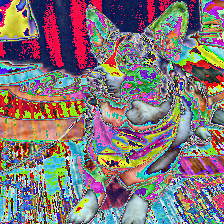

<a id='create'></a>
# Create a PyTorch Model

In this notebook, you use a pretrained neural network called [ResNet-18](https://arxiv.org/pdf/1512.03385.pdf). It is a convolutional neural network (CNN) that is trained on over fourteen million images from [ImageNet](https://www.image-net.org/). It takes an image and classifies it into [1000 categories](https://github.com/Lasagne/Recipes/blob/master/examples/resnet50/imagenet_classes.txt). ResNet-18 is a residual network (ResNet), which is a type of neural network where some of the connections between nodes skip a layer and connect to the subsequent layer. There are different versions of this network. This version has 18 layers in the model.

The next cell loads the pre-trained model.

In [ ]:
model = resnet18(pretrained=True)

To perform predictions, ResNet-18 requires that the model be put into evaluation mode using the `.eval()` method.

In [ ]:
# set the model to inference mode
_ = model.eval()

To make a prediction, the normalized image tensor is passed to the model. The resulting predictions are not in normalized units. Since this is a classification problem, you only need to know the class of the output node that had the highest value. The next cell determines this.

In [ ]:
prediction_not_normalized = model(image_tensor).tolist()[0]
max_value = max(prediction_not_normalized)
print(f"The maximum value is: {max_value}")
print(f"The predicted class is: {prediction_not_normalized.index(max_value) + 1}")

Referring to the [list ImageNet categories](https://github.com/Lasagne/Recipes/blob/master/examples/resnet50/imagenet_classes.txt), you can see that the model correctly classified the image as a _Cardigan, Cardigan Welsh corgi_.

When a classification is performed, you want to know how confident the model is in its prediction. The output values from ResNet-18 are not normalized, but using a $(\sigma)$ softmax function, the output values can be converted into probabilities.

The softmax function maps an input vector, $X$, into a probability distribution. Meaning that it maps all the values in the input vector onto values between 0 and 1. Further, the sum of all the values in the vector is unity. If the input vector has a length of $n$, then the softmax function is defined as:

$$\sigma(X)_i = \frac{e^{x_i}}{\Sigma_{j=1}^{n} e^{x_j}}$$

The next cell computes the probability associated with each class in the model. It shows that the model has high confidence that the image is of a _Cardigan, Cardigan Welsh corgi_.

In [ ]:
softmax = Softmax(dim=1)
prediction_normalized = softmax(model(image_tensor)).tolist()[0]
max_value = max(prediction_normalized)
print(f"The maximum value is: {max_value}")
print(f"The predicted class is: {prediction_normalized.index(max_value) + 1}")

<a id='serialize'></a>
# PyTorch Framework Serialization

The PyTorch framework makes it easy to deploy a PyTorch model into production. The `PyTorchModel()` constructor takes a PyTorch model and converts it into a `PyTorchModel` object. To deploy the model into production, you must prepare the model artifact, verify that the artifact works, save the model to the model catalog, and then deploy it.

ADS provides a number of methods that greatly simplify the model deployment process. It also provides the `.summary_status()` method that outputs a dataframe that defines the steps, status, and detailed information about each step. 

<a id='serialize_pytorchmodel'></a>
## Create A PyTorchModel

The `PyTorchModel()` constructor takes a PyTorch model and the path that you want to use to store the model artifacts. A `PyTorchModel` object is returned, and it's used to manage the deployment.

The next cell creates a model artifact directory. This directory is used to store the artifacts that are needed to deploy the model. It also creates the `PyTorchModel` object.

In [ ]:
artifact_dir = tempfile.mkdtemp()
print(f"Model artifact director: {artifact_dir}")
pytorch_model = PyTorchModel(estimator=model, artifact_dir=artifact_dir)

The `.summary_status()` method of the `PyTorchModel` class is a handy method to keep track of the progress that you are making in deploying the model. It creates a dataframe that lists the deployment steps, their status, and details about them. The next cell returns the summary status dataframe. It shows that the initiate step has been completed.

In [ ]:
pytorch_model.summary_status()

<a id='serialize_prepare'></a>
## Prepare

The prepare step is performed by the `.prepare()` method of the `PyTorchModel` class. It creates a number of customized files used to run the model once it is deployed. These include:

* `input_schema.json`: A JSON file that defines the nature of the features of the `X_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and so on.
* `model.pt`: This is the default filename of the serialized model. It can be changed with the `model_file_name` attribute. By default, the model is stored in a PyTorch file. The parameter `as_onnx` can be used to save the model in the ONNX format.
* `output_schema.json`: A JSON file that defines the nature of the dependent variable in the `y_sample` data. It includes metadata such as the data type, name, constraints, summary statistics, feature type, and so on.
* `runtime.yaml`: This file contains information that is needed to set up the runtime environment on the deployment server. It has information about which conda environment was used to train the model, and what environment should be used to deploy the model. The file also specifies what version of Python should be used.
* `score.py`: This script contains the `load_model()` and `predict()` functions. The `load_model()` function understands the format the model file was saved in, and loads it into memory. The `.predict()` method is used to make inferences in a deployed model. There are also hooks that allow you to perform operations before and after inference. You can modify this script to fit your specific needs.

To create the model artifacts, you use the `.prepare()` method. There are a number of parameters that allow you to store model provenance information. In the next cell, the `conda_env` variable defines the slug of the conda environment that was used to train the model, and also the conda environment that should be used for deployment. You can only pass in slugs to `inference_conda_env` or `training_conda_env` if it's a service environment. Otherwise, you must pass in the full path of the conda environment along with the python version through `inference_python_version` and `training_python_version`. You can set `use_torch_script` to `True` to serialize model in TorchScript program. More info see [Save/Load TorchScript](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format).

In [ ]:
conda_env = "pytorch110_p38_cpu_v1"

# Create a sample of the y values.
y_sample = [0] * len(prediction_not_normalized)
y_sample[prediction_normalized.index(max_value)] = 1

pytorch_model.prepare(
    inference_conda_env=conda_env,
    training_conda_env=conda_env,
    use_case_type=UseCaseType.IMAGE_CLASSIFICATION,
    X_sample=image_tensor,
    y_sample=y_sample,
    force_overwrite=False,
    use_torch_script=True,
)

The next cell uses the `.summary_status()` method to show you that the prepare step finished, and what tasks were completed.

In [ ]:
pytorch_model.summary_status()

The `.prepare()` method has created the following files. You can modify them to fit your specific needs.

In [ ]:
os.listdir(artifact_dir)

Once the artifacts have been created, there are a number of attributes in the `PyTorchModel` object that provide metadata about the model. The `.runtime` attribute details the model deployment settings and model provenance data.

In [ ]:
pytorch_model.runtime_info

The `.schema_input` attribute provides metadata on the features that were used to train the model. You can use this information to determine what data must be provided to make model inferences. Each feature in the model has a section that defines the data type, feature type, name, and if it is required. The metadata also includes the summary statistics associated with the feature type.

In [ ]:
pytorch_model.schema_input

The `.metadata_custom` attribute provides custom metadata that contains information on the category of the metadata, description, key, and value.

In [ ]:
pytorch_model.metadata_custom

The `.metadata_provenance` contains information about the code and training data that was used to create the model. This information is most useful when a Git repository is being used to manage the code for training the model. This is considered a best practice because it allows you to do things like reproduce a model, perform forensic on the model, and so on.

In [ ]:
pytorch_model.metadata_provenance

The `.metadata_taxonomy` is a key-value store that has information about the classification or taxonomy of the model. This can include information such as the model framework, use case type, hyperparameters, and so on.

In [ ]:
pytorch_model.metadata_taxonomy

<a id='serialize_prepare_scorepy'></a>
### score.py

The prepare process creates a `score.py` file that is used to load the model and perform inferences. ADS only directly calls the `load_model()` and `predict()` functions. However, the template `score.py` file has helper functions. The `predict()` function requires data to be passed in JSON format. It calls the `deserialize()` function to convert the JSON into a format that is expected by the model. In this notebook, there are a number of preprocessing steps to convert the input image into a form that is required by the model. The `pre_inference()` function's role is to do any preprocessing that is needed before the inference is performed. Similarly, `post_inference()` performs any required operations after the inference is performed.

* `load_model()`

If using TorchScript, you don't need to modify the score.py generated. The model can be loaded without defining the model class. More info see [Save/Load TorchScript](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format).

If not using TorchScript, the score.py generated requires you to create the class instance of the Model before the weights are loaded. More info see [Save/Load state_dict](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended).
```python
    import torchvision
    the_model = torchvision.models.resnet18()
```

* `pre_inference()`

Based on the data you are going to perform predict, you can modify `pre_inference()` function to preprocess the data. The API could require that the caller perform the transformations that were done in the <a href="intro_data">Data</a> section. If this is the case, then the templated `pre_inference()` function in `score.py` doesn't need to be modified. 

* `post_inference()`

The default behaviour of the ResNet-18 model is to return a non-normalized set of values. In the <a href="intro_data">Data</a> section, you used a softmax function to convert the output to probabilities. The `post_inference()` function can be modified to do this. The templated `score.py` file has the following lines:

```python
    if isinstance(yhat, torch.Tensor):
        return yhat.tolist()
```

You can comment these lines out, and add the softmax code.

```python
#    if isinstance(yhat, torch.Tensor):
#        return yhat.tolist()

    # Add further data postprocessing if needed
    if isinstance(yhat, torch.Tensor):
        from torch.nn import Softmax
        softmax = Softmax(dim=1)
        return softmax(yhat).tolist()
```

The next cell makes these changes to the `score.py` file.

In [ ]:
score = '''
import os
import sys
from functools import lru_cache
import torch
import json
from typing import Dict, List
import numpy as np
import pandas as pd
from io import BytesIO
import base64
import logging

model_name = 'model.pt'

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""

@lru_cache(maxsize=10)
def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    if model_dir not in sys.path:
        sys.path.insert(0, model_dir)
    contents = os.listdir(model_dir)

    if model_file_name not in contents:
        raise Exception(f'{model_file_name} is not found in model directory {model_dir}')


    print(f'Start loading {model_file_name} from model directory {model_dir} ...')
    the_model = torch.jit.load(os.path.join(model_dir, model_file_name))
    print(f"loading {model_file_name} is complete.")

    print("Model is successfully loaded.")

    return the_model

@lru_cache(maxsize=1)
def fetch_data_type_from_schema(input_schema_path=os.path.join(os.path.dirname(os.path.realpath(__file__)), "input_schema.json")):
    """
    Returns data type information fetch from input_schema.json.

    Parameters
    ----------
    input_schema_path: path of input schema.

    Returns
    -------
    data_type: data type fetch from input_schema.json.

    """
    data_type = {}
    if os.path.exists(input_schema_path):
        schema = json.load(open(input_schema_path))
        for col in schema['schema']:
            data_type[col['name']] = col['dtype']
    else:
        print("input_schema has to be passed in in order to recover the same data type. pass `X_sample` in `ads.model.framework.pytorch_model.PyTorchModel.prepare` function to generate the input_schema. Otherwise, the data type might be changed after serialization/deserialization.")
    return data_type

def deserialize(data, input_schema_path):
    """
    Deserialize json-serialized data to data in original type when sent to
predict.

    Parameters
    ----------
    data: serialized input data.
    input_schema_path: path of input schema.

    Returns
    -------
    data: deserialized input data.

    """
    if isinstance(data, bytes):
        logging.warning(
            "bytes are passed directly to the model. If the model expects a specific data format, you need to write the conversion logic in `deserialize()` yourself."
        )
        return data

    data_type = data.get('data_type', '') if isinstance(data, dict) else ''
    json_data = data.get('data', data) if isinstance(data, dict) else data

    if "numpy.ndarray" in data_type:
        load_bytes = BytesIO(base64.b64decode(json_data.encode('utf-8')))
        return np.load(load_bytes, allow_pickle=True)
    if "torch.Tensor" in data_type:
        load_bytes = BytesIO(base64.b64decode(json_data.encode('utf-8')))
        return torch.load(load_bytes)
    if "pandas.core.series.Series" in data_type:
        return pd.Series(json_data)
    if "pandas.core.frame.DataFrame" in data_type or isinstance(json_data, str):
        return pd.read_json(json_data, dtype=fetch_data_type_from_schema(input_schema_path))

    return json_data

def pre_inference(data, input_schema_path):
    """
    Preprocess json-serialized data to feed into predict function.

    Parameters
    ----------
    data: Data format as expected by the predict API of the core estimator.
    input_schema_path: path of input schema.

    Returns
    -------
    data: Data format after any processing.
    """
    data = deserialize(data, input_schema_path)

    # Add further data preprocessing if needed
    return data

def post_inference(yhat):
    """
    Post-process the model results.

    Parameters
    ----------
    yhat: Data format after calling model.predict.

    Returns
    -------
    yhat: Data format after any processing.

    """
    # Modified to use a softmax function to convert the output to probabilities
    if isinstance(yhat, torch.Tensor):
        from torch.nn import Softmax
        softmax = Softmax(dim=1)
        return softmax(yhat).tolist()
    
    return yhat

def predict(data, model=load_model(), input_schema_path=os.path.join(os.path.dirname(os.path.realpath(__file__)), "input_schema.json")):
    """
    Returns prediction given the model and data to predict.

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator
    input_schema_path: path of input schema.

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction': output from model.predict method}

    """
    inputs = pre_inference(data, input_schema_path)

    with torch.no_grad():
        yhat = post_inference(
        model(inputs)
    )
    return {'prediction': yhat}

'''

with open(os.path.join(artifact_dir, "score.py"), "w") as f:
    f.write(score)

When any of the model artifacts are updated, the model object must be updated by calling the `.reload()` method on the `PyTorchModel`object.

In [ ]:
pytorch_model.reload()

<a id='serialize_verify'></a>
## Verify

If you modify the `score.py` file that is part of the model artifacts, then you should verify it. The verify step allows you to test those changes without having to deploy the model. This allows you to debug your code without having to save the model to the model catalog, and then deploy it. The `.verify()` method takes a set of test parameters and performs the prediction by calling the `predict` function in `score.py`. It also runs the `load_model` function.

The next cell simulates a call to a deployed model without having to actually deploy the model. It passes in test values and returns the predictions.

In [ ]:
verift_result = pytorch_model.verify(image_tensor)["prediction"][0]
max_value_verify = max(verift_result)
print(f"The maximum value is: {max_value_verify}")
print(f"The predicted class is: {verift_result.index(max_value_verify) + 1}")

The `.summary_status()` method is updated to show that the verify step has been completed.

In [ ]:
pytorch_model.summary_status()

<a id='serialize_save'></a>
## Save

Once you are satisfied with the performance of the model and have verified that the `score.py` file is working, you can save the model to the model catalog. You do this with the `.save()` method on a `PyTorchModel` object. This bundles up the model artifact that you have created, and pushes it to the model catalog. It returns the model OCID.

In [ ]:
model_id = pytorch_model.save(display_name="Demo PyTorchModel model")

<a id='serialize_deploy'></a>
## Deploy

With the model in the model catalog, you can use the `.deploy()` method of a `PyTorchModel` object to deploy the model. This method allows you to specify the attributes of the deployment such as the display name, description, instance type and count, the maximum bandwidth, and logging groups. The next cell deployd the model with the default settings, except for the custom display name. The `.deploy()` method returns a `ModelDeployment` object.

In [ ]:
deploy = pytorch_model.deploy(display_name="Demo PyTorchModel deployment")

After deployment, the `.summary_status()` method shows that the model is ACTIVE and the `predict()` method is available.

In [ ]:
pytorch_model.summary_status()

<a id='serialize_predict'></a>
## Predict

In the <a href='#create'>Create a PyTorch Model</a> section, you used the `model(image_tensor)` method where `model` is a `ResNet` object. This did the inference using the local model. Now that the `PyTorchModel` model has been deployed, use the `.predict()` method to send a request to the deployed endpoint for predictions.

In [ ]:
md_predict = pytorch_model.predict(image_tensor)["prediction"][0]
max_value_md_predict = max(md_predict)
print(f"The maximum value is: {max_value_md_predict}")
print(f"The predicted class is: {md_predict.index(max_value_md_predict) + 1}")

<a id='clean_up'></a>
# Clean Up

This notebook created a model deployment and a model. This section cleans up those resources. 

The model deployment must be deleted before the model can be deleted. You use the `.delete_deployment()` method on the `PyTorchModel` object to do this.

In [ ]:
delete = pytorch_model.delete_deployment(wait_for_completion=True)

After the model deployment has been deleted, the `.summary_status()` method shows that the model has been deleted and that the `predict()` method is not available.

In [ ]:
pytorch_model.summary_status()

Use the `.delete_model()` method in a `ModelCatalog` object to delete the model.

In [ ]:
ModelCatalog(compartment_id=os.environ["NB_SESSION_COMPARTMENT_OCID"]).delete_model(
    model_id
)

The next cell removes the model artifacts that were stored on your local drive.

In [ ]:
rmtree(artifact_dir)

<a id='ref'></a>
# References
- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)